#Import Libaries

In [1]:
import torch
from torch import nn
from torch import optim
from torch.utils.data import DataLoader

import torchvision
from torchvision import datasets, transforms
from torchvision.utils import make_grid
from torchvision.utils import save_image

from torchsummary import summary

from tqdm import tqdm

import numpy as np
import matplotlib.pyplot as plt

#Load Data

In [2]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize(mean=(0.5,), std=(0.5,))])

In [ ]:
mnist_dataset = datasets.MNIST(root='./data_src', train=True, download=True, transform=transform)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:00<00:00, 105914045.49it/s]

Extracting ./data_src/MNIST/raw/train-images-idx3-ubyte.gz to ./data_src/MNIST/raw



Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 42728639.80it/s]

Extracting ./data_src/MNIST/raw/train-labels-idx1-ubyte.gz to ./data_src/MNIST/raw



Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:00<00:00, 93197291.31it/s]


Extracting ./data_src/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data_src/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 3605323.39it/s]

Extracting ./data_src/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data_src/MNIST/raw



In [ ]:
print("Length of the data = ", len(mnist_dataset))

Length of the data =  60000


In [ ]:
print("Size of the data = ", mnist_dataset.data.shape)

Size of the data =  torch.Size([60000, 28, 28])


#Dataloader

In [ ]:
data_loader = DataLoader(mnist_dataset, batch_size=128, shuffle=True, drop_last=True)
print("Length of the data loader = ", len(data_loader))

Length of the data loader =  468


#GENERATOR

In [ ]:
class GENERATOR(nn.Module):
    def __init__(self):
        super(GENERATOR, self).__init__()

        self.generator = nn.Sequential()
        self.generator.add_module('linr1', nn.Linear(in_features=100, out_features=256))
        self.generator.add_module('lrel1', nn.LeakyReLU(negative_slope=0.2))
        self.generator.add_module('linr2', nn.Linear(in_features=256, out_features=512))
        self.generator.add_module('lrel2', nn.LeakyReLU(negative_slope=0.2))
        self.generator.add_module('linr3', nn.Linear(in_features=512, out_features=1024))
        self.generator.add_module('lrel3', nn.LeakyReLU(negative_slope=0.2))
        self.generator.add_module('linr4', nn.Linear(in_features=1024, out_features=28*28))
        self.generator.add_module('tanh4', nn.Tanh())

    def forward(self, x):
        x = self.generator(x)
        return x

In [ ]:
summary(GENERATOR(), input_size=(128, 100))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1             [-1, 128, 256]          25,856
         LeakyReLU-2             [-1, 128, 256]               0
            Linear-3             [-1, 128, 512]         131,584
         LeakyReLU-4             [-1, 128, 512]               0
            Linear-5            [-1, 128, 1024]         525,312
         LeakyReLU-6            [-1, 128, 1024]               0
            Linear-7             [-1, 128, 784]         803,600
              Tanh-8             [-1, 128, 784]               0
Total params: 1,486,352
Trainable params: 1,486,352
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.05
Forward/backward pass size (MB): 5.03
Params size (MB): 5.67
Estimated Total Size (MB): 10.75
----------------------------------------------------------------


#DISCRIMINATOR

In [ ]:
class DISCRIMINATOR(nn.Module):
    def __init__(self):
        super(DISCRIMINATOR, self).__init__()

        self.discriminator = nn.Sequential()
        self.discriminator.add_module('linr1', nn.Linear(in_features=28*28, out_features=1024))
        self.discriminator.add_module('lrel1', nn.LeakyReLU(negative_slope=0.2))
        self.discriminator.add_module('drop1', nn.Dropout(p=0.3))
        self.discriminator.add_module('linr2', nn.Linear(in_features=1024, out_features=512))
        self.discriminator.add_module('lrel2', nn.LeakyReLU(negative_slope=0.2))
        self.discriminator.add_module('drop2', nn.Dropout(p=0.3))
        self.discriminator.add_module('linr3', nn.Linear(in_features=512, out_features=256))
        self.discriminator.add_module('lrel3', nn.LeakyReLU(negative_slope=0.2))
        self.discriminator.add_module('drop3', nn.Dropout(p=0.3))
        self.discriminator.add_module('linr4', nn.Linear(in_features=256, out_features=1))
        self.discriminator.add_module('sgmd4', nn.Sigmoid())

    def forward(self, x):
        x = x.view(x.shape[0], -1)
        print(x.shape)
        x = self.discriminator(x)
        return x

In [ ]:
summary(DISCRIMINATOR(), input_size=(1, 28, 28))

torch.Size([2, 784])
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                 [-1, 1024]         803,840
         LeakyReLU-2                 [-1, 1024]               0
           Dropout-3                 [-1, 1024]               0
            Linear-4                  [-1, 512]         524,800
         LeakyReLU-5                  [-1, 512]               0
           Dropout-6                  [-1, 512]               0
            Linear-7                  [-1, 256]         131,328
         LeakyReLU-8                  [-1, 256]               0
           Dropout-9                  [-1, 256]               0
           Linear-10                    [-1, 1]             257
          Sigmoid-11                    [-1, 1]               0
Total params: 1,460,225
Trainable params: 1,460,225
Non-trainable params: 0
----------------------------------------------------------------
Input

In [ ]:
def random_noise(batch_size):
    noise = torch.randn(batch_size, 100)
    return noise

#Function to train Generator

In [ ]:
def generator_training_batch(fake_samples, model, criterion, optimizer):

    preds = model(fake_samples)
    error = criterion(preds, torch.ones(len(fake_samples), 1)) # to fool the discriminator

    optimizer.zero_grad()
    error.backward()
    optimizer.step()

    return error

In [ ]:
def discriminator_training_batch(real_samples, fake_samples, model, criterion, optimizer):

    preds_real = model(real_samples)
    error_real = criterion(preds_real, torch.ones(len(real_samples), 1))

    preds_fake = model(fake_samples)
    error_fake = criterion(preds_fake, torch.zeros(len(fake_samples), 1))

    optimizer.zero_grad()
    error_real.backward()
    error_fake.backward()
    optimizer.step()

    return error_real + error_fake

In [ ]:
discriminator = DISCRIMINATOR()
generator = GENERATOR()

d_optimizer = optim.Adam(discriminator.parameters(), lr=0.0002)
g_optimizer = optim.Adam(generator.parameters(), lr=0.0002)

criterion = nn.BCELoss()

In [ ]:
n_epochs = 50
discriminator_loss, generator_loss = [], []

for epoch in range(n_epochs):
    discriminator_losses, generator_losses = [], []

    for data, _ in tqdm(data_loader):

        real_data = data
        fake_data = generator(random_noise(batch_size=128))
        fake_data = fake_data.detach()

        discrim_batch_loss = discriminator_training_batch(real_samples=real_data, fake_samples=fake_data, model=discriminator,
                                                          criterion=criterion, optimizer=d_optimizer)
        discriminator_losses.append(discrim_batch_loss.item())

        fake_data = generator(random_noise(batch_size=128))
        gen_batch_loss = generator_training_batch(fake_samples=fake_data, model=discriminator, criterion=criterion,
                                          optimizer=g_optimizer)
        generator_losses.append(gen_batch_loss.item())

    discriminator_per_epoch_loss = np.array(discriminator_losses).mean()
    generator_per_epoch_loss = np.array(generator_losses).mean()

    discriminator_loss.append(discriminator_per_epoch_loss)
    generator_loss.append(generator_per_epoch_loss)

    if (epoch+1) % 10 == 0:
        print(f'Epoch: {epoch+1}/{n_epochs}\t| Discriminator loss: {discriminator_per_epoch_loss:.4f} |   ', end='')
        print(f'Generator loss: {generator_per_epoch_loss:.4f}')

  0%|          | 1/468 [00:00<01:09,  6.76it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


  1%|          | 3/468 [00:00<01:04,  7.18it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


  1%|          | 5/468 [00:00<01:06,  7.00it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


  1%|▏         | 7/468 [00:01<01:06,  6.91it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


  2%|▏         | 9/468 [00:01<01:03,  7.19it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


  2%|▏         | 11/468 [00:01<01:03,  7.19it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


  3%|▎         | 13/468 [00:01<01:02,  7.26it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


  3%|▎         | 15/468 [00:02<01:01,  7.33it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


  4%|▎         | 17/468 [00:02<01:00,  7.46it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])

  4%|▍         | 18/468 [00:02<01:07,  6.65it/s]


torch.Size([128, 784])
torch.Size([128, 784])


  4%|▍         | 19/468 [00:02<01:15,  5.93it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


  4%|▍         | 21/468 [00:03<01:24,  5.30it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


  5%|▍         | 22/468 [00:03<01:25,  5.19it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


  5%|▍         | 23/468 [00:03<01:29,  4.97it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


  5%|▌         | 24/468 [00:03<01:28,  5.04it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


  5%|▌         | 25/468 [00:04<01:29,  4.96it/s]

torch.Size([128, 784])
torch.Size([128, 784])


  6%|▌         | 26/468 [00:04<01:31,  4.82it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


  6%|▌         | 27/468 [00:04<01:29,  4.92it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


  6%|▌         | 28/468 [00:04<01:31,  4.82it/s]

torch.Size([128, 784])
torch.Size([128, 784])


  6%|▌         | 29/468 [00:04<01:32,  4.74it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


  6%|▋         | 30/468 [00:05<01:33,  4.69it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


  7%|▋         | 31/468 [00:05<01:33,  4.68it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


  7%|▋         | 32/468 [00:05<01:31,  4.79it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


  7%|▋         | 34/468 [00:05<01:15,  5.76it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


  7%|▋         | 35/468 [00:05<01:10,  6.14it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


  8%|▊         | 37/468 [00:06<01:04,  6.65it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


  8%|▊         | 39/468 [00:06<01:02,  6.84it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


  9%|▉         | 41/468 [00:06<01:01,  6.94it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


  9%|▉         | 42/468 [00:06<01:01,  6.97it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


  9%|▉         | 44/468 [00:07<00:58,  7.22it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 10%|▉         | 46/468 [00:07<00:58,  7.27it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 10%|█         | 48/468 [00:07<00:57,  7.29it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 11%|█         | 50/468 [00:07<00:57,  7.26it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 11%|█         | 52/468 [00:08<00:57,  7.20it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 12%|█▏        | 54/468 [00:08<00:57,  7.20it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 12%|█▏        | 56/468 [00:08<00:56,  7.26it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 12%|█▏        | 58/468 [00:09<00:55,  7.36it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 13%|█▎        | 60/468 [00:09<00:55,  7.38it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 13%|█▎        | 62/468 [00:09<00:56,  7.19it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 14%|█▎        | 64/468 [00:09<00:55,  7.29it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 14%|█▍        | 66/468 [00:10<00:54,  7.41it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 15%|█▍        | 68/468 [00:10<00:54,  7.36it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 15%|█▍        | 70/468 [00:10<00:55,  7.11it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 15%|█▌        | 71/468 [00:10<00:56,  7.08it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 16%|█▌        | 73/468 [00:11<00:54,  7.21it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 16%|█▌        | 75/468 [00:11<00:54,  7.25it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 16%|█▋        | 77/468 [00:11<00:55,  7.09it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 17%|█▋        | 79/468 [00:12<00:53,  7.30it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 17%|█▋        | 81/468 [00:12<00:52,  7.44it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 18%|█▊        | 83/468 [00:12<00:53,  7.18it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 18%|█▊        | 85/468 [00:12<00:51,  7.39it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 19%|█▊        | 87/468 [00:13<00:51,  7.43it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 19%|█▉        | 89/468 [00:13<00:50,  7.54it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 19%|█▉        | 91/468 [00:13<00:51,  7.29it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 20%|█▉        | 93/468 [00:13<00:50,  7.46it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 20%|██        | 95/468 [00:14<00:51,  7.20it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 21%|██        | 97/468 [00:14<00:51,  7.17it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 21%|██        | 99/468 [00:14<00:52,  7.07it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 21%|██▏       | 100/468 [00:14<00:52,  7.06it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 22%|██▏       | 102/468 [00:15<00:50,  7.19it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 22%|██▏       | 104/468 [00:15<00:51,  7.09it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 22%|██▏       | 105/468 [00:15<00:55,  6.54it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 23%|██▎       | 107/468 [00:16<01:04,  5.64it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 23%|██▎       | 108/468 [00:16<01:06,  5.38it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 23%|██▎       | 109/468 [00:16<01:09,  5.16it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 24%|██▎       | 110/468 [00:16<01:11,  5.00it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 24%|██▍       | 112/468 [00:17<01:10,  5.03it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 24%|██▍       | 113/468 [00:17<01:11,  4.96it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 24%|██▍       | 114/468 [00:17<01:10,  5.01it/s]

torch.Size([128, 784])
torch.Size([128, 784])


 25%|██▍       | 115/468 [00:17<01:14,  4.71it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 25%|██▍       | 116/468 [00:17<01:14,  4.72it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])

 25%|██▌       | 117/468 [00:18<01:14,  4.73it/s]


torch.Size([128, 784])
torch.Size([128, 784])


 25%|██▌       | 118/468 [00:18<01:12,  4.83it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 25%|██▌       | 119/468 [00:18<01:12,  4.83it/s]

torch.Size([128, 784])
torch.Size([128, 784])


 26%|██▌       | 120/468 [00:18<01:08,  5.11it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 26%|██▌       | 122/468 [00:18<00:56,  6.09it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 26%|██▋       | 124/468 [00:19<00:52,  6.55it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 27%|██▋       | 126/468 [00:19<00:51,  6.64it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 27%|██▋       | 127/468 [00:19<00:51,  6.62it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 28%|██▊       | 129/468 [00:19<00:50,  6.75it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 28%|██▊       | 130/468 [00:20<00:49,  6.82it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 28%|██▊       | 132/468 [00:20<00:48,  6.97it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 29%|██▊       | 134/468 [00:20<00:49,  6.76it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 29%|██▉       | 136/468 [00:20<00:47,  7.05it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 29%|██▉       | 138/468 [00:21<00:45,  7.21it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 30%|██▉       | 140/468 [00:21<00:46,  7.05it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 30%|███       | 142/468 [00:21<00:47,  6.91it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 31%|███       | 143/468 [00:21<00:46,  6.94it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 31%|███       | 145/468 [00:22<00:44,  7.18it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 31%|███▏      | 147/468 [00:22<00:45,  7.02it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 32%|███▏      | 149/468 [00:22<00:45,  7.00it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 32%|███▏      | 150/468 [00:22<00:44,  7.11it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 32%|███▏      | 152/468 [00:23<00:43,  7.25it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 33%|███▎      | 154/468 [00:23<00:44,  7.10it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 33%|███▎      | 156/468 [00:23<00:44,  7.08it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 34%|███▍      | 158/468 [00:24<00:44,  6.90it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 34%|███▍      | 159/468 [00:24<00:44,  6.94it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 34%|███▍      | 161/468 [00:24<00:44,  6.95it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 35%|███▍      | 163/468 [00:24<00:44,  6.82it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 35%|███▌      | 164/468 [00:24<00:44,  6.90it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 35%|███▌      | 166/468 [00:25<00:42,  7.13it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 36%|███▌      | 168/468 [00:25<00:42,  7.08it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 36%|███▋      | 170/468 [00:25<00:41,  7.24it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 37%|███▋      | 172/468 [00:26<00:40,  7.24it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 37%|███▋      | 174/468 [00:26<00:40,  7.25it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 38%|███▊      | 176/468 [00:26<00:41,  7.09it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 38%|███▊      | 178/468 [00:26<00:42,  6.86it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 38%|███▊      | 180/468 [00:27<00:39,  7.22it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 39%|███▉      | 182/468 [00:27<00:38,  7.39it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 39%|███▉      | 184/468 [00:27<00:39,  7.24it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 40%|███▉      | 185/468 [00:27<00:39,  7.16it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 40%|███▉      | 187/468 [00:28<00:38,  7.28it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 40%|████      | 189/468 [00:28<00:37,  7.42it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 41%|████      | 191/468 [00:28<00:43,  6.41it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 41%|████      | 192/468 [00:28<00:47,  5.79it/s]

torch.Size([128, 784])
torch.Size([128, 784])


 41%|████      | 193/468 [00:29<00:51,  5.34it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 41%|████▏     | 194/468 [00:29<00:51,  5.30it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 42%|████▏     | 195/468 [00:29<00:52,  5.23it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 42%|████▏     | 197/468 [00:29<00:53,  5.06it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 42%|████▏     | 198/468 [00:30<00:53,  5.04it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 43%|████▎     | 199/468 [00:30<00:53,  5.02it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 43%|████▎     | 200/468 [00:30<00:53,  4.99it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 43%|████▎     | 201/468 [00:30<00:54,  4.93it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 43%|████▎     | 202/468 [00:31<00:54,  4.89it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 43%|████▎     | 203/468 [00:31<00:54,  4.89it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 44%|████▍     | 205/468 [00:31<00:54,  4.84it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 44%|████▍     | 206/468 [00:31<00:50,  5.18it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 44%|████▍     | 208/468 [00:32<00:42,  6.06it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 45%|████▍     | 210/468 [00:32<00:38,  6.62it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 45%|████▌     | 212/468 [00:32<00:37,  6.77it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 46%|████▌     | 214/468 [00:32<00:36,  6.95it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 46%|████▌     | 216/468 [00:33<00:35,  7.09it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 47%|████▋     | 218/468 [00:33<00:34,  7.29it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 47%|████▋     | 220/468 [00:33<00:34,  7.24it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 47%|████▋     | 222/468 [00:34<00:33,  7.34it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 48%|████▊     | 224/468 [00:34<00:33,  7.31it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 48%|████▊     | 226/468 [00:34<00:33,  7.28it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 49%|████▊     | 228/468 [00:34<00:32,  7.28it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 49%|████▉     | 230/468 [00:35<00:32,  7.35it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 50%|████▉     | 232/468 [00:35<00:32,  7.20it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 50%|█████     | 234/468 [00:35<00:31,  7.32it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 50%|█████     | 236/468 [00:35<00:31,  7.29it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 51%|█████     | 238/468 [00:36<00:32,  7.17it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 51%|█████▏    | 240/468 [00:36<00:31,  7.25it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 52%|█████▏    | 242/468 [00:36<00:31,  7.20it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 52%|█████▏    | 243/468 [00:36<00:31,  7.24it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 52%|█████▏    | 245/468 [00:37<00:31,  7.12it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 53%|█████▎    | 247/468 [00:37<00:29,  7.37it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 53%|█████▎    | 249/468 [00:37<00:30,  7.28it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 54%|█████▎    | 251/468 [00:38<00:29,  7.39it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 54%|█████▍    | 253/468 [00:38<00:29,  7.28it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 54%|█████▍    | 255/468 [00:38<00:29,  7.29it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 55%|█████▍    | 257/468 [00:38<00:28,  7.42it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 55%|█████▌    | 259/468 [00:39<00:28,  7.45it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 56%|█████▌    | 261/468 [00:39<00:28,  7.23it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 56%|█████▌    | 263/468 [00:39<00:29,  7.03it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 57%|█████▋    | 265/468 [00:39<00:28,  7.16it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 57%|█████▋    | 267/468 [00:40<00:27,  7.18it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 57%|█████▋    | 269/468 [00:40<00:28,  7.01it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 58%|█████▊    | 271/468 [00:40<00:27,  7.15it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 58%|█████▊    | 273/468 [00:41<00:26,  7.24it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 59%|█████▉    | 275/468 [00:41<00:27,  7.12it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 59%|█████▉    | 277/468 [00:41<00:27,  6.98it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 59%|█████▉    | 278/468 [00:41<00:29,  6.44it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 60%|█████▉    | 279/468 [00:42<00:32,  5.84it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 60%|█████▉    | 280/468 [00:42<00:33,  5.54it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])

 60%|██████    | 281/468 [00:42<00:35,  5.31it/s]


torch.Size([128, 784])


 60%|██████    | 282/468 [00:42<00:37,  5.02it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])

 60%|██████    | 283/468 [00:42<00:36,  5.02it/s]


torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 61%|██████    | 284/468 [00:43<00:36,  5.03it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 61%|██████    | 285/468 [00:43<00:36,  5.03it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 61%|██████    | 286/468 [00:43<00:37,  4.89it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 61%|██████▏   | 287/468 [00:43<00:37,  4.85it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 62%|██████▏   | 288/468 [00:43<00:37,  4.85it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 62%|██████▏   | 289/468 [00:44<00:36,  4.89it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 62%|██████▏   | 291/468 [00:44<00:37,  4.76it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 62%|██████▏   | 292/468 [00:44<00:36,  4.76it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 63%|██████▎   | 294/468 [00:45<00:30,  5.75it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 63%|██████▎   | 295/468 [00:45<00:28,  6.11it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 63%|██████▎   | 297/468 [00:45<00:25,  6.74it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 64%|██████▍   | 299/468 [00:45<00:24,  6.94it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 64%|██████▍   | 301/468 [00:45<00:23,  7.07it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 65%|██████▍   | 303/468 [00:46<00:22,  7.23it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 65%|██████▌   | 305/468 [00:46<00:23,  6.99it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 66%|██████▌   | 307/468 [00:46<00:22,  7.22it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 66%|██████▌   | 308/468 [00:46<00:22,  7.25it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 66%|██████▌   | 310/468 [00:47<00:22,  7.07it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 67%|██████▋   | 312/468 [00:47<00:21,  7.10it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 67%|██████▋   | 314/468 [00:47<00:21,  7.13it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 67%|██████▋   | 315/468 [00:47<00:21,  7.09it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 68%|██████▊   | 317/468 [00:48<00:21,  7.17it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 68%|██████▊   | 319/468 [00:48<00:20,  7.26it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 69%|██████▊   | 321/468 [00:48<00:21,  6.92it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 69%|██████▉   | 322/468 [00:48<00:20,  6.97it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 69%|██████▉   | 324/468 [00:49<00:20,  7.17it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 70%|██████▉   | 326/468 [00:49<00:19,  7.26it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 70%|███████   | 328/468 [00:49<00:20,  6.96it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 71%|███████   | 330/468 [00:50<00:19,  7.19it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 71%|███████   | 332/468 [00:50<00:18,  7.23it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 71%|███████▏  | 334/468 [00:50<00:18,  7.11it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 72%|███████▏  | 336/468 [00:50<00:18,  7.01it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 72%|███████▏  | 338/468 [00:51<00:18,  7.22it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 73%|███████▎  | 340/468 [00:51<00:17,  7.29it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 73%|███████▎  | 342/468 [00:51<00:18,  6.93it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 74%|███████▎  | 344/468 [00:52<00:17,  7.06it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 74%|███████▍  | 346/468 [00:52<00:16,  7.29it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 74%|███████▍  | 348/468 [00:52<00:16,  7.18it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 75%|███████▍  | 350/468 [00:52<00:16,  7.15it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 75%|███████▌  | 352/468 [00:53<00:15,  7.26it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 76%|███████▌  | 354/468 [00:53<00:15,  7.35it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 76%|███████▌  | 356/468 [00:53<00:15,  7.17it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 76%|███████▋  | 357/468 [00:53<00:15,  6.97it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 77%|███████▋  | 359/468 [00:54<00:15,  7.04it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 77%|███████▋  | 361/468 [00:54<00:15,  6.93it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 77%|███████▋  | 362/468 [00:54<00:15,  6.77it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 78%|███████▊  | 363/468 [00:54<00:15,  6.92it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 78%|███████▊  | 365/468 [00:55<00:17,  5.87it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 78%|███████▊  | 366/468 [00:55<00:18,  5.59it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])

 78%|███████▊  | 367/468 [00:55<00:18,  5.32it/s]


torch.Size([128, 784])
torch.Size([128, 784])


 79%|███████▊  | 368/468 [00:55<00:19,  5.12it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 79%|███████▉  | 369/468 [00:55<00:19,  5.01it/s]

torch.Size([128, 784])
torch.Size([128, 784])


 79%|███████▉  | 370/468 [00:56<00:19,  5.00it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 79%|███████▉  | 371/468 [00:56<00:19,  5.03it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 79%|███████▉  | 372/468 [00:56<00:19,  4.83it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])

 80%|███████▉  | 373/468 [00:56<00:19,  4.91it/s]


torch.Size([128, 784])
torch.Size([128, 784])


 80%|███████▉  | 374/468 [00:56<00:19,  4.74it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 80%|████████  | 375/468 [00:57<00:19,  4.79it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])

 80%|████████  | 376/468 [00:57<00:19,  4.75it/s]


torch.Size([128, 784])
torch.Size([128, 784])


 81%|████████  | 377/468 [00:57<00:19,  4.66it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 81%|████████  | 378/468 [00:57<00:19,  4.72it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 81%|████████  | 380/468 [00:58<00:15,  5.73it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 82%|████████▏ | 382/468 [00:58<00:13,  6.53it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 82%|████████▏ | 384/468 [00:58<00:12,  6.76it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 82%|████████▏ | 386/468 [00:58<00:11,  6.93it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 83%|████████▎ | 388/468 [00:59<00:11,  6.94it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 83%|████████▎ | 390/468 [00:59<00:11,  7.02it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 84%|████████▍ | 392/468 [00:59<00:10,  7.18it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 84%|████████▍ | 394/468 [01:00<00:10,  7.15it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 85%|████████▍ | 396/468 [01:00<00:10,  7.19it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 85%|████████▌ | 398/468 [01:00<00:10,  6.98it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 85%|████████▌ | 400/468 [01:00<00:09,  7.13it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 86%|████████▌ | 402/468 [01:01<00:09,  7.14it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 86%|████████▋ | 404/468 [01:01<00:08,  7.25it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 87%|████████▋ | 406/468 [01:01<00:08,  7.12it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 87%|████████▋ | 407/468 [01:01<00:08,  7.10it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 87%|████████▋ | 409/468 [01:02<00:08,  7.15it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 88%|████████▊ | 411/468 [01:02<00:07,  7.26it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 88%|████████▊ | 413/468 [01:02<00:07,  7.03it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 88%|████████▊ | 414/468 [01:02<00:07,  7.07it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 89%|████████▉ | 416/468 [01:03<00:07,  6.92it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 89%|████████▉ | 418/468 [01:03<00:07,  7.11it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 90%|████████▉ | 420/468 [01:03<00:06,  6.94it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 90%|████████▉ | 421/468 [01:03<00:06,  6.97it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 90%|█████████ | 423/468 [01:04<00:06,  6.93it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 91%|█████████ | 425/468 [01:04<00:05,  7.18it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 91%|█████████ | 427/468 [01:04<00:05,  7.11it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 92%|█████████▏| 429/468 [01:05<00:05,  7.21it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 92%|█████████▏| 431/468 [01:05<00:05,  7.23it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 93%|█████████▎| 433/468 [01:05<00:04,  7.07it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 93%|█████████▎| 435/468 [01:05<00:04,  7.23it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 93%|█████████▎| 437/468 [01:06<00:04,  7.32it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 94%|█████████▍| 439/468 [01:06<00:04,  6.97it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 94%|█████████▍| 441/468 [01:06<00:03,  6.96it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 94%|█████████▍| 442/468 [01:06<00:03,  7.01it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 95%|█████████▍| 444/468 [01:07<00:03,  7.21it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 95%|█████████▌| 446/468 [01:07<00:03,  7.23it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 96%|█████████▌| 448/468 [01:07<00:02,  7.04it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 96%|█████████▌| 450/468 [01:08<00:02,  6.25it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 96%|█████████▋| 451/468 [01:08<00:02,  5.70it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])

 97%|█████████▋| 452/468 [01:08<00:02,  5.52it/s]


torch.Size([128, 784])


 97%|█████████▋| 453/468 [01:08<00:02,  5.17it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 97%|█████████▋| 454/468 [01:08<00:02,  5.09it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 97%|█████████▋| 455/468 [01:09<00:02,  5.08it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 97%|█████████▋| 456/468 [01:09<00:02,  4.96it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])

 98%|█████████▊| 457/468 [01:09<00:02,  4.95it/s]


torch.Size([128, 784])
torch.Size([128, 784])


 98%|█████████▊| 458/468 [01:09<00:02,  4.93it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 98%|█████████▊| 459/468 [01:09<00:01,  4.95it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 99%|█████████▊| 461/468 [01:10<00:01,  4.94it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 99%|█████████▊| 462/468 [01:10<00:01,  4.82it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 99%|█████████▉| 463/468 [01:10<00:01,  4.83it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 99%|█████████▉| 464/468 [01:10<00:00,  4.79it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


100%|█████████▉| 466/468 [01:11<00:00,  5.75it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


100%|█████████▉| 467/468 [01:11<00:00,  6.15it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


100%|██████████| 468/468 [01:11<00:00,  6.54it/s]


torch.Size([128, 784])


  0%|          | 0/468 [00:00<?, ?it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


  0%|          | 1/468 [00:00<01:09,  6.74it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


  0%|          | 2/468 [00:00<01:08,  6.85it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


  1%|          | 3/468 [00:00<01:06,  7.01it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


  1%|          | 4/468 [00:00<01:05,  7.04it/s]

torch.Size([128, 784])
torch.Size([128, 784])


  1%|          | 5/468 [00:00<01:06,  6.95it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


  1%|▏         | 7/468 [00:01<01:08,  6.73it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


  2%|▏         | 9/468 [00:01<01:06,  6.90it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


  2%|▏         | 10/468 [00:01<01:05,  7.03it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


  3%|▎         | 12/468 [00:01<01:03,  7.21it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


  3%|▎         | 14/468 [00:02<01:06,  6.79it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


  3%|▎         | 16/468 [00:02<01:05,  6.94it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


  4%|▎         | 17/468 [00:02<01:04,  6.97it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


  4%|▍         | 19/468 [00:02<01:03,  7.12it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


  4%|▍         | 21/468 [00:03<01:06,  6.76it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


  5%|▍         | 23/468 [00:03<01:03,  6.96it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


  5%|▌         | 24/468 [00:03<01:03,  7.03it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


  6%|▌         | 26/468 [00:03<01:01,  7.14it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


  6%|▌         | 28/468 [00:04<01:04,  6.78it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


  6%|▋         | 30/468 [00:04<01:03,  6.87it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


  7%|▋         | 31/468 [00:04<01:02,  7.00it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


  7%|▋         | 33/468 [00:04<01:01,  7.08it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


  7%|▋         | 35/468 [00:05<01:03,  6.83it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


  8%|▊         | 37/468 [00:05<01:02,  6.92it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


  8%|▊         | 38/468 [00:05<01:01,  6.99it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


  9%|▊         | 40/468 [00:05<01:00,  7.07it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


  9%|▉         | 42/468 [00:06<01:02,  6.79it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


  9%|▉         | 44/468 [00:06<01:00,  7.05it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 10%|▉         | 46/468 [00:06<00:58,  7.21it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 10%|█         | 48/468 [00:06<00:58,  7.15it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 11%|█         | 50/468 [00:07<01:00,  6.92it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 11%|█         | 51/468 [00:07<00:59,  6.96it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 11%|█▏        | 53/468 [00:07<00:57,  7.17it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 12%|█▏        | 55/468 [00:07<00:57,  7.17it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 12%|█▏        | 57/468 [00:08<00:58,  7.04it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 13%|█▎        | 59/468 [00:08<00:57,  7.10it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 13%|█▎        | 61/468 [00:08<00:56,  7.26it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 13%|█▎        | 63/468 [00:09<00:56,  7.16it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 14%|█▍        | 65/468 [00:09<00:57,  7.02it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 14%|█▍        | 67/468 [00:09<01:04,  6.23it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 15%|█▍        | 68/468 [00:09<01:10,  5.71it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])

 15%|█▍        | 69/468 [00:10<01:14,  5.33it/s]


torch.Size([128, 784])
torch.Size([128, 784])


 15%|█▍        | 70/468 [00:10<01:18,  5.10it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 15%|█▌        | 71/468 [00:10<01:18,  5.09it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 15%|█▌        | 72/468 [00:10<01:18,  5.06it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 16%|█▌        | 73/468 [00:10<01:17,  5.07it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 16%|█▌        | 75/468 [00:11<01:20,  4.91it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 16%|█▌        | 76/468 [00:11<01:20,  4.85it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 16%|█▋        | 77/468 [00:11<01:21,  4.78it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 17%|█▋        | 78/468 [00:11<01:22,  4.75it/s]

torch.Size([128, 784])
torch.Size([128, 784])


 17%|█▋        | 79/468 [00:12<01:25,  4.54it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 17%|█▋        | 80/468 [00:12<01:27,  4.44it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 17%|█▋        | 81/468 [00:12<01:23,  4.66it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 18%|█▊        | 83/468 [00:12<01:09,  5.52it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 18%|█▊        | 84/468 [00:13<01:06,  5.74it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 18%|█▊        | 86/468 [00:13<01:00,  6.31it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 19%|█▉        | 88/468 [00:13<00:56,  6.75it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 19%|█▉        | 89/468 [00:13<00:55,  6.84it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 19%|█▉        | 91/468 [00:14<00:56,  6.69it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 20%|█▉        | 92/468 [00:14<00:55,  6.83it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 20%|██        | 94/468 [00:14<00:53,  6.99it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 21%|██        | 96/468 [00:14<00:51,  7.20it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 21%|██        | 98/468 [00:15<00:53,  6.91it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 21%|██▏       | 100/468 [00:15<00:52,  7.07it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 22%|██▏       | 102/468 [00:15<00:51,  7.08it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 22%|██▏       | 104/468 [00:15<00:50,  7.28it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 23%|██▎       | 106/468 [00:16<00:51,  7.09it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 23%|██▎       | 108/468 [00:16<00:51,  7.02it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 24%|██▎       | 110/468 [00:16<00:50,  7.10it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 24%|██▎       | 111/468 [00:16<00:50,  7.06it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 24%|██▍       | 113/468 [00:17<00:50,  7.02it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 24%|██▍       | 114/468 [00:17<00:50,  6.95it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 25%|██▍       | 116/468 [00:17<00:51,  6.87it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 25%|██▌       | 118/468 [00:17<00:49,  7.12it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 26%|██▌       | 120/468 [00:18<00:49,  7.08it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 26%|██▌       | 122/468 [00:18<00:47,  7.28it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 26%|██▋       | 124/468 [00:18<00:49,  7.01it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 27%|██▋       | 126/468 [00:19<00:49,  6.85it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 27%|██▋       | 128/468 [00:19<00:47,  7.10it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 28%|██▊       | 130/468 [00:19<00:48,  6.93it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 28%|██▊       | 132/468 [00:19<00:48,  6.86it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 28%|██▊       | 133/468 [00:20<00:50,  6.60it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 29%|██▉       | 135/468 [00:20<00:49,  6.72it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 29%|██▉       | 137/468 [00:20<00:49,  6.73it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 30%|██▉       | 139/468 [00:20<00:46,  7.08it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 30%|███       | 141/468 [00:21<00:46,  7.00it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 31%|███       | 143/468 [00:21<00:45,  7.08it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 31%|███       | 145/468 [00:21<00:45,  7.05it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 31%|███▏      | 147/468 [00:22<00:45,  6.98it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 32%|███▏      | 149/468 [00:22<00:45,  7.08it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 32%|███▏      | 151/468 [00:22<00:49,  6.34it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 32%|███▏      | 152/468 [00:22<00:55,  5.70it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 33%|███▎      | 153/468 [00:23<00:58,  5.39it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 33%|███▎      | 154/468 [00:23<00:59,  5.28it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 33%|███▎      | 155/468 [00:23<01:01,  5.08it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 33%|███▎      | 156/468 [00:23<01:02,  4.99it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 34%|███▎      | 157/468 [00:23<01:01,  5.04it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 34%|███▍      | 158/468 [00:24<01:02,  4.94it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 34%|███▍      | 159/468 [00:24<01:03,  4.87it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 34%|███▍      | 160/468 [00:24<01:03,  4.83it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 34%|███▍      | 161/468 [00:24<01:03,  4.81it/s]

torch.Size([128, 784])
torch.Size([128, 784])


 35%|███▍      | 162/468 [00:25<01:05,  4.69it/s]

torch.Size([128, 784])
torch.Size([128, 784])


 35%|███▍      | 163/468 [00:25<01:04,  4.75it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 35%|███▌      | 164/468 [00:25<01:03,  4.81it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 35%|███▌      | 165/468 [00:25<01:03,  4.80it/s]

torch.Size([128, 784])
torch.Size([128, 784])


 35%|███▌      | 166/468 [00:25<01:02,  4.83it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 36%|███▌      | 168/468 [00:26<00:52,  5.68it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 36%|███▌      | 169/468 [00:26<00:49,  6.08it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 37%|███▋      | 171/468 [00:26<00:44,  6.63it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 37%|███▋      | 173/468 [00:26<00:42,  6.92it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 37%|███▋      | 175/468 [00:27<00:42,  6.93it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 38%|███▊      | 177/468 [00:27<00:41,  7.09it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 38%|███▊      | 179/468 [00:27<00:40,  7.11it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 39%|███▊      | 181/468 [00:27<00:41,  6.93it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 39%|███▉      | 183/468 [00:28<00:41,  6.93it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 39%|███▉      | 184/468 [00:28<00:40,  6.98it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 40%|███▉      | 186/468 [00:28<00:40,  6.99it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 40%|███▉      | 187/468 [00:28<00:40,  6.91it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 40%|████      | 189/468 [00:29<00:41,  6.78it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 41%|████      | 191/468 [00:29<00:39,  6.93it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 41%|████      | 193/468 [00:29<00:38,  7.12it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 42%|████▏     | 195/468 [00:29<00:38,  7.06it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 42%|████▏     | 197/468 [00:30<00:39,  6.88it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 42%|████▏     | 198/468 [00:30<00:39,  6.86it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 43%|████▎     | 200/468 [00:30<00:38,  7.05it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 43%|████▎     | 202/468 [00:30<00:38,  6.97it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 44%|████▎     | 204/468 [00:31<00:37,  7.07it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 44%|████▍     | 205/468 [00:31<00:37,  6.99it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 44%|████▍     | 207/468 [00:31<00:37,  7.01it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 45%|████▍     | 209/468 [00:31<00:37,  6.94it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 45%|████▌     | 211/468 [00:32<00:37,  6.87it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 45%|████▌     | 212/468 [00:32<00:37,  6.80it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 46%|████▌     | 214/468 [00:32<00:36,  6.96it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 46%|████▌     | 216/468 [00:32<00:35,  7.07it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 47%|████▋     | 218/468 [00:33<00:35,  6.97it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 47%|████▋     | 219/468 [00:33<00:36,  6.85it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 47%|████▋     | 221/468 [00:33<00:34,  7.15it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 48%|████▊     | 223/468 [00:34<00:35,  6.93it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 48%|████▊     | 225/468 [00:34<00:36,  6.73it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 48%|████▊     | 226/468 [00:34<00:35,  6.73it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 49%|████▊     | 228/468 [00:34<00:34,  7.05it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 49%|████▉     | 230/468 [00:35<00:33,  7.09it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 50%|████▉     | 232/468 [00:35<00:33,  7.05it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 50%|████▉     | 233/468 [00:35<00:33,  7.09it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 50%|█████     | 235/468 [00:35<00:32,  7.15it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 50%|█████     | 236/468 [00:35<00:34,  6.73it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 51%|█████     | 237/468 [00:36<00:39,  5.78it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 51%|█████     | 238/468 [00:36<00:42,  5.40it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 51%|█████▏    | 240/468 [00:36<00:43,  5.19it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 51%|█████▏    | 241/468 [00:36<00:44,  5.11it/s]

torch.Size([128, 784])
torch.Size([128, 784])


 52%|█████▏    | 242/468 [00:37<00:45,  4.99it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 52%|█████▏    | 243/468 [00:37<00:46,  4.85it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 52%|█████▏    | 244/468 [00:37<00:46,  4.78it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 52%|█████▏    | 245/468 [00:37<00:46,  4.80it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 53%|█████▎    | 246/468 [00:37<00:46,  4.82it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 53%|█████▎    | 247/468 [00:38<00:46,  4.79it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 53%|█████▎    | 248/468 [00:38<00:46,  4.76it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 53%|█████▎    | 249/468 [00:38<00:45,  4.82it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])

 53%|█████▎    | 250/468 [00:38<00:45,  4.77it/s]


torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 54%|█████▍    | 252/468 [00:39<00:38,  5.57it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 54%|█████▍    | 254/468 [00:39<00:35,  6.11it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 55%|█████▍    | 256/468 [00:39<00:32,  6.60it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 55%|█████▌    | 258/468 [00:39<00:30,  6.79it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 56%|█████▌    | 260/468 [00:40<00:29,  6.99it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 56%|█████▌    | 262/468 [00:40<00:29,  6.88it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 56%|█████▋    | 264/468 [00:40<00:29,  7.01it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 57%|█████▋    | 266/468 [00:41<00:28,  7.02it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 57%|█████▋    | 267/468 [00:41<00:29,  6.89it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 57%|█████▋    | 269/468 [00:41<00:28,  7.01it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 58%|█████▊    | 271/468 [00:41<00:27,  7.09it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 58%|█████▊    | 273/468 [00:42<00:27,  7.12it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 59%|█████▉    | 275/468 [00:42<00:27,  7.05it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 59%|█████▉    | 277/468 [00:42<00:26,  7.15it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 60%|█████▉    | 279/468 [00:43<00:27,  6.76it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 60%|██████    | 281/468 [00:43<00:26,  6.94it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 60%|██████    | 282/468 [00:43<00:27,  6.85it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 61%|██████    | 284/468 [00:43<00:26,  7.04it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 61%|██████    | 286/468 [00:44<00:26,  6.76it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 62%|██████▏   | 288/468 [00:44<00:26,  6.87it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 62%|██████▏   | 289/468 [00:44<00:26,  6.82it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 62%|██████▏   | 291/468 [00:44<00:25,  7.02it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 63%|██████▎   | 293/468 [00:45<00:25,  6.97it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 63%|██████▎   | 295/468 [00:45<00:24,  7.12it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 63%|██████▎   | 297/468 [00:45<00:24,  6.99it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 64%|██████▍   | 299/468 [00:45<00:23,  7.13it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 64%|██████▍   | 301/468 [00:46<00:23,  6.97it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 65%|██████▍   | 303/468 [00:46<00:23,  7.03it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 65%|██████▌   | 305/468 [00:46<00:23,  7.04it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 66%|██████▌   | 307/468 [00:47<00:23,  6.95it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 66%|██████▌   | 309/468 [00:47<00:22,  7.05it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 66%|██████▌   | 310/468 [00:47<00:22,  7.11it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 67%|██████▋   | 312/468 [00:47<00:21,  7.12it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 67%|██████▋   | 314/468 [00:48<00:22,  6.99it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 68%|██████▊   | 316/468 [00:48<00:21,  7.17it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 68%|██████▊   | 318/468 [00:48<00:20,  7.14it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 68%|██████▊   | 320/468 [00:48<00:21,  7.03it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 69%|██████▊   | 321/468 [00:49<00:24,  6.08it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 69%|██████▉   | 322/468 [00:49<00:25,  5.64it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 69%|██████▉   | 323/468 [00:49<00:27,  5.24it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 69%|██████▉   | 324/468 [00:49<00:28,  5.11it/s]

torch.Size([128, 784])
torch.Size([128, 784])


 69%|██████▉   | 325/468 [00:49<00:28,  5.05it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 70%|██████▉   | 326/468 [00:50<00:29,  4.78it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 70%|██████▉   | 327/468 [00:50<00:29,  4.78it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 70%|███████   | 328/468 [00:50<00:29,  4.82it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 70%|███████   | 329/468 [00:50<00:29,  4.68it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 71%|███████   | 330/468 [00:50<00:29,  4.74it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 71%|███████   | 331/468 [00:51<00:28,  4.76it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 71%|███████   | 332/468 [00:51<00:28,  4.76it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])

 71%|███████   | 333/468 [00:51<00:28,  4.79it/s]


torch.Size([128, 784])
torch.Size([128, 784])


 71%|███████▏  | 334/468 [00:51<00:28,  4.76it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 72%|███████▏  | 335/468 [00:52<00:28,  4.66it/s]

torch.Size([128, 784])
torch.Size([128, 784])


 72%|███████▏  | 336/468 [00:52<00:27,  4.86it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 72%|███████▏  | 338/468 [00:52<00:22,  5.87it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 72%|███████▏  | 339/468 [00:52<00:21,  6.10it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 73%|███████▎  | 341/468 [00:52<00:19,  6.47it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 73%|███████▎  | 343/468 [00:53<00:18,  6.80it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 74%|███████▎  | 345/468 [00:53<00:17,  7.03it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 74%|███████▍  | 347/468 [00:53<00:17,  7.09it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 75%|███████▍  | 349/468 [00:54<00:17,  6.93it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 75%|███████▌  | 351/468 [00:54<00:16,  7.04it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 75%|███████▌  | 353/468 [00:54<00:16,  6.99it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 76%|███████▌  | 355/468 [00:54<00:17,  6.59it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 76%|███████▋  | 357/468 [00:55<00:16,  6.74it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 76%|███████▋  | 358/468 [00:55<00:16,  6.66it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 77%|███████▋  | 360/468 [00:55<00:15,  6.94it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 77%|███████▋  | 362/468 [00:56<00:15,  6.64it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 78%|███████▊  | 364/468 [00:56<00:15,  6.73it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 78%|███████▊  | 365/468 [00:56<00:15,  6.81it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 78%|███████▊  | 367/468 [00:56<00:14,  7.04it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 79%|███████▉  | 369/468 [00:57<00:14,  6.75it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 79%|███████▉  | 371/468 [00:57<00:14,  6.86it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 80%|███████▉  | 373/468 [00:57<00:13,  7.09it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 80%|████████  | 375/468 [00:57<00:12,  7.17it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 81%|████████  | 377/468 [00:58<00:13,  6.86it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 81%|████████  | 378/468 [00:58<00:13,  6.72it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 81%|████████  | 380/468 [00:58<00:12,  6.95it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 82%|████████▏ | 382/468 [00:58<00:12,  6.80it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 82%|████████▏ | 384/468 [00:59<00:12,  6.65it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 82%|████████▏ | 385/468 [00:59<00:12,  6.63it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 83%|████████▎ | 387/468 [00:59<00:11,  6.85it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 83%|████████▎ | 389/468 [00:59<00:11,  6.95it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 84%|████████▎ | 391/468 [01:00<00:11,  6.75it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 84%|████████▍ | 392/468 [01:00<00:11,  6.65it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 84%|████████▍ | 394/468 [01:00<00:10,  6.91it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 85%|████████▍ | 396/468 [01:00<00:10,  6.93it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 85%|████████▌ | 398/468 [01:01<00:10,  6.84it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 85%|████████▌ | 399/468 [01:01<00:10,  6.83it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 86%|████████▌ | 401/468 [01:01<00:09,  6.94it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 86%|████████▌ | 403/468 [01:02<00:09,  6.81it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 86%|████████▋ | 404/468 [01:02<00:09,  6.76it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 87%|████████▋ | 406/468 [01:02<00:11,  5.57it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 87%|████████▋ | 407/468 [01:02<00:11,  5.30it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 87%|████████▋ | 408/468 [01:03<00:11,  5.10it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 87%|████████▋ | 409/468 [01:03<00:11,  4.92it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 88%|████████▊ | 410/468 [01:03<00:12,  4.80it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 88%|████████▊ | 411/468 [01:03<00:11,  4.87it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 88%|████████▊ | 412/468 [01:03<00:11,  4.85it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 88%|████████▊ | 413/468 [01:04<00:11,  4.84it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 88%|████████▊ | 414/468 [01:04<00:11,  4.84it/s]

torch.Size([128, 784])
torch.Size([128, 784])


 89%|████████▊ | 415/468 [01:04<00:11,  4.79it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 89%|████████▉ | 416/468 [01:04<00:10,  4.85it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 89%|████████▉ | 417/468 [01:04<00:11,  4.62it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 89%|████████▉ | 418/468 [01:05<00:10,  4.60it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 90%|████████▉ | 419/468 [01:05<00:10,  4.53it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 90%|████████▉ | 420/468 [01:05<00:10,  4.74it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 90%|█████████ | 422/468 [01:05<00:08,  5.65it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 90%|█████████ | 423/468 [01:06<00:07,  5.87it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 91%|█████████ | 425/468 [01:06<00:06,  6.30it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 91%|█████████ | 427/468 [01:06<00:06,  6.57it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 91%|█████████▏| 428/468 [01:06<00:05,  6.74it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 92%|█████████▏| 430/468 [01:07<00:05,  6.79it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 92%|█████████▏| 432/468 [01:07<00:05,  6.84it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 93%|█████████▎| 433/468 [01:07<00:05,  6.74it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 93%|█████████▎| 435/468 [01:07<00:04,  7.02it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 93%|█████████▎| 437/468 [01:08<00:04,  6.94it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 94%|█████████▍| 439/468 [01:08<00:04,  7.00it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 94%|█████████▍| 440/468 [01:08<00:04,  6.78it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 94%|█████████▍| 442/468 [01:08<00:03,  6.92it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 95%|█████████▍| 444/468 [01:09<00:03,  6.85it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 95%|█████████▌| 446/468 [01:09<00:03,  7.01it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 96%|█████████▌| 448/468 [01:09<00:02,  6.97it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 96%|█████████▌| 449/468 [01:09<00:02,  6.90it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 96%|█████████▋| 451/468 [01:10<00:02,  6.81it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 97%|█████████▋| 452/468 [01:10<00:02,  6.84it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 97%|█████████▋| 454/468 [01:10<00:02,  6.84it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 97%|█████████▋| 456/468 [01:10<00:01,  7.00it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 98%|█████████▊| 458/468 [01:11<00:01,  6.84it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 98%|█████████▊| 460/468 [01:11<00:01,  6.84it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 99%|█████████▊| 461/468 [01:11<00:01,  6.60it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 99%|█████████▉| 463/468 [01:11<00:00,  6.80it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 99%|█████████▉| 464/468 [01:11<00:00,  6.67it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


100%|█████████▉| 466/468 [01:12<00:00,  6.82it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


100%|█████████▉| 467/468 [01:12<00:00,  6.80it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


  0%|          | 1/468 [00:00<01:07,  6.96it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


  1%|          | 3/468 [00:00<01:12,  6.43it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


  1%|          | 5/468 [00:00<01:10,  6.55it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


  1%|▏         | 6/468 [00:00<01:10,  6.55it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


  2%|▏         | 8/468 [00:01<01:09,  6.61it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


  2%|▏         | 9/468 [00:01<01:11,  6.45it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


  2%|▏         | 11/468 [00:01<01:08,  6.71it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


  3%|▎         | 12/468 [00:01<01:08,  6.65it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


  3%|▎         | 14/468 [00:02<01:07,  6.70it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


  3%|▎         | 15/468 [00:02<01:06,  6.76it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


  4%|▎         | 17/468 [00:02<01:06,  6.81it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


  4%|▍         | 18/468 [00:02<01:05,  6.85it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


  4%|▍         | 20/468 [00:03<01:14,  6.01it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


  4%|▍         | 21/468 [00:03<01:21,  5.51it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


  5%|▍         | 22/468 [00:03<01:27,  5.12it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


  5%|▍         | 23/468 [00:03<01:29,  4.98it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


  5%|▌         | 24/468 [00:03<01:31,  4.86it/s]

torch.Size([128, 784])
torch.Size([128, 784])


  5%|▌         | 25/468 [00:04<01:34,  4.68it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


  6%|▌         | 26/468 [00:04<01:32,  4.76it/s]

torch.Size([128, 784])
torch.Size([128, 784])


  6%|▌         | 27/468 [00:04<01:33,  4.71it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


  6%|▌         | 28/468 [00:04<01:35,  4.59it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


  6%|▌         | 29/468 [00:05<01:33,  4.67it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


  6%|▋         | 30/468 [00:05<01:34,  4.62it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


  7%|▋         | 31/468 [00:05<01:37,  4.48it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


  7%|▋         | 32/468 [00:05<01:36,  4.50it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


  7%|▋         | 33/468 [00:05<01:34,  4.60it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


  7%|▋         | 34/468 [00:06<01:34,  4.59it/s]

torch.Size([128, 784])
torch.Size([128, 784])


  7%|▋         | 35/468 [00:06<01:32,  4.69it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


  8%|▊         | 37/468 [00:06<01:17,  5.53it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


  8%|▊         | 38/468 [00:06<01:13,  5.82it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


  9%|▊         | 40/468 [00:07<01:07,  6.35it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


  9%|▉         | 41/468 [00:07<01:06,  6.40it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


  9%|▉         | 43/468 [00:07<01:04,  6.60it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 10%|▉         | 45/468 [00:07<01:02,  6.81it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 10%|█         | 47/468 [00:08<01:01,  6.88it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 10%|█         | 49/468 [00:08<01:02,  6.74it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 11%|█         | 51/468 [00:08<01:02,  6.71it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 11%|█▏        | 53/468 [00:08<01:00,  6.90it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 12%|█▏        | 55/468 [00:09<01:00,  6.82it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 12%|█▏        | 57/468 [00:09<01:01,  6.70it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 12%|█▏        | 58/468 [00:09<01:01,  6.64it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 13%|█▎        | 60/468 [00:10<00:58,  6.92it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 13%|█▎        | 62/468 [00:10<00:59,  6.86it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 14%|█▎        | 64/468 [00:10<00:58,  6.93it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 14%|█▍        | 65/468 [00:10<00:57,  6.96it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 14%|█▍        | 67/468 [00:11<00:56,  7.04it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 15%|█▍        | 69/468 [00:11<00:57,  6.99it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 15%|█▌        | 71/468 [00:11<00:57,  6.95it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 15%|█▌        | 72/468 [00:11<00:56,  6.96it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 16%|█▌        | 74/468 [00:12<00:56,  7.03it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 16%|█▌        | 76/468 [00:12<00:57,  6.83it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 17%|█▋        | 78/468 [00:12<00:56,  6.92it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 17%|█▋        | 79/468 [00:12<00:56,  6.86it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 17%|█▋        | 81/468 [00:13<00:57,  6.78it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 18%|█▊        | 83/468 [00:13<00:55,  6.95it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 18%|█▊        | 85/468 [00:13<00:57,  6.72it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 18%|█▊        | 86/468 [00:13<00:57,  6.70it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 19%|█▉        | 88/468 [00:14<00:55,  6.82it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 19%|█▉        | 90/468 [00:14<00:55,  6.81it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 20%|█▉        | 92/468 [00:14<00:55,  6.79it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 20%|█▉        | 93/468 [00:14<00:55,  6.76it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 20%|██        | 95/468 [00:15<00:53,  6.97it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 21%|██        | 97/468 [00:15<00:52,  7.02it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 21%|██        | 99/468 [00:15<00:52,  6.96it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 21%|██▏       | 100/468 [00:15<00:52,  6.98it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 22%|██▏       | 102/468 [00:16<00:52,  6.92it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 22%|██▏       | 104/468 [00:16<01:00,  6.02it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 22%|██▏       | 105/468 [00:16<01:07,  5.41it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 23%|██▎       | 106/468 [00:16<01:08,  5.27it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 23%|██▎       | 107/468 [00:17<01:10,  5.12it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 23%|██▎       | 108/468 [00:17<01:13,  4.89it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 23%|██▎       | 109/468 [00:17<01:17,  4.64it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 24%|██▎       | 110/468 [00:17<01:17,  4.62it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 24%|██▎       | 111/468 [00:18<01:15,  4.72it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 24%|██▍       | 112/468 [00:18<01:17,  4.58it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 24%|██▍       | 113/468 [00:18<01:17,  4.59it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 24%|██▍       | 114/468 [00:18<01:18,  4.52it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 25%|██▍       | 115/468 [00:18<01:15,  4.68it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 25%|██▍       | 116/468 [00:19<01:14,  4.75it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 25%|██▌       | 117/468 [00:19<01:13,  4.77it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 25%|██▌       | 118/468 [00:19<01:15,  4.63it/s]

torch.Size([128, 784])
torch.Size([128, 784])


 25%|██▌       | 119/468 [00:19<01:16,  4.57it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 26%|██▌       | 120/468 [00:19<01:09,  5.03it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 26%|██▌       | 122/468 [00:20<00:58,  5.94it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 26%|██▋       | 124/468 [00:20<00:56,  6.12it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 27%|██▋       | 126/468 [00:20<00:52,  6.47it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 27%|██▋       | 128/468 [00:21<00:49,  6.84it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 28%|██▊       | 130/468 [00:21<00:49,  6.79it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 28%|██▊       | 132/468 [00:21<00:48,  6.96it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 28%|██▊       | 133/468 [00:21<00:49,  6.76it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 29%|██▉       | 135/468 [00:22<00:47,  6.95it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 29%|██▉       | 136/468 [00:22<00:47,  6.97it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 29%|██▉       | 138/468 [00:22<00:47,  6.90it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 30%|██▉       | 140/468 [00:22<00:48,  6.79it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 30%|███       | 142/468 [00:23<00:47,  6.90it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 31%|███       | 143/468 [00:23<00:47,  6.81it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 31%|███       | 145/468 [00:23<00:48,  6.68it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 31%|███       | 146/468 [00:23<00:48,  6.67it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 32%|███▏      | 148/468 [00:24<00:47,  6.81it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 32%|███▏      | 150/468 [00:24<00:46,  6.90it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 32%|███▏      | 152/468 [00:24<00:47,  6.66it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 33%|███▎      | 153/468 [00:24<00:47,  6.64it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 33%|███▎      | 155/468 [00:25<00:47,  6.61it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 33%|███▎      | 156/468 [00:25<00:48,  6.48it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 34%|███▍      | 158/468 [00:25<00:47,  6.46it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 34%|███▍      | 160/468 [00:25<00:45,  6.77it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 35%|███▍      | 162/468 [00:26<00:45,  6.74it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 35%|███▌      | 164/468 [00:26<00:44,  6.83it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 35%|███▌      | 166/468 [00:26<00:43,  6.88it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 36%|███▌      | 167/468 [00:26<00:43,  6.95it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 36%|███▌      | 169/468 [00:27<00:43,  6.84it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 37%|███▋      | 171/468 [00:27<00:43,  6.86it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 37%|███▋      | 173/468 [00:27<00:42,  6.86it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 37%|███▋      | 175/468 [00:28<00:43,  6.69it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 38%|███▊      | 177/468 [00:28<00:42,  6.81it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 38%|███▊      | 178/468 [00:28<00:44,  6.53it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 38%|███▊      | 180/468 [00:28<00:43,  6.64it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 39%|███▊      | 181/468 [00:28<00:42,  6.68it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 39%|███▉      | 183/468 [00:29<00:42,  6.76it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 40%|███▉      | 185/468 [00:29<00:41,  6.85it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 40%|███▉      | 187/468 [00:29<00:43,  6.48it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 40%|████      | 188/468 [00:30<00:47,  5.85it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 40%|████      | 189/468 [00:30<00:52,  5.32it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 41%|████      | 190/468 [00:30<00:57,  4.86it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 41%|████      | 191/468 [00:30<00:56,  4.87it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 41%|████      | 192/468 [00:30<00:57,  4.82it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 41%|████      | 193/468 [00:31<00:58,  4.74it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 41%|████▏     | 194/468 [00:31<00:57,  4.73it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 42%|████▏     | 195/468 [00:31<00:57,  4.71it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 42%|████▏     | 196/468 [00:31<00:58,  4.66it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 42%|████▏     | 198/468 [00:32<00:56,  4.78it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 43%|████▎     | 199/468 [00:32<00:57,  4.67it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 43%|████▎     | 200/468 [00:32<00:57,  4.69it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 43%|████▎     | 201/468 [00:32<00:56,  4.71it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 43%|████▎     | 202/468 [00:33<00:56,  4.74it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 43%|████▎     | 203/468 [00:33<00:55,  4.81it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 44%|████▍     | 205/468 [00:33<00:49,  5.27it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 44%|████▍     | 206/468 [00:33<00:46,  5.66it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 44%|████▍     | 208/468 [00:34<00:40,  6.35it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 45%|████▍     | 210/468 [00:34<00:38,  6.66it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 45%|████▌     | 212/468 [00:34<00:38,  6.62it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 46%|████▌     | 213/468 [00:34<00:38,  6.70it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 46%|████▌     | 215/468 [00:35<00:36,  6.99it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 46%|████▋     | 217/468 [00:35<00:36,  6.89it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 47%|████▋     | 219/468 [00:35<00:37,  6.62it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 47%|████▋     | 220/468 [00:35<00:37,  6.70it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 47%|████▋     | 222/468 [00:36<00:35,  6.92it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 48%|████▊     | 224/468 [00:36<00:36,  6.63it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 48%|████▊     | 226/468 [00:36<00:36,  6.64it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 49%|████▊     | 227/468 [00:36<00:35,  6.72it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 49%|████▉     | 229/468 [00:37<00:34,  6.93it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 49%|████▉     | 231/468 [00:37<00:34,  6.90it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 50%|████▉     | 233/468 [00:37<00:34,  6.88it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 50%|█████     | 234/468 [00:37<00:34,  6.87it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 50%|█████     | 236/468 [00:38<00:33,  6.92it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 51%|█████     | 238/468 [00:38<00:35,  6.50it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 51%|█████▏    | 240/468 [00:38<00:34,  6.64it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 51%|█████▏    | 241/468 [00:38<00:33,  6.71it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 52%|█████▏    | 243/468 [00:39<00:32,  7.00it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 52%|█████▏    | 245/468 [00:39<00:32,  6.82it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 53%|█████▎    | 247/468 [00:39<00:32,  6.72it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 53%|█████▎    | 248/468 [00:39<00:32,  6.71it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 53%|█████▎    | 250/468 [00:40<00:32,  6.71it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 54%|█████▎    | 251/468 [00:40<00:33,  6.50it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 54%|█████▍    | 253/468 [00:40<00:31,  6.73it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 54%|█████▍    | 255/468 [00:41<00:30,  6.99it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 55%|█████▍    | 257/468 [00:41<00:29,  7.07it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 55%|█████▌    | 259/468 [00:41<00:29,  7.03it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 56%|█████▌    | 261/468 [00:41<00:30,  6.88it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 56%|█████▌    | 263/468 [00:42<00:30,  6.77it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 56%|█████▋    | 264/468 [00:42<00:30,  6.70it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 57%|█████▋    | 266/468 [00:42<00:29,  6.76it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 57%|█████▋    | 267/468 [00:42<00:31,  6.45it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 57%|█████▋    | 269/468 [00:43<00:29,  6.76it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 58%|█████▊    | 271/468 [00:43<00:29,  6.75it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 58%|█████▊    | 273/468 [00:43<00:33,  5.82it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 59%|█████▊    | 274/468 [00:43<00:34,  5.55it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 59%|█████▉    | 275/468 [00:44<00:36,  5.25it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 59%|█████▉    | 276/468 [00:44<00:39,  4.90it/s]

torch.Size([128, 784])
torch.Size([128, 784])


 59%|█████▉    | 277/468 [00:44<00:39,  4.81it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 59%|█████▉    | 278/468 [00:44<00:40,  4.72it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 60%|█████▉    | 279/468 [00:45<00:39,  4.79it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 60%|█████▉    | 280/468 [00:45<00:39,  4.81it/s]

torch.Size([128, 784])
torch.Size([128, 784])


 60%|██████    | 281/468 [00:45<00:39,  4.74it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 60%|██████    | 282/468 [00:45<00:39,  4.67it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 60%|██████    | 283/468 [00:45<00:40,  4.61it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 61%|██████    | 284/468 [00:46<00:39,  4.65it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 61%|██████    | 285/468 [00:46<00:38,  4.70it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 61%|██████    | 286/468 [00:46<00:38,  4.67it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 61%|██████▏   | 287/468 [00:46<00:38,  4.73it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 62%|██████▏   | 288/468 [00:47<00:39,  4.61it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 62%|██████▏   | 290/468 [00:47<00:31,  5.64it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 62%|██████▏   | 291/468 [00:47<00:30,  5.86it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 63%|██████▎   | 293/468 [00:47<00:27,  6.28it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 63%|██████▎   | 294/468 [00:47<00:27,  6.43it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 63%|██████▎   | 296/468 [00:48<00:26,  6.53it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 63%|██████▎   | 297/468 [00:48<00:26,  6.52it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 64%|██████▍   | 299/468 [00:48<00:25,  6.61it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 64%|██████▍   | 300/468 [00:48<00:25,  6.67it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 65%|██████▍   | 302/468 [00:49<00:25,  6.63it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 65%|██████▍   | 304/468 [00:49<00:24,  6.82it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 65%|██████▌   | 306/468 [00:49<00:23,  6.92it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 66%|██████▌   | 308/468 [00:49<00:23,  6.94it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 66%|██████▌   | 310/468 [00:50<00:23,  6.78it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 66%|██████▋   | 311/468 [00:50<00:24,  6.53it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 67%|██████▋   | 313/468 [00:50<00:23,  6.59it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 67%|██████▋   | 314/468 [00:50<00:23,  6.62it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 68%|██████▊   | 316/468 [00:51<00:22,  6.71it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 68%|██████▊   | 318/468 [00:51<00:22,  6.74it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 68%|██████▊   | 320/468 [00:51<00:22,  6.70it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 69%|██████▊   | 321/468 [00:51<00:22,  6.65it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 69%|██████▉   | 323/468 [00:52<00:21,  6.78it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 69%|██████▉   | 325/468 [00:52<00:21,  6.79it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 70%|██████▉   | 327/468 [00:52<00:20,  6.92it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 70%|███████   | 329/468 [00:53<00:19,  7.01it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 71%|███████   | 331/468 [00:53<00:20,  6.78it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 71%|███████   | 332/468 [00:53<00:20,  6.72it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 71%|███████▏  | 334/468 [00:53<00:19,  6.88it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 72%|███████▏  | 336/468 [00:54<00:18,  7.02it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 72%|███████▏  | 338/468 [00:54<00:19,  6.62it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 72%|███████▏  | 339/468 [00:54<00:19,  6.72it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 73%|███████▎  | 341/468 [00:54<00:18,  6.77it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 73%|███████▎  | 343/468 [00:55<00:18,  6.86it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 74%|███████▎  | 345/468 [00:55<00:18,  6.55it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 74%|███████▍  | 346/468 [00:55<00:18,  6.65it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 74%|███████▍  | 348/468 [00:55<00:17,  6.78it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 75%|███████▍  | 350/468 [00:56<00:16,  7.00it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 75%|███████▌  | 351/468 [00:56<00:17,  6.55it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 75%|███████▌  | 353/468 [00:56<00:17,  6.49it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 76%|███████▌  | 355/468 [00:56<00:16,  6.73it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 76%|███████▌  | 356/468 [00:57<00:18,  6.19it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 76%|███████▋  | 357/468 [00:57<00:20,  5.41it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 76%|███████▋  | 358/468 [00:57<00:21,  5.04it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 77%|███████▋  | 359/468 [00:57<00:21,  4.97it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 77%|███████▋  | 361/468 [00:58<00:21,  5.00it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 77%|███████▋  | 362/468 [00:58<00:22,  4.78it/s]

torch.Size([128, 784])
torch.Size([128, 784])


 78%|███████▊  | 363/468 [00:58<00:21,  4.89it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 78%|███████▊  | 364/468 [00:58<00:21,  4.88it/s]

torch.Size([128, 784])
torch.Size([128, 784])


 78%|███████▊  | 365/468 [00:59<00:21,  4.77it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 78%|███████▊  | 366/468 [00:59<00:22,  4.55it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 78%|███████▊  | 367/468 [00:59<00:22,  4.49it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 79%|███████▊  | 368/468 [00:59<00:22,  4.53it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 79%|███████▉  | 369/468 [00:59<00:21,  4.63it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 79%|███████▉  | 370/468 [01:00<00:20,  4.69it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 79%|███████▉  | 371/468 [01:00<00:21,  4.48it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 79%|███████▉  | 372/468 [01:00<00:19,  4.83it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 80%|███████▉  | 374/468 [01:00<00:16,  5.61it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 80%|████████  | 375/468 [01:01<00:15,  5.87it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 81%|████████  | 377/468 [01:01<00:14,  6.41it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 81%|████████  | 379/468 [01:01<00:14,  6.33it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 81%|████████  | 380/468 [01:01<00:13,  6.42it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 82%|████████▏ | 382/468 [01:02<00:13,  6.60it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 82%|████████▏ | 383/468 [01:02<00:12,  6.66it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])

 82%|████████▏ | 384/468 [01:02<00:13,  6.37it/s]


torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 82%|████████▏ | 386/468 [01:02<00:12,  6.56it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 83%|████████▎ | 388/468 [01:03<00:11,  6.68it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 83%|████████▎ | 390/468 [01:03<00:11,  6.80it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 84%|████████▎ | 391/468 [01:03<00:11,  6.52it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 84%|████████▍ | 393/468 [01:03<00:11,  6.61it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 84%|████████▍ | 394/468 [01:03<00:11,  6.52it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 85%|████████▍ | 396/468 [01:04<00:10,  6.79it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 85%|████████▌ | 398/468 [01:04<00:10,  6.59it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 85%|████████▌ | 400/468 [01:04<00:10,  6.62it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 86%|████████▌ | 401/468 [01:04<00:09,  6.71it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 86%|████████▌ | 403/468 [01:05<00:09,  6.87it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 87%|████████▋ | 405/468 [01:05<00:09,  6.88it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 87%|████████▋ | 407/468 [01:05<00:08,  6.80it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 87%|████████▋ | 409/468 [01:06<00:08,  6.96it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 88%|████████▊ | 411/468 [01:06<00:08,  6.84it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 88%|████████▊ | 412/468 [01:06<00:08,  6.80it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 88%|████████▊ | 414/468 [01:06<00:08,  6.71it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 89%|████████▉ | 416/468 [01:07<00:07,  6.80it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 89%|████████▉ | 418/468 [01:07<00:07,  6.66it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 90%|████████▉ | 420/468 [01:07<00:07,  6.68it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 90%|█████████ | 422/468 [01:08<00:06,  6.80it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 91%|█████████ | 424/468 [01:08<00:06,  6.67it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 91%|█████████ | 426/468 [01:08<00:06,  6.73it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 91%|█████████ | 427/468 [01:08<00:06,  6.52it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 92%|█████████▏| 429/468 [01:09<00:05,  6.83it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 92%|█████████▏| 431/468 [01:09<00:05,  6.81it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 93%|█████████▎| 433/468 [01:09<00:05,  6.86it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 93%|█████████▎| 434/468 [01:09<00:05,  6.69it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 93%|█████████▎| 436/468 [01:10<00:04,  6.84it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 94%|█████████▎| 438/468 [01:10<00:04,  6.69it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 94%|█████████▍| 439/468 [01:10<00:04,  5.99it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 94%|█████████▍| 440/468 [01:10<00:05,  5.31it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 94%|█████████▍| 441/468 [01:11<00:05,  5.18it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])

 94%|█████████▍| 442/468 [01:11<00:05,  5.04it/s]


torch.Size([128, 784])
torch.Size([128, 784])


 95%|█████████▍| 443/468 [01:11<00:05,  4.92it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 95%|█████████▌| 445/468 [01:11<00:04,  4.82it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 95%|█████████▌| 446/468 [01:12<00:04,  4.63it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 96%|█████████▌| 447/468 [01:12<00:04,  4.62it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 96%|█████████▌| 448/468 [01:12<00:04,  4.70it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 96%|█████████▌| 449/468 [01:12<00:04,  4.65it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 96%|█████████▌| 450/468 [01:13<00:03,  4.66it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])

 96%|█████████▋| 451/468 [01:13<00:03,  4.79it/s]


torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 97%|█████████▋| 452/468 [01:13<00:03,  4.87it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 97%|█████████▋| 453/468 [01:13<00:03,  4.75it/s]

torch.Size([128, 784])


 97%|█████████▋| 454/468 [01:13<00:03,  4.61it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 97%|█████████▋| 455/468 [01:14<00:02,  4.80it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 98%|█████████▊| 457/468 [01:14<00:01,  5.63it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 98%|█████████▊| 458/468 [01:14<00:01,  5.86it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 98%|█████████▊| 460/468 [01:14<00:01,  6.36it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 99%|█████████▊| 462/468 [01:15<00:00,  6.69it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 99%|█████████▉| 464/468 [01:15<00:00,  6.56it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


100%|█████████▉| 466/468 [01:15<00:00,  6.67it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


100%|█████████▉| 467/468 [01:15<00:00,  6.76it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


  0%|          | 1/468 [00:00<01:19,  5.84it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


  1%|          | 3/468 [00:00<01:12,  6.44it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


  1%|          | 5/468 [00:00<01:08,  6.76it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


  1%|▏         | 7/468 [00:01<01:07,  6.86it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


  2%|▏         | 9/468 [00:01<01:07,  6.77it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


  2%|▏         | 11/468 [00:01<01:07,  6.76it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


  3%|▎         | 13/468 [00:01<01:06,  6.88it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


  3%|▎         | 15/468 [00:02<01:06,  6.84it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


  4%|▎         | 17/468 [00:02<01:06,  6.78it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


  4%|▍         | 19/468 [00:02<01:06,  6.75it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


  4%|▍         | 21/468 [00:03<01:05,  6.86it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


  5%|▍         | 23/468 [00:03<01:05,  6.81it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


  5%|▌         | 25/468 [00:03<01:04,  6.83it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


  6%|▌         | 27/468 [00:04<01:04,  6.83it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


  6%|▌         | 29/468 [00:04<01:07,  6.54it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


  7%|▋         | 31/468 [00:04<01:06,  6.54it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


  7%|▋         | 32/468 [00:04<01:07,  6.43it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


  7%|▋         | 34/468 [00:05<01:04,  6.76it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


  7%|▋         | 35/468 [00:05<01:05,  6.65it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


  8%|▊         | 37/468 [00:05<01:04,  6.65it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


  8%|▊         | 38/468 [00:05<01:04,  6.66it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


  9%|▊         | 40/468 [00:05<01:02,  6.88it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


  9%|▉         | 42/468 [00:06<01:01,  6.92it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


  9%|▉         | 44/468 [00:06<01:02,  6.79it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 10%|▉         | 45/468 [00:06<01:02,  6.75it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 10%|█         | 47/468 [00:07<01:01,  6.81it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 10%|█         | 49/468 [00:07<01:01,  6.79it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 11%|█         | 50/468 [00:07<01:03,  6.58it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 11%|█         | 52/468 [00:07<01:02,  6.65it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 12%|█▏        | 54/468 [00:08<01:04,  6.46it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 12%|█▏        | 55/468 [00:08<01:10,  5.84it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 12%|█▏        | 56/468 [00:08<01:16,  5.35it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 12%|█▏        | 57/468 [00:08<01:22,  5.00it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 12%|█▏        | 58/468 [00:08<01:24,  4.86it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 13%|█▎        | 59/468 [00:09<01:24,  4.85it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 13%|█▎        | 61/468 [00:09<01:24,  4.80it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 13%|█▎        | 62/468 [00:09<01:23,  4.88it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 13%|█▎        | 63/468 [00:10<01:27,  4.63it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 14%|█▎        | 64/468 [00:10<01:28,  4.57it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 14%|█▍        | 65/468 [00:10<01:31,  4.39it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 14%|█▍        | 66/468 [00:10<01:31,  4.37it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 14%|█▍        | 67/468 [00:10<01:29,  4.50it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 15%|█▍        | 68/468 [00:11<01:26,  4.64it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 15%|█▍        | 69/468 [00:11<01:28,  4.49it/s]

torch.Size([128, 784])
torch.Size([128, 784])


 15%|█▍        | 70/468 [00:11<01:28,  4.48it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 15%|█▌        | 71/468 [00:11<01:20,  4.91it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 16%|█▌        | 73/468 [00:12<01:08,  5.75it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 16%|█▌        | 75/468 [00:12<01:02,  6.25it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 16%|█▌        | 76/468 [00:12<01:03,  6.17it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 17%|█▋        | 78/468 [00:12<01:01,  6.34it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 17%|█▋        | 80/468 [00:13<00:59,  6.55it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 18%|█▊        | 82/468 [00:13<00:57,  6.67it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 18%|█▊        | 84/468 [00:13<00:59,  6.46it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 18%|█▊        | 86/468 [00:14<00:56,  6.81it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 19%|█▉        | 88/468 [00:14<00:55,  6.86it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 19%|█▉        | 90/468 [00:14<00:56,  6.72it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 19%|█▉        | 91/468 [00:14<00:58,  6.47it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 20%|█▉        | 93/468 [00:15<00:57,  6.47it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 20%|██        | 95/468 [00:15<00:56,  6.60it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 21%|██        | 96/468 [00:15<00:55,  6.67it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 21%|██        | 98/468 [00:15<00:54,  6.76it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 21%|██▏       | 100/468 [00:16<00:52,  6.97it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 22%|██▏       | 102/468 [00:16<00:53,  6.85it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 22%|██▏       | 104/468 [00:16<00:53,  6.86it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 22%|██▏       | 105/468 [00:16<00:54,  6.64it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 23%|██▎       | 107/468 [00:17<00:52,  6.85it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 23%|██▎       | 109/468 [00:17<00:53,  6.74it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 24%|██▎       | 111/468 [00:17<00:52,  6.86it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 24%|██▍       | 112/468 [00:17<00:54,  6.58it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 24%|██▍       | 114/468 [00:18<00:52,  6.78it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 25%|██▍       | 116/468 [00:18<00:51,  6.80it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 25%|██▌       | 118/468 [00:18<00:51,  6.73it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 26%|██▌       | 120/468 [00:19<00:52,  6.63it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 26%|██▌       | 121/468 [00:19<00:52,  6.63it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 26%|██▋       | 123/468 [00:19<00:51,  6.74it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 27%|██▋       | 125/468 [00:19<00:50,  6.80it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 27%|██▋       | 127/468 [00:20<00:50,  6.73it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 27%|██▋       | 128/468 [00:20<00:50,  6.74it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 28%|██▊       | 130/468 [00:20<00:50,  6.74it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 28%|██▊       | 131/468 [00:20<00:51,  6.56it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 28%|██▊       | 133/468 [00:21<00:50,  6.62it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 29%|██▉       | 135/468 [00:21<00:48,  6.86it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 29%|██▉       | 137/468 [00:21<00:49,  6.72it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 29%|██▉       | 138/468 [00:21<00:55,  5.91it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 30%|██▉       | 139/468 [00:22<00:59,  5.49it/s]

torch.Size([128, 784])
torch.Size([128, 784])


 30%|██▉       | 140/468 [00:22<01:01,  5.32it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 30%|███       | 141/468 [00:22<01:05,  5.02it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 30%|███       | 142/468 [00:22<01:07,  4.81it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 31%|███       | 143/468 [00:22<01:08,  4.74it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 31%|███       | 144/468 [00:23<01:08,  4.72it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 31%|███       | 145/468 [00:23<01:08,  4.71it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 31%|███       | 146/468 [00:23<01:09,  4.64it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 31%|███▏      | 147/468 [00:23<01:09,  4.62it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 32%|███▏      | 148/468 [00:24<01:09,  4.58it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 32%|███▏      | 149/468 [00:24<01:08,  4.63it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 32%|███▏      | 150/468 [00:24<01:09,  4.59it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 32%|███▏      | 151/468 [00:24<01:09,  4.56it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])

 32%|███▏      | 152/468 [00:24<01:07,  4.65it/s]


torch.Size([128, 784])
torch.Size([128, 784])


 33%|███▎      | 153/468 [00:25<01:07,  4.67it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 33%|███▎      | 154/468 [00:25<01:06,  4.75it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 33%|███▎      | 156/468 [00:25<00:55,  5.60it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 34%|███▎      | 157/468 [00:25<00:52,  5.88it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 34%|███▍      | 159/468 [00:26<00:48,  6.43it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 34%|███▍      | 161/468 [00:26<00:47,  6.50it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 35%|███▍      | 163/468 [00:26<00:46,  6.51it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 35%|███▌      | 164/468 [00:26<00:46,  6.54it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 35%|███▌      | 166/468 [00:27<00:44,  6.85it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 36%|███▌      | 167/468 [00:27<00:44,  6.84it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 36%|███▌      | 169/468 [00:27<00:44,  6.67it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 36%|███▋      | 170/468 [00:27<00:44,  6.67it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 37%|███▋      | 172/468 [00:27<00:43,  6.85it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 37%|███▋      | 173/468 [00:28<00:43,  6.74it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 37%|███▋      | 175/468 [00:28<00:44,  6.65it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 38%|███▊      | 177/468 [00:28<00:43,  6.73it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 38%|███▊      | 179/468 [00:28<00:42,  6.79it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 38%|███▊      | 180/468 [00:29<00:42,  6.79it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 39%|███▉      | 182/468 [00:29<00:43,  6.65it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 39%|███▉      | 184/468 [00:29<00:41,  6.76it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 40%|███▉      | 186/468 [00:30<00:40,  6.90it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 40%|████      | 188/468 [00:30<00:40,  6.94it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 41%|████      | 190/468 [00:30<00:40,  6.79it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 41%|████      | 191/468 [00:30<00:41,  6.72it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 41%|████      | 193/468 [00:31<00:39,  6.89it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 42%|████▏     | 195/468 [00:31<00:39,  6.85it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 42%|████▏     | 197/468 [00:31<00:40,  6.74it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 42%|████▏     | 198/468 [00:31<00:40,  6.69it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 43%|████▎     | 200/468 [00:32<00:38,  6.88it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 43%|████▎     | 202/468 [00:32<00:38,  6.88it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 44%|████▎     | 204/468 [00:32<00:39,  6.68it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 44%|████▍     | 205/468 [00:32<00:39,  6.68it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 44%|████▍     | 207/468 [00:33<00:38,  6.75it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 45%|████▍     | 209/468 [00:33<00:38,  6.65it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 45%|████▌     | 211/468 [00:33<00:38,  6.65it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 45%|████▌     | 212/468 [00:33<00:37,  6.74it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 46%|████▌     | 214/468 [00:34<00:37,  6.81it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 46%|████▌     | 216/468 [00:34<00:37,  6.77it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 47%|████▋     | 218/468 [00:34<00:37,  6.67it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 47%|████▋     | 219/468 [00:34<00:37,  6.72it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 47%|████▋     | 221/468 [00:35<00:35,  6.89it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 47%|████▋     | 222/468 [00:35<00:39,  6.22it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 48%|████▊     | 223/468 [00:35<00:43,  5.66it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 48%|████▊     | 224/468 [00:35<00:46,  5.24it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])

 48%|████▊     | 225/468 [00:36<00:46,  5.18it/s]


torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])

 48%|████▊     | 226/468 [00:36<00:47,  5.05it/s]


torch.Size([128, 784])
torch.Size([128, 784])


 49%|████▊     | 227/468 [00:36<00:48,  5.00it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 49%|████▊     | 228/468 [00:36<00:49,  4.81it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 49%|████▉     | 229/468 [00:36<00:49,  4.82it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 49%|████▉     | 231/468 [00:37<00:50,  4.73it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 50%|████▉     | 232/468 [00:37<00:51,  4.55it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 50%|████▉     | 233/468 [00:37<00:51,  4.54it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 50%|█████     | 234/468 [00:37<00:50,  4.60it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 50%|█████     | 235/468 [00:38<00:50,  4.64it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 50%|█████     | 236/468 [00:38<00:50,  4.60it/s]

torch.Size([128, 784])
torch.Size([128, 784])


 51%|█████     | 237/468 [00:38<00:50,  4.53it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 51%|█████     | 238/468 [00:38<00:49,  4.62it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 51%|█████▏    | 240/468 [00:39<00:41,  5.54it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 51%|█████▏    | 241/468 [00:39<00:38,  5.84it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 52%|█████▏    | 243/468 [00:39<00:36,  6.21it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 52%|█████▏    | 244/468 [00:39<00:35,  6.33it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 53%|█████▎    | 246/468 [00:40<00:33,  6.58it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 53%|█████▎    | 247/468 [00:40<00:33,  6.60it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 53%|█████▎    | 249/468 [00:40<00:32,  6.69it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 54%|█████▎    | 251/468 [00:40<00:31,  6.81it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 54%|█████▍    | 253/468 [00:41<00:31,  6.74it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 54%|█████▍    | 255/468 [00:41<00:31,  6.68it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 55%|█████▍    | 257/468 [00:41<00:31,  6.73it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 55%|█████▌    | 258/468 [00:41<00:31,  6.65it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 56%|█████▌    | 260/468 [00:42<00:30,  6.82it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 56%|█████▌    | 261/468 [00:42<00:30,  6.76it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 56%|█████▌    | 263/468 [00:42<00:30,  6.80it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 56%|█████▋    | 264/468 [00:42<00:30,  6.64it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 57%|█████▋    | 266/468 [00:43<00:30,  6.62it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 57%|█████▋    | 267/468 [00:43<00:30,  6.66it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 57%|█████▋    | 269/468 [00:43<00:30,  6.63it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 58%|█████▊    | 271/468 [00:43<00:29,  6.61it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 58%|█████▊    | 272/468 [00:43<00:30,  6.52it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 59%|█████▊    | 274/468 [00:44<00:29,  6.65it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 59%|█████▉    | 275/468 [00:44<00:30,  6.39it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 59%|█████▉    | 277/468 [00:44<00:28,  6.62it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 59%|█████▉    | 278/468 [00:44<00:28,  6.68it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 60%|█████▉    | 280/468 [00:45<00:29,  6.37it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 60%|██████    | 282/468 [00:45<00:28,  6.54it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 60%|██████    | 283/468 [00:45<00:28,  6.57it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 61%|██████    | 285/468 [00:45<00:26,  6.79it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 61%|██████    | 286/468 [00:46<00:27,  6.64it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 62%|██████▏   | 288/468 [00:46<00:26,  6.67it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 62%|██████▏   | 289/468 [00:46<00:26,  6.68it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 62%|██████▏   | 291/468 [00:46<00:26,  6.77it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 63%|██████▎   | 293/468 [00:47<00:26,  6.67it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 63%|██████▎   | 294/468 [00:47<00:25,  6.72it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 63%|██████▎   | 296/468 [00:47<00:25,  6.62it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 64%|██████▎   | 298/468 [00:47<00:25,  6.73it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 64%|██████▍   | 300/468 [00:48<00:25,  6.57it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 65%|██████▍   | 302/468 [00:48<00:24,  6.67it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 65%|██████▍   | 304/468 [00:48<00:24,  6.64it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 65%|██████▌   | 305/468 [00:49<00:27,  5.93it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 65%|██████▌   | 306/468 [00:49<00:30,  5.40it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])

 66%|██████▌   | 307/468 [00:49<00:31,  5.06it/s]


torch.Size([128, 784])
torch.Size([128, 784])


 66%|██████▌   | 308/468 [00:49<00:31,  5.01it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 66%|██████▌   | 309/468 [00:49<00:32,  4.89it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 66%|██████▌   | 310/468 [00:50<00:32,  4.80it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 66%|██████▋   | 311/468 [00:50<00:33,  4.70it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 67%|██████▋   | 312/468 [00:50<00:34,  4.57it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 67%|██████▋   | 313/468 [00:50<00:33,  4.62it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 67%|██████▋   | 314/468 [00:50<00:33,  4.57it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 67%|██████▋   | 315/468 [00:51<00:34,  4.49it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 68%|██████▊   | 316/468 [00:51<00:35,  4.30it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 68%|██████▊   | 317/468 [00:51<00:34,  4.41it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 68%|██████▊   | 318/468 [00:51<00:32,  4.55it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 68%|██████▊   | 320/468 [00:52<00:32,  4.62it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 69%|██████▊   | 321/468 [00:52<00:29,  4.97it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 69%|██████▉   | 323/468 [00:52<00:25,  5.71it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 69%|██████▉   | 325/468 [00:53<00:22,  6.27it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 70%|██████▉   | 327/468 [00:53<00:22,  6.13it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 70%|███████   | 329/468 [00:53<00:21,  6.39it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 71%|███████   | 330/468 [00:53<00:21,  6.48it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 71%|███████   | 332/468 [00:54<00:20,  6.72it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 71%|███████▏  | 334/468 [00:54<00:20,  6.56it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 72%|███████▏  | 336/468 [00:54<00:20,  6.60it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 72%|███████▏  | 337/468 [00:54<00:19,  6.68it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 72%|███████▏  | 339/468 [00:55<00:19,  6.56it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 73%|███████▎  | 340/468 [00:55<00:19,  6.53it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 73%|███████▎  | 342/468 [00:55<00:19,  6.45it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 73%|███████▎  | 343/468 [00:55<00:19,  6.43it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 74%|███████▎  | 345/468 [00:56<00:18,  6.63it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 74%|███████▍  | 346/468 [00:56<00:18,  6.65it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 74%|███████▍  | 348/468 [00:56<00:18,  6.59it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 75%|███████▍  | 349/468 [00:56<00:18,  6.54it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 75%|███████▌  | 351/468 [00:57<00:17,  6.77it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 75%|███████▌  | 352/468 [00:57<00:17,  6.51it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 75%|███████▌  | 353/468 [00:57<00:17,  6.42it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 76%|███████▌  | 355/468 [00:57<00:17,  6.61it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 76%|███████▋  | 357/468 [00:57<00:16,  6.75it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 77%|███████▋  | 359/468 [00:58<00:15,  6.84it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 77%|███████▋  | 361/468 [00:58<00:16,  6.68it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 78%|███████▊  | 363/468 [00:58<00:15,  6.80it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 78%|███████▊  | 364/468 [00:58<00:15,  6.79it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 78%|███████▊  | 366/468 [00:59<00:14,  6.85it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 78%|███████▊  | 367/468 [00:59<00:15,  6.57it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 79%|███████▉  | 369/468 [00:59<00:15,  6.54it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 79%|███████▉  | 371/468 [01:00<00:14,  6.59it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 80%|███████▉  | 373/468 [01:00<00:14,  6.59it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 80%|███████▉  | 374/468 [01:00<00:14,  6.48it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 80%|████████  | 376/468 [01:00<00:13,  6.60it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 81%|████████  | 378/468 [01:01<00:13,  6.81it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 81%|████████  | 380/468 [01:01<00:13,  6.73it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 81%|████████▏ | 381/468 [01:01<00:13,  6.65it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 82%|████████▏ | 383/468 [01:01<00:12,  6.64it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 82%|████████▏ | 385/468 [01:02<00:12,  6.76it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 83%|████████▎ | 387/468 [01:02<00:14,  5.77it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 83%|████████▎ | 388/468 [01:02<00:15,  5.21it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 83%|████████▎ | 389/468 [01:02<00:15,  5.15it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 83%|████████▎ | 390/468 [01:03<00:15,  5.01it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 84%|████████▎ | 391/468 [01:03<00:15,  4.87it/s]

torch.Size([128, 784])
torch.Size([128, 784])


 84%|████████▍ | 392/468 [01:03<00:15,  4.88it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 84%|████████▍ | 393/468 [01:03<00:15,  4.73it/s]

torch.Size([128, 784])
torch.Size([128, 784])


 84%|████████▍ | 394/468 [01:04<00:15,  4.72it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 84%|████████▍ | 395/468 [01:04<00:15,  4.63it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 85%|████████▍ | 396/468 [01:04<00:15,  4.53it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 85%|████████▍ | 397/468 [01:04<00:15,  4.48it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 85%|████████▌ | 398/468 [01:04<00:15,  4.44it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 85%|████████▌ | 399/468 [01:05<00:15,  4.43it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 85%|████████▌ | 400/468 [01:05<00:16,  4.22it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 86%|████████▌ | 401/468 [01:05<00:15,  4.23it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 86%|████████▌ | 402/468 [01:05<00:14,  4.41it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 86%|████████▋ | 404/468 [01:06<00:11,  5.35it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 87%|████████▋ | 405/468 [01:06<00:11,  5.47it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 87%|████████▋ | 407/468 [01:06<00:10,  6.02it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 87%|████████▋ | 408/468 [01:06<00:09,  6.20it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 88%|████████▊ | 410/468 [01:07<00:08,  6.45it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 88%|████████▊ | 411/468 [01:07<00:08,  6.44it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 88%|████████▊ | 413/468 [01:07<00:08,  6.46it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 88%|████████▊ | 414/468 [01:07<00:08,  6.43it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 89%|████████▊ | 415/468 [01:07<00:08,  6.48it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 89%|████████▉ | 417/468 [01:08<00:07,  6.46it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 89%|████████▉ | 418/468 [01:08<00:07,  6.31it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 90%|████████▉ | 420/468 [01:08<00:07,  6.37it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 90%|████████▉ | 421/468 [01:08<00:07,  6.41it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 90%|█████████ | 423/468 [01:09<00:06,  6.61it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 91%|█████████ | 425/468 [01:09<00:06,  6.54it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 91%|█████████ | 427/468 [01:09<00:06,  6.62it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 91%|█████████▏| 428/468 [01:09<00:06,  6.64it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 92%|█████████▏| 430/468 [01:10<00:05,  6.68it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 92%|█████████▏| 431/468 [01:10<00:05,  6.48it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 93%|█████████▎| 433/468 [01:10<00:05,  6.62it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 93%|█████████▎| 434/468 [01:10<00:05,  6.47it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 93%|█████████▎| 435/468 [01:10<00:05,  6.55it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 93%|█████████▎| 437/468 [01:11<00:04,  6.29it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 94%|█████████▍| 439/468 [01:11<00:04,  6.36it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 94%|█████████▍| 440/468 [01:11<00:04,  6.42it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 94%|█████████▍| 441/468 [01:11<00:04,  6.40it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 95%|█████████▍| 443/468 [01:12<00:03,  6.41it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 95%|█████████▍| 444/468 [01:12<00:03,  6.24it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 95%|█████████▌| 446/468 [01:12<00:03,  6.45it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 96%|█████████▌| 448/468 [01:13<00:03,  6.58it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 96%|█████████▌| 450/468 [01:13<00:02,  6.66it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 96%|█████████▋| 451/468 [01:13<00:02,  6.32it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 97%|█████████▋| 453/468 [01:13<00:02,  6.32it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 97%|█████████▋| 454/468 [01:13<00:02,  6.43it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 97%|█████████▋| 456/468 [01:14<00:01,  6.36it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 98%|█████████▊| 458/468 [01:14<00:01,  6.40it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 98%|█████████▊| 459/468 [01:14<00:01,  6.41it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 99%|█████████▊| 461/468 [01:15<00:01,  6.51it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 99%|█████████▊| 462/468 [01:15<00:00,  6.24it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 99%|█████████▉| 463/468 [01:15<00:00,  5.90it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 99%|█████████▉| 465/468 [01:15<00:00,  6.30it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


100%|█████████▉| 466/468 [01:15<00:00,  6.20it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


100%|█████████▉| 467/468 [01:16<00:00,  5.63it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


100%|██████████| 468/468 [01:16<00:00,  6.13it/s]


torch.Size([128, 784])


  0%|          | 0/468 [00:00<?, ?it/s]

torch.Size([128, 784])


  0%|          | 1/468 [00:00<01:52,  4.15it/s]

torch.Size([128, 784])
torch.Size([128, 784])


  0%|          | 2/468 [00:00<01:47,  4.35it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


  1%|          | 3/468 [00:00<01:42,  4.53it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


  1%|          | 4/468 [00:00<01:42,  4.51it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


  1%|          | 5/468 [00:01<01:44,  4.43it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


  1%|▏         | 6/468 [00:01<01:40,  4.61it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


  1%|▏         | 7/468 [00:01<01:38,  4.70it/s]

torch.Size([128, 784])
torch.Size([128, 784])


  2%|▏         | 8/468 [00:01<01:40,  4.56it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


  2%|▏         | 9/468 [00:02<01:44,  4.40it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


  2%|▏         | 10/468 [00:02<01:41,  4.50it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


  2%|▏         | 11/468 [00:02<01:42,  4.48it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


  3%|▎         | 12/468 [00:02<01:39,  4.60it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])

  3%|▎         | 13/468 [00:02<01:36,  4.70it/s]


torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


  3%|▎         | 14/468 [00:03<01:38,  4.59it/s]

torch.Size([128, 784])
torch.Size([128, 784])


  3%|▎         | 15/468 [00:03<01:39,  4.57it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


  3%|▎         | 16/468 [00:03<01:37,  4.61it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


  4%|▍         | 18/468 [00:03<01:19,  5.64it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


  4%|▍         | 19/468 [00:03<01:16,  5.85it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


  4%|▍         | 21/468 [00:04<01:13,  6.10it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


  5%|▍         | 22/468 [00:04<01:11,  6.23it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


  5%|▌         | 24/468 [00:04<01:07,  6.60it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


  6%|▌         | 26/468 [00:05<01:09,  6.39it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


  6%|▌         | 28/468 [00:05<01:08,  6.46it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


  6%|▌         | 29/468 [00:05<01:08,  6.44it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


  7%|▋         | 31/468 [00:05<01:06,  6.59it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


  7%|▋         | 33/468 [00:06<01:05,  6.63it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


  7%|▋         | 34/468 [00:06<01:07,  6.40it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


  8%|▊         | 36/468 [00:06<01:07,  6.37it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


  8%|▊         | 37/468 [00:06<01:07,  6.34it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


  8%|▊         | 39/468 [00:07<01:08,  6.26it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


  9%|▊         | 40/468 [00:07<01:08,  6.23it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


  9%|▉         | 42/468 [00:07<01:07,  6.29it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


  9%|▉         | 44/468 [00:07<01:05,  6.50it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 10%|▉         | 45/468 [00:07<01:06,  6.39it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 10%|▉         | 46/468 [00:08<01:06,  6.37it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 10%|█         | 48/468 [00:08<01:04,  6.48it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 11%|█         | 50/468 [00:08<01:01,  6.75it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 11%|█         | 52/468 [00:09<01:02,  6.71it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 12%|█▏        | 54/468 [00:09<01:01,  6.70it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 12%|█▏        | 55/468 [00:09<01:04,  6.44it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 12%|█▏        | 57/468 [00:09<01:00,  6.74it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 12%|█▏        | 58/468 [00:09<01:01,  6.67it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 13%|█▎        | 60/468 [00:10<01:02,  6.58it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 13%|█▎        | 61/468 [00:10<01:03,  6.40it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 13%|█▎        | 63/468 [00:10<00:59,  6.76it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 14%|█▍        | 65/468 [00:11<01:02,  6.50it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 14%|█▍        | 67/468 [00:11<01:01,  6.54it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 15%|█▍        | 68/468 [00:11<01:02,  6.36it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 15%|█▍        | 70/468 [00:11<00:59,  6.71it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 15%|█▌        | 72/468 [00:12<00:59,  6.65it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 16%|█▌        | 74/468 [00:12<00:59,  6.60it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 16%|█▌        | 76/468 [00:12<00:58,  6.67it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 16%|█▋        | 77/468 [00:12<00:58,  6.72it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 17%|█▋        | 79/468 [00:13<00:59,  6.57it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 17%|█▋        | 81/468 [00:13<00:58,  6.58it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 18%|█▊        | 82/468 [00:13<01:04,  5.97it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 18%|█▊        | 83/468 [00:13<01:11,  5.41it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 18%|█▊        | 84/468 [00:14<01:18,  4.89it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 18%|█▊        | 85/468 [00:14<01:19,  4.81it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 18%|█▊        | 86/468 [00:14<01:21,  4.71it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 19%|█▊        | 87/468 [00:14<01:20,  4.71it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 19%|█▉        | 89/468 [00:15<01:20,  4.68it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 19%|█▉        | 90/468 [00:15<01:23,  4.52it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 19%|█▉        | 91/468 [00:15<01:24,  4.47it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 20%|█▉        | 92/468 [00:15<01:22,  4.54it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 20%|█▉        | 93/468 [00:16<01:22,  4.57it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 20%|██        | 94/468 [00:16<01:21,  4.57it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 20%|██        | 95/468 [00:16<01:21,  4.60it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 21%|██        | 96/468 [00:16<01:19,  4.69it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 21%|██        | 97/468 [00:17<01:24,  4.39it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 21%|██        | 98/468 [00:17<01:19,  4.64it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 21%|██▏       | 100/468 [00:17<01:06,  5.54it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 22%|██▏       | 102/468 [00:17<01:00,  6.07it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 22%|██▏       | 103/468 [00:17<00:59,  6.13it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 22%|██▏       | 105/468 [00:18<00:57,  6.35it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 23%|██▎       | 107/468 [00:18<00:54,  6.57it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 23%|██▎       | 109/468 [00:18<00:54,  6.54it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 24%|██▎       | 111/468 [00:19<00:54,  6.52it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 24%|██▍       | 113/468 [00:19<00:53,  6.68it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 25%|██▍       | 115/468 [00:19<00:51,  6.84it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 25%|██▌       | 117/468 [00:20<00:52,  6.65it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 25%|██▌       | 119/468 [00:20<00:52,  6.71it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 26%|██▌       | 121/468 [00:20<00:51,  6.79it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 26%|██▋       | 123/468 [00:20<00:51,  6.76it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 27%|██▋       | 125/468 [00:21<00:51,  6.66it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 27%|██▋       | 126/468 [00:21<00:52,  6.50it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 27%|██▋       | 128/468 [00:21<00:50,  6.75it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 28%|██▊       | 130/468 [00:22<00:51,  6.54it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 28%|██▊       | 132/468 [00:22<00:50,  6.66it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 28%|██▊       | 133/468 [00:22<00:50,  6.57it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 29%|██▉       | 135/468 [00:22<00:50,  6.60it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 29%|██▉       | 136/468 [00:22<00:51,  6.44it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 29%|██▉       | 138/468 [00:23<00:49,  6.61it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 30%|██▉       | 139/468 [00:23<00:49,  6.59it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 30%|███       | 141/468 [00:23<00:48,  6.70it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 30%|███       | 142/468 [00:23<00:48,  6.66it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 31%|███       | 144/468 [00:24<00:49,  6.59it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 31%|███       | 145/468 [00:24<00:49,  6.46it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 31%|███▏      | 147/468 [00:24<00:48,  6.66it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 32%|███▏      | 148/468 [00:24<00:47,  6.71it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 32%|███▏      | 150/468 [00:25<00:49,  6.38it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 32%|███▏      | 152/468 [00:25<00:47,  6.62it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 33%|███▎      | 154/468 [00:25<00:46,  6.69it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 33%|███▎      | 156/468 [00:25<00:46,  6.77it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 34%|███▍      | 158/468 [00:26<00:47,  6.59it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 34%|███▍      | 159/468 [00:26<00:47,  6.46it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 34%|███▍      | 161/468 [00:26<00:46,  6.60it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 35%|███▍      | 162/468 [00:26<00:46,  6.59it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 35%|███▍      | 163/468 [00:27<00:48,  6.29it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 35%|███▌      | 165/468 [00:27<00:56,  5.34it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 35%|███▌      | 166/468 [00:27<00:59,  5.09it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])

 36%|███▌      | 167/468 [00:27<01:00,  5.02it/s]


torch.Size([128, 784])
torch.Size([128, 784])


 36%|███▌      | 168/468 [00:28<01:03,  4.76it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 36%|███▌      | 169/468 [00:28<01:02,  4.81it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 36%|███▋      | 170/468 [00:28<01:04,  4.66it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 37%|███▋      | 171/468 [00:28<01:02,  4.78it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 37%|███▋      | 172/468 [00:29<01:04,  4.58it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 37%|███▋      | 173/468 [00:29<01:06,  4.44it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 37%|███▋      | 174/468 [00:29<01:07,  4.35it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 37%|███▋      | 175/468 [00:29<01:06,  4.43it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 38%|███▊      | 176/468 [00:29<01:04,  4.56it/s]

torch.Size([128, 784])
torch.Size([128, 784])


 38%|███▊      | 177/468 [00:30<01:05,  4.45it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 38%|███▊      | 178/468 [00:30<01:05,  4.43it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 38%|███▊      | 179/468 [00:30<01:03,  4.52it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 38%|███▊      | 180/468 [00:30<01:02,  4.58it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 39%|███▊      | 181/468 [00:31<01:00,  4.74it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 39%|███▉      | 182/468 [00:31<00:55,  5.13it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 39%|███▉      | 184/468 [00:31<00:49,  5.72it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 40%|███▉      | 186/468 [00:31<00:45,  6.23it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 40%|███▉      | 187/468 [00:31<00:45,  6.24it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 40%|████      | 189/468 [00:32<00:44,  6.28it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 41%|████      | 190/468 [00:32<00:45,  6.13it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 41%|████      | 192/468 [00:32<00:42,  6.45it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 41%|████▏     | 194/468 [00:33<00:41,  6.53it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 42%|████▏     | 196/468 [00:33<00:41,  6.54it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 42%|████▏     | 197/468 [00:33<00:42,  6.41it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 43%|████▎     | 199/468 [00:33<00:40,  6.69it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 43%|████▎     | 201/468 [00:34<00:40,  6.53it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 43%|████▎     | 203/468 [00:34<00:40,  6.61it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 44%|████▍     | 205/468 [00:34<00:39,  6.73it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 44%|████▍     | 206/468 [00:34<00:38,  6.74it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 44%|████▍     | 208/468 [00:35<00:38,  6.74it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 45%|████▍     | 210/468 [00:35<00:38,  6.70it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 45%|████▌     | 212/468 [00:35<00:37,  6.80it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 46%|████▌     | 213/468 [00:35<00:37,  6.73it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 46%|████▌     | 214/468 [00:36<00:39,  6.46it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 46%|████▌     | 216/468 [00:36<00:38,  6.51it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 47%|████▋     | 218/468 [00:36<00:38,  6.43it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 47%|████▋     | 219/468 [00:36<00:38,  6.50it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 47%|████▋     | 221/468 [00:37<00:38,  6.47it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 48%|████▊     | 223/468 [00:37<00:37,  6.57it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 48%|████▊     | 225/468 [00:37<00:37,  6.57it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 48%|████▊     | 226/468 [00:37<00:37,  6.51it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 49%|████▊     | 228/468 [00:38<00:36,  6.52it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 49%|████▉     | 229/468 [00:38<00:36,  6.51it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 49%|████▉     | 231/468 [00:38<00:36,  6.56it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 50%|████▉     | 233/468 [00:38<00:35,  6.69it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 50%|█████     | 235/468 [00:39<00:34,  6.69it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 50%|█████     | 236/468 [00:39<00:34,  6.65it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 51%|█████     | 238/468 [00:39<00:34,  6.67it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 51%|█████▏    | 240/468 [00:40<00:34,  6.62it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 52%|█████▏    | 242/468 [00:40<00:33,  6.70it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 52%|█████▏    | 243/468 [00:40<00:34,  6.59it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 52%|█████▏    | 245/468 [00:40<00:33,  6.62it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 53%|█████▎    | 246/468 [00:40<00:34,  6.44it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])

 53%|█████▎    | 247/468 [00:41<00:38,  5.70it/s]


torch.Size([128, 784])
torch.Size([128, 784])


 53%|█████▎    | 248/468 [00:41<00:40,  5.37it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 53%|█████▎    | 249/468 [00:41<00:42,  5.17it/s]

torch.Size([128, 784])
torch.Size([128, 784])


 53%|█████▎    | 250/468 [00:41<00:45,  4.84it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 54%|█████▎    | 251/468 [00:42<00:45,  4.79it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 54%|█████▍    | 252/468 [00:42<00:45,  4.75it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 54%|█████▍    | 253/468 [00:42<00:46,  4.64it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 54%|█████▍    | 254/468 [00:42<00:44,  4.77it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 54%|█████▍    | 255/468 [00:42<00:44,  4.75it/s]

torch.Size([128, 784])
torch.Size([128, 784])


 55%|█████▍    | 256/468 [00:43<00:46,  4.57it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 55%|█████▍    | 257/468 [00:43<00:45,  4.59it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 55%|█████▌    | 258/468 [00:43<00:46,  4.47it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 55%|█████▌    | 259/468 [00:43<00:46,  4.48it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 56%|█████▌    | 260/468 [00:44<00:45,  4.52it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 56%|█████▌    | 261/468 [00:44<00:45,  4.57it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 56%|█████▌    | 262/468 [00:44<00:44,  4.67it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 56%|█████▌    | 263/468 [00:44<00:43,  4.72it/s]

torch.Size([128, 784])
torch.Size([128, 784])


 56%|█████▋    | 264/468 [00:44<00:42,  4.81it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 57%|█████▋    | 266/468 [00:45<00:36,  5.58it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 57%|█████▋    | 267/468 [00:45<00:34,  5.84it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 57%|█████▋    | 269/468 [00:45<00:31,  6.22it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 58%|█████▊    | 270/468 [00:45<00:31,  6.32it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 58%|█████▊    | 272/468 [00:46<00:31,  6.27it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 59%|█████▊    | 274/468 [00:46<00:29,  6.60it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 59%|█████▉    | 276/468 [00:46<00:28,  6.76it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 59%|█████▉    | 278/468 [00:46<00:28,  6.69it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 60%|█████▉    | 280/468 [00:47<00:27,  6.75it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 60%|██████    | 281/468 [00:47<00:27,  6.70it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 60%|██████    | 283/468 [00:47<00:27,  6.76it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 61%|██████    | 285/468 [00:48<00:28,  6.53it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 61%|██████▏   | 287/468 [00:48<00:27,  6.57it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 62%|██████▏   | 288/468 [00:48<00:27,  6.55it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 62%|██████▏   | 290/468 [00:48<00:27,  6.52it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 62%|██████▏   | 292/468 [00:49<00:28,  6.10it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 63%|██████▎   | 294/468 [00:49<00:27,  6.43it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 63%|██████▎   | 296/468 [00:49<00:25,  6.64it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 64%|██████▎   | 298/468 [00:50<00:25,  6.65it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 64%|██████▍   | 300/468 [00:50<00:25,  6.59it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 64%|██████▍   | 301/468 [00:50<00:25,  6.55it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 65%|██████▍   | 303/468 [00:50<00:24,  6.72it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 65%|██████▍   | 304/468 [00:50<00:24,  6.74it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 65%|██████▌   | 305/468 [00:51<00:25,  6.41it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 66%|██████▌   | 307/468 [00:51<00:24,  6.58it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 66%|██████▌   | 309/468 [00:51<00:23,  6.74it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 66%|██████▋   | 311/468 [00:52<00:23,  6.73it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 67%|██████▋   | 313/468 [00:52<00:23,  6.61it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 67%|██████▋   | 315/468 [00:52<00:22,  6.67it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 68%|██████▊   | 316/468 [00:52<00:22,  6.63it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 68%|██████▊   | 318/468 [00:53<00:22,  6.55it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 68%|██████▊   | 320/468 [00:53<00:22,  6.57it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 69%|██████▊   | 321/468 [00:53<00:22,  6.55it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 69%|██████▉   | 323/468 [00:53<00:21,  6.74it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 69%|██████▉   | 325/468 [00:54<00:21,  6.55it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 70%|██████▉   | 326/468 [00:54<00:22,  6.34it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 70%|███████   | 328/468 [00:54<00:21,  6.54it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 71%|███████   | 330/468 [00:54<00:22,  6.22it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 71%|███████   | 331/468 [00:55<00:24,  5.54it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 71%|███████   | 332/468 [00:55<00:25,  5.26it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 71%|███████   | 333/468 [00:55<00:27,  4.96it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 71%|███████▏  | 334/468 [00:55<00:27,  4.95it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 72%|███████▏  | 335/468 [00:56<00:27,  4.77it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 72%|███████▏  | 336/468 [00:56<00:28,  4.62it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 72%|███████▏  | 337/468 [00:56<00:29,  4.44it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 72%|███████▏  | 338/468 [00:56<00:28,  4.49it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 72%|███████▏  | 339/468 [00:56<00:28,  4.54it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 73%|███████▎  | 340/468 [00:57<00:28,  4.45it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 73%|███████▎  | 341/468 [00:57<00:28,  4.53it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 73%|███████▎  | 342/468 [00:57<00:27,  4.50it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 73%|███████▎  | 343/468 [00:57<00:28,  4.34it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 74%|███████▎  | 344/468 [00:58<00:28,  4.35it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 74%|███████▎  | 345/468 [00:58<00:27,  4.47it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 74%|███████▍  | 347/468 [00:58<00:22,  5.33it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 74%|███████▍  | 348/468 [00:58<00:21,  5.58it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 75%|███████▍  | 350/468 [00:59<00:19,  5.99it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 75%|███████▌  | 352/468 [00:59<00:19,  6.02it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 76%|███████▌  | 354/468 [00:59<00:18,  6.23it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 76%|███████▌  | 355/468 [00:59<00:17,  6.35it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 76%|███████▌  | 356/468 [01:00<00:17,  6.30it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 76%|███████▋  | 358/468 [01:00<00:17,  6.47it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 77%|███████▋  | 360/468 [01:00<00:16,  6.42it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 77%|███████▋  | 361/468 [01:00<00:17,  6.19it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 78%|███████▊  | 363/468 [01:01<00:17,  6.17it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 78%|███████▊  | 365/468 [01:01<00:15,  6.44it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])

 78%|███████▊  | 366/468 [01:01<00:16,  6.29it/s]


torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 79%|███████▊  | 368/468 [01:01<00:15,  6.44it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 79%|███████▉  | 370/468 [01:02<00:15,  6.52it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 79%|███████▉  | 371/468 [01:02<00:15,  6.44it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 79%|███████▉  | 372/468 [01:02<00:14,  6.42it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 80%|███████▉  | 374/468 [01:02<00:15,  6.25it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 80%|████████  | 376/468 [01:03<00:14,  6.40it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 81%|████████  | 377/468 [01:03<00:14,  6.45it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 81%|████████  | 379/468 [01:03<00:13,  6.49it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 81%|████████  | 380/468 [01:03<00:13,  6.51it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 82%|████████▏ | 382/468 [01:04<00:13,  6.29it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 82%|████████▏ | 384/468 [01:04<00:12,  6.49it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 82%|████████▏ | 385/468 [01:04<00:12,  6.39it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 83%|████████▎ | 387/468 [01:04<00:12,  6.46it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 83%|████████▎ | 389/468 [01:05<00:12,  6.49it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 83%|████████▎ | 390/468 [01:05<00:12,  6.46it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 84%|████████▎ | 391/468 [01:05<00:11,  6.45it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 84%|████████▍ | 393/468 [01:05<00:11,  6.39it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 84%|████████▍ | 395/468 [01:06<00:11,  6.40it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 85%|████████▍ | 397/468 [01:06<00:10,  6.60it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 85%|████████▌ | 399/468 [01:06<00:10,  6.37it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 85%|████████▌ | 400/468 [01:06<00:10,  6.43it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 86%|████████▌ | 402/468 [01:07<00:10,  6.47it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 86%|████████▋ | 404/468 [01:07<00:09,  6.45it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 87%|████████▋ | 405/468 [01:07<00:09,  6.42it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 87%|████████▋ | 406/468 [01:07<00:09,  6.26it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 87%|████████▋ | 408/468 [01:08<00:09,  6.44it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 88%|████████▊ | 410/468 [01:08<00:09,  5.83it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 88%|████████▊ | 411/468 [01:08<00:10,  5.38it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 88%|████████▊ | 412/468 [01:09<00:11,  4.92it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 88%|████████▊ | 413/468 [01:09<00:11,  4.92it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 88%|████████▊ | 414/468 [01:09<00:11,  4.77it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 89%|████████▊ | 415/468 [01:09<00:11,  4.66it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 89%|████████▉ | 416/468 [01:09<00:11,  4.49it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 89%|████████▉ | 417/468 [01:10<00:11,  4.59it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 89%|████████▉ | 418/468 [01:10<00:10,  4.58it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 90%|████████▉ | 419/468 [01:10<00:10,  4.64it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 90%|████████▉ | 420/468 [01:10<00:10,  4.66it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 90%|████████▉ | 421/468 [01:10<00:10,  4.56it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 90%|█████████ | 422/468 [01:11<00:10,  4.59it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 90%|█████████ | 423/468 [01:11<00:09,  4.70it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 91%|█████████ | 424/468 [01:11<00:09,  4.80it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 91%|█████████ | 425/468 [01:11<00:09,  4.77it/s]

torch.Size([128, 784])
torch.Size([128, 784])


 91%|█████████ | 426/468 [01:12<00:09,  4.50it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 91%|█████████ | 427/468 [01:12<00:08,  4.76it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 92%|█████████▏| 429/468 [01:12<00:06,  5.60it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 92%|█████████▏| 431/468 [01:12<00:05,  6.24it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 93%|█████████▎| 433/468 [01:13<00:05,  6.11it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 93%|█████████▎| 435/468 [01:13<00:05,  6.42it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 93%|█████████▎| 437/468 [01:13<00:04,  6.60it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 94%|█████████▍| 439/468 [01:14<00:04,  6.52it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 94%|█████████▍| 441/468 [01:14<00:04,  6.66it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 94%|█████████▍| 442/468 [01:14<00:03,  6.53it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 95%|█████████▍| 444/468 [01:14<00:03,  6.75it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 95%|█████████▌| 446/468 [01:15<00:03,  6.42it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 96%|█████████▌| 448/468 [01:15<00:03,  6.63it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 96%|█████████▌| 449/468 [01:15<00:02,  6.56it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 96%|█████████▋| 451/468 [01:15<00:02,  6.72it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 97%|█████████▋| 452/468 [01:16<00:02,  6.51it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 97%|█████████▋| 454/468 [01:16<00:02,  6.49it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 97%|█████████▋| 455/468 [01:16<00:02,  6.50it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 98%|█████████▊| 457/468 [01:16<00:01,  6.63it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 98%|█████████▊| 459/468 [01:17<00:01,  6.40it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 99%|█████████▊| 461/468 [01:17<00:01,  6.46it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 99%|█████████▊| 462/468 [01:17<00:00,  6.47it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 99%|█████████▉| 464/468 [01:17<00:00,  6.53it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 99%|█████████▉| 465/468 [01:18<00:00,  6.35it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


100%|█████████▉| 466/468 [01:18<00:00,  6.25it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


100%|██████████| 468/468 [01:18<00:00,  5.96it/s]


torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


  0%|          | 0/468 [00:00<?, ?it/s]

torch.Size([128, 784])
torch.Size([128, 784])


  0%|          | 1/468 [00:00<01:24,  5.50it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


  0%|          | 2/468 [00:00<01:17,  5.99it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


  1%|          | 3/468 [00:00<01:17,  6.01it/s]

torch.Size([128, 784])
torch.Size([128, 784])


  1%|          | 4/468 [00:00<01:17,  5.98it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


  1%|▏         | 6/468 [00:00<01:13,  6.28it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


  1%|▏         | 7/468 [00:01<01:13,  6.30it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


  2%|▏         | 8/468 [00:01<01:11,  6.41it/s]

torch.Size([128, 784])
torch.Size([128, 784])


  2%|▏         | 9/468 [00:01<01:12,  6.31it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


  2%|▏         | 11/468 [00:01<01:12,  6.33it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


  3%|▎         | 12/468 [00:01<01:13,  6.24it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


  3%|▎         | 13/468 [00:02<01:12,  6.30it/s]

torch.Size([128, 784])


  3%|▎         | 14/468 [00:02<01:11,  6.39it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


  3%|▎         | 15/468 [00:02<01:12,  6.22it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


  4%|▎         | 17/468 [00:02<01:11,  6.33it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


  4%|▍         | 18/468 [00:02<01:14,  6.02it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


  4%|▍         | 19/468 [00:03<01:12,  6.19it/s]

torch.Size([128, 784])


  4%|▍         | 20/468 [00:03<01:11,  6.30it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


  4%|▍         | 21/468 [00:03<01:12,  6.16it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


  5%|▍         | 22/468 [00:03<01:13,  6.06it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


  5%|▌         | 24/468 [00:03<01:24,  5.28it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


  5%|▌         | 25/468 [00:04<01:26,  5.13it/s]

torch.Size([128, 784])
torch.Size([128, 784])


  6%|▌         | 26/468 [00:04<01:31,  4.83it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


  6%|▌         | 27/468 [00:04<01:34,  4.68it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


  6%|▌         | 28/468 [00:04<01:36,  4.56it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


  6%|▌         | 29/468 [00:05<01:35,  4.59it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


  6%|▋         | 30/468 [00:05<01:35,  4.57it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


  7%|▋         | 31/468 [00:05<01:36,  4.51it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


  7%|▋         | 32/468 [00:05<01:35,  4.55it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


  7%|▋         | 33/468 [00:05<01:36,  4.53it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


  7%|▋         | 34/468 [00:06<01:34,  4.57it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


  7%|▋         | 35/468 [00:06<01:34,  4.56it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


  8%|▊         | 36/468 [00:06<01:37,  4.44it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


  8%|▊         | 37/468 [00:06<01:36,  4.46it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


  8%|▊         | 38/468 [00:07<01:36,  4.45it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


  8%|▊         | 39/468 [00:07<01:32,  4.62it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


  9%|▉         | 41/468 [00:07<01:18,  5.46it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


  9%|▉         | 42/468 [00:07<01:15,  5.66it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


  9%|▉         | 44/468 [00:08<01:09,  6.10it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 10%|▉         | 45/468 [00:08<01:08,  6.22it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 10%|█         | 47/468 [00:08<01:06,  6.30it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 10%|█         | 48/468 [00:08<01:07,  6.25it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 11%|█         | 50/468 [00:09<01:04,  6.48it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 11%|█         | 51/468 [00:09<01:06,  6.29it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 11%|█         | 52/468 [00:09<01:05,  6.30it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 12%|█▏        | 54/468 [00:09<01:05,  6.34it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 12%|█▏        | 56/468 [00:09<01:02,  6.56it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 12%|█▏        | 57/468 [00:10<01:02,  6.60it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 13%|█▎        | 59/468 [00:10<01:01,  6.63it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 13%|█▎        | 60/468 [00:10<01:04,  6.32it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 13%|█▎        | 62/468 [00:10<01:03,  6.40it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 14%|█▎        | 64/468 [00:11<01:02,  6.45it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 14%|█▍        | 65/468 [00:11<01:01,  6.54it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 14%|█▍        | 67/468 [00:11<01:01,  6.57it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 15%|█▍        | 68/468 [00:11<01:02,  6.41it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 15%|█▍        | 70/468 [00:12<01:00,  6.59it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 15%|█▌        | 71/468 [00:12<01:01,  6.41it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 16%|█▌        | 73/468 [00:12<01:00,  6.51it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 16%|█▌        | 74/468 [00:12<01:01,  6.37it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 16%|█▌        | 76/468 [00:13<00:59,  6.60it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 16%|█▋        | 77/468 [00:13<01:00,  6.52it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 17%|█▋        | 79/468 [00:13<01:00,  6.48it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 17%|█▋        | 80/468 [00:13<00:59,  6.48it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 18%|█▊        | 82/468 [00:13<00:58,  6.60it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 18%|█▊        | 83/468 [00:14<00:58,  6.63it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 18%|█▊        | 85/468 [00:14<00:59,  6.47it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 19%|█▊        | 87/468 [00:14<00:57,  6.63it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 19%|█▉        | 88/468 [00:14<00:57,  6.55it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 19%|█▉        | 90/468 [00:15<00:56,  6.65it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 20%|█▉        | 92/468 [00:15<00:58,  6.44it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 20%|██        | 94/468 [00:15<00:57,  6.55it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 20%|██        | 95/468 [00:15<00:56,  6.56it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 21%|██        | 97/468 [00:16<00:55,  6.70it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 21%|██        | 99/468 [00:16<00:56,  6.49it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 22%|██▏       | 101/468 [00:16<00:55,  6.59it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 22%|██▏       | 103/468 [00:17<00:54,  6.66it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 22%|██▏       | 104/468 [00:17<00:59,  6.12it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 22%|██▏       | 105/468 [00:17<01:08,  5.28it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 23%|██▎       | 106/468 [00:17<01:12,  5.01it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 23%|██▎       | 107/468 [00:18<01:12,  5.00it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 23%|██▎       | 109/468 [00:18<01:13,  4.88it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 24%|██▎       | 110/468 [00:18<01:15,  4.74it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 24%|██▎       | 111/468 [00:18<01:14,  4.79it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 24%|██▍       | 112/468 [00:19<01:13,  4.82it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 24%|██▍       | 113/468 [00:19<01:12,  4.88it/s]

torch.Size([128, 784])
torch.Size([128, 784])


 24%|██▍       | 114/468 [00:19<01:15,  4.70it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 25%|██▍       | 115/468 [00:19<01:16,  4.60it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 25%|██▍       | 116/468 [00:19<01:17,  4.57it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 25%|██▌       | 117/468 [00:20<01:17,  4.53it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 25%|██▌       | 118/468 [00:20<01:14,  4.69it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 25%|██▌       | 119/468 [00:20<01:13,  4.73it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 26%|██▌       | 120/468 [00:20<01:15,  4.63it/s]

torch.Size([128, 784])
torch.Size([128, 784])


 26%|██▌       | 121/468 [00:21<01:14,  4.69it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 26%|██▌       | 122/468 [00:21<01:14,  4.62it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 26%|██▋       | 123/468 [00:21<01:09,  4.93it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 27%|██▋       | 125/468 [00:21<00:59,  5.74it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 27%|██▋       | 126/468 [00:21<00:58,  5.84it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 27%|██▋       | 128/468 [00:22<00:54,  6.25it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 28%|██▊       | 129/468 [00:22<00:53,  6.31it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 28%|██▊       | 131/468 [00:22<00:52,  6.38it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 28%|██▊       | 132/468 [00:22<00:54,  6.16it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 29%|██▊       | 134/468 [00:23<00:51,  6.45it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 29%|██▉       | 135/468 [00:23<00:51,  6.51it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 29%|██▉       | 137/468 [00:23<00:50,  6.62it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 30%|██▉       | 139/468 [00:23<00:50,  6.47it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 30%|███       | 141/468 [00:24<00:49,  6.64it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 30%|███       | 142/468 [00:24<00:49,  6.60it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 31%|███       | 144/468 [00:24<00:48,  6.68it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 31%|███       | 145/468 [00:24<00:49,  6.57it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 31%|███▏      | 147/468 [00:25<00:48,  6.56it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 32%|███▏      | 148/468 [00:25<00:49,  6.53it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 32%|███▏      | 150/468 [00:25<00:49,  6.39it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 32%|███▏      | 152/468 [00:25<00:48,  6.55it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 33%|███▎      | 154/468 [00:26<00:47,  6.61it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 33%|███▎      | 155/468 [00:26<00:47,  6.65it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 33%|███▎      | 156/468 [00:26<00:48,  6.43it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 34%|███▍      | 158/468 [00:26<00:47,  6.59it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 34%|███▍      | 160/468 [00:27<00:46,  6.57it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 35%|███▍      | 162/468 [00:27<00:45,  6.68it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 35%|███▌      | 164/468 [00:27<00:46,  6.47it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 35%|███▌      | 165/468 [00:27<00:48,  6.28it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 36%|███▌      | 167/468 [00:28<00:46,  6.43it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 36%|███▌      | 168/468 [00:28<00:46,  6.42it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 36%|███▋      | 170/468 [00:28<00:45,  6.50it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 37%|███▋      | 171/468 [00:28<00:45,  6.47it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 37%|███▋      | 173/468 [00:29<00:46,  6.40it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 37%|███▋      | 175/468 [00:29<00:44,  6.53it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 38%|███▊      | 177/468 [00:29<00:43,  6.69it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 38%|███▊      | 178/468 [00:29<00:44,  6.58it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 38%|███▊      | 180/468 [00:30<00:44,  6.54it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 39%|███▉      | 182/468 [00:30<00:44,  6.36it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 39%|███▉      | 184/468 [00:30<00:44,  6.44it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 40%|███▉      | 185/468 [00:31<00:43,  6.49it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 40%|███▉      | 186/468 [00:31<00:44,  6.39it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 40%|████      | 188/468 [00:31<00:47,  5.86it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 40%|████      | 189/468 [00:31<00:50,  5.57it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 41%|████      | 190/468 [00:31<00:53,  5.18it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 41%|████      | 191/468 [00:32<00:54,  5.07it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 41%|████      | 192/468 [00:32<00:55,  4.98it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 41%|████      | 193/468 [00:32<00:57,  4.77it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 41%|████▏     | 194/468 [00:32<00:57,  4.80it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 42%|████▏     | 195/468 [00:33<00:57,  4.77it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])

 42%|████▏     | 196/468 [00:33<00:55,  4.88it/s]


torch.Size([128, 784])
torch.Size([128, 784])


 42%|████▏     | 197/468 [00:33<00:57,  4.73it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 42%|████▏     | 198/468 [00:33<00:57,  4.66it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 43%|████▎     | 199/468 [00:33<00:59,  4.51it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 43%|████▎     | 200/468 [00:34<00:58,  4.60it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 43%|████▎     | 201/468 [00:34<00:57,  4.65it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 43%|████▎     | 202/468 [00:34<00:57,  4.59it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 43%|████▎     | 203/468 [00:34<00:56,  4.69it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 44%|████▎     | 204/468 [00:34<00:57,  4.62it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 44%|████▍     | 205/468 [00:35<00:57,  4.54it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 44%|████▍     | 206/468 [00:35<00:52,  5.02it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 44%|████▍     | 208/468 [00:35<00:45,  5.65it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 45%|████▍     | 209/468 [00:35<00:44,  5.83it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 45%|████▌     | 211/468 [00:36<00:40,  6.28it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 45%|████▌     | 212/468 [00:36<00:40,  6.34it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 46%|████▌     | 213/468 [00:36<00:40,  6.36it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 46%|████▌     | 215/468 [00:36<00:39,  6.45it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 46%|████▋     | 217/468 [00:37<00:38,  6.57it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 47%|████▋     | 219/468 [00:37<00:37,  6.69it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 47%|████▋     | 221/468 [00:37<00:37,  6.62it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 48%|████▊     | 223/468 [00:37<00:37,  6.62it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 48%|████▊     | 225/468 [00:38<00:36,  6.67it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 48%|████▊     | 226/468 [00:38<00:36,  6.66it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 49%|████▊     | 228/468 [00:38<00:36,  6.56it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 49%|████▉     | 229/468 [00:38<00:36,  6.52it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 49%|████▉     | 231/468 [00:39<00:35,  6.70it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 50%|████▉     | 233/468 [00:39<00:35,  6.65it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 50%|█████     | 234/468 [00:39<00:36,  6.42it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 50%|█████     | 236/468 [00:39<00:35,  6.56it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 51%|█████     | 238/468 [00:40<00:34,  6.69it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 51%|█████▏    | 240/468 [00:40<00:34,  6.53it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 52%|█████▏    | 242/468 [00:40<00:34,  6.53it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 52%|█████▏    | 243/468 [00:41<00:36,  6.20it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 52%|█████▏    | 245/468 [00:41<00:34,  6.49it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 53%|█████▎    | 246/468 [00:41<00:34,  6.35it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 53%|█████▎    | 248/468 [00:41<00:34,  6.33it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 53%|█████▎    | 249/468 [00:41<00:34,  6.35it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 54%|█████▎    | 251/468 [00:42<00:33,  6.55it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 54%|█████▍    | 252/468 [00:42<00:33,  6.39it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 54%|█████▍    | 254/468 [00:42<00:33,  6.42it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 54%|█████▍    | 255/468 [00:42<00:33,  6.41it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 55%|█████▍    | 257/468 [00:43<00:31,  6.65it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 55%|█████▌    | 259/468 [00:43<00:31,  6.60it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 56%|█████▌    | 261/468 [00:43<00:31,  6.50it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 56%|█████▌    | 263/468 [00:44<00:30,  6.65it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 56%|█████▋    | 264/468 [00:44<00:30,  6.63it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 57%|█████▋    | 266/468 [00:44<00:30,  6.62it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 57%|█████▋    | 268/468 [00:44<00:30,  6.57it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 58%|█████▊    | 270/468 [00:45<00:29,  6.63it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 58%|█████▊    | 271/468 [00:45<00:33,  5.93it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 58%|█████▊    | 272/468 [00:45<00:37,  5.24it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 58%|█████▊    | 273/468 [00:45<00:38,  5.05it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 59%|█████▊    | 274/468 [00:46<00:40,  4.83it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])

 59%|█████▉    | 275/468 [00:46<00:39,  4.89it/s]


torch.Size([128, 784])
torch.Size([128, 784])


 59%|█████▉    | 276/468 [00:46<00:40,  4.78it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 59%|█████▉    | 277/468 [00:46<00:41,  4.63it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 59%|█████▉    | 278/468 [00:46<00:40,  4.67it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 60%|█████▉    | 279/468 [00:47<00:40,  4.68it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 60%|█████▉    | 280/468 [00:47<00:40,  4.65it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 60%|██████    | 281/468 [00:47<00:40,  4.61it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])

 60%|██████    | 282/468 [00:47<00:39,  4.66it/s]


torch.Size([128, 784])
torch.Size([128, 784])


 60%|██████    | 283/468 [00:48<00:39,  4.63it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 61%|██████    | 284/468 [00:48<00:39,  4.65it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 61%|██████    | 286/468 [00:48<00:37,  4.79it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 61%|██████▏   | 287/468 [00:48<00:37,  4.83it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 62%|██████▏   | 288/468 [00:49<00:37,  4.79it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 62%|██████▏   | 289/468 [00:49<00:37,  4.77it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 62%|██████▏   | 290/468 [00:49<00:34,  5.18it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 62%|██████▏   | 292/468 [00:49<00:30,  5.71it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 63%|██████▎   | 294/468 [00:50<00:27,  6.23it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 63%|██████▎   | 295/468 [00:50<00:28,  6.15it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 63%|██████▎   | 297/468 [00:50<00:26,  6.36it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 64%|██████▍   | 299/468 [00:50<00:26,  6.40it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 64%|██████▍   | 300/468 [00:50<00:26,  6.36it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 64%|██████▍   | 301/468 [00:51<00:26,  6.27it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 65%|██████▍   | 303/468 [00:51<00:25,  6.45it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 65%|██████▌   | 305/468 [00:51<00:25,  6.43it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 65%|██████▌   | 306/468 [00:51<00:25,  6.35it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 66%|██████▌   | 308/468 [00:52<00:25,  6.38it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 66%|██████▌   | 309/468 [00:52<00:25,  6.34it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 66%|██████▋   | 311/468 [00:52<00:24,  6.33it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 67%|██████▋   | 312/468 [00:52<00:24,  6.40it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 67%|██████▋   | 314/468 [00:53<00:23,  6.61it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 67%|██████▋   | 315/468 [00:53<00:24,  6.30it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 68%|██████▊   | 317/468 [00:53<00:23,  6.49it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 68%|██████▊   | 318/468 [00:53<00:23,  6.34it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 68%|██████▊   | 320/468 [00:54<00:22,  6.58it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 69%|██████▊   | 321/468 [00:54<00:23,  6.38it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 69%|██████▉   | 322/468 [00:54<00:23,  6.33it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 69%|██████▉   | 324/468 [00:54<00:22,  6.32it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 70%|██████▉   | 326/468 [00:55<00:21,  6.59it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 70%|███████   | 328/468 [00:55<00:21,  6.57it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 71%|███████   | 330/468 [00:55<00:20,  6.59it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 71%|███████   | 331/468 [00:55<00:21,  6.50it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 71%|███████   | 333/468 [00:56<00:20,  6.65it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 71%|███████▏  | 334/468 [00:56<00:20,  6.61it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 72%|███████▏  | 335/468 [00:56<00:21,  6.33it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 72%|███████▏  | 337/468 [00:56<00:20,  6.40it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 72%|███████▏  | 339/468 [00:57<00:19,  6.55it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 73%|███████▎  | 341/468 [00:57<00:19,  6.55it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 73%|███████▎  | 343/468 [00:57<00:19,  6.54it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 74%|███████▎  | 344/468 [00:57<00:19,  6.49it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 74%|███████▍  | 346/468 [00:58<00:18,  6.66it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 74%|███████▍  | 348/468 [00:58<00:18,  6.66it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 75%|███████▍  | 350/468 [00:58<00:17,  6.64it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 75%|███████▌  | 351/468 [00:58<00:17,  6.56it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 75%|███████▌  | 353/468 [00:59<00:17,  6.59it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 76%|███████▌  | 354/468 [00:59<00:19,  5.86it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 76%|███████▌  | 355/468 [00:59<00:21,  5.29it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 76%|███████▌  | 356/468 [00:59<00:22,  4.97it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 76%|███████▋  | 357/468 [01:00<00:23,  4.79it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 76%|███████▋  | 358/468 [01:00<00:22,  4.86it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])

 77%|███████▋  | 359/468 [01:00<00:22,  4.82it/s]


torch.Size([128, 784])
torch.Size([128, 784])


 77%|███████▋  | 360/468 [01:00<00:22,  4.75it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 77%|███████▋  | 361/468 [01:00<00:22,  4.81it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 77%|███████▋  | 362/468 [01:01<00:21,  4.89it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 78%|███████▊  | 363/468 [01:01<00:21,  4.93it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 78%|███████▊  | 364/468 [01:01<00:22,  4.71it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 78%|███████▊  | 365/468 [01:01<00:22,  4.53it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 78%|███████▊  | 366/468 [01:02<00:22,  4.51it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 78%|███████▊  | 367/468 [01:02<00:22,  4.58it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 79%|███████▊  | 368/468 [01:02<00:21,  4.63it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 79%|███████▉  | 369/468 [01:02<00:21,  4.62it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 79%|███████▉  | 370/468 [01:02<00:21,  4.64it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 79%|███████▉  | 371/468 [01:03<00:21,  4.61it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 79%|███████▉  | 372/468 [01:03<00:20,  4.66it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 80%|███████▉  | 374/468 [01:03<00:17,  5.39it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 80%|████████  | 376/468 [01:03<00:15,  5.96it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 81%|████████  | 378/468 [01:04<00:14,  6.43it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 81%|████████  | 380/468 [01:04<00:13,  6.38it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 82%|████████▏ | 382/468 [01:04<00:13,  6.45it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 82%|████████▏ | 384/468 [01:05<00:12,  6.58it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 82%|████████▏ | 385/468 [01:05<00:12,  6.49it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 83%|████████▎ | 387/468 [01:05<00:12,  6.54it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 83%|████████▎ | 388/468 [01:05<00:12,  6.51it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 83%|████████▎ | 390/468 [01:06<00:11,  6.55it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 84%|████████▎ | 391/468 [01:06<00:11,  6.54it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 84%|████████▍ | 393/468 [01:06<00:11,  6.51it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 84%|████████▍ | 394/468 [01:06<00:11,  6.50it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 85%|████████▍ | 396/468 [01:06<00:11,  6.46it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 85%|████████▌ | 398/468 [01:07<00:10,  6.54it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 85%|████████▌ | 399/468 [01:07<00:10,  6.32it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 86%|████████▌ | 401/468 [01:07<00:10,  6.51it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 86%|████████▌ | 402/468 [01:07<00:10,  6.36it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 86%|████████▋ | 404/468 [01:08<00:09,  6.63it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 87%|████████▋ | 405/468 [01:08<00:09,  6.56it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 87%|████████▋ | 407/468 [01:08<00:09,  6.51it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 87%|████████▋ | 408/468 [01:08<00:09,  6.44it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 88%|████████▊ | 410/468 [01:09<00:08,  6.51it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 88%|████████▊ | 411/468 [01:09<00:08,  6.53it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 88%|████████▊ | 413/468 [01:09<00:08,  6.58it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 88%|████████▊ | 414/468 [01:09<00:08,  6.55it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 89%|████████▉ | 416/468 [01:10<00:07,  6.60it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 89%|████████▉ | 418/468 [01:10<00:07,  6.53it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 90%|████████▉ | 420/468 [01:10<00:07,  6.54it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 90%|████████▉ | 421/468 [01:10<00:07,  6.51it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 90%|█████████ | 422/468 [01:11<00:07,  6.39it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 91%|█████████ | 424/468 [01:11<00:06,  6.40it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 91%|█████████ | 425/468 [01:11<00:06,  6.20it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 91%|█████████ | 427/468 [01:11<00:06,  6.37it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 92%|█████████▏| 429/468 [01:12<00:06,  6.34it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 92%|█████████▏| 431/468 [01:12<00:05,  6.60it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 93%|█████████▎| 433/468 [01:12<00:05,  6.59it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 93%|█████████▎| 434/468 [01:12<00:05,  6.43it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 93%|█████████▎| 436/468 [01:13<00:04,  6.50it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 93%|█████████▎| 437/468 [01:13<00:05,  5.75it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 94%|█████████▎| 438/468 [01:13<00:05,  5.35it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 94%|█████████▍| 439/468 [01:13<00:05,  4.94it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 94%|█████████▍| 440/468 [01:14<00:05,  4.76it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 94%|█████████▍| 441/468 [01:14<00:05,  4.87it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 94%|█████████▍| 442/468 [01:14<00:05,  4.79it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 95%|█████████▍| 443/468 [01:14<00:05,  4.67it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 95%|█████████▌| 445/468 [01:15<00:04,  4.75it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 95%|█████████▌| 446/468 [01:15<00:04,  4.63it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 96%|█████████▌| 447/468 [01:15<00:04,  4.58it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 96%|█████████▌| 448/468 [01:15<00:04,  4.60it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 96%|█████████▌| 449/468 [01:16<00:04,  4.53it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 96%|█████████▌| 450/468 [01:16<00:04,  4.47it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])

 96%|█████████▋| 451/468 [01:16<00:03,  4.52it/s]


torch.Size([128, 784])
torch.Size([128, 784])


 97%|█████████▋| 452/468 [01:16<00:03,  4.40it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 97%|█████████▋| 453/468 [01:16<00:03,  4.47it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 97%|█████████▋| 455/468 [01:17<00:02,  5.38it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 97%|█████████▋| 456/468 [01:17<00:02,  5.40it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 98%|█████████▊| 458/468 [01:17<00:01,  5.97it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 98%|█████████▊| 459/468 [01:17<00:01,  6.07it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 99%|█████████▊| 461/468 [01:18<00:01,  6.34it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 99%|█████████▉| 463/468 [01:18<00:00,  6.36it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 99%|█████████▉| 465/468 [01:18<00:00,  6.54it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


100%|█████████▉| 467/468 [01:19<00:00,  6.71it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


  0%|          | 1/468 [00:00<01:32,  5.04it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


  1%|          | 3/468 [00:00<01:15,  6.16it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


  1%|          | 4/468 [00:00<01:15,  6.18it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


  1%|▏         | 6/468 [00:00<01:10,  6.54it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


  2%|▏         | 8/468 [00:01<01:15,  6.05it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


  2%|▏         | 10/468 [00:01<01:12,  6.33it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


  2%|▏         | 11/468 [00:01<01:12,  6.31it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


  3%|▎         | 13/468 [00:02<01:09,  6.53it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


  3%|▎         | 14/468 [00:02<01:12,  6.26it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


  3%|▎         | 16/468 [00:02<01:10,  6.38it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


  4%|▍         | 18/468 [00:02<01:08,  6.55it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


  4%|▍         | 19/468 [00:03<01:09,  6.44it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


  4%|▍         | 20/468 [00:03<01:12,  6.16it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


  5%|▍         | 22/468 [00:03<01:10,  6.31it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


  5%|▌         | 24/468 [00:03<01:08,  6.49it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


  6%|▌         | 26/468 [00:04<01:06,  6.64it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


  6%|▌         | 27/468 [00:04<01:09,  6.34it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


  6%|▌         | 29/468 [00:04<01:08,  6.45it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


  7%|▋         | 31/468 [00:04<01:05,  6.67it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


  7%|▋         | 33/468 [00:05<01:06,  6.59it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


  7%|▋         | 34/468 [00:05<01:07,  6.41it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


  8%|▊         | 36/468 [00:05<01:05,  6.55it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


  8%|▊         | 38/468 [00:05<01:05,  6.61it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


  9%|▊         | 40/468 [00:06<01:07,  6.36it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


  9%|▉         | 42/468 [00:06<01:06,  6.44it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


  9%|▉         | 43/468 [00:06<01:05,  6.47it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 10%|▉         | 45/468 [00:07<01:04,  6.53it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 10%|█         | 47/468 [00:07<01:04,  6.48it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 10%|█         | 48/468 [00:07<01:06,  6.27it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 11%|█         | 50/468 [00:07<01:16,  5.49it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 11%|█         | 51/468 [00:08<01:22,  5.04it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 11%|█         | 52/468 [00:08<01:25,  4.84it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 11%|█▏        | 53/468 [00:08<01:28,  4.68it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 12%|█▏        | 54/468 [00:08<01:26,  4.81it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 12%|█▏        | 55/468 [00:09<01:24,  4.86it/s]

torch.Size([128, 784])
torch.Size([128, 784])


 12%|█▏        | 56/468 [00:09<01:28,  4.67it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 12%|█▏        | 57/468 [00:09<01:29,  4.59it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 12%|█▏        | 58/468 [00:09<01:30,  4.55it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 13%|█▎        | 59/468 [00:09<01:28,  4.63it/s]

torch.Size([128, 784])
torch.Size([128, 784])


 13%|█▎        | 60/468 [00:10<01:30,  4.53it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 13%|█▎        | 61/468 [00:10<01:29,  4.53it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 13%|█▎        | 62/468 [00:10<01:34,  4.32it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 13%|█▎        | 63/468 [00:10<01:34,  4.29it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 14%|█▎        | 64/468 [00:11<01:31,  4.44it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 14%|█▍        | 65/468 [00:11<01:30,  4.46it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 14%|█▍        | 66/468 [00:11<01:31,  4.40it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 14%|█▍        | 67/468 [00:11<01:23,  4.80it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 15%|█▍        | 69/468 [00:11<01:10,  5.65it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 15%|█▍        | 70/468 [00:12<01:07,  5.89it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 15%|█▌        | 72/468 [00:12<01:04,  6.14it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 16%|█▌        | 73/468 [00:12<01:03,  6.17it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 16%|█▌        | 75/468 [00:12<01:01,  6.38it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 16%|█▌        | 76/468 [00:13<01:01,  6.40it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 16%|█▋        | 77/468 [00:13<01:04,  6.07it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 17%|█▋        | 79/468 [00:13<01:01,  6.31it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])

 17%|█▋        | 80/468 [00:13<01:02,  6.21it/s]


torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 18%|█▊        | 82/468 [00:14<00:59,  6.44it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 18%|█▊        | 83/468 [00:14<01:02,  6.19it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 18%|█▊        | 85/468 [00:14<01:00,  6.37it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 18%|█▊        | 86/468 [00:14<01:00,  6.33it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 19%|█▉        | 88/468 [00:14<00:59,  6.34it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 19%|█▉        | 89/468 [00:15<01:00,  6.27it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 19%|█▉        | 91/468 [00:15<00:59,  6.31it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 20%|█▉        | 92/468 [00:15<01:00,  6.26it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 20%|██        | 94/468 [00:15<00:59,  6.24it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 20%|██        | 95/468 [00:16<01:00,  6.22it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 21%|██        | 97/468 [00:16<01:00,  6.14it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 21%|██        | 99/468 [00:16<00:57,  6.39it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 21%|██▏       | 100/468 [00:16<00:58,  6.28it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 22%|██▏       | 101/468 [00:17<00:57,  6.36it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 22%|██▏       | 103/468 [00:17<00:56,  6.47it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 22%|██▏       | 105/468 [00:17<00:54,  6.60it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 23%|██▎       | 106/468 [00:17<00:56,  6.43it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 23%|██▎       | 108/468 [00:18<00:56,  6.42it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 23%|██▎       | 109/468 [00:18<00:58,  6.10it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 24%|██▎       | 111/468 [00:18<00:57,  6.26it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 24%|██▍       | 112/468 [00:18<00:57,  6.24it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 24%|██▍       | 114/468 [00:19<00:55,  6.44it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 25%|██▍       | 116/468 [00:19<00:54,  6.43it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 25%|██▌       | 117/468 [00:19<00:55,  6.35it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 25%|██▌       | 119/468 [00:19<00:53,  6.55it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 26%|██▌       | 120/468 [00:20<00:54,  6.35it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 26%|██▌       | 121/468 [00:20<00:56,  6.18it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 26%|██▋       | 123/468 [00:20<00:54,  6.36it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 27%|██▋       | 125/468 [00:20<00:52,  6.59it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 27%|██▋       | 127/468 [00:21<00:51,  6.63it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 28%|██▊       | 129/468 [00:21<00:52,  6.50it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 28%|██▊       | 130/468 [00:21<00:55,  6.10it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 28%|██▊       | 131/468 [00:21<01:00,  5.53it/s]

torch.Size([128, 784])
torch.Size([128, 784])


 28%|██▊       | 132/468 [00:22<01:06,  5.08it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 28%|██▊       | 133/468 [00:22<01:10,  4.76it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 29%|██▊       | 134/468 [00:22<01:10,  4.72it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 29%|██▉       | 135/468 [00:22<01:11,  4.65it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 29%|██▉       | 136/468 [00:22<01:10,  4.74it/s]

torch.Size([128, 784])
torch.Size([128, 784])


 29%|██▉       | 137/468 [00:23<01:12,  4.58it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 29%|██▉       | 138/468 [00:23<01:10,  4.70it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 30%|██▉       | 139/468 [00:23<01:08,  4.77it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 30%|██▉       | 140/468 [00:23<01:09,  4.71it/s]

torch.Size([128, 784])
torch.Size([128, 784])


 30%|███       | 141/468 [00:24<01:09,  4.68it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 30%|███       | 142/468 [00:24<01:11,  4.56it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 31%|███       | 143/468 [00:24<01:11,  4.53it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 31%|███       | 144/468 [00:24<01:11,  4.51it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 31%|███       | 145/468 [00:24<01:10,  4.57it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 31%|███       | 146/468 [00:25<01:08,  4.71it/s]

torch.Size([128, 784])
torch.Size([128, 784])


 31%|███▏      | 147/468 [00:25<01:10,  4.56it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 32%|███▏      | 148/468 [00:25<01:12,  4.44it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 32%|███▏      | 149/468 [00:25<01:06,  4.80it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 32%|███▏      | 151/468 [00:26<00:56,  5.60it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 32%|███▏      | 152/468 [00:26<00:55,  5.74it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 33%|███▎      | 154/468 [00:26<00:51,  6.10it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 33%|███▎      | 155/468 [00:26<00:50,  6.17it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 34%|███▎      | 157/468 [00:26<00:47,  6.49it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 34%|███▍      | 158/468 [00:27<00:47,  6.49it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 34%|███▍      | 159/468 [00:27<00:49,  6.29it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 34%|███▍      | 161/468 [00:27<00:48,  6.37it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 35%|███▍      | 163/468 [00:27<00:46,  6.54it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 35%|███▌      | 165/468 [00:28<00:46,  6.52it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 35%|███▌      | 166/468 [00:28<00:47,  6.30it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 36%|███▌      | 168/468 [00:28<00:46,  6.46it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 36%|███▋      | 170/468 [00:29<00:45,  6.54it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 37%|███▋      | 172/468 [00:29<00:45,  6.51it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 37%|███▋      | 173/468 [00:29<00:46,  6.34it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 37%|███▋      | 175/468 [00:29<00:45,  6.49it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 38%|███▊      | 177/468 [00:30<00:44,  6.55it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 38%|███▊      | 179/468 [00:30<00:45,  6.42it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 38%|███▊      | 180/468 [00:30<00:46,  6.23it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 39%|███▉      | 182/468 [00:30<00:43,  6.51it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 39%|███▉      | 183/468 [00:31<00:43,  6.53it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 39%|███▉      | 184/468 [00:31<00:44,  6.42it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 40%|███▉      | 186/468 [00:31<00:43,  6.55it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 40%|████      | 188/468 [00:31<00:43,  6.49it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 40%|████      | 189/468 [00:31<00:43,  6.46it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 41%|████      | 191/468 [00:32<00:43,  6.37it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 41%|████      | 193/468 [00:32<00:43,  6.37it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 42%|████▏     | 195/468 [00:32<00:42,  6.48it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 42%|████▏     | 196/468 [00:33<00:41,  6.48it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 42%|████▏     | 197/468 [00:33<00:42,  6.33it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 43%|████▎     | 199/468 [00:33<00:42,  6.38it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 43%|████▎     | 201/468 [00:33<00:42,  6.23it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 43%|████▎     | 202/468 [00:34<00:42,  6.33it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 43%|████▎     | 203/468 [00:34<00:42,  6.19it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 44%|████▍     | 205/468 [00:34<00:41,  6.27it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 44%|████▍     | 207/468 [00:34<00:40,  6.37it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 45%|████▍     | 209/468 [00:35<00:39,  6.53it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 45%|████▌     | 211/468 [00:35<00:40,  6.41it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 45%|████▌     | 212/468 [00:35<00:40,  6.39it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 46%|████▌     | 213/468 [00:35<00:43,  5.82it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 46%|████▌     | 214/468 [00:36<00:48,  5.21it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 46%|████▌     | 215/468 [00:36<00:49,  5.09it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 46%|████▌     | 216/468 [00:36<00:51,  4.92it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 47%|████▋     | 218/468 [00:36<00:52,  4.80it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])

 47%|████▋     | 219/468 [00:37<00:51,  4.82it/s]


torch.Size([128, 784])
torch.Size([128, 784])


 47%|████▋     | 220/468 [00:37<00:51,  4.85it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 47%|████▋     | 221/468 [00:37<00:51,  4.82it/s]

torch.Size([128, 784])
torch.Size([128, 784])


 47%|████▋     | 222/468 [00:37<00:52,  4.68it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 48%|████▊     | 223/468 [00:37<00:53,  4.58it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 48%|████▊     | 224/468 [00:38<00:54,  4.50it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 48%|████▊     | 225/468 [00:38<00:54,  4.49it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 48%|████▊     | 226/468 [00:38<00:54,  4.41it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 49%|████▊     | 227/468 [00:38<00:55,  4.33it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 49%|████▊     | 228/468 [00:39<00:55,  4.35it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 49%|████▉     | 229/468 [00:39<00:56,  4.20it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 49%|████▉     | 230/468 [00:39<00:54,  4.36it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 50%|████▉     | 232/468 [00:39<00:44,  5.32it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 50%|████▉     | 233/468 [00:40<00:42,  5.48it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 50%|█████     | 235/468 [00:40<00:39,  5.94it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 50%|█████     | 236/468 [00:40<00:38,  6.03it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 51%|█████     | 238/468 [00:40<00:36,  6.27it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 51%|█████     | 239/468 [00:41<00:36,  6.31it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 51%|█████▏    | 240/468 [00:41<00:37,  6.14it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 52%|█████▏    | 242/468 [00:41<00:35,  6.40it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 52%|█████▏    | 244/468 [00:41<00:33,  6.60it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 53%|█████▎    | 246/468 [00:42<00:34,  6.38it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 53%|█████▎    | 248/468 [00:42<00:33,  6.47it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 53%|█████▎    | 249/468 [00:42<00:34,  6.32it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 54%|█████▎    | 251/468 [00:42<00:33,  6.48it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 54%|█████▍    | 252/468 [00:43<00:34,  6.28it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 54%|█████▍    | 254/468 [00:43<00:34,  6.21it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 54%|█████▍    | 255/468 [00:43<00:33,  6.28it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 55%|█████▍    | 257/468 [00:43<00:32,  6.52it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 55%|█████▌    | 258/468 [00:44<00:32,  6.48it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 56%|█████▌    | 260/468 [00:44<00:33,  6.27it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 56%|█████▌    | 262/468 [00:44<00:32,  6.42it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 56%|█████▋    | 264/468 [00:44<00:30,  6.61it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 57%|█████▋    | 266/468 [00:45<00:31,  6.44it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 57%|█████▋    | 268/468 [00:45<00:30,  6.56it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 57%|█████▋    | 269/468 [00:45<00:30,  6.45it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 58%|█████▊    | 271/468 [00:46<00:29,  6.66it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 58%|█████▊    | 272/468 [00:46<00:30,  6.46it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 58%|█████▊    | 273/468 [00:46<00:31,  6.27it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 59%|█████▉    | 275/468 [00:46<00:30,  6.32it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 59%|█████▉    | 276/468 [00:46<00:30,  6.33it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 59%|█████▉    | 278/468 [00:47<00:29,  6.48it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 60%|█████▉    | 279/468 [00:47<00:31,  6.08it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 60%|██████    | 281/468 [00:47<00:29,  6.30it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 60%|██████    | 282/468 [00:47<00:29,  6.24it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 61%|██████    | 284/468 [00:48<00:29,  6.25it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 61%|██████    | 285/468 [00:48<00:29,  6.12it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 61%|██████▏   | 287/468 [00:48<00:29,  6.22it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 62%|██████▏   | 289/468 [00:48<00:27,  6.41it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 62%|██████▏   | 290/468 [00:49<00:27,  6.43it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 62%|██████▏   | 291/468 [00:49<00:28,  6.28it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 63%|██████▎   | 293/468 [00:49<00:27,  6.30it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 63%|██████▎   | 294/468 [00:49<00:30,  5.69it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 63%|██████▎   | 295/468 [00:49<00:33,  5.15it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 63%|██████▎   | 296/468 [00:50<00:35,  4.91it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 63%|██████▎   | 297/468 [00:50<00:35,  4.86it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 64%|██████▎   | 298/468 [00:50<00:34,  4.89it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 64%|██████▍   | 300/468 [00:51<00:33,  4.97it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 64%|██████▍   | 301/468 [00:51<00:33,  4.97it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 65%|██████▍   | 302/468 [00:51<00:33,  4.89it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 65%|██████▍   | 303/468 [00:51<00:34,  4.76it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 65%|██████▍   | 304/468 [00:51<00:35,  4.60it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 65%|██████▌   | 305/468 [00:52<00:34,  4.71it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 66%|██████▌   | 307/468 [00:52<00:34,  4.72it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 66%|██████▌   | 308/468 [00:52<00:35,  4.52it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 66%|██████▌   | 309/468 [00:52<00:35,  4.45it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 66%|██████▌   | 310/468 [00:53<00:35,  4.41it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 66%|██████▋   | 311/468 [00:53<00:35,  4.37it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 67%|██████▋   | 312/468 [00:53<00:36,  4.30it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 67%|██████▋   | 313/468 [00:53<00:32,  4.74it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 67%|██████▋   | 314/468 [00:54<00:29,  5.17it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 68%|██████▊   | 316/468 [00:54<00:26,  5.70it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 68%|██████▊   | 318/468 [00:54<00:24,  6.15it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 68%|██████▊   | 319/468 [00:54<00:25,  5.94it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 68%|██████▊   | 320/468 [00:54<00:24,  6.11it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 69%|██████▉   | 322/468 [00:55<00:23,  6.21it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 69%|██████▉   | 323/468 [00:55<00:23,  6.24it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 69%|██████▉   | 325/468 [00:55<00:22,  6.31it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 70%|██████▉   | 327/468 [00:56<00:21,  6.46it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 70%|███████   | 328/468 [00:56<00:22,  6.24it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 71%|███████   | 330/468 [00:56<00:21,  6.47it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 71%|███████   | 331/468 [00:56<00:21,  6.33it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 71%|███████   | 332/468 [00:56<00:22,  6.06it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 71%|███████▏  | 334/468 [00:57<00:21,  6.18it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 72%|███████▏  | 336/468 [00:57<00:20,  6.38it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 72%|███████▏  | 337/468 [00:57<00:20,  6.41it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 72%|███████▏  | 338/468 [00:57<00:20,  6.38it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 73%|███████▎  | 340/468 [00:58<00:20,  6.35it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 73%|███████▎  | 341/468 [00:58<00:20,  6.22it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 73%|███████▎  | 343/468 [00:58<00:20,  6.15it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 74%|███████▎  | 344/468 [00:58<00:20,  6.14it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 74%|███████▍  | 346/468 [00:59<00:19,  6.32it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 74%|███████▍  | 348/468 [00:59<00:18,  6.40it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 75%|███████▍  | 349/468 [00:59<00:18,  6.35it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 75%|███████▌  | 351/468 [00:59<00:18,  6.43it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 75%|███████▌  | 353/468 [01:00<00:18,  6.35it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 76%|███████▌  | 354/468 [01:00<00:18,  6.23it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 76%|███████▌  | 356/468 [01:00<00:17,  6.46it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 76%|███████▋  | 357/468 [01:00<00:17,  6.39it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 76%|███████▋  | 358/468 [01:01<00:18,  6.10it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 77%|███████▋  | 360/468 [01:01<00:17,  6.07it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 77%|███████▋  | 362/468 [01:01<00:16,  6.27it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 78%|███████▊  | 363/468 [01:01<00:16,  6.32it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 78%|███████▊  | 365/468 [01:02<00:16,  6.29it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 78%|███████▊  | 367/468 [01:02<00:15,  6.42it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 79%|███████▊  | 368/468 [01:02<00:15,  6.34it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 79%|███████▉  | 370/468 [01:02<00:15,  6.43it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 79%|███████▉  | 371/468 [01:03<00:15,  6.28it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 80%|███████▉  | 373/468 [01:03<00:14,  6.36it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 80%|███████▉  | 374/468 [01:03<00:14,  6.32it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 80%|████████  | 375/468 [01:03<00:15,  6.11it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 80%|████████  | 376/468 [01:03<00:16,  5.66it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 81%|████████  | 377/468 [01:04<00:17,  5.06it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 81%|████████  | 378/468 [01:04<00:18,  4.82it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 81%|████████  | 379/468 [01:04<00:18,  4.86it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 81%|████████▏ | 381/468 [01:05<00:17,  5.00it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 82%|████████▏ | 382/468 [01:05<00:17,  4.81it/s]

torch.Size([128, 784])
torch.Size([128, 784])


 82%|████████▏ | 383/468 [01:05<00:17,  4.82it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])

 82%|████████▏ | 384/468 [01:05<00:17,  4.88it/s]


torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 82%|████████▏ | 385/468 [01:05<00:16,  4.89it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 82%|████████▏ | 386/468 [01:06<00:17,  4.79it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 83%|████████▎ | 387/468 [01:06<00:17,  4.70it/s]

torch.Size([128, 784])
torch.Size([128, 784])


 83%|████████▎ | 388/468 [01:06<00:16,  4.73it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])

 83%|████████▎ | 389/468 [01:06<00:16,  4.77it/s]


torch.Size([128, 784])
torch.Size([128, 784])


 83%|████████▎ | 390/468 [01:06<00:16,  4.70it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])

 84%|████████▎ | 391/468 [01:07<00:16,  4.61it/s]


torch.Size([128, 784])
torch.Size([128, 784])


 84%|████████▍ | 392/468 [01:07<00:17,  4.41it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 84%|████████▍ | 393/468 [01:07<00:16,  4.46it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 84%|████████▍ | 394/468 [01:07<00:16,  4.42it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 84%|████████▍ | 395/468 [01:08<00:15,  4.71it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 85%|████████▍ | 396/468 [01:08<00:14,  5.04it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 85%|████████▌ | 398/468 [01:08<00:12,  5.56it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 85%|████████▌ | 400/468 [01:08<00:11,  5.98it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 86%|████████▌ | 401/468 [01:08<00:11,  6.05it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 86%|████████▌ | 402/468 [01:09<00:10,  6.06it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 86%|████████▋ | 404/468 [01:09<00:10,  6.19it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 87%|████████▋ | 405/468 [01:09<00:10,  6.22it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 87%|████████▋ | 407/468 [01:09<00:09,  6.39it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 87%|████████▋ | 408/468 [01:10<00:09,  6.32it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 88%|████████▊ | 410/468 [01:10<00:09,  6.31it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 88%|████████▊ | 411/468 [01:10<00:09,  6.18it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 88%|████████▊ | 413/468 [01:10<00:08,  6.32it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 89%|████████▊ | 415/468 [01:11<00:08,  6.41it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 89%|████████▉ | 416/468 [01:11<00:08,  6.33it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 89%|████████▉ | 418/468 [01:11<00:07,  6.27it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 90%|████████▉ | 420/468 [01:11<00:07,  6.51it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 90%|█████████ | 422/468 [01:12<00:07,  6.31it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 90%|█████████ | 423/468 [01:12<00:07,  6.30it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 91%|█████████ | 425/468 [01:12<00:06,  6.35it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 91%|█████████ | 427/468 [01:13<00:06,  6.50it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 91%|█████████▏| 428/468 [01:13<00:06,  6.36it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 92%|█████████▏| 429/468 [01:13<00:06,  6.34it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 92%|█████████▏| 431/468 [01:13<00:05,  6.35it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 93%|█████████▎| 433/468 [01:14<00:05,  6.45it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 93%|█████████▎| 434/468 [01:14<00:05,  6.30it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 93%|█████████▎| 436/468 [01:14<00:04,  6.43it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 94%|█████████▎| 438/468 [01:14<00:04,  6.44it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 94%|█████████▍| 439/468 [01:14<00:04,  6.48it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 94%|█████████▍| 441/468 [01:15<00:04,  6.32it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 94%|█████████▍| 442/468 [01:15<00:04,  6.23it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 95%|█████████▍| 444/468 [01:15<00:03,  6.16it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 95%|█████████▌| 445/468 [01:15<00:03,  6.10it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 96%|█████████▌| 447/468 [01:16<00:03,  6.11it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 96%|█████████▌| 449/468 [01:16<00:03,  6.33it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 96%|█████████▋| 451/468 [01:16<00:02,  6.38it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 97%|█████████▋| 452/468 [01:17<00:02,  6.34it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 97%|█████████▋| 454/468 [01:17<00:02,  6.34it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 97%|█████████▋| 455/468 [01:17<00:02,  6.30it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 98%|█████████▊| 457/468 [01:17<00:01,  6.25it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 98%|█████████▊| 458/468 [01:18<00:01,  5.94it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 98%|█████████▊| 459/468 [01:18<00:01,  5.34it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 98%|█████████▊| 460/468 [01:18<00:01,  5.10it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 99%|█████████▊| 461/468 [01:18<00:01,  5.01it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 99%|█████████▊| 462/468 [01:18<00:01,  4.88it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 99%|█████████▉| 464/468 [01:19<00:00,  4.96it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 99%|█████████▉| 465/468 [01:19<00:00,  4.85it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


100%|█████████▉| 466/468 [01:19<00:00,  4.87it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


100%|█████████▉| 467/468 [01:19<00:00,  4.86it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


100%|██████████| 468/468 [01:20<00:00,  5.84it/s]


torch.Size([128, 784])
torch.Size([128, 784])


  0%|          | 1/468 [00:00<01:54,  4.07it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


  0%|          | 2/468 [00:00<01:52,  4.16it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


  1%|          | 3/468 [00:00<01:50,  4.22it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


  1%|          | 4/468 [00:00<01:49,  4.26it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


  1%|          | 5/468 [00:01<01:48,  4.27it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


  1%|▏         | 6/468 [00:01<01:41,  4.54it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


  1%|▏         | 7/468 [00:01<01:39,  4.62it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


  2%|▏         | 8/468 [00:01<01:38,  4.67it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


  2%|▏         | 9/468 [00:02<01:38,  4.64it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


  2%|▏         | 10/468 [00:02<01:40,  4.55it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


  3%|▎         | 12/468 [00:02<01:28,  5.16it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


  3%|▎         | 13/468 [00:02<01:24,  5.39it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


  3%|▎         | 14/468 [00:02<01:24,  5.39it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


  3%|▎         | 16/468 [00:03<01:18,  5.77it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


  4%|▍         | 18/468 [00:03<01:12,  6.18it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


  4%|▍         | 19/468 [00:03<01:12,  6.17it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


  4%|▍         | 20/468 [00:03<01:13,  6.12it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


  5%|▍         | 22/468 [00:04<01:11,  6.27it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


  5%|▍         | 23/468 [00:04<01:11,  6.23it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


  5%|▌         | 25/468 [00:04<01:09,  6.36it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


  6%|▌         | 26/468 [00:04<01:09,  6.31it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


  6%|▌         | 28/468 [00:05<01:09,  6.37it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


  6%|▋         | 30/468 [00:05<01:07,  6.48it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


  7%|▋         | 32/468 [00:05<01:06,  6.58it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


  7%|▋         | 34/468 [00:06<01:10,  6.18it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


  8%|▊         | 36/468 [00:06<01:08,  6.33it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


  8%|▊         | 37/468 [00:06<01:07,  6.36it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


  8%|▊         | 39/468 [00:06<01:05,  6.56it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


  9%|▊         | 40/468 [00:07<01:10,  6.07it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


  9%|▉         | 42/468 [00:07<01:07,  6.34it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


  9%|▉         | 43/468 [00:07<01:07,  6.32it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


  9%|▉         | 44/468 [00:07<01:06,  6.38it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 10%|▉         | 46/468 [00:08<01:07,  6.28it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 10%|█         | 47/468 [00:08<01:08,  6.15it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 10%|█         | 49/468 [00:08<01:07,  6.24it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 11%|█         | 50/468 [00:08<01:07,  6.19it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 11%|█         | 52/468 [00:08<01:07,  6.17it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 11%|█▏        | 53/468 [00:09<01:08,  6.05it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 12%|█▏        | 55/468 [00:09<01:06,  6.24it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 12%|█▏        | 57/468 [00:09<01:04,  6.39it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 12%|█▏        | 58/468 [00:09<01:06,  6.18it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 13%|█▎        | 59/468 [00:10<01:06,  6.12it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 13%|█▎        | 61/468 [00:10<01:05,  6.17it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 13%|█▎        | 63/468 [00:10<01:03,  6.40it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 14%|█▎        | 64/468 [00:10<01:03,  6.40it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 14%|█▍        | 65/468 [00:11<01:04,  6.27it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 14%|█▍        | 67/468 [00:11<01:05,  6.17it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 15%|█▍        | 69/468 [00:11<01:02,  6.35it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 15%|█▌        | 71/468 [00:12<01:02,  6.36it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 15%|█▌        | 72/468 [00:12<01:03,  6.20it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 16%|█▌        | 74/468 [00:12<01:10,  5.62it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 16%|█▌        | 75/468 [00:12<01:13,  5.33it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 16%|█▌        | 76/468 [00:12<01:16,  5.11it/s]

torch.Size([128, 784])
torch.Size([128, 784])


 16%|█▋        | 77/468 [00:13<01:21,  4.79it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 17%|█▋        | 78/468 [00:13<01:22,  4.71it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 17%|█▋        | 79/468 [00:13<01:21,  4.80it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 17%|█▋        | 80/468 [00:13<01:20,  4.84it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 17%|█▋        | 81/468 [00:14<01:23,  4.62it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 18%|█▊        | 82/468 [00:14<01:25,  4.51it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 18%|█▊        | 83/468 [00:14<01:26,  4.47it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 18%|█▊        | 84/468 [00:14<01:25,  4.47it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 18%|█▊        | 85/468 [00:15<01:25,  4.46it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 18%|█▊        | 86/468 [00:15<01:25,  4.45it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 19%|█▊        | 87/468 [00:15<01:25,  4.47it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 19%|█▉        | 88/468 [00:15<01:23,  4.55it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 19%|█▉        | 90/468 [00:16<01:20,  4.67it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 19%|█▉        | 91/468 [00:16<01:24,  4.45it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 20%|█▉        | 92/468 [00:16<01:25,  4.38it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 20%|█▉        | 93/468 [00:16<01:26,  4.33it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 20%|██        | 95/468 [00:17<01:11,  5.22it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 21%|██        | 96/468 [00:17<01:08,  5.43it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 21%|██        | 97/468 [00:17<01:05,  5.69it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 21%|██        | 99/468 [00:17<01:01,  6.05it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 22%|██▏       | 101/468 [00:18<00:58,  6.24it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 22%|██▏       | 103/468 [00:18<00:57,  6.34it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 22%|██▏       | 105/468 [00:18<00:58,  6.20it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 23%|██▎       | 107/468 [00:19<00:57,  6.32it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 23%|██▎       | 109/468 [00:19<00:56,  6.34it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 24%|██▎       | 110/468 [00:19<00:56,  6.31it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 24%|██▍       | 112/468 [00:19<00:55,  6.37it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 24%|██▍       | 113/468 [00:19<00:57,  6.21it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 25%|██▍       | 115/468 [00:20<00:55,  6.34it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 25%|██▍       | 116/468 [00:20<00:55,  6.37it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 25%|██▌       | 117/468 [00:20<00:55,  6.30it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 25%|██▌       | 119/468 [00:20<00:56,  6.20it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 26%|██▌       | 120/468 [00:21<00:57,  6.07it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 26%|██▌       | 122/468 [00:21<00:55,  6.23it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 26%|██▋       | 124/468 [00:21<00:53,  6.37it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 27%|██▋       | 126/468 [00:22<00:52,  6.51it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 27%|██▋       | 127/468 [00:22<00:53,  6.41it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 28%|██▊       | 129/468 [00:22<00:52,  6.44it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 28%|██▊       | 131/468 [00:22<00:52,  6.47it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 28%|██▊       | 133/468 [00:23<00:51,  6.52it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 29%|██▊       | 134/468 [00:23<00:52,  6.35it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 29%|██▉       | 136/468 [00:23<00:51,  6.48it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 29%|██▉       | 138/468 [00:23<00:52,  6.27it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 30%|██▉       | 140/468 [00:24<00:51,  6.36it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 30%|███       | 141/468 [00:24<00:51,  6.29it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 30%|███       | 142/468 [00:24<00:52,  6.22it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 31%|███       | 144/468 [00:24<00:52,  6.15it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 31%|███       | 146/468 [00:25<00:51,  6.26it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 31%|███▏      | 147/468 [00:25<00:51,  6.22it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 32%|███▏      | 148/468 [00:25<00:51,  6.24it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 32%|███▏      | 150/468 [00:25<00:51,  6.15it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 32%|███▏      | 152/468 [00:26<00:50,  6.32it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 33%|███▎      | 153/468 [00:26<00:51,  6.17it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 33%|███▎      | 155/468 [00:26<00:48,  6.41it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 33%|███▎      | 156/468 [00:26<00:51,  6.04it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 34%|███▎      | 157/468 [00:27<00:58,  5.34it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 34%|███▍      | 158/468 [00:27<01:01,  5.04it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 34%|███▍      | 159/468 [00:27<01:02,  4.93it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 34%|███▍      | 160/468 [00:27<01:02,  4.95it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 34%|███▍      | 161/468 [00:27<01:04,  4.74it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 35%|███▍      | 162/468 [00:28<01:07,  4.54it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 35%|███▍      | 163/468 [00:28<01:05,  4.66it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 35%|███▌      | 164/468 [00:28<01:03,  4.79it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 35%|███▌      | 165/468 [00:28<01:02,  4.87it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 35%|███▌      | 166/468 [00:29<01:03,  4.75it/s]

torch.Size([128, 784])
torch.Size([128, 784])


 36%|███▌      | 167/468 [00:29<01:04,  4.63it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 36%|███▌      | 168/468 [00:29<01:04,  4.67it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 36%|███▌      | 169/468 [00:29<01:04,  4.67it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 36%|███▋      | 170/468 [00:29<01:05,  4.58it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 37%|███▋      | 171/468 [00:30<01:07,  4.41it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 37%|███▋      | 172/468 [00:30<01:06,  4.48it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 37%|███▋      | 173/468 [00:30<01:03,  4.64it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])

 37%|███▋      | 174/468 [00:30<01:01,  4.77it/s]


torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 37%|███▋      | 175/468 [00:30<01:01,  4.73it/s]

torch.Size([128, 784])
torch.Size([128, 784])


 38%|███▊      | 176/468 [00:31<01:05,  4.48it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 38%|███▊      | 177/468 [00:31<01:06,  4.37it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 38%|███▊      | 178/468 [00:31<01:01,  4.73it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 38%|███▊      | 179/468 [00:31<00:56,  5.07it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 39%|███▊      | 181/468 [00:32<00:51,  5.59it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 39%|███▉      | 182/468 [00:32<00:53,  5.33it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 39%|███▉      | 184/468 [00:32<00:50,  5.66it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 40%|███▉      | 185/468 [00:32<00:49,  5.75it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 40%|███▉      | 187/468 [00:33<00:47,  5.96it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 40%|████      | 189/468 [00:33<00:46,  5.96it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 41%|████      | 191/468 [00:33<00:43,  6.31it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 41%|████      | 192/468 [00:33<00:43,  6.28it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 41%|████      | 193/468 [00:34<00:44,  6.20it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 42%|████▏     | 195/468 [00:34<00:44,  6.11it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 42%|████▏     | 197/468 [00:34<00:42,  6.43it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 42%|████▏     | 198/468 [00:34<00:43,  6.28it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 43%|████▎     | 200/468 [00:35<00:41,  6.39it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 43%|████▎     | 201/468 [00:35<00:42,  6.29it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 43%|████▎     | 203/468 [00:35<00:41,  6.36it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 44%|████▎     | 204/468 [00:35<00:41,  6.38it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 44%|████▍     | 206/468 [00:36<00:41,  6.28it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 44%|████▍     | 207/468 [00:36<00:41,  6.27it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 44%|████▍     | 208/468 [00:36<00:42,  6.07it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 45%|████▍     | 210/468 [00:36<00:40,  6.34it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 45%|████▌     | 211/468 [00:36<00:41,  6.21it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 46%|████▌     | 213/468 [00:37<00:40,  6.22it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 46%|████▌     | 214/468 [00:37<00:41,  6.15it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 46%|████▌     | 216/468 [00:37<00:39,  6.34it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 46%|████▋     | 217/468 [00:37<00:40,  6.20it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 47%|████▋     | 219/468 [00:38<00:40,  6.20it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 47%|████▋     | 220/468 [00:38<00:40,  6.09it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 47%|████▋     | 222/468 [00:38<00:40,  6.13it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 48%|████▊     | 223/468 [00:38<00:41,  5.97it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 48%|████▊     | 225/468 [00:39<00:39,  6.19it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 48%|████▊     | 226/468 [00:39<00:39,  6.16it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 49%|████▊     | 228/468 [00:39<00:38,  6.26it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 49%|████▉     | 229/468 [00:39<00:38,  6.26it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 49%|████▉     | 231/468 [00:40<00:37,  6.28it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 50%|████▉     | 233/468 [00:40<00:36,  6.44it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 50%|█████     | 234/468 [00:40<00:38,  6.11it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 50%|█████     | 236/468 [00:41<00:36,  6.34it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 51%|█████     | 237/468 [00:41<00:36,  6.27it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 51%|█████     | 238/468 [00:41<00:36,  6.29it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 51%|█████▏    | 240/468 [00:41<00:40,  5.57it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 51%|█████▏    | 241/468 [00:41<00:42,  5.31it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 52%|█████▏    | 242/468 [00:42<00:44,  5.05it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 52%|█████▏    | 243/468 [00:42<00:46,  4.84it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 52%|█████▏    | 244/468 [00:42<00:47,  4.73it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 52%|█████▏    | 245/468 [00:42<00:48,  4.59it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 53%|█████▎    | 246/468 [00:43<00:47,  4.70it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 53%|█████▎    | 247/468 [00:43<00:45,  4.81it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])

 53%|█████▎    | 248/468 [00:43<00:45,  4.82it/s]


torch.Size([128, 784])
torch.Size([128, 784])


 53%|█████▎    | 249/468 [00:43<00:45,  4.85it/s]

torch.Size([128, 784])
torch.Size([128, 784])


 53%|█████▎    | 250/468 [00:43<00:46,  4.72it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 54%|█████▎    | 251/468 [00:44<00:47,  4.58it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 54%|█████▍    | 252/468 [00:44<00:47,  4.58it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 54%|█████▍    | 253/468 [00:44<00:48,  4.47it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 54%|█████▍    | 254/468 [00:44<00:48,  4.40it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 54%|█████▍    | 255/468 [00:45<00:49,  4.33it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 55%|█████▍    | 256/468 [00:45<00:47,  4.44it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 55%|█████▍    | 257/468 [00:45<00:47,  4.49it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 55%|█████▌    | 258/468 [00:45<00:46,  4.50it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 55%|█████▌    | 259/468 [00:45<00:46,  4.50it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 56%|█████▌    | 260/468 [00:46<00:43,  4.77it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 56%|█████▌    | 262/468 [00:46<00:37,  5.52it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 56%|█████▋    | 264/468 [00:46<00:33,  6.05it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 57%|█████▋    | 265/468 [00:46<00:33,  6.09it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 57%|█████▋    | 266/468 [00:47<00:34,  5.90it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 57%|█████▋    | 268/468 [00:47<00:32,  6.23it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 58%|█████▊    | 270/468 [00:47<00:30,  6.45it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 58%|█████▊    | 272/468 [00:47<00:30,  6.36it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 59%|█████▊    | 274/468 [00:48<00:30,  6.28it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 59%|█████▉    | 275/468 [00:48<00:31,  6.16it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 59%|█████▉    | 276/468 [00:48<00:31,  6.11it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 59%|█████▉    | 278/468 [00:48<00:30,  6.13it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 60%|█████▉    | 279/468 [00:49<00:31,  5.91it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 60%|██████    | 281/468 [00:49<00:30,  6.18it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 60%|██████    | 282/468 [00:49<00:30,  6.13it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 61%|██████    | 284/468 [00:49<00:30,  6.10it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 61%|██████    | 285/468 [00:50<00:30,  6.06it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 61%|██████▏   | 287/468 [00:50<00:30,  5.99it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 62%|██████▏   | 288/468 [00:50<00:29,  6.01it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 62%|██████▏   | 290/468 [00:50<00:30,  5.88it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 62%|██████▏   | 291/468 [00:51<00:30,  5.83it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 63%|██████▎   | 293/468 [00:51<00:29,  5.89it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 63%|██████▎   | 295/468 [00:51<00:27,  6.28it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 63%|██████▎   | 297/468 [00:52<00:27,  6.18it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 64%|██████▎   | 298/468 [00:52<00:29,  5.85it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 64%|██████▍   | 300/468 [00:52<00:27,  6.15it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 65%|██████▍   | 302/468 [00:52<00:25,  6.41it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 65%|██████▍   | 303/468 [00:53<00:26,  6.14it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 65%|██████▍   | 304/468 [00:53<00:27,  6.06it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 65%|██████▌   | 306/468 [00:53<00:26,  6.14it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 66%|██████▌   | 307/468 [00:53<00:26,  6.02it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 66%|██████▌   | 309/468 [00:54<00:25,  6.18it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 66%|██████▌   | 310/468 [00:54<00:25,  6.17it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 67%|██████▋   | 312/468 [00:54<00:24,  6.28it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 67%|██████▋   | 313/468 [00:54<00:25,  6.17it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 67%|██████▋   | 315/468 [00:55<00:24,  6.15it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 68%|██████▊   | 316/468 [00:55<00:24,  6.23it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 68%|██████▊   | 318/468 [00:55<00:24,  6.18it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 68%|██████▊   | 320/468 [00:55<00:23,  6.40it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 69%|██████▊   | 321/468 [00:56<00:25,  5.76it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 69%|██████▉   | 322/468 [00:56<00:27,  5.37it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 69%|██████▉   | 323/468 [00:56<00:28,  5.01it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 69%|██████▉   | 324/468 [00:56<00:29,  4.86it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 69%|██████▉   | 325/468 [00:56<00:29,  4.87it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 70%|██████▉   | 327/468 [00:57<00:28,  4.98it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])

 70%|███████   | 328/468 [00:57<00:28,  4.96it/s]


torch.Size([128, 784])
torch.Size([128, 784])


 70%|███████   | 329/468 [00:57<00:29,  4.79it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 71%|███████   | 330/468 [00:57<00:28,  4.87it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 71%|███████   | 331/468 [00:58<00:28,  4.86it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 71%|███████   | 332/468 [00:58<00:29,  4.61it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 71%|███████   | 333/468 [00:58<00:29,  4.60it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 71%|███████▏  | 334/468 [00:58<00:30,  4.44it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 72%|███████▏  | 335/468 [00:59<00:30,  4.42it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 72%|███████▏  | 336/468 [00:59<00:29,  4.41it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 72%|███████▏  | 337/468 [00:59<00:29,  4.50it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 72%|███████▏  | 338/468 [00:59<00:28,  4.55it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 72%|███████▏  | 339/468 [00:59<00:28,  4.47it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 73%|███████▎  | 340/468 [01:00<00:29,  4.32it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 73%|███████▎  | 341/468 [01:00<00:27,  4.59it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 73%|███████▎  | 342/468 [01:00<00:25,  5.00it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 74%|███████▎  | 344/468 [01:00<00:22,  5.59it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 74%|███████▍  | 346/468 [01:01<00:20,  5.87it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 74%|███████▍  | 347/468 [01:01<00:20,  5.94it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 74%|███████▍  | 348/468 [01:01<00:20,  5.99it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 75%|███████▍  | 350/468 [01:01<00:19,  6.11it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 75%|███████▌  | 351/468 [01:01<00:20,  5.81it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 75%|███████▌  | 353/468 [01:02<00:20,  5.70it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 76%|███████▌  | 355/468 [01:02<00:18,  6.02it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 76%|███████▌  | 356/468 [01:02<00:18,  6.06it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 76%|███████▋  | 357/468 [01:03<00:19,  5.83it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 77%|███████▋  | 359/468 [01:03<00:17,  6.10it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 77%|███████▋  | 361/468 [01:03<00:17,  6.26it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 77%|███████▋  | 362/468 [01:03<00:17,  6.20it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 78%|███████▊  | 363/468 [01:04<00:17,  5.88it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 78%|███████▊  | 365/468 [01:04<00:16,  6.07it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 78%|███████▊  | 366/468 [01:04<00:17,  5.98it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 79%|███████▊  | 368/468 [01:04<00:16,  6.09it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 79%|███████▉  | 369/468 [01:05<00:17,  5.76it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 79%|███████▉  | 371/468 [01:05<00:16,  5.94it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 79%|███████▉  | 372/468 [01:05<00:16,  5.96it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 80%|███████▉  | 374/468 [01:05<00:15,  6.14it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 80%|████████  | 375/468 [01:06<00:15,  6.00it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 81%|████████  | 377/468 [01:06<00:14,  6.24it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 81%|████████  | 379/468 [01:06<00:14,  6.34it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 81%|████████▏ | 381/468 [01:06<00:13,  6.30it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 82%|████████▏ | 382/468 [01:07<00:14,  5.88it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 82%|████████▏ | 384/468 [01:07<00:13,  6.13it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 82%|████████▏ | 386/468 [01:07<00:12,  6.38it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 83%|████████▎ | 387/468 [01:07<00:12,  6.35it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 83%|████████▎ | 388/468 [01:08<00:13,  6.11it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 83%|████████▎ | 390/468 [01:08<00:12,  6.23it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 84%|████████▍ | 392/468 [01:08<00:12,  6.32it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 84%|████████▍ | 394/468 [01:09<00:11,  6.33it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 84%|████████▍ | 395/468 [01:09<00:11,  6.17it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 85%|████████▍ | 397/468 [01:09<00:11,  6.30it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 85%|████████▌ | 398/468 [01:09<00:11,  6.23it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 85%|████████▌ | 400/468 [01:10<00:10,  6.20it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 86%|████████▌ | 401/468 [01:10<00:11,  6.05it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 86%|████████▌ | 403/468 [01:10<00:12,  5.19it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 86%|████████▋ | 404/468 [01:10<00:12,  4.99it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 87%|████████▋ | 405/468 [01:11<00:12,  4.86it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 87%|████████▋ | 406/468 [01:11<00:13,  4.74it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 87%|████████▋ | 407/468 [01:11<00:13,  4.68it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 87%|████████▋ | 408/468 [01:11<00:12,  4.81it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 87%|████████▋ | 409/468 [01:11<00:12,  4.82it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 88%|████████▊ | 410/468 [01:12<00:12,  4.62it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 88%|████████▊ | 411/468 [01:12<00:12,  4.71it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 88%|████████▊ | 412/468 [01:12<00:12,  4.58it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 88%|████████▊ | 413/468 [01:12<00:12,  4.34it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 88%|████████▊ | 414/468 [01:13<00:12,  4.27it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 89%|████████▊ | 415/468 [01:13<00:12,  4.25it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 89%|████████▉ | 416/468 [01:13<00:12,  4.24it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 89%|████████▉ | 417/468 [01:13<00:11,  4.29it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 89%|████████▉ | 418/468 [01:14<00:11,  4.24it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 90%|████████▉ | 419/468 [01:14<00:11,  4.39it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 90%|████████▉ | 420/468 [01:14<00:10,  4.37it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 90%|█████████ | 422/468 [01:14<00:08,  5.29it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 91%|█████████ | 424/468 [01:15<00:07,  5.69it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 91%|█████████ | 425/468 [01:15<00:07,  5.68it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 91%|█████████ | 427/468 [01:15<00:06,  6.01it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 92%|█████████▏| 429/468 [01:15<00:06,  6.16it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 92%|█████████▏| 430/468 [01:16<00:06,  5.99it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 92%|█████████▏| 431/468 [01:16<00:06,  5.92it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 93%|█████████▎| 433/468 [01:16<00:05,  6.02it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 93%|█████████▎| 435/468 [01:16<00:05,  5.98it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 93%|█████████▎| 436/468 [01:17<00:05,  5.95it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 94%|█████████▎| 438/468 [01:17<00:04,  6.25it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 94%|█████████▍| 439/468 [01:17<00:04,  6.26it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 94%|█████████▍| 440/468 [01:17<00:04,  6.11it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 94%|█████████▍| 442/468 [01:18<00:04,  6.27it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 95%|█████████▍| 443/468 [01:18<00:04,  6.21it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 95%|█████████▌| 445/468 [01:18<00:03,  6.29it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 95%|█████████▌| 446/468 [01:18<00:03,  6.23it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 96%|█████████▌| 448/468 [01:19<00:03,  6.13it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 96%|█████████▌| 450/468 [01:19<00:02,  6.18it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 96%|█████████▋| 451/468 [01:19<00:02,  6.15it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 97%|█████████▋| 453/468 [01:19<00:02,  6.25it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 97%|█████████▋| 454/468 [01:19<00:02,  6.11it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 97%|█████████▋| 455/468 [01:20<00:02,  6.12it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 98%|█████████▊| 457/468 [01:20<00:01,  6.26it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 98%|█████████▊| 458/468 [01:20<00:01,  6.18it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 98%|█████████▊| 460/468 [01:20<00:01,  6.04it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 99%|█████████▊| 462/468 [01:21<00:00,  6.25it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 99%|█████████▉| 463/468 [01:21<00:00,  6.12it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 99%|█████████▉| 464/468 [01:21<00:00,  6.10it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


100%|█████████▉| 466/468 [01:21<00:00,  6.06it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


100%|██████████| 468/468 [01:22<00:00,  5.69it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])



  0%|          | 1/468 [00:00<01:30,  5.16it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


  0%|          | 2/468 [00:00<01:23,  5.57it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


  1%|          | 4/468 [00:00<01:18,  5.91it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


  1%|          | 5/468 [00:00<01:17,  5.99it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


  1%|▏         | 7/468 [00:01<01:14,  6.19it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


  2%|▏         | 9/468 [00:01<01:12,  6.31it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


  2%|▏         | 10/468 [00:01<01:12,  6.31it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


  2%|▏         | 11/468 [00:01<01:17,  5.92it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


  3%|▎         | 13/468 [00:02<01:14,  6.07it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


  3%|▎         | 14/468 [00:02<01:21,  5.59it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


  3%|▎         | 15/468 [00:02<01:25,  5.31it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


  3%|▎         | 16/468 [00:02<01:37,  4.65it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


  4%|▎         | 17/468 [00:03<01:40,  4.47it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


  4%|▍         | 18/468 [00:03<01:37,  4.64it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


  4%|▍         | 19/468 [00:03<01:37,  4.60it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


  4%|▍         | 20/468 [00:03<01:40,  4.47it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


  4%|▍         | 21/468 [00:04<01:43,  4.30it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


  5%|▍         | 22/468 [00:04<01:39,  4.50it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


  5%|▌         | 24/468 [00:04<01:34,  4.70it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


  5%|▌         | 25/468 [00:04<01:39,  4.44it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


  6%|▌         | 26/468 [00:05<01:42,  4.32it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


  6%|▌         | 27/468 [00:05<01:39,  4.44it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


  6%|▌         | 28/468 [00:05<01:37,  4.53it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


  6%|▌         | 29/468 [00:05<01:35,  4.59it/s]

torch.Size([128, 784])
torch.Size([128, 784])


  6%|▋         | 30/468 [00:05<01:37,  4.49it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


  7%|▋         | 31/468 [00:06<01:41,  4.32it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


  7%|▋         | 32/468 [00:06<01:42,  4.25it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


  7%|▋         | 33/468 [00:06<01:33,  4.67it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


  7%|▋         | 35/468 [00:06<01:19,  5.43it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


  8%|▊         | 36/468 [00:07<01:19,  5.41it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


  8%|▊         | 38/468 [00:07<01:12,  5.91it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


  8%|▊         | 39/468 [00:07<01:12,  5.92it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


  9%|▊         | 40/468 [00:07<01:12,  5.91it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


  9%|▉         | 42/468 [00:08<01:11,  5.93it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


  9%|▉         | 44/468 [00:08<01:07,  6.28it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 10%|▉         | 45/468 [00:08<01:09,  6.13it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 10%|█         | 47/468 [00:08<01:07,  6.19it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 10%|█         | 48/468 [00:09<01:08,  6.14it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 11%|█         | 50/468 [00:09<01:07,  6.22it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 11%|█         | 51/468 [00:09<01:07,  6.20it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 11%|█         | 52/468 [00:09<01:08,  6.03it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 12%|█▏        | 54/468 [00:10<01:07,  6.12it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 12%|█▏        | 55/468 [00:10<01:12,  5.71it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 12%|█▏        | 57/468 [00:10<01:07,  6.11it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 13%|█▎        | 59/468 [00:10<01:05,  6.22it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 13%|█▎        | 60/468 [00:11<01:06,  6.11it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 13%|█▎        | 61/468 [00:11<01:07,  6.04it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 13%|█▎        | 63/468 [00:11<01:05,  6.19it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 14%|█▍        | 65/468 [00:11<01:04,  6.26it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 14%|█▍        | 66/468 [00:12<01:05,  6.15it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 14%|█▍        | 67/468 [00:12<01:05,  6.12it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 15%|█▍        | 69/468 [00:12<01:04,  6.18it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 15%|█▍        | 70/468 [00:12<01:06,  5.98it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 15%|█▌        | 72/468 [00:13<01:04,  6.18it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 16%|█▌        | 73/468 [00:13<01:04,  6.10it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 16%|█▌        | 75/468 [00:13<01:02,  6.26it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 16%|█▋        | 77/468 [00:13<01:02,  6.28it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 17%|█▋        | 79/468 [00:14<01:01,  6.35it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 17%|█▋        | 81/468 [00:14<01:03,  6.12it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 18%|█▊        | 82/468 [00:14<01:03,  6.04it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 18%|█▊        | 84/468 [00:14<01:02,  6.18it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 18%|█▊        | 86/468 [00:15<00:59,  6.38it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 19%|█▊        | 87/468 [00:15<01:01,  6.15it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 19%|█▉        | 88/468 [00:15<01:01,  6.16it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 19%|█▉        | 90/468 [00:15<01:01,  6.15it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 19%|█▉        | 91/468 [00:16<01:02,  6.06it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 20%|█▉        | 93/468 [00:16<01:02,  6.05it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 20%|██        | 94/468 [00:16<01:05,  5.67it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 20%|██        | 95/468 [00:16<01:13,  5.06it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 21%|██        | 96/468 [00:17<01:17,  4.79it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 21%|██        | 97/468 [00:17<01:19,  4.68it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 21%|██        | 98/468 [00:17<01:18,  4.72it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 21%|██        | 99/468 [00:17<01:19,  4.66it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 21%|██▏       | 100/468 [00:17<01:17,  4.76it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 22%|██▏       | 101/468 [00:18<01:20,  4.56it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 22%|██▏       | 102/468 [00:18<01:22,  4.46it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 22%|██▏       | 103/468 [00:18<01:20,  4.54it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 22%|██▏       | 104/468 [00:18<01:22,  4.39it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 22%|██▏       | 105/468 [00:19<01:23,  4.35it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 23%|██▎       | 106/468 [00:19<01:22,  4.36it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 23%|██▎       | 107/468 [00:19<01:26,  4.16it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 23%|██▎       | 108/468 [00:19<01:26,  4.15it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 23%|██▎       | 109/468 [00:20<01:24,  4.27it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 24%|██▎       | 110/468 [00:20<01:19,  4.48it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 24%|██▍       | 112/468 [00:20<01:16,  4.64it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 24%|██▍       | 113/468 [00:20<01:18,  4.54it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 24%|██▍       | 114/468 [00:21<01:15,  4.66it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 25%|██▍       | 115/468 [00:21<01:11,  4.95it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 25%|██▌       | 117/468 [00:21<01:04,  5.42it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 25%|██▌       | 118/468 [00:21<01:05,  5.38it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 26%|██▌       | 120/468 [00:22<01:00,  5.73it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 26%|██▌       | 121/468 [00:22<00:59,  5.82it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 26%|██▋       | 123/468 [00:22<00:58,  5.88it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 26%|██▋       | 124/468 [00:22<01:01,  5.55it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 27%|██▋       | 126/468 [00:23<00:58,  5.84it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 27%|██▋       | 127/468 [00:23<00:57,  5.93it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 28%|██▊       | 129/468 [00:23<00:57,  5.89it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 28%|██▊       | 130/468 [00:23<00:58,  5.79it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 28%|██▊       | 132/468 [00:24<00:55,  6.07it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 29%|██▊       | 134/468 [00:24<00:52,  6.32it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 29%|██▉       | 135/468 [00:24<00:53,  6.19it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 29%|██▉       | 136/468 [00:24<00:54,  6.11it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 29%|██▉       | 138/468 [00:25<00:53,  6.13it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 30%|██▉       | 140/468 [00:25<00:51,  6.41it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 30%|███       | 141/468 [00:25<00:51,  6.33it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 30%|███       | 142/468 [00:25<00:52,  6.19it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 31%|███       | 144/468 [00:26<00:52,  6.18it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 31%|███       | 145/468 [00:26<00:52,  6.13it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 31%|███▏      | 147/468 [00:26<00:52,  6.09it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 32%|███▏      | 148/468 [00:26<00:54,  5.87it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 32%|███▏      | 150/468 [00:27<00:53,  5.97it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 32%|███▏      | 152/468 [00:27<00:51,  6.17it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 33%|███▎      | 153/468 [00:27<00:50,  6.20it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 33%|███▎      | 154/468 [00:27<00:52,  6.03it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 33%|███▎      | 156/468 [00:28<00:51,  6.04it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 34%|███▍      | 158/468 [00:28<00:49,  6.26it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 34%|███▍      | 159/468 [00:28<00:50,  6.16it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 34%|███▍      | 161/468 [00:28<00:50,  6.13it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 35%|███▍      | 162/468 [00:29<00:51,  5.91it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 35%|███▌      | 164/468 [00:29<00:48,  6.24it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 35%|███▌      | 165/468 [00:29<00:48,  6.26it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 35%|███▌      | 166/468 [00:29<00:49,  6.13it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 36%|███▌      | 168/468 [00:30<00:48,  6.19it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 36%|███▌      | 169/468 [00:30<00:49,  6.02it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 37%|███▋      | 171/468 [00:30<00:48,  6.15it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 37%|███▋      | 172/468 [00:30<00:48,  6.08it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 37%|███▋      | 174/468 [00:31<00:46,  6.27it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 37%|███▋      | 175/468 [00:31<00:51,  5.68it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])

 38%|███▊      | 176/468 [00:31<00:54,  5.37it/s]


torch.Size([128, 784])
torch.Size([128, 784])


 38%|███▊      | 177/468 [00:31<00:57,  5.05it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 38%|███▊      | 178/468 [00:31<00:59,  4.87it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 38%|███▊      | 179/468 [00:32<01:02,  4.64it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 38%|███▊      | 180/468 [00:32<01:01,  4.65it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 39%|███▉      | 182/468 [00:32<00:58,  4.85it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 39%|███▉      | 183/468 [00:32<01:00,  4.70it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 39%|███▉      | 184/468 [00:33<01:00,  4.70it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 40%|███▉      | 185/468 [00:33<01:01,  4.59it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 40%|███▉      | 186/468 [00:33<01:02,  4.49it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 40%|███▉      | 187/468 [00:33<01:01,  4.54it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])

 40%|████      | 188/468 [00:34<01:01,  4.58it/s]


torch.Size([128, 784])
torch.Size([128, 784])


 40%|████      | 189/468 [00:34<01:01,  4.51it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 41%|████      | 190/468 [00:34<01:01,  4.51it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 41%|████      | 191/468 [00:34<01:01,  4.47it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 41%|████      | 192/468 [00:34<01:00,  4.55it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 41%|████      | 193/468 [00:35<01:00,  4.51it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 41%|████▏     | 194/468 [00:35<01:00,  4.49it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 42%|████▏     | 195/468 [00:35<00:57,  4.71it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 42%|████▏     | 197/468 [00:35<00:50,  5.41it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 42%|████▏     | 198/468 [00:36<00:48,  5.60it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 43%|████▎     | 200/468 [00:36<00:44,  6.03it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 43%|████▎     | 201/468 [00:36<00:45,  5.86it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 43%|████▎     | 202/468 [00:36<00:45,  5.88it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 44%|████▎     | 204/468 [00:37<00:43,  6.10it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 44%|████▍     | 205/468 [00:37<00:43,  6.07it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 44%|████▍     | 207/468 [00:37<00:42,  6.12it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 45%|████▍     | 209/468 [00:37<00:41,  6.19it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 45%|████▍     | 210/468 [00:38<00:41,  6.14it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 45%|████▌     | 211/468 [00:38<00:42,  6.11it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 46%|████▌     | 213/468 [00:38<00:41,  6.10it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 46%|████▌     | 214/468 [00:38<00:44,  5.73it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 46%|████▌     | 216/468 [00:39<00:42,  5.87it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 46%|████▋     | 217/468 [00:39<00:42,  5.85it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 47%|████▋     | 219/468 [00:39<00:40,  6.16it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 47%|████▋     | 220/468 [00:39<00:42,  5.79it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 47%|████▋     | 222/468 [00:40<00:40,  6.09it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 48%|████▊     | 223/468 [00:40<00:40,  6.11it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 48%|████▊     | 225/468 [00:40<00:39,  6.11it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 48%|████▊     | 226/468 [00:40<00:41,  5.78it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 49%|████▊     | 228/468 [00:41<00:40,  5.96it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 49%|████▉     | 229/468 [00:41<00:40,  5.94it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 49%|████▉     | 231/468 [00:41<00:38,  6.17it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 50%|████▉     | 232/468 [00:41<00:39,  5.95it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 50%|█████     | 234/468 [00:42<00:37,  6.28it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 50%|█████     | 236/468 [00:42<00:36,  6.38it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 51%|█████     | 237/468 [00:42<00:36,  6.30it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 51%|█████     | 238/468 [00:42<00:37,  6.06it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 51%|█████▏    | 240/468 [00:43<00:36,  6.22it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 52%|█████▏    | 242/468 [00:43<00:35,  6.28it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 52%|█████▏    | 243/468 [00:43<00:36,  6.15it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 52%|█████▏    | 245/468 [00:43<00:38,  5.73it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 53%|█████▎    | 247/468 [00:44<00:36,  5.97it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 53%|█████▎    | 248/468 [00:44<00:36,  6.02it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 53%|█████▎    | 249/468 [00:44<00:36,  6.08it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 54%|█████▎    | 251/468 [00:44<00:37,  5.86it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 54%|█████▍    | 252/468 [00:45<00:36,  5.94it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 54%|█████▍    | 254/468 [00:45<00:34,  6.18it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 54%|█████▍    | 255/468 [00:45<00:34,  6.21it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 55%|█████▍    | 257/468 [00:45<00:41,  5.13it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 55%|█████▌    | 258/468 [00:46<00:43,  4.83it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 55%|█████▌    | 259/468 [00:46<00:45,  4.61it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 56%|█████▌    | 260/468 [00:46<00:44,  4.66it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 56%|█████▌    | 261/468 [00:46<00:46,  4.43it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 56%|█████▌    | 262/468 [00:47<00:48,  4.26it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 56%|█████▌    | 263/468 [00:47<00:47,  4.33it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 56%|█████▋    | 264/468 [00:47<00:45,  4.49it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 57%|█████▋    | 265/468 [00:47<00:44,  4.53it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 57%|█████▋    | 266/468 [00:47<00:44,  4.55it/s]

torch.Size([128, 784])
torch.Size([128, 784])


 57%|█████▋    | 267/468 [00:48<00:45,  4.46it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 57%|█████▋    | 268/468 [00:48<00:44,  4.47it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 57%|█████▋    | 269/468 [00:48<00:43,  4.58it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 58%|█████▊    | 270/468 [00:48<00:43,  4.52it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 58%|█████▊    | 271/468 [00:49<00:43,  4.55it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 58%|█████▊    | 272/468 [00:49<00:41,  4.69it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 58%|█████▊    | 273/468 [00:49<00:40,  4.81it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 59%|█████▊    | 274/468 [00:49<00:40,  4.82it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 59%|█████▉    | 275/468 [00:49<00:40,  4.75it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 59%|█████▉    | 276/468 [00:50<00:42,  4.56it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 59%|█████▉    | 278/468 [00:50<00:35,  5.30it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 60%|█████▉    | 280/468 [00:50<00:33,  5.61it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 60%|██████    | 282/468 [00:51<00:30,  6.03it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 60%|██████    | 283/468 [00:51<00:31,  5.92it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 61%|██████    | 285/468 [00:51<00:29,  6.26it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 61%|██████    | 286/468 [00:51<00:29,  6.07it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 61%|██████▏   | 287/468 [00:51<00:30,  6.01it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 62%|██████▏   | 289/468 [00:52<00:29,  6.16it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 62%|██████▏   | 290/468 [00:52<00:29,  6.11it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 62%|██████▏   | 292/468 [00:52<00:28,  6.09it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 63%|██████▎   | 294/468 [00:53<00:27,  6.23it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 63%|██████▎   | 295/468 [00:53<00:27,  6.21it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 63%|██████▎   | 296/468 [00:53<00:29,  5.90it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 64%|██████▎   | 298/468 [00:53<00:28,  6.06it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 64%|██████▍   | 299/468 [00:53<00:27,  6.06it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 64%|██████▍   | 301/468 [00:54<00:26,  6.23it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 65%|██████▍   | 302/468 [00:54<00:27,  6.09it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 65%|██████▍   | 304/468 [00:54<00:27,  6.05it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 65%|██████▌   | 306/468 [00:55<00:26,  6.19it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 66%|██████▌   | 307/468 [00:55<00:26,  6.18it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 66%|██████▌   | 308/468 [00:55<00:26,  5.97it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 66%|██████▌   | 310/468 [00:55<00:26,  5.93it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 67%|██████▋   | 312/468 [00:56<00:25,  6.15it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 67%|██████▋   | 313/468 [00:56<00:25,  6.17it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 67%|██████▋   | 314/468 [00:56<00:25,  6.16it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 68%|██████▊   | 316/468 [00:56<00:25,  6.00it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 68%|██████▊   | 317/468 [00:56<00:25,  6.01it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 68%|██████▊   | 319/468 [00:57<00:24,  6.15it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 68%|██████▊   | 320/468 [00:57<00:24,  6.10it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 69%|██████▉   | 322/468 [00:57<00:24,  6.06it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 69%|██████▉   | 323/468 [00:57<00:23,  6.05it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 69%|██████▉   | 325/468 [00:58<00:23,  6.15it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 70%|██████▉   | 326/468 [00:58<00:23,  6.17it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 70%|███████   | 328/468 [00:58<00:22,  6.19it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 71%|███████   | 330/468 [00:58<00:22,  6.24it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 71%|███████   | 331/468 [00:59<00:22,  6.19it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 71%|███████   | 332/468 [00:59<00:22,  6.10it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 71%|███████▏  | 334/468 [00:59<00:22,  6.00it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 72%|███████▏  | 336/468 [00:59<00:21,  6.20it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 72%|███████▏  | 337/468 [01:00<00:21,  5.98it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 72%|███████▏  | 338/468 [01:00<00:23,  5.50it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 72%|███████▏  | 339/468 [01:00<00:24,  5.25it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 73%|███████▎  | 340/468 [01:00<00:26,  4.87it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 73%|███████▎  | 341/468 [01:01<00:26,  4.76it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 73%|███████▎  | 342/468 [01:01<00:27,  4.65it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 73%|███████▎  | 343/468 [01:01<00:26,  4.64it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 74%|███████▎  | 344/468 [01:01<00:27,  4.46it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 74%|███████▎  | 345/468 [01:01<00:26,  4.60it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 74%|███████▍  | 346/468 [01:02<00:26,  4.67it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 74%|███████▍  | 347/468 [01:02<00:25,  4.70it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 75%|███████▍  | 349/468 [01:02<00:26,  4.54it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 75%|███████▍  | 350/468 [01:03<00:26,  4.41it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 75%|███████▌  | 351/468 [01:03<00:26,  4.45it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 75%|███████▌  | 352/468 [01:03<00:26,  4.39it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 75%|███████▌  | 353/468 [01:03<00:25,  4.51it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 76%|███████▌  | 354/468 [01:03<00:25,  4.50it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 76%|███████▌  | 355/468 [01:04<00:24,  4.56it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 76%|███████▌  | 356/468 [01:04<00:23,  4.73it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 76%|███████▋  | 357/468 [01:04<00:22,  4.84it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 76%|███████▋  | 358/468 [01:04<00:23,  4.69it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 77%|███████▋  | 359/468 [01:04<00:24,  4.47it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 77%|███████▋  | 361/468 [01:05<00:20,  5.34it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 78%|███████▊  | 363/468 [01:05<00:18,  5.76it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 78%|███████▊  | 364/468 [01:05<00:18,  5.61it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 78%|███████▊  | 366/468 [01:06<00:17,  5.80it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 78%|███████▊  | 367/468 [01:06<00:17,  5.85it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 79%|███████▉  | 369/468 [01:06<00:16,  6.01it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 79%|███████▉  | 370/468 [01:06<00:16,  5.91it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 79%|███████▉  | 372/468 [01:07<00:16,  5.82it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 80%|███████▉  | 373/468 [01:07<00:16,  5.89it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 80%|████████  | 375/468 [01:07<00:15,  6.08it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 81%|████████  | 377/468 [01:07<00:15,  6.02it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 81%|████████  | 378/468 [01:08<00:15,  5.88it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 81%|████████  | 379/468 [01:08<00:15,  5.90it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 81%|████████▏ | 381/468 [01:08<00:14,  6.06it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 82%|████████▏ | 382/468 [01:08<00:14,  5.98it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 82%|████████▏ | 384/468 [01:09<00:14,  5.86it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 82%|████████▏ | 386/468 [01:09<00:13,  6.16it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 83%|████████▎ | 387/468 [01:09<00:13,  5.99it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 83%|████████▎ | 388/468 [01:09<00:13,  5.88it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 83%|████████▎ | 390/468 [01:10<00:13,  5.83it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 84%|████████▎ | 391/468 [01:10<00:13,  5.90it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 84%|████████▍ | 393/468 [01:10<00:12,  5.93it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 84%|████████▍ | 394/468 [01:10<00:12,  5.81it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 85%|████████▍ | 396/468 [01:11<00:12,  5.84it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 85%|████████▌ | 398/468 [01:11<00:11,  6.16it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 85%|████████▌ | 399/468 [01:11<00:11,  5.95it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 85%|████████▌ | 400/468 [01:11<00:11,  5.89it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 86%|████████▌ | 402/468 [01:12<00:11,  5.94it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 86%|████████▌ | 403/468 [01:12<00:11,  5.90it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 87%|████████▋ | 405/468 [01:12<00:10,  5.94it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 87%|████████▋ | 406/468 [01:12<00:10,  5.99it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 87%|████████▋ | 408/468 [01:13<00:09,  6.10it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 87%|████████▋ | 409/468 [01:13<00:10,  5.86it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 88%|████████▊ | 411/468 [01:13<00:09,  5.89it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 88%|████████▊ | 412/468 [01:13<00:09,  5.92it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 88%|████████▊ | 414/468 [01:14<00:08,  6.02it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 89%|████████▉ | 416/468 [01:14<00:08,  6.08it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 89%|████████▉ | 417/468 [01:14<00:08,  5.94it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 89%|████████▉ | 418/468 [01:14<00:08,  6.01it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 90%|████████▉ | 420/468 [01:15<00:08,  5.65it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 90%|████████▉ | 421/468 [01:15<00:08,  5.25it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 90%|█████████ | 422/468 [01:15<00:09,  4.78it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 90%|█████████ | 423/468 [01:15<00:09,  4.80it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 91%|█████████ | 424/468 [01:16<00:09,  4.87it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 91%|█████████ | 425/468 [01:16<00:08,  4.93it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 91%|█████████ | 426/468 [01:16<00:08,  4.79it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 91%|█████████ | 427/468 [01:16<00:08,  4.75it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 92%|█████████▏| 429/468 [01:17<00:08,  4.76it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 92%|█████████▏| 430/468 [01:17<00:08,  4.70it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])

 92%|█████████▏| 431/468 [01:17<00:07,  4.69it/s]


torch.Size([128, 784])
torch.Size([128, 784])


 92%|█████████▏| 432/468 [01:17<00:07,  4.55it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 93%|█████████▎| 433/468 [01:18<00:07,  4.39it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 93%|█████████▎| 434/468 [01:18<00:07,  4.37it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 93%|█████████▎| 435/468 [01:18<00:07,  4.29it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 93%|█████████▎| 436/468 [01:18<00:07,  4.30it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 93%|█████████▎| 437/468 [01:19<00:07,  4.30it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 94%|█████████▎| 438/468 [01:19<00:06,  4.33it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 94%|█████████▍| 439/468 [01:19<00:06,  4.38it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 94%|█████████▍| 440/468 [01:19<00:06,  4.38it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 94%|█████████▍| 441/468 [01:19<00:05,  4.74it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 94%|█████████▍| 442/468 [01:20<00:05,  5.06it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 95%|█████████▍| 444/468 [01:20<00:04,  5.60it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 95%|█████████▌| 445/468 [01:20<00:04,  5.68it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 96%|█████████▌| 447/468 [01:20<00:03,  5.68it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 96%|█████████▌| 448/468 [01:21<00:03,  5.73it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 96%|█████████▌| 450/468 [01:21<00:03,  6.00it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 96%|█████████▋| 451/468 [01:21<00:02,  5.95it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 97%|█████████▋| 453/468 [01:21<00:02,  6.00it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 97%|█████████▋| 454/468 [01:22<00:02,  6.03it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 97%|█████████▋| 456/468 [01:22<00:01,  6.16it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 98%|█████████▊| 457/468 [01:22<00:01,  6.16it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 98%|█████████▊| 459/468 [01:22<00:01,  5.99it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 99%|█████████▊| 461/468 [01:23<00:01,  6.21it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 99%|█████████▊| 462/468 [01:23<00:00,  6.11it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 99%|█████████▉| 463/468 [01:23<00:00,  6.06it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 99%|█████████▉| 465/468 [01:23<00:00,  5.84it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


100%|█████████▉| 466/468 [01:24<00:00,  5.84it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


100%|██████████| 468/468 [01:24<00:00,  5.55it/s]


torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


  0%|          | 0/468 [00:00<?, ?it/s]

torch.Size([128, 784])
torch.Size([128, 784])


  0%|          | 1/468 [00:00<01:37,  4.77it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


  0%|          | 2/468 [00:00<01:36,  4.83it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


  1%|          | 3/468 [00:00<01:33,  4.98it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


  1%|          | 4/468 [00:00<01:29,  5.19it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


  1%|          | 5/468 [00:00<01:23,  5.56it/s]

torch.Size([128, 784])
torch.Size([128, 784])


  1%|▏         | 6/468 [00:01<01:22,  5.62it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


  1%|▏         | 7/468 [00:01<01:22,  5.61it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


  2%|▏         | 8/468 [00:01<01:22,  5.58it/s]

torch.Size([128, 784])
torch.Size([128, 784])


  2%|▏         | 9/468 [00:01<01:22,  5.58it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


  2%|▏         | 10/468 [00:01<01:20,  5.66it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


  2%|▏         | 11/468 [00:01<01:19,  5.76it/s]

torch.Size([128, 784])
torch.Size([128, 784])


  3%|▎         | 12/468 [00:02<01:18,  5.84it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


  3%|▎         | 13/468 [00:02<01:18,  5.77it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


  3%|▎         | 14/468 [00:02<01:18,  5.78it/s]

torch.Size([128, 784])
torch.Size([128, 784])


  3%|▎         | 15/468 [00:02<01:18,  5.80it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


  3%|▎         | 16/468 [00:02<01:18,  5.76it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


  4%|▎         | 17/468 [00:03<01:17,  5.84it/s]

torch.Size([128, 784])
torch.Size([128, 784])


  4%|▍         | 18/468 [00:03<01:17,  5.84it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


  4%|▍         | 19/468 [00:03<01:20,  5.56it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


  4%|▍         | 20/468 [00:03<01:18,  5.69it/s]

torch.Size([128, 784])
torch.Size([128, 784])


  4%|▍         | 21/468 [00:03<01:20,  5.57it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


  5%|▍         | 22/468 [00:03<01:18,  5.66it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


  5%|▍         | 23/468 [00:04<01:17,  5.76it/s]

torch.Size([128, 784])
torch.Size([128, 784])


  5%|▌         | 24/468 [00:04<01:18,  5.66it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


  5%|▌         | 25/468 [00:04<01:20,  5.53it/s]

torch.Size([128, 784])
torch.Size([128, 784])


  6%|▌         | 26/468 [00:04<01:19,  5.56it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


  6%|▌         | 27/468 [00:04<01:18,  5.64it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


  6%|▌         | 28/468 [00:04<01:15,  5.85it/s]

torch.Size([128, 784])
torch.Size([128, 784])


  6%|▌         | 29/468 [00:05<01:15,  5.79it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


  6%|▋         | 30/468 [00:05<01:20,  5.42it/s]

torch.Size([128, 784])
torch.Size([128, 784])


  7%|▋         | 31/468 [00:05<01:25,  5.10it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


  7%|▋         | 32/468 [00:05<01:33,  4.66it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


  7%|▋         | 33/468 [00:06<01:33,  4.65it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


  7%|▋         | 34/468 [00:06<01:38,  4.41it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


  7%|▋         | 35/468 [00:06<01:43,  4.19it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


  8%|▊         | 36/468 [00:06<01:43,  4.18it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


  8%|▊         | 37/468 [00:07<01:38,  4.37it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


  8%|▊         | 39/468 [00:07<01:33,  4.61it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])

  9%|▊         | 40/468 [00:07<01:29,  4.78it/s]


torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


  9%|▉         | 41/468 [00:07<01:27,  4.88it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


  9%|▉         | 42/468 [00:08<01:30,  4.70it/s]

torch.Size([128, 784])
torch.Size([128, 784])


  9%|▉         | 43/468 [00:08<01:34,  4.51it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


  9%|▉         | 44/468 [00:08<01:37,  4.36it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 10%|▉         | 45/468 [00:08<01:35,  4.45it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 10%|▉         | 46/468 [00:08<01:36,  4.39it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 10%|█         | 47/468 [00:09<01:37,  4.33it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 10%|█         | 48/468 [00:09<01:36,  4.36it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 10%|█         | 49/468 [00:09<01:35,  4.40it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 11%|█         | 50/468 [00:09<01:30,  4.60it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 11%|█         | 51/468 [00:10<01:30,  4.59it/s]

torch.Size([128, 784])
torch.Size([128, 784])


 11%|█         | 52/468 [00:10<01:29,  4.63it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 11%|█▏        | 53/468 [00:10<01:31,  4.55it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 12%|█▏        | 54/468 [00:10<01:35,  4.33it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 12%|█▏        | 55/468 [00:10<01:30,  4.54it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 12%|█▏        | 56/468 [00:11<01:25,  4.84it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 12%|█▏        | 58/468 [00:11<01:16,  5.39it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 13%|█▎        | 60/468 [00:11<01:09,  5.90it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 13%|█▎        | 61/468 [00:11<01:09,  5.89it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 13%|█▎        | 62/468 [00:12<01:10,  5.74it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 14%|█▎        | 64/468 [00:12<01:09,  5.78it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 14%|█▍        | 65/468 [00:12<01:10,  5.73it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 14%|█▍        | 67/468 [00:12<01:06,  6.01it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 15%|█▍        | 68/468 [00:13<01:06,  6.03it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 15%|█▍        | 70/468 [00:13<01:07,  5.92it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 15%|█▌        | 72/468 [00:13<01:04,  6.19it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 16%|█▌        | 73/468 [00:13<01:03,  6.19it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 16%|█▌        | 74/468 [00:14<01:03,  6.18it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 16%|█▌        | 76/468 [00:14<01:04,  6.04it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 17%|█▋        | 78/468 [00:14<01:01,  6.35it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 17%|█▋        | 79/468 [00:14<01:02,  6.19it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 17%|█▋        | 80/468 [00:15<01:02,  6.24it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 18%|█▊        | 82/468 [00:15<01:03,  6.07it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 18%|█▊        | 84/468 [00:15<01:01,  6.24it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 18%|█▊        | 85/468 [00:15<01:02,  6.15it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 18%|█▊        | 86/468 [00:16<01:03,  6.06it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 19%|█▉        | 88/468 [00:16<01:05,  5.79it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 19%|█▉        | 90/468 [00:16<01:02,  6.07it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 19%|█▉        | 91/468 [00:16<01:01,  6.10it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 20%|█▉        | 92/468 [00:17<01:01,  6.15it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 20%|██        | 94/468 [00:17<01:02,  6.02it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 20%|██        | 95/468 [00:17<01:01,  6.06it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 21%|██        | 97/468 [00:17<01:00,  6.17it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 21%|██        | 99/468 [00:18<00:58,  6.35it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 21%|██▏       | 100/468 [00:18<01:00,  6.06it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 22%|██▏       | 102/468 [00:18<00:58,  6.23it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 22%|██▏       | 103/468 [00:18<00:59,  6.13it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 22%|██▏       | 105/468 [00:19<00:56,  6.38it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 23%|██▎       | 106/468 [00:19<01:00,  6.00it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 23%|██▎       | 107/468 [00:19<01:01,  5.90it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 23%|██▎       | 108/468 [00:19<01:01,  5.90it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 24%|██▎       | 110/468 [00:20<00:58,  6.14it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 24%|██▎       | 111/468 [00:20<00:59,  6.03it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 24%|██▍       | 113/468 [00:20<01:00,  5.87it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 25%|██▍       | 115/468 [00:20<00:57,  6.13it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 25%|██▍       | 116/468 [00:21<01:02,  5.64it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 25%|██▌       | 117/468 [00:21<01:07,  5.21it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 25%|██▌       | 118/468 [00:21<01:12,  4.79it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 25%|██▌       | 119/468 [00:21<01:16,  4.55it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 26%|██▌       | 120/468 [00:22<01:15,  4.58it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 26%|██▌       | 121/468 [00:22<01:19,  4.39it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 26%|██▌       | 122/468 [00:22<01:20,  4.29it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 26%|██▋       | 123/468 [00:22<01:19,  4.33it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 26%|██▋       | 124/468 [00:22<01:17,  4.46it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])

 27%|██▋       | 125/468 [00:23<01:14,  4.60it/s]


torch.Size([128, 784])
torch.Size([128, 784])


 27%|██▋       | 126/468 [00:23<01:15,  4.53it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 27%|██▋       | 127/468 [00:23<01:17,  4.42it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 27%|██▋       | 128/468 [00:23<01:17,  4.38it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 28%|██▊       | 129/468 [00:24<01:18,  4.34it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 28%|██▊       | 130/468 [00:24<01:17,  4.39it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 28%|██▊       | 131/468 [00:24<01:16,  4.39it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 28%|██▊       | 132/468 [00:24<01:17,  4.33it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 28%|██▊       | 133/468 [00:24<01:14,  4.52it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 29%|██▊       | 134/468 [00:25<01:11,  4.66it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 29%|██▉       | 135/468 [00:25<01:12,  4.62it/s]

torch.Size([128, 784])
torch.Size([128, 784])


 29%|██▉       | 136/468 [00:25<01:13,  4.55it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 29%|██▉       | 137/468 [00:25<01:15,  4.39it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 29%|██▉       | 138/468 [00:26<01:12,  4.54it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 30%|██▉       | 139/468 [00:26<01:07,  4.89it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 30%|███       | 141/468 [00:26<01:00,  5.43it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 30%|███       | 142/468 [00:26<00:58,  5.56it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 31%|███       | 144/468 [00:27<00:55,  5.85it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 31%|███       | 145/468 [00:27<00:54,  5.94it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 31%|███▏      | 147/468 [00:27<00:53,  6.04it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 32%|███▏      | 148/468 [00:27<00:53,  6.01it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 32%|███▏      | 150/468 [00:28<00:53,  5.95it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 32%|███▏      | 151/468 [00:28<00:52,  6.01it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 33%|███▎      | 153/468 [00:28<00:53,  5.93it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 33%|███▎      | 154/468 [00:28<00:53,  5.85it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 33%|███▎      | 156/468 [00:29<00:52,  5.95it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 34%|███▎      | 157/468 [00:29<00:51,  6.01it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 34%|███▍      | 159/468 [00:29<00:51,  5.99it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 34%|███▍      | 161/468 [00:29<00:49,  6.18it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 35%|███▍      | 162/468 [00:30<00:50,  6.04it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 35%|███▍      | 163/468 [00:30<00:50,  6.07it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 35%|███▌      | 165/468 [00:30<00:50,  6.05it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 35%|███▌      | 166/468 [00:30<00:50,  5.98it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 36%|███▌      | 168/468 [00:31<00:49,  6.04it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 36%|███▌      | 169/468 [00:31<00:49,  6.05it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 37%|███▋      | 171/468 [00:31<00:49,  6.01it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 37%|███▋      | 173/468 [00:31<00:47,  6.25it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 37%|███▋      | 174/468 [00:32<00:47,  6.17it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 37%|███▋      | 175/468 [00:32<00:50,  5.79it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 38%|███▊      | 176/468 [00:32<00:51,  5.67it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 38%|███▊      | 178/468 [00:32<00:50,  5.79it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 38%|███▊      | 179/468 [00:32<00:50,  5.77it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 39%|███▊      | 181/468 [00:33<00:48,  5.88it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 39%|███▉      | 182/468 [00:33<00:49,  5.76it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 39%|███▉      | 184/468 [00:33<00:49,  5.78it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 40%|███▉      | 185/468 [00:33<00:48,  5.83it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 40%|███▉      | 187/468 [00:34<00:47,  5.86it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 40%|████      | 189/468 [00:34<00:46,  5.96it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 41%|████      | 190/468 [00:34<00:46,  5.99it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 41%|████      | 191/468 [00:34<00:46,  5.96it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 41%|████      | 193/468 [00:35<00:47,  5.84it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 41%|████▏     | 194/468 [00:35<00:47,  5.76it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 42%|████▏     | 195/468 [00:35<00:47,  5.75it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 42%|████▏     | 197/468 [00:35<00:45,  5.98it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 42%|████▏     | 198/468 [00:36<00:47,  5.68it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 43%|████▎     | 199/468 [00:36<00:51,  5.18it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 43%|████▎     | 200/468 [00:36<00:56,  4.76it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 43%|████▎     | 201/468 [00:36<00:55,  4.80it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 43%|████▎     | 202/468 [00:37<00:55,  4.78it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 44%|████▎     | 204/468 [00:37<00:57,  4.56it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 44%|████▍     | 205/468 [00:37<00:58,  4.51it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 44%|████▍     | 206/468 [00:37<00:55,  4.72it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 44%|████▍     | 207/468 [00:38<00:53,  4.87it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 44%|████▍     | 208/468 [00:38<00:52,  4.97it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])

 45%|████▍     | 209/468 [00:38<00:52,  4.89it/s]


torch.Size([128, 784])
torch.Size([128, 784])


 45%|████▍     | 210/468 [00:38<00:54,  4.73it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 45%|████▌     | 211/468 [00:38<00:57,  4.50it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 45%|████▌     | 212/468 [00:39<00:56,  4.56it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 46%|████▌     | 213/468 [00:39<00:57,  4.44it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 46%|████▌     | 214/468 [00:39<00:58,  4.34it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 46%|████▌     | 215/468 [00:39<00:58,  4.34it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 46%|████▌     | 216/468 [00:40<00:58,  4.31it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 46%|████▋     | 217/468 [00:40<01:00,  4.17it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 47%|████▋     | 218/468 [00:40<01:01,  4.10it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 47%|████▋     | 220/468 [00:40<00:49,  5.04it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 47%|████▋     | 221/468 [00:41<00:46,  5.26it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 48%|████▊     | 223/468 [00:41<00:44,  5.52it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 48%|████▊     | 224/468 [00:41<00:44,  5.51it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 48%|████▊     | 226/468 [00:41<00:41,  5.82it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 49%|████▊     | 227/468 [00:42<00:41,  5.86it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 49%|████▉     | 229/468 [00:42<00:40,  5.96it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 49%|████▉     | 230/468 [00:42<00:40,  5.83it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 50%|████▉     | 232/468 [00:42<00:39,  6.03it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 50%|████▉     | 233/468 [00:43<00:38,  6.03it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 50%|█████     | 235/468 [00:43<00:38,  6.04it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 50%|█████     | 236/468 [00:43<00:38,  5.98it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 51%|█████     | 238/468 [00:44<00:38,  5.94it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 51%|█████     | 239/468 [00:44<00:38,  5.92it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 51%|█████▏    | 241/468 [00:44<00:37,  6.03it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 52%|█████▏    | 242/468 [00:44<00:37,  5.98it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 52%|█████▏    | 244/468 [00:45<00:37,  6.04it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 52%|█████▏    | 245/468 [00:45<00:37,  5.96it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 53%|█████▎    | 247/468 [00:45<00:36,  6.00it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 53%|█████▎    | 248/468 [00:45<00:37,  5.89it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 53%|█████▎    | 250/468 [00:46<00:37,  5.85it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 54%|█████▎    | 251/468 [00:46<00:37,  5.78it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 54%|█████▍    | 252/468 [00:46<00:40,  5.36it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 54%|█████▍    | 254/468 [00:46<00:38,  5.58it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 55%|█████▍    | 256/468 [00:47<00:35,  5.89it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 55%|█████▍    | 257/468 [00:47<00:35,  5.86it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 55%|█████▌    | 259/468 [00:47<00:34,  5.98it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 56%|█████▌    | 260/468 [00:47<00:34,  5.95it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 56%|█████▌    | 261/468 [00:47<00:35,  5.80it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 56%|█████▌    | 263/468 [00:48<00:33,  6.16it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 56%|█████▋    | 264/468 [00:48<00:34,  5.96it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 57%|█████▋    | 266/468 [00:48<00:32,  6.12it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 57%|█████▋    | 267/468 [00:48<00:33,  6.07it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 57%|█████▋    | 269/468 [00:49<00:32,  6.10it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 58%|█████▊    | 271/468 [00:49<00:31,  6.19it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 58%|█████▊    | 272/468 [00:49<00:32,  6.06it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 58%|█████▊    | 273/468 [00:49<00:32,  5.99it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 59%|█████▉    | 275/468 [00:50<00:31,  6.06it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 59%|█████▉    | 276/468 [00:50<00:32,  5.92it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 59%|█████▉    | 278/468 [00:50<00:33,  5.65it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 60%|█████▉    | 279/468 [00:51<00:36,  5.22it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 60%|█████▉    | 280/468 [00:51<00:38,  4.94it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 60%|██████    | 281/468 [00:51<00:39,  4.79it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 60%|██████    | 282/468 [00:51<00:41,  4.52it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 60%|██████    | 283/468 [00:51<00:39,  4.64it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 61%|██████    | 284/468 [00:52<00:38,  4.74it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 61%|██████    | 285/468 [00:52<00:40,  4.51it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 61%|██████    | 286/468 [00:52<00:40,  4.47it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])

 61%|██████▏   | 287/468 [00:52<00:39,  4.60it/s]


torch.Size([128, 784])
torch.Size([128, 784])


 62%|██████▏   | 288/468 [00:53<00:39,  4.60it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 62%|██████▏   | 289/468 [00:53<00:40,  4.44it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 62%|██████▏   | 290/468 [00:53<00:40,  4.39it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 62%|██████▏   | 291/468 [00:53<00:39,  4.45it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 62%|██████▏   | 292/468 [00:53<00:39,  4.43it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 63%|██████▎   | 293/468 [00:54<00:38,  4.49it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 63%|██████▎   | 294/468 [00:54<00:40,  4.32it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 63%|██████▎   | 295/468 [00:54<00:40,  4.32it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 63%|██████▎   | 296/468 [00:54<00:38,  4.43it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 63%|██████▎   | 297/468 [00:55<00:37,  4.53it/s]

torch.Size([128, 784])
torch.Size([128, 784])


 64%|██████▎   | 298/468 [00:55<00:37,  4.50it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 64%|██████▍   | 299/468 [00:55<00:38,  4.36it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 64%|██████▍   | 300/468 [00:55<00:37,  4.48it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 64%|██████▍   | 301/468 [00:55<00:34,  4.81it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 65%|██████▍   | 303/468 [00:56<00:30,  5.46it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 65%|██████▍   | 304/468 [00:56<00:29,  5.52it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 65%|██████▌   | 306/468 [00:56<00:27,  5.83it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 66%|██████▌   | 308/468 [00:57<00:26,  6.06it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 66%|██████▌   | 309/468 [00:57<00:26,  6.07it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 66%|██████▋   | 311/468 [00:57<00:26,  5.89it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 67%|██████▋   | 313/468 [00:57<00:25,  6.11it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 67%|██████▋   | 314/468 [00:58<00:25,  5.93it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 67%|██████▋   | 315/468 [00:58<00:25,  5.99it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 68%|██████▊   | 317/468 [00:58<00:25,  5.83it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 68%|██████▊   | 318/468 [00:58<00:25,  5.88it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 68%|██████▊   | 320/468 [00:59<00:24,  6.06it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 69%|██████▊   | 321/468 [00:59<00:24,  5.92it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 69%|██████▉   | 323/468 [00:59<00:24,  5.95it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 69%|██████▉   | 325/468 [00:59<00:22,  6.25it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 70%|██████▉   | 326/468 [01:00<00:22,  6.19it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 70%|██████▉   | 327/468 [01:00<00:23,  6.11it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 70%|███████   | 329/468 [01:00<00:22,  6.18it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 71%|███████   | 330/468 [01:00<00:22,  6.01it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 71%|███████   | 332/468 [01:01<00:22,  6.14it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 71%|███████   | 333/468 [01:01<00:22,  6.13it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 72%|███████▏  | 335/468 [01:01<00:22,  5.97it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 72%|███████▏  | 337/468 [01:01<00:21,  6.13it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 72%|███████▏  | 338/468 [01:02<00:21,  6.10it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 72%|███████▏  | 339/468 [01:02<00:21,  5.98it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 73%|███████▎  | 341/468 [01:02<00:21,  6.04it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 73%|███████▎  | 342/468 [01:02<00:21,  5.86it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 74%|███████▎  | 344/468 [01:03<00:20,  5.93it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 74%|███████▎  | 345/468 [01:03<00:21,  5.80it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 74%|███████▍  | 347/468 [01:03<00:20,  5.83it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 74%|███████▍  | 348/468 [01:03<00:20,  5.76it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 75%|███████▍  | 350/468 [01:04<00:19,  6.01it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 75%|███████▌  | 351/468 [01:04<00:19,  5.86it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 75%|███████▌  | 353/468 [01:04<00:19,  5.87it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 76%|███████▌  | 354/468 [01:04<00:19,  5.76it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 76%|███████▌  | 356/468 [01:05<00:18,  6.03it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 76%|███████▋  | 357/468 [01:05<00:18,  5.97it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 77%|███████▋  | 359/468 [01:05<00:18,  6.04it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 77%|███████▋  | 360/468 [01:05<00:19,  5.45it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 77%|███████▋  | 361/468 [01:06<00:20,  5.15it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 77%|███████▋  | 362/468 [01:06<00:22,  4.75it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 78%|███████▊  | 363/468 [01:06<00:23,  4.52it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 78%|███████▊  | 364/468 [01:06<00:23,  4.36it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 78%|███████▊  | 365/468 [01:06<00:23,  4.44it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 78%|███████▊  | 366/468 [01:07<00:23,  4.42it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 78%|███████▊  | 367/468 [01:07<00:23,  4.36it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 79%|███████▊  | 368/468 [01:07<00:22,  4.44it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 79%|███████▉  | 370/468 [01:08<00:21,  4.52it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 79%|███████▉  | 371/468 [01:08<00:23,  4.21it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 79%|███████▉  | 372/468 [01:08<00:23,  4.15it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 80%|███████▉  | 373/468 [01:08<00:23,  4.11it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 80%|███████▉  | 374/468 [01:09<00:22,  4.18it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 80%|████████  | 375/468 [01:09<00:21,  4.29it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 80%|████████  | 376/468 [01:09<00:21,  4.24it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 81%|████████  | 377/468 [01:09<00:21,  4.20it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 81%|████████  | 378/468 [01:10<00:22,  4.08it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 81%|████████  | 379/468 [01:10<00:20,  4.44it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 81%|████████▏ | 381/468 [01:10<00:16,  5.17it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 82%|████████▏ | 382/468 [01:10<00:15,  5.38it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 82%|████████▏ | 383/468 [01:10<00:15,  5.49it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 82%|████████▏ | 385/468 [01:11<00:14,  5.71it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 82%|████████▏ | 386/468 [01:11<00:14,  5.61it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 83%|████████▎ | 388/468 [01:11<00:13,  5.87it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 83%|████████▎ | 389/468 [01:11<00:13,  5.83it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 84%|████████▎ | 391/468 [01:12<00:12,  5.94it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 84%|████████▍ | 392/468 [01:12<00:13,  5.78it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 84%|████████▍ | 394/468 [01:12<00:12,  5.81it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 84%|████████▍ | 395/468 [01:12<00:12,  5.80it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 85%|████████▍ | 397/468 [01:13<00:12,  5.85it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 85%|████████▌ | 398/468 [01:13<00:12,  5.74it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 85%|████████▌ | 400/468 [01:13<00:11,  6.05it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 86%|████████▌ | 401/468 [01:13<00:11,  6.04it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 86%|████████▌ | 402/468 [01:14<00:10,  6.06it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 86%|████████▋ | 404/468 [01:14<00:10,  5.95it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 87%|████████▋ | 406/468 [01:14<00:10,  6.18it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 87%|████████▋ | 407/468 [01:14<00:10,  5.98it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 87%|████████▋ | 408/468 [01:15<00:09,  6.04it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 88%|████████▊ | 410/468 [01:15<00:09,  5.83it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 88%|████████▊ | 411/468 [01:15<00:09,  5.82it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 88%|████████▊ | 413/468 [01:15<00:09,  5.94it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 89%|████████▊ | 415/468 [01:16<00:08,  6.23it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 89%|████████▉ | 416/468 [01:16<00:08,  5.93it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 89%|████████▉ | 417/468 [01:16<00:09,  5.57it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 90%|████████▉ | 419/468 [01:16<00:08,  5.96it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 90%|████████▉ | 420/468 [01:17<00:08,  5.89it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 90%|█████████ | 422/468 [01:17<00:08,  5.71it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 91%|█████████ | 424/468 [01:17<00:07,  5.95it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 91%|█████████ | 425/468 [01:18<00:07,  5.91it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 91%|█████████ | 426/468 [01:18<00:07,  5.94it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 91%|█████████▏| 428/468 [01:18<00:06,  5.94it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 92%|█████████▏| 430/468 [01:18<00:06,  6.14it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 92%|█████████▏| 431/468 [01:19<00:06,  5.96it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 92%|█████████▏| 432/468 [01:19<00:06,  5.87it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 93%|█████████▎| 434/468 [01:19<00:05,  5.73it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 93%|█████████▎| 435/468 [01:19<00:05,  5.79it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 93%|█████████▎| 437/468 [01:20<00:05,  5.97it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 94%|█████████▎| 438/468 [01:20<00:05,  5.75it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 94%|█████████▍| 439/468 [01:20<00:05,  5.31it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 94%|█████████▍| 440/468 [01:20<00:05,  4.73it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 94%|█████████▍| 441/468 [01:20<00:05,  4.69it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 94%|█████████▍| 442/468 [01:21<00:05,  4.65it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 95%|█████████▍| 443/468 [01:21<00:05,  4.54it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 95%|█████████▍| 444/468 [01:21<00:05,  4.58it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 95%|█████████▌| 445/468 [01:21<00:05,  4.40it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 95%|█████████▌| 446/468 [01:22<00:04,  4.40it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])

 96%|█████████▌| 447/468 [01:22<00:04,  4.53it/s]


torch.Size([128, 784])
torch.Size([128, 784])


 96%|█████████▌| 448/468 [01:22<00:04,  4.52it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 96%|█████████▌| 449/468 [01:22<00:04,  4.51it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 96%|█████████▌| 450/468 [01:22<00:04,  4.38it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 96%|█████████▋| 451/468 [01:23<00:03,  4.38it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 97%|█████████▋| 452/468 [01:23<00:03,  4.28it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 97%|█████████▋| 453/468 [01:23<00:03,  4.26it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 97%|█████████▋| 454/468 [01:23<00:03,  4.21it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 97%|█████████▋| 455/468 [01:24<00:02,  4.33it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 97%|█████████▋| 456/468 [01:24<00:02,  4.32it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 98%|█████████▊| 457/468 [01:24<00:02,  4.08it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 98%|█████████▊| 458/468 [01:24<00:02,  3.95it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 98%|█████████▊| 460/468 [01:25<00:01,  4.82it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 99%|█████████▊| 461/468 [01:25<00:01,  5.01it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 99%|█████████▉| 463/468 [01:25<00:00,  5.53it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 99%|█████████▉| 464/468 [01:25<00:00,  5.60it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


100%|█████████▉| 466/468 [01:26<00:00,  5.87it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


100%|██████████| 468/468 [01:26<00:00,  5.40it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


Epoch: 10/50	| Discriminator loss: 0.7269 |   Generator loss: 2.2490


  0%|          | 0/468 [00:00<?, ?it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


  0%|          | 1/468 [00:00<01:34,  4.96it/s]

torch.Size([128, 784])


  0%|          | 2/468 [00:00<01:35,  4.90it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


  1%|          | 3/468 [00:00<01:33,  4.98it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


  1%|          | 4/468 [00:00<01:34,  4.92it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


  1%|          | 5/468 [00:01<01:32,  5.00it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


  1%|▏         | 6/468 [00:01<01:30,  5.12it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


  1%|▏         | 7/468 [00:01<01:23,  5.51it/s]

torch.Size([128, 784])
torch.Size([128, 784])


  2%|▏         | 8/468 [00:01<01:25,  5.37it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


  2%|▏         | 9/468 [00:01<01:25,  5.36it/s]

torch.Size([128, 784])
torch.Size([128, 784])


  2%|▏         | 10/468 [00:01<01:23,  5.47it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


  2%|▏         | 11/468 [00:02<01:23,  5.45it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


  3%|▎         | 12/468 [00:02<01:21,  5.59it/s]

torch.Size([128, 784])
torch.Size([128, 784])


  3%|▎         | 13/468 [00:02<01:21,  5.57it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


  3%|▎         | 14/468 [00:02<01:27,  5.18it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


  3%|▎         | 15/468 [00:02<01:30,  5.01it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


  3%|▎         | 16/468 [00:03<01:28,  5.08it/s]

torch.Size([128, 784])
torch.Size([128, 784])


  4%|▎         | 17/468 [00:03<01:25,  5.30it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


  4%|▍         | 18/468 [00:03<01:22,  5.49it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


  4%|▍         | 19/468 [00:03<01:20,  5.57it/s]

torch.Size([128, 784])
torch.Size([128, 784])


  4%|▍         | 20/468 [00:03<01:23,  5.35it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


  4%|▍         | 21/468 [00:03<01:21,  5.48it/s]

torch.Size([128, 784])
torch.Size([128, 784])


  5%|▍         | 22/468 [00:04<01:22,  5.41it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


  5%|▍         | 23/468 [00:04<01:21,  5.47it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


  5%|▌         | 24/468 [00:04<01:17,  5.73it/s]

torch.Size([128, 784])
torch.Size([128, 784])


  5%|▌         | 25/468 [00:04<01:19,  5.56it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


  6%|▌         | 26/468 [00:04<01:22,  5.36it/s]

torch.Size([128, 784])
torch.Size([128, 784])


  6%|▌         | 27/468 [00:05<01:21,  5.44it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


  6%|▌         | 28/468 [00:05<01:19,  5.53it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


  6%|▌         | 29/468 [00:05<01:17,  5.64it/s]

torch.Size([128, 784])
torch.Size([128, 784])


  6%|▋         | 30/468 [00:05<01:17,  5.64it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


  7%|▋         | 31/468 [00:05<01:20,  5.42it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


  7%|▋         | 33/468 [00:06<01:16,  5.70it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


  7%|▋         | 35/468 [00:06<01:13,  5.91it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


  8%|▊         | 36/468 [00:06<01:14,  5.79it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


  8%|▊         | 37/468 [00:06<01:19,  5.44it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


  8%|▊         | 38/468 [00:07<01:18,  5.45it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


  9%|▊         | 40/468 [00:07<01:14,  5.74it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


  9%|▉         | 41/468 [00:07<01:13,  5.81it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


  9%|▉         | 43/468 [00:07<01:15,  5.60it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


  9%|▉         | 44/468 [00:08<01:15,  5.62it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 10%|▉         | 46/468 [00:08<01:14,  5.64it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 10%|█         | 47/468 [00:08<01:17,  5.40it/s]

torch.Size([128, 784])
torch.Size([128, 784])


 10%|█         | 48/468 [00:08<01:29,  4.70it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 10%|█         | 49/468 [00:09<01:31,  4.56it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 11%|█         | 50/468 [00:09<01:33,  4.49it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 11%|█         | 51/468 [00:09<01:35,  4.36it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 11%|█         | 52/468 [00:09<01:36,  4.31it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 11%|█▏        | 53/468 [00:10<01:34,  4.40it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 12%|█▏        | 54/468 [00:10<01:34,  4.40it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 12%|█▏        | 55/468 [00:10<01:31,  4.52it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 12%|█▏        | 56/468 [00:10<01:31,  4.49it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 12%|█▏        | 57/468 [00:10<01:37,  4.23it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 12%|█▏        | 58/468 [00:11<01:38,  4.15it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 13%|█▎        | 59/468 [00:11<01:38,  4.13it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 13%|█▎        | 60/468 [00:11<01:38,  4.13it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 13%|█▎        | 61/468 [00:11<01:38,  4.15it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 13%|█▎        | 62/468 [00:12<01:34,  4.28it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 13%|█▎        | 63/468 [00:12<01:29,  4.51it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 14%|█▎        | 64/468 [00:12<01:27,  4.64it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 14%|█▍        | 65/468 [00:12<01:25,  4.70it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 14%|█▍        | 66/468 [00:12<01:25,  4.68it/s]

torch.Size([128, 784])
torch.Size([128, 784])


 14%|█▍        | 67/468 [00:13<01:27,  4.57it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 15%|█▍        | 68/468 [00:13<01:28,  4.52it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 15%|█▍        | 69/468 [00:13<01:25,  4.65it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 15%|█▌        | 71/468 [00:13<01:14,  5.33it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 15%|█▌        | 72/468 [00:14<01:12,  5.48it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 16%|█▌        | 74/468 [00:14<01:08,  5.79it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 16%|█▌        | 75/468 [00:14<01:07,  5.81it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 16%|█▋        | 77/468 [00:14<01:05,  5.98it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 17%|█▋        | 78/468 [00:15<01:05,  5.96it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 17%|█▋        | 80/468 [00:15<01:04,  6.02it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 17%|█▋        | 81/468 [00:15<01:04,  6.03it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 18%|█▊        | 83/468 [00:15<01:04,  6.01it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 18%|█▊        | 84/468 [00:16<01:05,  5.91it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 18%|█▊        | 86/468 [00:16<01:04,  5.93it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 19%|█▊        | 87/468 [00:16<01:04,  5.90it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 19%|█▉        | 89/468 [00:16<01:04,  5.83it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 19%|█▉        | 90/468 [00:17<01:05,  5.78it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 20%|█▉        | 92/468 [00:17<01:06,  5.69it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 20%|█▉        | 93/468 [00:17<01:07,  5.58it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 20%|██        | 95/468 [00:18<01:04,  5.79it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 21%|██        | 96/468 [00:18<01:04,  5.79it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 21%|██        | 98/468 [00:18<01:04,  5.74it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 21%|██        | 99/468 [00:18<01:06,  5.56it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 22%|██▏       | 101/468 [00:19<01:05,  5.57it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 22%|██▏       | 103/468 [00:19<01:02,  5.88it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 22%|██▏       | 104/468 [00:19<01:04,  5.67it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 22%|██▏       | 105/468 [00:19<01:05,  5.56it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 23%|██▎       | 107/468 [00:20<01:04,  5.55it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 23%|██▎       | 109/468 [00:20<01:00,  5.92it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 24%|██▎       | 110/468 [00:20<01:03,  5.68it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 24%|██▎       | 111/468 [00:20<01:03,  5.58it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 24%|██▍       | 112/468 [00:21<01:04,  5.55it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 24%|██▍       | 114/468 [00:21<01:00,  5.89it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 25%|██▍       | 115/468 [00:21<01:00,  5.87it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 25%|██▌       | 117/468 [00:21<00:59,  5.93it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 25%|██▌       | 118/468 [00:22<00:59,  5.84it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 26%|██▌       | 120/468 [00:22<00:57,  6.09it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 26%|██▌       | 121/468 [00:22<00:57,  6.01it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 26%|██▋       | 123/468 [00:22<00:57,  6.01it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 26%|██▋       | 124/468 [00:23<00:58,  5.89it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 27%|██▋       | 126/468 [00:23<00:56,  6.09it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 27%|██▋       | 127/468 [00:23<00:58,  5.87it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 27%|██▋       | 128/468 [00:23<01:01,  5.49it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 28%|██▊       | 129/468 [00:23<01:05,  5.18it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 28%|██▊       | 130/468 [00:24<01:08,  4.94it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 28%|██▊       | 131/468 [00:24<01:09,  4.86it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 28%|██▊       | 132/468 [00:24<01:12,  4.64it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 28%|██▊       | 133/468 [00:24<01:17,  4.35it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 29%|██▊       | 134/468 [00:25<01:18,  4.24it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 29%|██▉       | 135/468 [00:25<01:16,  4.33it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 29%|██▉       | 136/468 [00:25<01:17,  4.27it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 29%|██▉       | 137/468 [00:25<01:15,  4.36it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 29%|██▉       | 138/468 [00:26<01:15,  4.34it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 30%|██▉       | 139/468 [00:26<01:16,  4.31it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 30%|██▉       | 140/468 [00:26<01:18,  4.20it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 30%|███       | 141/468 [00:26<01:18,  4.18it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 30%|███       | 142/468 [00:27<01:17,  4.20it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 31%|███       | 143/468 [00:27<01:14,  4.36it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 31%|███       | 145/468 [00:27<01:08,  4.75it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 31%|███       | 146/468 [00:27<01:07,  4.78it/s]

torch.Size([128, 784])
torch.Size([128, 784])


 31%|███▏      | 147/468 [00:28<01:09,  4.64it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 32%|███▏      | 148/468 [00:28<01:09,  4.58it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 32%|███▏      | 149/468 [00:28<01:11,  4.47it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 32%|███▏      | 150/468 [00:28<01:08,  4.65it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 32%|███▏      | 151/468 [00:28<01:03,  5.00it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 33%|███▎      | 153/468 [00:29<00:58,  5.41it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 33%|███▎      | 154/468 [00:29<00:57,  5.49it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 33%|███▎      | 156/468 [00:29<00:55,  5.65it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 34%|███▎      | 157/468 [00:29<00:55,  5.63it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 34%|███▍      | 159/468 [00:30<00:53,  5.75it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 34%|███▍      | 160/468 [00:30<00:53,  5.74it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 35%|███▍      | 162/468 [00:30<00:51,  5.94it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 35%|███▍      | 163/468 [00:30<00:51,  5.97it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 35%|███▌      | 165/468 [00:31<00:51,  5.89it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 35%|███▌      | 166/468 [00:31<00:51,  5.90it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 36%|███▌      | 168/468 [00:31<00:50,  5.96it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 36%|███▌      | 169/468 [00:31<00:50,  5.95it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 37%|███▋      | 171/468 [00:32<00:51,  5.81it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 37%|███▋      | 172/468 [00:32<00:50,  5.82it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 37%|███▋      | 174/468 [00:32<00:50,  5.80it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 38%|███▊      | 176/468 [00:33<00:48,  6.04it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 38%|███▊      | 177/468 [00:33<00:50,  5.79it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 38%|███▊      | 179/468 [00:33<00:47,  6.08it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 38%|███▊      | 180/468 [00:33<00:50,  5.73it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 39%|███▉      | 182/468 [00:34<00:48,  5.94it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 39%|███▉      | 183/468 [00:34<00:49,  5.73it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 40%|███▉      | 185/468 [00:34<00:47,  5.99it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 40%|███▉      | 186/468 [00:34<00:48,  5.77it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 40%|████      | 188/468 [00:35<00:46,  6.01it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 40%|████      | 189/468 [00:35<00:47,  5.84it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 41%|████      | 190/468 [00:35<00:47,  5.82it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 41%|████      | 192/468 [00:35<00:48,  5.69it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 41%|████      | 193/468 [00:36<00:48,  5.63it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 42%|████▏     | 195/468 [00:36<00:47,  5.74it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 42%|████▏     | 197/468 [00:36<00:45,  5.98it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 42%|████▏     | 198/468 [00:36<00:45,  5.90it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 43%|████▎     | 199/468 [00:37<00:46,  5.83it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 43%|████▎     | 201/468 [00:37<00:44,  5.95it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 43%|████▎     | 202/468 [00:37<00:44,  5.94it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 44%|████▎     | 204/468 [00:37<00:43,  6.08it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 44%|████▍     | 205/468 [00:38<00:44,  5.97it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 44%|████▍     | 207/468 [00:38<00:43,  5.94it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 44%|████▍     | 208/468 [00:38<00:44,  5.91it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 45%|████▍     | 209/468 [00:38<00:48,  5.38it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 45%|████▍     | 210/468 [00:39<00:52,  4.94it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 45%|████▌     | 211/468 [00:39<00:54,  4.70it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 45%|████▌     | 212/468 [00:39<00:54,  4.68it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 46%|████▌     | 213/468 [00:39<00:55,  4.58it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 46%|████▌     | 214/468 [00:39<00:54,  4.63it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 46%|████▌     | 215/468 [00:40<00:53,  4.72it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 46%|████▌     | 216/468 [00:40<00:54,  4.61it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 46%|████▋     | 217/468 [00:40<00:55,  4.54it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 47%|████▋     | 218/468 [00:40<00:55,  4.52it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 47%|████▋     | 219/468 [00:41<00:55,  4.46it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 47%|████▋     | 220/468 [00:41<00:56,  4.43it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 47%|████▋     | 221/468 [00:41<00:56,  4.41it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 47%|████▋     | 222/468 [00:41<00:56,  4.37it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 48%|████▊     | 223/468 [00:41<00:57,  4.24it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 48%|████▊     | 224/468 [00:42<00:57,  4.27it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 48%|████▊     | 225/468 [00:42<00:55,  4.37it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 48%|████▊     | 226/468 [00:42<00:54,  4.43it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 49%|████▊     | 227/468 [00:42<00:55,  4.38it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 49%|████▉     | 229/468 [00:43<00:50,  4.70it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 49%|████▉     | 230/468 [00:43<00:51,  4.63it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 49%|████▉     | 231/468 [00:43<00:53,  4.47it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 50%|████▉     | 232/468 [00:43<00:50,  4.68it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 50%|████▉     | 233/468 [00:44<00:47,  4.98it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 50%|█████     | 235/468 [00:44<00:41,  5.58it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 50%|█████     | 236/468 [00:44<00:40,  5.67it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 51%|█████     | 238/468 [00:44<00:39,  5.82it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 51%|█████     | 239/468 [00:45<00:39,  5.81it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 51%|█████▏    | 241/468 [00:45<00:38,  5.94it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 52%|█████▏    | 242/468 [00:45<00:38,  5.91it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 52%|█████▏    | 244/468 [00:45<00:38,  5.80it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 53%|█████▎    | 246/468 [00:46<00:37,  5.95it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 53%|█████▎    | 247/468 [00:46<00:37,  5.85it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 53%|█████▎    | 248/468 [00:46<00:37,  5.81it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 53%|█████▎    | 250/468 [00:47<00:39,  5.57it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 54%|█████▎    | 251/468 [00:47<00:38,  5.60it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 54%|█████▍    | 253/468 [00:47<00:36,  5.82it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 54%|█████▍    | 254/468 [00:47<00:36,  5.80it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 55%|█████▍    | 256/468 [00:48<00:36,  5.84it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 55%|█████▌    | 258/468 [00:48<00:34,  6.09it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 55%|█████▌    | 259/468 [00:48<00:34,  6.04it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 56%|█████▌    | 260/468 [00:48<00:35,  5.92it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 56%|█████▌    | 262/468 [00:49<00:34,  5.93it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 56%|█████▋    | 264/468 [00:49<00:33,  6.08it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 57%|█████▋    | 265/468 [00:49<00:33,  6.00it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 57%|█████▋    | 266/468 [00:49<00:34,  5.85it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 57%|█████▋    | 268/468 [00:50<00:34,  5.88it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 57%|█████▋    | 269/468 [00:50<00:33,  5.85it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 58%|█████▊    | 271/468 [00:50<00:33,  5.80it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 58%|█████▊    | 272/468 [00:50<00:34,  5.63it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 59%|█████▊    | 274/468 [00:51<00:33,  5.77it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 59%|█████▉    | 276/468 [00:51<00:31,  6.02it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 59%|█████▉    | 277/468 [00:51<00:32,  5.91it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 59%|█████▉    | 278/468 [00:51<00:32,  5.76it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 60%|█████▉    | 280/468 [00:52<00:32,  5.82it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 60%|██████    | 282/468 [00:52<00:31,  5.98it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 60%|██████    | 283/468 [00:52<00:31,  5.96it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 61%|██████    | 285/468 [00:52<00:30,  6.07it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 61%|██████    | 286/468 [00:53<00:31,  5.78it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 62%|██████▏   | 288/468 [00:53<00:29,  6.09it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 62%|██████▏   | 289/468 [00:53<00:29,  5.97it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 62%|██████▏   | 290/468 [00:53<00:30,  5.89it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 62%|██████▏   | 292/468 [00:54<00:33,  5.22it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 63%|██████▎   | 293/468 [00:54<00:35,  4.96it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 63%|██████▎   | 294/468 [00:54<00:36,  4.81it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 63%|██████▎   | 295/468 [00:54<00:35,  4.88it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 63%|██████▎   | 296/468 [00:55<00:35,  4.84it/s]

torch.Size([128, 784])
torch.Size([128, 784])


 63%|██████▎   | 297/468 [00:55<00:37,  4.60it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 64%|██████▎   | 298/468 [00:55<00:37,  4.59it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 64%|██████▍   | 299/468 [00:55<00:37,  4.52it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 64%|██████▍   | 300/468 [00:55<00:35,  4.69it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 64%|██████▍   | 301/468 [00:56<00:35,  4.71it/s]

torch.Size([128, 784])
torch.Size([128, 784])


 65%|██████▍   | 302/468 [00:56<00:36,  4.49it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 65%|██████▍   | 303/468 [00:56<00:37,  4.43it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 65%|██████▍   | 304/468 [00:56<00:38,  4.24it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 65%|██████▌   | 305/468 [00:57<00:38,  4.22it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 65%|██████▌   | 306/468 [00:57<00:38,  4.18it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 66%|██████▌   | 307/468 [00:57<00:37,  4.24it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 66%|██████▌   | 308/468 [00:57<00:37,  4.23it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 66%|██████▌   | 309/468 [00:58<00:35,  4.44it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 66%|██████▌   | 310/468 [00:58<00:34,  4.53it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 66%|██████▋   | 311/468 [00:58<00:37,  4.20it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 67%|██████▋   | 312/468 [00:58<00:37,  4.12it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 67%|██████▋   | 313/468 [00:58<00:35,  4.36it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 67%|██████▋   | 314/468 [00:59<00:32,  4.72it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 68%|██████▊   | 316/468 [00:59<00:28,  5.28it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 68%|██████▊   | 317/468 [00:59<00:29,  5.19it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 68%|██████▊   | 319/468 [01:00<00:26,  5.58it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 68%|██████▊   | 320/468 [01:00<00:26,  5.59it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 69%|██████▉   | 322/468 [01:00<00:25,  5.73it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 69%|██████▉   | 323/468 [01:00<00:26,  5.47it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 69%|██████▉   | 325/468 [01:01<00:25,  5.58it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 70%|██████▉   | 327/468 [01:01<00:23,  5.96it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 70%|███████   | 328/468 [01:01<00:23,  5.94it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 70%|███████   | 329/468 [01:01<00:24,  5.64it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 71%|███████   | 331/468 [01:02<00:23,  5.80it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 71%|███████   | 332/468 [01:02<00:23,  5.80it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 71%|███████▏  | 334/468 [01:02<00:22,  5.97it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 72%|███████▏  | 335/468 [01:02<00:23,  5.65it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 72%|███████▏  | 337/468 [01:03<00:22,  5.83it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 72%|███████▏  | 338/468 [01:03<00:22,  5.83it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 73%|███████▎  | 340/468 [01:03<00:21,  6.05it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 73%|███████▎  | 341/468 [01:03<00:22,  5.71it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 73%|███████▎  | 343/468 [01:04<00:21,  5.94it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 74%|███████▎  | 345/468 [01:04<00:19,  6.18it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 74%|███████▍  | 346/468 [01:04<00:20,  6.07it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 74%|███████▍  | 347/468 [01:04<00:20,  5.86it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 75%|███████▍  | 349/468 [01:05<00:19,  5.99it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 75%|███████▍  | 350/468 [01:05<00:19,  5.93it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 75%|███████▌  | 352/468 [01:05<00:19,  6.08it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 75%|███████▌  | 353/468 [01:05<00:19,  5.96it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 76%|███████▌  | 355/468 [01:06<00:19,  5.93it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 76%|███████▋  | 357/468 [01:06<00:18,  6.13it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 76%|███████▋  | 358/468 [01:06<00:18,  5.97it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 77%|███████▋  | 359/468 [01:06<00:18,  5.91it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 77%|███████▋  | 361/468 [01:07<00:18,  5.88it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 78%|███████▊  | 363/468 [01:07<00:17,  6.15it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 78%|███████▊  | 364/468 [01:07<00:17,  6.06it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 78%|███████▊  | 365/468 [01:07<00:17,  5.87it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 78%|███████▊  | 367/468 [01:08<00:17,  5.91it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 79%|███████▊  | 368/468 [01:08<00:16,  5.92it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 79%|███████▉  | 370/468 [01:08<00:16,  5.80it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 79%|███████▉  | 371/468 [01:08<00:17,  5.68it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 79%|███████▉  | 372/468 [01:09<00:18,  5.19it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 80%|███████▉  | 373/468 [01:09<00:18,  5.02it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 80%|███████▉  | 374/468 [01:09<00:19,  4.79it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 80%|████████  | 375/468 [01:09<00:19,  4.68it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 80%|████████  | 376/468 [01:09<00:19,  4.65it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 81%|████████  | 377/468 [01:10<00:20,  4.43it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 81%|████████  | 379/468 [01:10<00:19,  4.67it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 81%|████████  | 380/468 [01:10<00:19,  4.56it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 81%|████████▏ | 381/468 [01:11<00:19,  4.48it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 82%|████████▏ | 382/468 [01:11<00:19,  4.40it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 82%|████████▏ | 383/468 [01:11<00:19,  4.37it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 82%|████████▏ | 384/468 [01:11<00:19,  4.22it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 82%|████████▏ | 385/468 [01:12<00:19,  4.30it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 82%|████████▏ | 386/468 [01:12<00:19,  4.13it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 83%|████████▎ | 387/468 [01:12<00:20,  4.03it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 83%|████████▎ | 388/468 [01:12<00:20,  3.89it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 83%|████████▎ | 389/468 [01:13<00:19,  3.98it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 83%|████████▎ | 390/468 [01:13<00:18,  4.11it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 84%|████████▎ | 391/468 [01:13<00:18,  4.14it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 84%|████████▍ | 392/468 [01:13<00:18,  4.13it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 84%|████████▍ | 393/468 [01:14<00:17,  4.33it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 84%|████████▍ | 395/468 [01:14<00:14,  5.14it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 85%|████████▍ | 396/468 [01:14<00:13,  5.24it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 85%|████████▍ | 397/468 [01:14<00:13,  5.24it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 85%|████████▌ | 399/468 [01:15<00:12,  5.63it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 85%|████████▌ | 400/468 [01:15<00:12,  5.58it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 86%|████████▌ | 402/468 [01:15<00:11,  5.60it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 86%|████████▋ | 404/468 [01:15<00:11,  5.69it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 87%|████████▋ | 405/468 [01:16<00:11,  5.64it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 87%|████████▋ | 407/468 [01:16<00:10,  5.91it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 87%|████████▋ | 408/468 [01:16<00:10,  5.64it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 87%|████████▋ | 409/468 [01:16<00:10,  5.48it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 88%|████████▊ | 410/468 [01:16<00:10,  5.57it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 88%|████████▊ | 412/468 [01:17<00:09,  5.86it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 88%|████████▊ | 413/468 [01:17<00:09,  5.87it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 89%|████████▊ | 415/468 [01:17<00:09,  5.82it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 89%|████████▉ | 416/468 [01:18<00:08,  5.82it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 89%|████████▉ | 418/468 [01:18<00:08,  5.97it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 90%|████████▉ | 419/468 [01:18<00:08,  5.99it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 90%|████████▉ | 421/468 [01:18<00:07,  5.89it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 90%|█████████ | 422/468 [01:19<00:07,  5.90it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 91%|█████████ | 424/468 [01:19<00:07,  5.98it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 91%|█████████ | 425/468 [01:19<00:07,  5.93it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 91%|█████████ | 427/468 [01:19<00:07,  5.50it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 92%|█████████▏| 429/468 [01:20<00:06,  5.82it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 92%|█████████▏| 430/468 [01:20<00:06,  5.68it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 92%|█████████▏| 431/468 [01:20<00:06,  5.66it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 92%|█████████▏| 432/468 [01:20<00:06,  5.53it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 93%|█████████▎| 434/468 [01:21<00:05,  5.78it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 93%|█████████▎| 435/468 [01:21<00:05,  5.80it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 93%|█████████▎| 437/468 [01:21<00:05,  5.90it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 94%|█████████▎| 438/468 [01:21<00:05,  5.79it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 94%|█████████▍| 440/468 [01:22<00:04,  5.88it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 94%|█████████▍| 441/468 [01:22<00:04,  5.79it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 95%|█████████▍| 443/468 [01:22<00:04,  6.02it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 95%|█████████▍| 444/468 [01:22<00:04,  5.76it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 95%|█████████▌| 446/468 [01:23<00:03,  5.76it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 96%|█████████▌| 447/468 [01:23<00:03,  5.76it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 96%|█████████▌| 449/468 [01:23<00:03,  5.96it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 96%|█████████▌| 450/468 [01:23<00:03,  5.72it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 97%|█████████▋| 452/468 [01:24<00:03,  5.06it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 97%|█████████▋| 453/468 [01:24<00:03,  4.67it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 97%|█████████▋| 454/468 [01:24<00:03,  4.61it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 97%|█████████▋| 455/468 [01:24<00:02,  4.54it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 97%|█████████▋| 456/468 [01:25<00:02,  4.61it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 98%|█████████▊| 457/468 [01:25<00:02,  4.74it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 98%|█████████▊| 458/468 [01:25<00:02,  4.85it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 98%|█████████▊| 459/468 [01:25<00:01,  4.72it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 98%|█████████▊| 460/468 [01:26<00:01,  4.79it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 99%|█████████▊| 461/468 [01:26<00:01,  4.73it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 99%|█████████▉| 463/468 [01:26<00:01,  4.84it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 99%|█████████▉| 464/468 [01:26<00:00,  4.49it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 99%|█████████▉| 465/468 [01:27<00:00,  4.18it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


100%|█████████▉| 466/468 [01:27<00:00,  4.17it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


100%|█████████▉| 467/468 [01:27<00:00,  4.21it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


100%|██████████| 468/468 [01:27<00:00,  5.33it/s]


torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


  0%|          | 1/468 [00:00<01:45,  4.45it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


  0%|          | 2/468 [00:00<01:44,  4.48it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


  1%|          | 3/468 [00:00<01:37,  4.78it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


  1%|          | 4/468 [00:00<01:34,  4.91it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


  1%|          | 5/468 [00:01<01:33,  4.95it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


  1%|▏         | 6/468 [00:01<01:37,  4.73it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


  1%|▏         | 7/468 [00:01<01:42,  4.48it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


  2%|▏         | 8/468 [00:01<01:45,  4.35it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


  2%|▏         | 9/468 [00:01<01:42,  4.49it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


  2%|▏         | 11/468 [00:02<01:28,  5.17it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


  3%|▎         | 12/468 [00:02<01:28,  5.18it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


  3%|▎         | 14/468 [00:02<01:21,  5.54it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


  3%|▎         | 15/468 [00:02<01:20,  5.64it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


  4%|▎         | 17/468 [00:03<01:16,  5.91it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


  4%|▍         | 18/468 [00:03<01:17,  5.78it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


  4%|▍         | 20/468 [00:03<01:17,  5.81it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


  4%|▍         | 21/468 [00:04<01:18,  5.72it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


  5%|▍         | 23/468 [00:04<01:16,  5.82it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


  5%|▌         | 24/468 [00:04<01:17,  5.76it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


  6%|▌         | 26/468 [00:04<01:17,  5.71it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


  6%|▌         | 27/468 [00:05<01:16,  5.78it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


  6%|▌         | 29/468 [00:05<01:14,  5.87it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


  6%|▋         | 30/468 [00:05<01:14,  5.85it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


  7%|▋         | 32/468 [00:05<01:16,  5.69it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


  7%|▋         | 33/468 [00:06<01:15,  5.76it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


  7%|▋         | 35/468 [00:06<01:13,  5.87it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


  8%|▊         | 36/468 [00:06<01:14,  5.83it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


  8%|▊         | 38/468 [00:06<01:14,  5.80it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


  8%|▊         | 39/468 [00:07<01:14,  5.77it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


  9%|▉         | 41/468 [00:07<01:12,  5.87it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


  9%|▉         | 42/468 [00:07<01:12,  5.85it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


  9%|▉         | 44/468 [00:07<01:13,  5.77it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 10%|▉         | 45/468 [00:08<01:14,  5.69it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 10%|█         | 47/468 [00:08<01:12,  5.83it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 10%|█         | 48/468 [00:08<01:13,  5.73it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 11%|█         | 50/468 [00:09<01:13,  5.72it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 11%|█         | 51/468 [00:09<01:13,  5.70it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 11%|█▏        | 53/468 [00:09<01:10,  5.92it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 12%|█▏        | 54/468 [00:09<01:10,  5.91it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 12%|█▏        | 56/468 [00:10<01:09,  5.92it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 12%|█▏        | 57/468 [00:10<01:09,  5.87it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 13%|█▎        | 59/468 [00:10<01:07,  6.05it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 13%|█▎        | 60/468 [00:10<01:07,  6.02it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 13%|█▎        | 62/468 [00:11<01:09,  5.84it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 13%|█▎        | 63/468 [00:11<01:10,  5.71it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 14%|█▍        | 65/468 [00:11<01:08,  5.91it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 14%|█▍        | 66/468 [00:11<01:09,  5.75it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 14%|█▍        | 67/468 [00:11<01:17,  5.18it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 15%|█▍        | 68/468 [00:12<01:23,  4.79it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 15%|█▍        | 69/468 [00:12<01:27,  4.57it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 15%|█▍        | 70/468 [00:12<01:25,  4.67it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 15%|█▌        | 71/468 [00:12<01:24,  4.71it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 15%|█▌        | 72/468 [00:13<01:24,  4.67it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 16%|█▌        | 73/468 [00:13<01:27,  4.49it/s]

torch.Size([128, 784])
torch.Size([128, 784])


 16%|█▌        | 74/468 [00:13<01:36,  4.09it/s]

torch.Size([128, 784])
torch.Size([128, 784])


 16%|█▌        | 75/468 [00:13<01:34,  4.16it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 16%|█▌        | 76/468 [00:14<01:33,  4.20it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 16%|█▋        | 77/468 [00:14<01:28,  4.42it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 17%|█▋        | 78/468 [00:14<01:27,  4.46it/s]

torch.Size([128, 784])
torch.Size([128, 784])


 17%|█▋        | 79/468 [00:14<01:27,  4.44it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 17%|█▋        | 80/468 [00:15<01:31,  4.26it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 17%|█▋        | 81/468 [00:15<01:31,  4.22it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 18%|█▊        | 82/468 [00:15<01:30,  4.24it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 18%|█▊        | 83/468 [00:15<01:29,  4.32it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 18%|█▊        | 84/468 [00:15<01:28,  4.32it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 18%|█▊        | 85/468 [00:16<01:26,  4.41it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 18%|█▊        | 86/468 [00:16<01:26,  4.40it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 19%|█▊        | 87/468 [00:16<01:26,  4.41it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 19%|█▉        | 88/468 [00:16<01:27,  4.33it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 19%|█▉        | 89/468 [00:17<01:28,  4.28it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 19%|█▉        | 90/468 [00:17<01:28,  4.27it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 19%|█▉        | 91/468 [00:17<01:21,  4.60it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 20%|█▉        | 92/468 [00:17<01:16,  4.93it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 20%|██        | 94/468 [00:18<01:08,  5.43it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 20%|██        | 95/468 [00:18<01:08,  5.44it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 21%|██        | 97/468 [00:18<01:06,  5.60it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 21%|██        | 98/468 [00:18<01:05,  5.63it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 21%|██▏       | 100/468 [00:19<01:05,  5.60it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 22%|██▏       | 101/468 [00:19<01:05,  5.62it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 22%|██▏       | 103/468 [00:19<01:03,  5.77it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 22%|██▏       | 104/468 [00:19<01:02,  5.79it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 23%|██▎       | 106/468 [00:20<01:02,  5.79it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 23%|██▎       | 107/468 [00:20<01:02,  5.81it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 23%|██▎       | 109/468 [00:20<01:01,  5.86it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 24%|██▎       | 110/468 [00:20<01:01,  5.82it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 24%|██▍       | 112/468 [00:21<01:00,  5.85it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 24%|██▍       | 113/468 [00:21<01:02,  5.71it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 25%|██▍       | 115/468 [00:21<01:00,  5.87it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 25%|██▍       | 116/468 [00:21<01:00,  5.82it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 25%|██▌       | 118/468 [00:22<00:58,  5.98it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 25%|██▌       | 119/468 [00:22<00:59,  5.89it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 26%|██▌       | 121/468 [00:22<00:59,  5.81it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 26%|██▋       | 123/468 [00:23<00:58,  5.89it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 26%|██▋       | 124/468 [00:23<00:58,  5.87it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 27%|██▋       | 125/468 [00:23<00:58,  5.87it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 27%|██▋       | 127/468 [00:23<00:57,  5.94it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 27%|██▋       | 128/468 [00:23<00:59,  5.75it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 28%|██▊       | 130/468 [00:24<00:57,  5.92it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 28%|██▊       | 131/468 [00:24<00:57,  5.85it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 28%|██▊       | 133/468 [00:24<00:55,  6.00it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 29%|██▊       | 134/468 [00:24<00:57,  5.79it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 29%|██▉       | 136/468 [00:25<00:55,  5.94it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 29%|██▉       | 138/468 [00:25<00:54,  6.01it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 30%|██▉       | 139/468 [00:25<00:55,  5.96it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 30%|███       | 141/468 [00:26<00:54,  6.00it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 30%|███       | 142/468 [00:26<00:54,  5.97it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 31%|███       | 144/468 [00:26<00:53,  6.05it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 31%|███       | 145/468 [00:26<00:54,  5.94it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 31%|███▏      | 147/468 [00:27<00:55,  5.81it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 32%|███▏      | 148/468 [00:27<00:54,  5.84it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 32%|███▏      | 150/468 [00:27<01:02,  5.08it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 32%|███▏      | 151/468 [00:27<01:07,  4.72it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 32%|███▏      | 152/468 [00:28<01:08,  4.62it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 33%|███▎      | 153/468 [00:28<01:08,  4.61it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 33%|███▎      | 154/468 [00:28<01:06,  4.69it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])

 33%|███▎      | 155/468 [00:28<01:06,  4.71it/s]


torch.Size([128, 784])


 33%|███▎      | 156/468 [00:29<01:08,  4.58it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 34%|███▎      | 157/468 [00:29<01:06,  4.70it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 34%|███▍      | 158/468 [00:29<01:04,  4.81it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 34%|███▍      | 159/468 [00:29<01:04,  4.79it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 34%|███▍      | 160/468 [00:29<01:07,  4.56it/s]

torch.Size([128, 784])
torch.Size([128, 784])


 34%|███▍      | 161/468 [00:30<01:12,  4.25it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 35%|███▍      | 162/468 [00:30<01:11,  4.30it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 35%|███▍      | 163/468 [00:30<01:10,  4.35it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 35%|███▌      | 164/468 [00:30<01:10,  4.31it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 35%|███▌      | 165/468 [00:31<01:10,  4.29it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 35%|███▌      | 166/468 [00:31<01:09,  4.34it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 36%|███▌      | 167/468 [00:31<01:07,  4.47it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 36%|███▌      | 168/468 [00:31<01:06,  4.53it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 36%|███▋      | 170/468 [00:32<01:13,  4.08it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 37%|███▋      | 171/468 [00:32<01:12,  4.12it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 37%|███▋      | 172/468 [00:32<01:07,  4.41it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 37%|███▋      | 173/468 [00:32<01:03,  4.63it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 37%|███▋      | 175/468 [00:33<00:57,  5.14it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 38%|███▊      | 176/468 [00:33<00:54,  5.32it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 38%|███▊      | 178/468 [00:33<00:51,  5.64it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 38%|███▊      | 179/468 [00:33<00:53,  5.44it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 39%|███▊      | 181/468 [00:34<00:52,  5.50it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 39%|███▉      | 182/468 [00:34<00:50,  5.63it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 39%|███▉      | 184/468 [00:34<00:48,  5.85it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 40%|███▉      | 186/468 [00:35<00:47,  5.91it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 40%|███▉      | 187/468 [00:35<00:49,  5.67it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 40%|████      | 189/468 [00:35<00:46,  5.95it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 41%|████      | 190/468 [00:35<00:47,  5.81it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 41%|████      | 192/468 [00:36<00:46,  6.00it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 41%|████      | 193/468 [00:36<00:47,  5.84it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 41%|████▏     | 194/468 [00:36<00:46,  5.87it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 42%|████▏     | 196/468 [00:36<00:46,  5.87it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 42%|████▏     | 198/468 [00:37<00:44,  6.06it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 43%|████▎     | 199/468 [00:37<00:46,  5.84it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 43%|████▎     | 201/468 [00:37<00:44,  6.01it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 43%|████▎     | 202/468 [00:37<00:45,  5.79it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 43%|████▎     | 203/468 [00:38<00:46,  5.74it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 44%|████▎     | 204/468 [00:38<00:45,  5.78it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 44%|████▍     | 206/468 [00:38<00:44,  5.89it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 44%|████▍     | 207/468 [00:38<00:44,  5.89it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 45%|████▍     | 209/468 [00:39<00:43,  5.89it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 45%|████▍     | 210/468 [00:39<00:43,  5.91it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 45%|████▌     | 212/468 [00:39<00:43,  5.89it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 46%|████▌     | 213/468 [00:39<00:42,  5.96it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 46%|████▌     | 215/468 [00:40<00:43,  5.87it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 46%|████▌     | 216/468 [00:40<00:42,  5.90it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 47%|████▋     | 218/468 [00:40<00:42,  5.94it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 47%|████▋     | 219/468 [00:40<00:42,  5.91it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 47%|████▋     | 221/468 [00:41<00:41,  5.95it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 47%|████▋     | 222/468 [00:41<00:41,  5.89it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 48%|████▊     | 224/468 [00:41<00:41,  5.86it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 48%|████▊     | 225/468 [00:41<00:41,  5.86it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 49%|████▊     | 227/468 [00:42<00:41,  5.82it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 49%|████▊     | 228/468 [00:42<00:41,  5.75it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 49%|████▉     | 230/468 [00:42<00:43,  5.51it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 49%|████▉     | 231/468 [00:42<00:47,  5.01it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 50%|████▉     | 232/468 [00:43<00:50,  4.70it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 50%|████▉     | 233/468 [00:43<00:50,  4.64it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 50%|█████     | 234/468 [00:43<00:51,  4.57it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 50%|█████     | 235/468 [00:43<00:50,  4.62it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 50%|█████     | 236/468 [00:43<00:50,  4.58it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 51%|█████     | 237/468 [00:44<00:50,  4.55it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 51%|█████     | 238/468 [00:44<00:49,  4.66it/s]

torch.Size([128, 784])
torch.Size([128, 784])


 51%|█████     | 239/468 [00:44<00:50,  4.51it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 51%|█████▏    | 240/468 [00:44<00:50,  4.56it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 51%|█████▏    | 241/468 [00:45<00:50,  4.50it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 52%|█████▏    | 242/468 [00:45<00:51,  4.40it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 52%|█████▏    | 243/468 [00:45<00:50,  4.41it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 52%|█████▏    | 244/468 [00:45<00:51,  4.32it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 52%|█████▏    | 245/468 [00:46<00:52,  4.23it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 53%|█████▎    | 246/468 [00:46<00:52,  4.23it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 53%|█████▎    | 247/468 [00:46<00:50,  4.34it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 53%|█████▎    | 248/468 [00:46<00:50,  4.38it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 53%|█████▎    | 249/468 [00:46<00:52,  4.16it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 53%|█████▎    | 250/468 [00:47<00:50,  4.32it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 54%|█████▎    | 251/468 [00:47<00:51,  4.25it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 54%|█████▍    | 252/468 [00:47<00:52,  4.13it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 54%|█████▍    | 253/468 [00:47<00:52,  4.08it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 54%|█████▍    | 254/468 [00:48<00:47,  4.47it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 55%|█████▍    | 256/468 [00:48<00:40,  5.26it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 55%|█████▍    | 257/468 [00:48<00:38,  5.41it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 55%|█████▌    | 258/468 [00:48<00:38,  5.39it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 56%|█████▌    | 260/468 [00:49<00:37,  5.60it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 56%|█████▌    | 261/468 [00:49<00:36,  5.63it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 56%|█████▌    | 263/468 [00:49<00:35,  5.86it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 56%|█████▋    | 264/468 [00:49<00:35,  5.70it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 57%|█████▋    | 266/468 [00:50<00:34,  5.82it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 57%|█████▋    | 267/468 [00:50<00:34,  5.88it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 57%|█████▋    | 269/468 [00:50<00:32,  6.06it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 58%|█████▊    | 270/468 [00:50<00:33,  5.86it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 58%|█████▊    | 272/468 [00:51<00:33,  5.83it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 58%|█████▊    | 273/468 [00:51<00:33,  5.75it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 59%|█████▉    | 275/468 [00:51<00:32,  5.89it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 59%|█████▉    | 276/468 [00:51<00:33,  5.74it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 59%|█████▉    | 278/468 [00:52<00:33,  5.75it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 60%|█████▉    | 279/468 [00:52<00:32,  5.73it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 60%|██████    | 281/468 [00:52<00:32,  5.68it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 60%|██████    | 282/468 [00:52<00:33,  5.55it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 60%|██████    | 283/468 [00:53<00:33,  5.46it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 61%|██████    | 285/468 [00:53<00:31,  5.79it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 61%|██████    | 286/468 [00:53<00:31,  5.77it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 62%|██████▏   | 288/468 [00:53<00:31,  5.80it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 62%|██████▏   | 289/468 [00:54<00:31,  5.61it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 62%|██████▏   | 291/468 [00:54<00:30,  5.81it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 62%|██████▏   | 292/468 [00:54<00:30,  5.80it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 63%|██████▎   | 294/468 [00:55<00:29,  5.86it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 63%|██████▎   | 295/468 [00:55<00:30,  5.62it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 63%|██████▎   | 297/468 [00:55<00:29,  5.80it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 64%|██████▎   | 298/468 [00:55<00:29,  5.80it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 64%|██████▍   | 300/468 [00:56<00:28,  5.84it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 64%|██████▍   | 301/468 [00:56<00:29,  5.71it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 65%|██████▍   | 303/468 [00:56<00:28,  5.85it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 65%|██████▍   | 304/468 [00:56<00:28,  5.83it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 65%|██████▌   | 306/468 [00:57<00:28,  5.72it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 66%|██████▌   | 307/468 [00:57<00:29,  5.54it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 66%|██████▌   | 309/468 [00:57<00:27,  5.75it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 66%|██████▌   | 310/468 [00:57<00:27,  5.78it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 67%|██████▋   | 312/468 [00:58<00:30,  5.11it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 67%|██████▋   | 313/468 [00:58<00:32,  4.73it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 67%|██████▋   | 314/468 [00:58<00:34,  4.43it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 67%|██████▋   | 315/468 [00:58<00:35,  4.26it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 68%|██████▊   | 316/468 [00:59<00:35,  4.32it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 68%|██████▊   | 317/468 [00:59<00:34,  4.36it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 68%|██████▊   | 318/468 [00:59<00:33,  4.54it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 68%|██████▊   | 319/468 [00:59<00:31,  4.69it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 68%|██████▊   | 320/468 [01:00<00:32,  4.61it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 69%|██████▊   | 321/468 [01:00<00:31,  4.63it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 69%|██████▉   | 322/468 [01:00<00:32,  4.47it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 69%|██████▉   | 323/468 [01:00<00:33,  4.39it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 69%|██████▉   | 324/468 [01:00<00:34,  4.19it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 69%|██████▉   | 325/468 [01:01<00:33,  4.23it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 70%|██████▉   | 326/468 [01:01<00:33,  4.25it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 70%|██████▉   | 327/468 [01:01<00:33,  4.20it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 70%|███████   | 328/468 [01:01<00:32,  4.27it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 70%|███████   | 329/468 [01:02<00:31,  4.35it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 71%|███████   | 330/468 [01:02<00:30,  4.52it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 71%|███████   | 332/468 [01:02<00:29,  4.59it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 71%|███████   | 333/468 [01:03<00:30,  4.41it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 71%|███████▏  | 334/468 [01:03<00:30,  4.33it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 72%|███████▏  | 335/468 [01:03<00:28,  4.66it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 72%|███████▏  | 336/468 [01:03<00:26,  4.91it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 72%|███████▏  | 338/468 [01:03<00:24,  5.32it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 72%|███████▏  | 339/468 [01:04<00:23,  5.42it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 73%|███████▎  | 341/468 [01:04<00:22,  5.69it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 73%|███████▎  | 342/468 [01:04<00:22,  5.65it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 74%|███████▎  | 344/468 [01:05<00:21,  5.70it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 74%|███████▎  | 345/468 [01:05<00:21,  5.61it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 74%|███████▍  | 347/468 [01:05<00:20,  5.86it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 74%|███████▍  | 348/468 [01:05<00:20,  5.75it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 75%|███████▍  | 350/468 [01:06<00:20,  5.85it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 75%|███████▌  | 351/468 [01:06<00:20,  5.79it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 75%|███████▌  | 353/468 [01:06<00:19,  5.97it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 76%|███████▌  | 354/468 [01:06<00:19,  5.88it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 76%|███████▌  | 356/468 [01:07<00:19,  5.85it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 76%|███████▋  | 357/468 [01:07<00:19,  5.70it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 77%|███████▋  | 359/468 [01:07<00:18,  5.88it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 77%|███████▋  | 360/468 [01:07<00:18,  5.79it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 77%|███████▋  | 362/468 [01:08<00:18,  5.76it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 78%|███████▊  | 363/468 [01:08<00:18,  5.67it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 78%|███████▊  | 365/468 [01:08<00:17,  5.73it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 78%|███████▊  | 366/468 [01:08<00:18,  5.65it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 79%|███████▊  | 368/468 [01:09<00:17,  5.65it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 79%|███████▉  | 369/468 [01:09<00:17,  5.70it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 79%|███████▉  | 371/468 [01:09<00:16,  5.79it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 79%|███████▉  | 372/468 [01:09<00:17,  5.63it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 80%|███████▉  | 374/468 [01:10<00:16,  5.74it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 80%|████████  | 375/468 [01:10<00:16,  5.78it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 81%|████████  | 377/468 [01:10<00:15,  5.98it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 81%|████████  | 378/468 [01:10<00:15,  5.75it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 81%|████████  | 380/468 [01:11<00:14,  5.88it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 81%|████████▏ | 381/468 [01:11<00:15,  5.76it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 82%|████████▏ | 383/468 [01:11<00:14,  5.89it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 82%|████████▏ | 384/468 [01:11<00:15,  5.54it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 82%|████████▏ | 385/468 [01:12<00:15,  5.44it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 83%|████████▎ | 387/468 [01:12<00:14,  5.76it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 83%|████████▎ | 388/468 [01:12<00:13,  5.72it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 83%|████████▎ | 390/468 [01:12<00:13,  5.73it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 84%|████████▎ | 391/468 [01:13<00:13,  5.60it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 84%|████████▍ | 393/468 [01:13<00:14,  5.22it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 84%|████████▍ | 394/468 [01:13<00:15,  4.91it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 84%|████████▍ | 395/468 [01:14<00:15,  4.78it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 85%|████████▍ | 396/468 [01:14<00:15,  4.69it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 85%|████████▍ | 397/468 [01:14<00:14,  4.74it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 85%|████████▌ | 398/468 [01:14<00:14,  4.75it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 85%|████████▌ | 399/468 [01:14<00:14,  4.76it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 85%|████████▌ | 400/468 [01:15<00:14,  4.77it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 86%|████████▌ | 401/468 [01:15<00:14,  4.76it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 86%|████████▌ | 402/468 [01:15<00:13,  4.86it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 86%|████████▌ | 403/468 [01:15<00:13,  4.93it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 86%|████████▋ | 404/468 [01:15<00:13,  4.88it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 87%|████████▋ | 405/468 [01:16<00:13,  4.68it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 87%|████████▋ | 406/468 [01:16<00:13,  4.51it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 87%|████████▋ | 407/468 [01:16<00:13,  4.51it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 87%|████████▋ | 408/468 [01:16<00:14,  4.26it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 87%|████████▋ | 409/468 [01:17<00:14,  4.21it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 88%|████████▊ | 410/468 [01:17<00:13,  4.18it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 88%|████████▊ | 411/468 [01:17<00:13,  4.24it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 88%|████████▊ | 412/468 [01:17<00:12,  4.41it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 88%|████████▊ | 413/468 [01:18<00:12,  4.35it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 88%|████████▊ | 414/468 [01:18<00:12,  4.35it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 89%|████████▊ | 415/468 [01:18<00:12,  4.29it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 89%|████████▉ | 416/468 [01:18<00:12,  4.15it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 89%|████████▉ | 418/468 [01:19<00:10,  4.94it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 90%|████████▉ | 419/468 [01:19<00:09,  5.14it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 90%|████████▉ | 421/468 [01:19<00:08,  5.38it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 90%|█████████ | 422/468 [01:19<00:08,  5.38it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 91%|█████████ | 424/468 [01:20<00:07,  5.68it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 91%|█████████ | 425/468 [01:20<00:07,  5.69it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 91%|█████████ | 427/468 [01:20<00:07,  5.68it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 91%|█████████▏| 428/468 [01:20<00:07,  5.49it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 92%|█████████▏| 430/468 [01:21<00:06,  5.64it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 92%|█████████▏| 432/468 [01:21<00:06,  5.94it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 93%|█████████▎| 433/468 [01:21<00:06,  5.77it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 93%|█████████▎| 434/468 [01:21<00:06,  5.62it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 93%|█████████▎| 435/468 [01:22<00:05,  5.61it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 93%|█████████▎| 437/468 [01:22<00:05,  5.73it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 94%|█████████▎| 438/468 [01:22<00:05,  5.74it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 94%|█████████▍| 440/468 [01:22<00:05,  5.39it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 94%|█████████▍| 441/468 [01:23<00:04,  5.51it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 94%|█████████▍| 442/468 [01:23<00:04,  5.56it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 95%|█████████▍| 444/468 [01:23<00:04,  5.88it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 95%|█████████▌| 446/468 [01:24<00:03,  5.78it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 96%|█████████▌| 447/468 [01:24<00:03,  5.67it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 96%|█████████▌| 448/468 [01:24<00:03,  5.64it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 96%|█████████▌| 450/468 [01:24<00:03,  5.83it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 96%|█████████▋| 451/468 [01:24<00:03,  5.63it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 97%|█████████▋| 453/468 [01:25<00:02,  5.75it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 97%|█████████▋| 454/468 [01:25<00:02,  5.76it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 97%|█████████▋| 456/468 [01:25<00:02,  5.85it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 98%|█████████▊| 457/468 [01:25<00:02,  5.45it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 98%|█████████▊| 458/468 [01:26<00:01,  5.43it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 98%|█████████▊| 459/468 [01:26<00:01,  5.57it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 99%|█████████▊| 461/468 [01:26<00:01,  5.91it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 99%|█████████▊| 462/468 [01:26<00:01,  5.71it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 99%|█████████▉| 464/468 [01:27<00:00,  5.80it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 99%|█████████▉| 465/468 [01:27<00:00,  5.79it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


100%|█████████▉| 467/468 [01:27<00:00,  5.97it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


100%|██████████| 468/468 [01:27<00:00,  5.33it/s]


torch.Size([128, 784])


  0%|          | 0/468 [00:00<?, ?it/s]

torch.Size([128, 784])
torch.Size([128, 784])


  0%|          | 1/468 [00:00<01:44,  4.46it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


  0%|          | 2/468 [00:00<01:41,  4.58it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


  1%|          | 3/468 [00:00<01:36,  4.84it/s]

torch.Size([128, 784])
torch.Size([128, 784])


  1%|          | 4/468 [00:00<01:34,  4.92it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


  1%|          | 5/468 [00:01<01:37,  4.74it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


  1%|▏         | 6/468 [00:01<01:40,  4.59it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


  1%|▏         | 7/468 [00:01<01:42,  4.49it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


  2%|▏         | 8/468 [00:01<01:41,  4.51it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


  2%|▏         | 9/468 [00:01<01:42,  4.46it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


  2%|▏         | 10/468 [00:02<01:38,  4.63it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


  2%|▏         | 11/468 [00:02<01:39,  4.60it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


  3%|▎         | 12/468 [00:02<01:39,  4.60it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


  3%|▎         | 13/468 [00:02<01:39,  4.57it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


  3%|▎         | 14/468 [00:03<01:38,  4.60it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


  3%|▎         | 15/468 [00:03<01:36,  4.68it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


  3%|▎         | 16/468 [00:03<01:37,  4.64it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


  4%|▍         | 18/468 [00:03<01:35,  4.69it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


  4%|▍         | 19/468 [00:04<01:40,  4.49it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


  4%|▍         | 20/468 [00:04<01:39,  4.51it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


  4%|▍         | 21/468 [00:04<01:41,  4.41it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


  5%|▍         | 22/468 [00:04<01:42,  4.35it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


  5%|▍         | 23/468 [00:05<01:44,  4.25it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


  5%|▌         | 24/468 [00:05<01:44,  4.27it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


  5%|▌         | 25/468 [00:05<01:45,  4.21it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


  6%|▌         | 26/468 [00:05<01:41,  4.34it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


  6%|▌         | 27/468 [00:05<01:42,  4.29it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


  6%|▌         | 28/468 [00:06<01:44,  4.21it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


  6%|▌         | 29/468 [00:06<01:46,  4.13it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


  6%|▋         | 30/468 [00:06<01:46,  4.11it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


  7%|▋         | 31/468 [00:06<01:41,  4.29it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


  7%|▋         | 32/468 [00:07<01:39,  4.38it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


  7%|▋         | 33/468 [00:07<01:35,  4.53it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


  7%|▋         | 34/468 [00:07<01:32,  4.68it/s]

torch.Size([128, 784])
torch.Size([128, 784])


  7%|▋         | 35/468 [00:07<01:33,  4.64it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


  8%|▊         | 36/468 [00:08<01:32,  4.65it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


  8%|▊         | 37/468 [00:08<01:33,  4.63it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


  8%|▊         | 38/468 [00:08<01:31,  4.69it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


  8%|▊         | 39/468 [00:08<01:28,  4.84it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


  9%|▊         | 40/468 [00:08<01:27,  4.87it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


  9%|▉         | 42/468 [00:09<01:22,  5.14it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


  9%|▉         | 43/468 [00:09<01:20,  5.26it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 10%|▉         | 45/468 [00:09<01:16,  5.52it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 10%|▉         | 46/468 [00:09<01:18,  5.38it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 10%|█         | 47/468 [00:10<01:18,  5.33it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 10%|█         | 49/468 [00:10<01:13,  5.67it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 11%|█         | 50/468 [00:10<01:16,  5.44it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 11%|█         | 52/468 [00:11<01:16,  5.40it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 11%|█▏        | 53/468 [00:11<01:16,  5.44it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 12%|█▏        | 55/468 [00:11<01:12,  5.71it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 12%|█▏        | 56/468 [00:11<01:12,  5.67it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 12%|█▏        | 58/468 [00:12<01:10,  5.78it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 13%|█▎        | 59/468 [00:12<01:11,  5.73it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 13%|█▎        | 61/468 [00:12<01:08,  5.94it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 13%|█▎        | 62/468 [00:12<01:08,  5.89it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 14%|█▎        | 64/468 [00:13<01:10,  5.69it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 14%|█▍        | 65/468 [00:13<01:11,  5.62it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 14%|█▍        | 67/468 [00:13<01:09,  5.78it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 15%|█▍        | 68/468 [00:13<01:10,  5.70it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 15%|█▍        | 70/468 [00:14<01:12,  5.45it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 15%|█▌        | 71/468 [00:14<01:12,  5.47it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 16%|█▌        | 73/468 [00:14<01:08,  5.74it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 16%|█▌        | 74/468 [00:14<01:09,  5.69it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 16%|█▌        | 76/468 [00:15<01:07,  5.78it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 16%|█▋        | 77/468 [00:15<01:07,  5.76it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 17%|█▋        | 79/468 [00:15<01:05,  5.94it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 17%|█▋        | 80/468 [00:15<01:05,  5.91it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 18%|█▊        | 82/468 [00:16<01:07,  5.74it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 18%|█▊        | 83/468 [00:16<01:07,  5.72it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 18%|█▊        | 85/468 [00:16<01:04,  5.93it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 18%|█▊        | 86/468 [00:16<01:13,  5.18it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 19%|█▊        | 87/468 [00:17<01:17,  4.92it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 19%|█▉        | 88/468 [00:17<01:25,  4.45it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 19%|█▉        | 89/468 [00:17<01:25,  4.44it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 19%|█▉        | 90/468 [00:17<01:23,  4.55it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 20%|█▉        | 92/468 [00:18<01:22,  4.58it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 20%|█▉        | 93/468 [00:18<01:21,  4.63it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 20%|██        | 94/468 [00:18<01:19,  4.69it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 20%|██        | 95/468 [00:18<01:19,  4.72it/s]

torch.Size([128, 784])
torch.Size([128, 784])


 21%|██        | 96/468 [00:19<01:20,  4.59it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 21%|██        | 97/468 [00:19<01:26,  4.30it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 21%|██        | 98/468 [00:19<01:25,  4.34it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 21%|██        | 99/468 [00:19<01:23,  4.42it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 21%|██▏       | 100/468 [00:20<01:26,  4.24it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 22%|██▏       | 101/468 [00:20<01:28,  4.14it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 22%|██▏       | 102/468 [00:20<01:25,  4.29it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 22%|██▏       | 103/468 [00:20<01:27,  4.17it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 22%|██▏       | 104/468 [00:21<01:25,  4.28it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 22%|██▏       | 105/468 [00:21<01:20,  4.50it/s]

torch.Size([128, 784])
torch.Size([128, 784])


 23%|██▎       | 106/468 [00:21<01:21,  4.46it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 23%|██▎       | 107/468 [00:21<01:22,  4.35it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 23%|██▎       | 108/468 [00:22<01:27,  4.11it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 23%|██▎       | 109/468 [00:22<01:28,  4.05it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 24%|██▎       | 110/468 [00:22<01:22,  4.35it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 24%|██▎       | 111/468 [00:22<01:15,  4.71it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 24%|██▍       | 113/468 [00:23<01:08,  5.15it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 24%|██▍       | 114/468 [00:23<01:07,  5.22it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 25%|██▍       | 116/468 [00:23<01:04,  5.46it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])

 25%|██▌       | 117/468 [00:23<01:04,  5.45it/s]


torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 25%|██▌       | 118/468 [00:23<01:03,  5.48it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 26%|██▌       | 120/468 [00:24<01:02,  5.58it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 26%|██▌       | 121/468 [00:24<01:02,  5.53it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 26%|██▋       | 123/468 [00:24<01:00,  5.72it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 26%|██▋       | 124/468 [00:24<01:01,  5.57it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 27%|██▋       | 126/468 [00:25<01:00,  5.67it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 27%|██▋       | 127/468 [00:25<00:59,  5.72it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 28%|██▊       | 129/468 [00:25<00:58,  5.84it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 28%|██▊       | 130/468 [00:26<01:00,  5.56it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 28%|██▊       | 132/468 [00:26<00:57,  5.80it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 28%|██▊       | 133/468 [00:26<00:58,  5.70it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 29%|██▉       | 135/468 [00:26<00:57,  5.83it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 29%|██▉       | 136/468 [00:27<00:58,  5.67it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 29%|██▉       | 138/468 [00:27<00:57,  5.77it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 30%|██▉       | 139/468 [00:27<00:57,  5.72it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 30%|███       | 141/468 [00:27<00:59,  5.54it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 30%|███       | 142/468 [00:28<00:58,  5.61it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 31%|███       | 144/468 [00:28<00:55,  5.80it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 31%|███       | 145/468 [00:28<00:55,  5.81it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 31%|███▏      | 147/468 [00:28<00:55,  5.75it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 32%|███▏      | 148/468 [00:29<00:55,  5.74it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 32%|███▏      | 150/468 [00:29<00:54,  5.86it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 32%|███▏      | 151/468 [00:29<00:54,  5.80it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 33%|███▎      | 153/468 [00:30<00:55,  5.71it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 33%|███▎      | 154/468 [00:30<00:55,  5.69it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 33%|███▎      | 156/468 [00:30<00:54,  5.76it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 34%|███▎      | 157/468 [00:30<00:54,  5.74it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 34%|███▍      | 159/468 [00:31<00:54,  5.65it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 34%|███▍      | 161/468 [00:31<00:51,  6.02it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 35%|███▍      | 162/468 [00:31<00:51,  5.91it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 35%|███▍      | 163/468 [00:31<00:52,  5.80it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 35%|███▌      | 165/468 [00:32<00:54,  5.52it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 35%|███▌      | 166/468 [00:32<00:56,  5.37it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 36%|███▌      | 167/468 [00:32<01:01,  4.90it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 36%|███▌      | 168/468 [00:32<01:03,  4.72it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 36%|███▌      | 169/468 [00:33<01:05,  4.53it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 36%|███▋      | 170/468 [00:33<01:07,  4.41it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 37%|███▋      | 172/468 [00:33<01:01,  4.77it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 37%|███▋      | 173/468 [00:33<01:00,  4.89it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 37%|███▋      | 174/468 [00:34<01:03,  4.63it/s]

torch.Size([128, 784])
torch.Size([128, 784])


 37%|███▋      | 175/468 [00:34<01:07,  4.34it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 38%|███▊      | 176/468 [00:34<01:04,  4.54it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 38%|███▊      | 177/468 [00:34<01:01,  4.74it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 38%|███▊      | 178/468 [00:34<01:00,  4.82it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 38%|███▊      | 179/468 [00:35<01:06,  4.36it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 38%|███▊      | 180/468 [00:35<01:09,  4.16it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 39%|███▊      | 181/468 [00:35<01:06,  4.34it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 39%|███▉      | 182/468 [00:35<01:06,  4.31it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 39%|███▉      | 183/468 [00:36<01:09,  4.09it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 39%|███▉      | 184/468 [00:36<01:09,  4.11it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 40%|███▉      | 185/468 [00:36<01:07,  4.19it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 40%|███▉      | 186/468 [00:36<01:06,  4.25it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 40%|███▉      | 187/468 [00:37<01:03,  4.40it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 40%|████      | 188/468 [00:37<01:02,  4.49it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 40%|████      | 189/468 [00:37<01:05,  4.29it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 41%|████      | 190/468 [00:37<01:05,  4.25it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 41%|████      | 191/468 [00:38<01:03,  4.37it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 41%|████      | 192/468 [00:38<01:02,  4.42it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 41%|████▏     | 194/468 [00:38<00:53,  5.15it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 42%|████▏     | 195/468 [00:38<00:51,  5.27it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 42%|████▏     | 197/468 [00:39<00:48,  5.59it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 42%|████▏     | 198/468 [00:39<00:48,  5.53it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 43%|████▎     | 200/468 [00:39<00:46,  5.71it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 43%|████▎     | 201/468 [00:39<00:47,  5.66it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 43%|████▎     | 203/468 [00:40<00:45,  5.80it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 44%|████▎     | 204/468 [00:40<00:45,  5.76it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 44%|████▍     | 206/468 [00:40<00:45,  5.77it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 44%|████▍     | 207/468 [00:40<00:45,  5.79it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 45%|████▍     | 209/468 [00:41<00:44,  5.84it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 45%|████▍     | 210/468 [00:41<00:44,  5.77it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 45%|████▌     | 212/468 [00:41<00:43,  5.89it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 46%|████▌     | 213/468 [00:41<00:43,  5.83it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 46%|████▌     | 215/468 [00:42<00:42,  5.93it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 46%|████▌     | 216/468 [00:42<00:43,  5.80it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 47%|████▋     | 218/468 [00:42<00:41,  6.00it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 47%|████▋     | 219/468 [00:42<00:42,  5.83it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 47%|████▋     | 221/468 [00:43<00:41,  5.89it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 47%|████▋     | 222/468 [00:43<00:42,  5.76it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 48%|████▊     | 224/468 [00:43<00:42,  5.77it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 48%|████▊     | 225/468 [00:43<00:42,  5.66it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 49%|████▊     | 227/468 [00:44<00:41,  5.77it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 49%|████▊     | 228/468 [00:44<00:42,  5.69it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 49%|████▉     | 230/468 [00:44<00:41,  5.70it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 49%|████▉     | 231/468 [00:45<00:44,  5.35it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 50%|████▉     | 233/468 [00:45<00:41,  5.63it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 50%|█████     | 234/468 [00:45<00:41,  5.67it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 50%|█████     | 236/468 [00:45<00:40,  5.78it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 51%|█████     | 238/468 [00:46<00:39,  5.87it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 51%|█████     | 239/468 [00:46<00:39,  5.79it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 51%|█████▏    | 240/468 [00:46<00:40,  5.68it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 52%|█████▏    | 242/468 [00:46<00:40,  5.59it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 52%|█████▏    | 243/468 [00:47<00:40,  5.61it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 52%|█████▏    | 245/468 [00:47<00:37,  5.89it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 53%|█████▎    | 246/468 [00:47<00:38,  5.77it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 53%|█████▎    | 248/468 [00:48<00:41,  5.35it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 53%|█████▎    | 249/468 [00:48<00:42,  5.17it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 53%|█████▎    | 250/468 [00:48<00:44,  4.93it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 54%|█████▎    | 251/468 [00:48<00:45,  4.81it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 54%|█████▍    | 252/468 [00:48<00:47,  4.58it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 54%|█████▍    | 253/468 [00:49<00:45,  4.68it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 54%|█████▍    | 254/468 [00:49<00:45,  4.75it/s]

torch.Size([128, 784])
torch.Size([128, 784])


 54%|█████▍    | 255/468 [00:49<00:45,  4.67it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 55%|█████▍    | 256/468 [00:49<00:44,  4.78it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 55%|█████▍    | 257/468 [00:49<00:44,  4.72it/s]

torch.Size([128, 784])
torch.Size([128, 784])


 55%|█████▌    | 258/468 [00:50<00:45,  4.66it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 55%|█████▌    | 259/468 [00:50<00:45,  4.55it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 56%|█████▌    | 260/468 [00:50<00:44,  4.62it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 56%|█████▌    | 261/468 [00:50<00:45,  4.53it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 56%|█████▌    | 262/468 [00:51<00:47,  4.37it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 56%|█████▌    | 263/468 [00:51<00:48,  4.26it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 56%|█████▋    | 264/468 [00:51<00:47,  4.30it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 57%|█████▋    | 265/468 [00:51<00:47,  4.30it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 57%|█████▋    | 266/468 [00:52<00:47,  4.28it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 57%|█████▋    | 267/468 [00:52<00:46,  4.35it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 57%|█████▋    | 268/468 [00:52<00:44,  4.51it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 57%|█████▋    | 269/468 [00:52<00:42,  4.71it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 58%|█████▊    | 270/468 [00:52<00:41,  4.78it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 58%|█████▊    | 272/468 [00:53<00:42,  4.63it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 58%|█████▊    | 273/468 [00:53<00:43,  4.47it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 59%|█████▊    | 274/468 [00:53<00:44,  4.39it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 59%|█████▉    | 275/468 [00:53<00:41,  4.60it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 59%|█████▉    | 276/468 [00:54<00:40,  4.79it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 59%|█████▉    | 277/468 [00:54<00:37,  5.07it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 60%|█████▉    | 279/468 [00:54<00:34,  5.44it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 60%|█████▉    | 280/468 [00:54<00:34,  5.48it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 60%|██████    | 282/468 [00:55<00:34,  5.42it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 60%|██████    | 283/468 [00:55<00:34,  5.33it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 61%|██████    | 284/468 [00:55<00:34,  5.40it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 61%|██████    | 286/468 [00:55<00:33,  5.50it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 61%|██████▏   | 287/468 [00:56<00:33,  5.45it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 62%|██████▏   | 289/468 [00:56<00:32,  5.57it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 62%|██████▏   | 290/468 [00:56<00:31,  5.63it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 62%|██████▏   | 292/468 [00:57<00:30,  5.69it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 63%|██████▎   | 293/468 [00:57<00:31,  5.62it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 63%|██████▎   | 295/468 [00:57<00:30,  5.70it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 63%|██████▎   | 296/468 [00:57<00:30,  5.67it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 64%|██████▎   | 298/468 [00:58<00:30,  5.66it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 64%|██████▍   | 299/468 [00:58<00:30,  5.56it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 64%|██████▍   | 301/468 [00:58<00:29,  5.70it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 65%|██████▍   | 302/468 [00:58<00:29,  5.64it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 65%|██████▍   | 304/468 [00:59<00:28,  5.75it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 65%|██████▌   | 305/468 [00:59<00:28,  5.67it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 66%|██████▌   | 307/468 [00:59<00:28,  5.67it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 66%|██████▌   | 308/468 [00:59<00:28,  5.55it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 66%|██████▌   | 310/468 [01:00<00:28,  5.55it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 66%|██████▋   | 311/468 [01:00<00:29,  5.41it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 67%|██████▋   | 313/468 [01:00<00:26,  5.76it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 67%|██████▋   | 314/468 [01:00<00:27,  5.62it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 68%|██████▊   | 316/468 [01:01<00:27,  5.50it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 68%|██████▊   | 317/468 [01:01<00:27,  5.46it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 68%|██████▊   | 319/468 [01:01<00:26,  5.72it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 68%|██████▊   | 320/468 [01:01<00:26,  5.67it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 69%|██████▉   | 322/468 [01:02<00:24,  5.85it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 69%|██████▉   | 323/468 [01:02<00:25,  5.76it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 69%|██████▉   | 325/468 [01:02<00:23,  6.00it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 70%|██████▉   | 326/468 [01:02<00:24,  5.83it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 70%|███████   | 328/468 [01:03<00:23,  5.93it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 70%|███████   | 329/468 [01:03<00:23,  5.80it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 71%|███████   | 331/468 [01:03<00:24,  5.58it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 71%|███████   | 332/468 [01:04<00:26,  5.05it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 71%|███████   | 333/468 [01:04<00:28,  4.70it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 71%|███████▏  | 334/468 [01:04<00:31,  4.32it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 72%|███████▏  | 335/468 [01:04<00:31,  4.27it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 72%|███████▏  | 336/468 [01:05<00:29,  4.45it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 72%|███████▏  | 337/468 [01:05<00:30,  4.32it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 72%|███████▏  | 338/468 [01:05<00:29,  4.34it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 72%|███████▏  | 339/468 [01:05<00:28,  4.45it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 73%|███████▎  | 340/468 [01:05<00:28,  4.48it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 73%|███████▎  | 341/468 [01:06<00:28,  4.52it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 73%|███████▎  | 342/468 [01:06<00:28,  4.45it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 73%|███████▎  | 343/468 [01:06<00:28,  4.36it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 74%|███████▎  | 344/468 [01:06<00:29,  4.26it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 74%|███████▎  | 345/468 [01:07<00:29,  4.23it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 74%|███████▍  | 346/468 [01:07<00:28,  4.26it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 74%|███████▍  | 347/468 [01:07<00:27,  4.42it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 74%|███████▍  | 348/468 [01:07<00:27,  4.38it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 75%|███████▍  | 349/468 [01:08<00:26,  4.45it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 75%|███████▍  | 350/468 [01:08<00:26,  4.48it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 75%|███████▌  | 351/468 [01:08<00:26,  4.39it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 75%|███████▌  | 352/468 [01:08<00:26,  4.34it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 75%|███████▌  | 353/468 [01:08<00:26,  4.27it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 76%|███████▌  | 354/468 [01:09<00:26,  4.37it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 76%|███████▌  | 355/468 [01:09<00:25,  4.50it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 76%|███████▌  | 356/468 [01:09<00:23,  4.70it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 76%|███████▋  | 357/468 [01:09<00:22,  4.90it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 77%|███████▋  | 359/468 [01:10<00:20,  5.29it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 77%|███████▋  | 360/468 [01:10<00:20,  5.36it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 77%|███████▋  | 362/468 [01:10<00:19,  5.55it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 78%|███████▊  | 363/468 [01:10<00:19,  5.44it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 78%|███████▊  | 365/468 [01:11<00:18,  5.58it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 78%|███████▊  | 366/468 [01:11<00:18,  5.58it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 79%|███████▊  | 368/468 [01:11<00:17,  5.75it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 79%|███████▉  | 369/468 [01:11<00:17,  5.59it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 79%|███████▉  | 371/468 [01:12<00:17,  5.59it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 79%|███████▉  | 372/468 [01:12<00:17,  5.56it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 80%|███████▉  | 374/468 [01:12<00:16,  5.85it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 80%|████████  | 375/468 [01:12<00:16,  5.55it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 81%|████████  | 377/468 [01:13<00:16,  5.68it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 81%|████████  | 378/468 [01:13<00:15,  5.69it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 81%|████████  | 380/468 [01:13<00:14,  5.87it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 81%|████████▏ | 381/468 [01:14<00:15,  5.64it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 82%|████████▏ | 383/468 [01:14<00:15,  5.66it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 82%|████████▏ | 385/468 [01:14<00:14,  5.91it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 82%|████████▏ | 386/468 [01:14<00:13,  5.86it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 83%|████████▎ | 387/468 [01:15<00:14,  5.65it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 83%|████████▎ | 389/468 [01:15<00:13,  5.70it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 83%|████████▎ | 390/468 [01:15<00:13,  5.65it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 84%|████████▍ | 392/468 [01:15<00:13,  5.54it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 84%|████████▍ | 393/468 [01:16<00:13,  5.55it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 84%|████████▍ | 395/468 [01:16<00:12,  5.64it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 85%|████████▍ | 396/468 [01:16<00:12,  5.57it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 85%|████████▌ | 398/468 [01:17<00:12,  5.76it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 85%|████████▌ | 399/468 [01:17<00:12,  5.68it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 86%|████████▌ | 401/468 [01:17<00:11,  5.73it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 86%|████████▌ | 402/468 [01:17<00:11,  5.67it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 86%|████████▋ | 404/468 [01:18<00:11,  5.71it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 87%|████████▋ | 405/468 [01:18<00:11,  5.67it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 87%|████████▋ | 407/468 [01:18<00:10,  5.86it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 87%|████████▋ | 408/468 [01:18<00:10,  5.77it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 88%|████████▊ | 410/468 [01:19<00:10,  5.55it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 88%|████████▊ | 411/468 [01:19<00:11,  5.09it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 88%|████████▊ | 412/468 [01:19<00:11,  4.76it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 88%|████████▊ | 413/468 [01:19<00:11,  4.81it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 88%|████████▊ | 414/468 [01:20<00:11,  4.71it/s]

torch.Size([128, 784])
torch.Size([128, 784])


 89%|████████▊ | 415/468 [01:20<00:11,  4.78it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 89%|████████▉ | 416/468 [01:20<00:11,  4.62it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 89%|████████▉ | 417/468 [01:20<00:10,  4.68it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 89%|████████▉ | 418/468 [01:20<00:11,  4.51it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 90%|████████▉ | 419/468 [01:21<00:10,  4.46it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 90%|████████▉ | 420/468 [01:21<00:10,  4.37it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 90%|████████▉ | 421/468 [01:21<00:11,  4.24it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 90%|█████████ | 422/468 [01:21<00:10,  4.23it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 90%|█████████ | 423/468 [01:22<00:10,  4.24it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 91%|█████████ | 424/468 [01:22<00:10,  4.15it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 91%|█████████ | 425/468 [01:22<00:10,  4.18it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 91%|█████████ | 426/468 [01:22<00:10,  4.16it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 91%|█████████ | 427/468 [01:23<00:09,  4.25it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 91%|█████████▏| 428/468 [01:23<00:09,  4.25it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 92%|█████████▏| 429/468 [01:23<00:09,  4.29it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 92%|█████████▏| 430/468 [01:23<00:09,  4.22it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 92%|█████████▏| 431/468 [01:24<00:08,  4.14it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 92%|█████████▏| 432/468 [01:24<00:08,  4.04it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 93%|█████████▎| 433/468 [01:24<00:08,  4.21it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 93%|█████████▎| 434/468 [01:24<00:07,  4.43it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 93%|█████████▎| 435/468 [01:24<00:07,  4.57it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 93%|█████████▎| 436/468 [01:25<00:06,  4.59it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 94%|█████████▎| 438/468 [01:25<00:06,  4.95it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 94%|█████████▍| 439/468 [01:25<00:05,  5.14it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 94%|█████████▍| 440/468 [01:25<00:05,  5.27it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 94%|█████████▍| 441/468 [01:26<00:05,  5.17it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 95%|█████████▍| 443/468 [01:26<00:04,  5.48it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 95%|█████████▍| 444/468 [01:26<00:04,  5.53it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 95%|█████████▌| 446/468 [01:26<00:03,  5.69it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 96%|█████████▌| 447/468 [01:27<00:03,  5.46it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 96%|█████████▌| 448/468 [01:27<00:03,  5.56it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 96%|█████████▌| 450/468 [01:27<00:03,  5.78it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 96%|█████████▋| 451/468 [01:27<00:02,  5.77it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 97%|█████████▋| 453/468 [01:28<00:02,  5.75it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 97%|█████████▋| 454/468 [01:28<00:02,  5.72it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 97%|█████████▋| 456/468 [01:28<00:02,  5.75it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 98%|█████████▊| 457/468 [01:28<00:01,  5.70it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 98%|█████████▊| 459/468 [01:29<00:01,  5.65it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 98%|█████████▊| 460/468 [01:29<00:01,  5.67it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 99%|█████████▊| 462/468 [01:29<00:01,  5.82it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 99%|█████████▉| 463/468 [01:29<00:00,  5.83it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 99%|█████████▉| 465/468 [01:30<00:00,  5.54it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


100%|█████████▉| 466/468 [01:30<00:00,  5.47it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


100%|██████████| 468/468 [01:30<00:00,  5.16it/s]


torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


  0%|          | 0/468 [00:00<?, ?it/s]

torch.Size([128, 784])
torch.Size([128, 784])


  0%|          | 1/468 [00:00<01:39,  4.70it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


  1%|          | 3/468 [00:00<01:33,  4.96it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


  1%|          | 4/468 [00:00<01:31,  5.05it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


  1%|          | 5/468 [00:01<01:31,  5.05it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


  1%|▏         | 7/468 [00:01<01:25,  5.41it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


  2%|▏         | 8/468 [00:01<01:27,  5.26it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


  2%|▏         | 10/468 [00:01<01:21,  5.63it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


  2%|▏         | 11/468 [00:02<01:20,  5.66it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


  3%|▎         | 13/468 [00:02<01:18,  5.79it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


  3%|▎         | 14/468 [00:02<01:21,  5.59it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


  3%|▎         | 16/468 [00:02<01:18,  5.78it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


  4%|▎         | 17/468 [00:03<01:18,  5.73it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


  4%|▍         | 19/468 [00:03<01:20,  5.57it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


  4%|▍         | 20/468 [00:03<01:30,  4.97it/s]

torch.Size([128, 784])
torch.Size([128, 784])


  4%|▍         | 21/468 [00:03<01:34,  4.74it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


  5%|▍         | 22/468 [00:04<01:35,  4.65it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


  5%|▍         | 23/468 [00:04<01:36,  4.63it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


  5%|▌         | 24/468 [00:04<01:36,  4.58it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


  5%|▌         | 25/468 [00:04<01:38,  4.49it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


  6%|▌         | 26/468 [00:05<01:37,  4.52it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


  6%|▌         | 27/468 [00:05<01:38,  4.47it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


  6%|▌         | 28/468 [00:05<01:37,  4.52it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


  6%|▌         | 29/468 [00:05<01:36,  4.54it/s]

torch.Size([128, 784])
torch.Size([128, 784])


  6%|▋         | 30/468 [00:05<01:32,  4.73it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


  7%|▋         | 31/468 [00:06<01:30,  4.85it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


  7%|▋         | 32/468 [00:06<01:32,  4.73it/s]

torch.Size([128, 784])
torch.Size([128, 784])


  7%|▋         | 33/468 [00:06<01:34,  4.61it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


  7%|▋         | 34/468 [00:06<01:38,  4.41it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


  7%|▋         | 35/468 [00:07<01:36,  4.49it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


  8%|▊         | 36/468 [00:07<01:40,  4.31it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


  8%|▊         | 37/468 [00:07<01:40,  4.29it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


  8%|▊         | 38/468 [00:07<01:40,  4.27it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


  8%|▊         | 39/468 [00:08<01:39,  4.29it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


  9%|▊         | 40/468 [00:08<01:39,  4.31it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


  9%|▉         | 41/468 [00:08<01:35,  4.46it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


  9%|▉         | 42/468 [00:08<01:34,  4.53it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


  9%|▉         | 43/468 [00:08<01:34,  4.49it/s]

torch.Size([128, 784])
torch.Size([128, 784])


  9%|▉         | 44/468 [00:09<01:38,  4.30it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 10%|▉         | 45/468 [00:09<01:41,  4.17it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 10%|▉         | 46/468 [00:09<01:40,  4.22it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 10%|█         | 47/468 [00:09<01:34,  4.47it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 10%|█         | 48/468 [00:10<01:31,  4.57it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 10%|█         | 49/468 [00:10<01:29,  4.68it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 11%|█         | 51/468 [00:10<01:19,  5.25it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 11%|█         | 52/468 [00:10<01:17,  5.37it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 12%|█▏        | 54/468 [00:11<01:15,  5.52it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 12%|█▏        | 55/468 [00:11<01:15,  5.44it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 12%|█▏        | 56/468 [00:11<01:14,  5.50it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 12%|█▏        | 58/468 [00:11<01:11,  5.75it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 13%|█▎        | 59/468 [00:11<01:10,  5.79it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 13%|█▎        | 61/468 [00:12<01:11,  5.71it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 13%|█▎        | 62/468 [00:12<01:12,  5.59it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 14%|█▎        | 64/468 [00:12<01:11,  5.68it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 14%|█▍        | 65/468 [00:13<01:11,  5.62it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 14%|█▍        | 67/468 [00:13<01:10,  5.67it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 15%|█▍        | 68/468 [00:13<01:12,  5.51it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 15%|█▍        | 70/468 [00:13<01:10,  5.67it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 15%|█▌        | 71/468 [00:14<01:11,  5.54it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 16%|█▌        | 73/468 [00:14<01:10,  5.57it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 16%|█▌        | 74/468 [00:14<01:10,  5.55it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 16%|█▌        | 76/468 [00:14<01:07,  5.77it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 16%|█▋        | 77/468 [00:15<01:09,  5.65it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 17%|█▋        | 79/468 [00:15<01:07,  5.74it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 17%|█▋        | 80/468 [00:15<01:07,  5.72it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 18%|█▊        | 82/468 [00:16<01:06,  5.83it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 18%|█▊        | 83/468 [00:16<01:08,  5.62it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 18%|█▊        | 85/468 [00:16<01:07,  5.68it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 18%|█▊        | 86/468 [00:16<01:07,  5.69it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 19%|█▉        | 88/468 [00:17<01:05,  5.83it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 19%|█▉        | 89/468 [00:17<01:08,  5.57it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 19%|█▉        | 91/468 [00:17<01:07,  5.61it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 20%|█▉        | 92/468 [00:17<01:07,  5.55it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 20%|██        | 94/468 [00:18<01:07,  5.55it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 20%|██        | 95/468 [00:18<01:09,  5.39it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 21%|██        | 97/468 [00:18<01:06,  5.62it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 21%|██        | 98/468 [00:18<01:05,  5.64it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 21%|██        | 99/468 [00:19<01:05,  5.66it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 22%|██▏       | 101/468 [00:19<01:05,  5.62it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 22%|██▏       | 102/468 [00:19<01:08,  5.36it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 22%|██▏       | 104/468 [00:20<01:12,  5.05it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 22%|██▏       | 105/468 [00:20<01:15,  4.80it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 23%|██▎       | 106/468 [00:20<01:16,  4.71it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 23%|██▎       | 107/468 [00:20<01:14,  4.83it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 23%|██▎       | 108/468 [00:20<01:13,  4.89it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 23%|██▎       | 109/468 [00:21<01:12,  4.93it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 24%|██▎       | 110/468 [00:21<01:14,  4.79it/s]

torch.Size([128, 784])
torch.Size([128, 784])


 24%|██▎       | 111/468 [00:21<01:16,  4.67it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 24%|██▍       | 112/468 [00:21<01:16,  4.64it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 24%|██▍       | 113/468 [00:21<01:14,  4.79it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 24%|██▍       | 114/468 [00:22<01:13,  4.81it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 25%|██▍       | 115/468 [00:22<01:18,  4.52it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 25%|██▍       | 116/468 [00:22<01:21,  4.32it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 25%|██▌       | 117/468 [00:22<01:20,  4.35it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 25%|██▌       | 118/468 [00:23<01:21,  4.27it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 25%|██▌       | 119/468 [00:23<01:23,  4.17it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 26%|██▌       | 120/468 [00:23<01:23,  4.19it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 26%|██▌       | 121/468 [00:23<01:22,  4.20it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 26%|██▌       | 122/468 [00:24<01:20,  4.29it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 26%|██▋       | 123/468 [00:24<01:22,  4.21it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 26%|██▋       | 124/468 [00:24<01:22,  4.16it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 27%|██▋       | 125/468 [00:24<01:23,  4.10it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 27%|██▋       | 126/468 [00:25<01:22,  4.16it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 27%|██▋       | 127/468 [00:25<01:18,  4.35it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 27%|██▋       | 128/468 [00:25<01:16,  4.46it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 28%|██▊       | 130/468 [00:25<01:10,  4.76it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 28%|██▊       | 131/468 [00:26<01:08,  4.93it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 28%|██▊       | 132/468 [00:26<01:08,  4.92it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 29%|██▊       | 134/468 [00:26<01:03,  5.24it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 29%|██▉       | 135/468 [00:26<01:02,  5.30it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 29%|██▉       | 137/468 [00:27<01:01,  5.38it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 29%|██▉       | 138/468 [00:27<01:01,  5.35it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 30%|██▉       | 140/468 [00:27<00:57,  5.66it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 30%|███       | 141/468 [00:27<00:58,  5.62it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 31%|███       | 143/468 [00:28<00:58,  5.60it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 31%|███       | 144/468 [00:28<00:58,  5.50it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 31%|███       | 146/468 [00:28<00:56,  5.72it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 31%|███▏      | 147/468 [00:28<00:56,  5.66it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 32%|███▏      | 148/468 [00:29<00:59,  5.40it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 32%|███▏      | 149/468 [00:29<00:58,  5.42it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 32%|███▏      | 151/468 [00:29<00:56,  5.57it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 32%|███▏      | 152/468 [00:29<00:56,  5.60it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 33%|███▎      | 154/468 [00:30<00:57,  5.49it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 33%|███▎      | 155/468 [00:30<00:57,  5.41it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 34%|███▎      | 157/468 [00:30<00:55,  5.64it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 34%|███▍      | 158/468 [00:30<00:54,  5.67it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 34%|███▍      | 160/468 [00:31<00:56,  5.42it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 34%|███▍      | 161/468 [00:31<00:56,  5.39it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 35%|███▍      | 163/468 [00:31<00:54,  5.59it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 35%|███▌      | 164/468 [00:31<00:53,  5.63it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 35%|███▌      | 166/468 [00:32<00:53,  5.68it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 36%|███▌      | 167/468 [00:32<00:53,  5.61it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 36%|███▌      | 169/468 [00:32<00:51,  5.81it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 36%|███▋      | 170/468 [00:33<00:51,  5.74it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 37%|███▋      | 172/468 [00:33<00:52,  5.69it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 37%|███▋      | 173/468 [00:33<00:52,  5.58it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 37%|███▋      | 175/468 [00:33<00:51,  5.70it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 38%|███▊      | 176/468 [00:34<00:51,  5.69it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 38%|███▊      | 178/468 [00:34<00:52,  5.54it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 38%|███▊      | 179/468 [00:34<00:51,  5.58it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 39%|███▊      | 181/468 [00:35<00:50,  5.64it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 39%|███▉      | 182/468 [00:35<00:55,  5.19it/s]

torch.Size([128, 784])
torch.Size([128, 784])


 39%|███▉      | 183/468 [00:35<00:58,  4.90it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 39%|███▉      | 184/468 [00:35<01:01,  4.64it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 40%|███▉      | 185/468 [00:35<01:01,  4.59it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 40%|███▉      | 186/468 [00:36<01:03,  4.47it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 40%|███▉      | 187/468 [00:36<01:03,  4.40it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 40%|████      | 188/468 [00:36<01:04,  4.33it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 40%|████      | 189/468 [00:36<01:01,  4.52it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])

 41%|████      | 190/468 [00:37<01:00,  4.59it/s]


torch.Size([128, 784])
torch.Size([128, 784])


 41%|████      | 191/468 [00:37<01:00,  4.58it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 41%|████      | 192/468 [00:37<01:00,  4.54it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 41%|████      | 193/468 [00:37<01:02,  4.38it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 41%|████▏     | 194/468 [00:37<01:04,  4.24it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 42%|████▏     | 195/468 [00:38<01:04,  4.24it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 42%|████▏     | 196/468 [00:38<01:05,  4.16it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 42%|████▏     | 197/468 [00:38<01:06,  4.10it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 42%|████▏     | 198/468 [00:38<01:03,  4.22it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 43%|████▎     | 199/468 [00:39<01:06,  4.07it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 43%|████▎     | 200/468 [00:39<01:03,  4.21it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 43%|████▎     | 201/468 [00:39<01:05,  4.06it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 43%|████▎     | 202/468 [00:39<01:01,  4.31it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 43%|████▎     | 203/468 [00:40<00:59,  4.48it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 44%|████▎     | 204/468 [00:40<00:58,  4.48it/s]

torch.Size([128, 784])
torch.Size([128, 784])


 44%|████▍     | 205/468 [00:40<01:00,  4.36it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 44%|████▍     | 206/468 [00:40<01:02,  4.18it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 44%|████▍     | 207/468 [00:41<01:00,  4.33it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 44%|████▍     | 208/468 [00:41<00:58,  4.45it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 45%|████▍     | 209/468 [00:41<00:55,  4.63it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 45%|████▍     | 210/468 [00:41<00:54,  4.78it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 45%|████▌     | 212/468 [00:42<00:50,  5.12it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 46%|████▌     | 214/468 [00:42<00:47,  5.37it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 46%|████▌     | 215/468 [00:42<00:47,  5.36it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 46%|████▌     | 216/468 [00:42<00:46,  5.38it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 46%|████▋     | 217/468 [00:42<00:47,  5.27it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 47%|████▋     | 219/468 [00:43<00:47,  5.25it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 47%|████▋     | 220/468 [00:43<00:47,  5.23it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 47%|████▋     | 222/468 [00:43<00:44,  5.47it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 48%|████▊     | 223/468 [00:44<00:44,  5.48it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 48%|████▊     | 225/468 [00:44<00:42,  5.68it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 48%|████▊     | 226/468 [00:44<00:44,  5.47it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 49%|████▊     | 228/468 [00:44<00:42,  5.62it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 49%|████▉     | 229/468 [00:45<00:42,  5.59it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 49%|████▉     | 231/468 [00:45<00:41,  5.74it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 50%|████▉     | 232/468 [00:45<00:41,  5.64it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 50%|█████     | 234/468 [00:45<00:41,  5.70it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 50%|█████     | 235/468 [00:46<00:41,  5.63it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 50%|█████     | 236/468 [00:46<00:41,  5.60it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 51%|█████     | 238/468 [00:46<00:39,  5.76it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 51%|█████     | 239/468 [00:46<00:40,  5.71it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 51%|█████▏    | 241/468 [00:47<00:41,  5.48it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 52%|█████▏    | 242/468 [00:47<00:41,  5.44it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 52%|█████▏    | 243/468 [00:47<00:40,  5.53it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 52%|█████▏    | 245/468 [00:47<00:38,  5.77it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 53%|█████▎    | 246/468 [00:48<00:40,  5.51it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 53%|█████▎    | 248/468 [00:48<00:39,  5.61it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 53%|█████▎    | 249/468 [00:48<00:38,  5.62it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 54%|█████▎    | 251/468 [00:48<00:37,  5.74it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 54%|█████▍    | 252/468 [00:49<00:39,  5.52it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 54%|█████▍    | 254/468 [00:49<00:38,  5.55it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 54%|█████▍    | 255/468 [00:49<00:38,  5.56it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 55%|█████▍    | 256/468 [00:49<00:38,  5.46it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 55%|█████▌    | 258/468 [00:50<00:39,  5.25it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 55%|█████▌    | 259/468 [00:50<00:39,  5.33it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 56%|█████▌    | 261/468 [00:50<00:37,  5.50it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 56%|█████▌    | 262/468 [00:51<00:38,  5.33it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 56%|█████▌    | 263/468 [00:51<00:41,  4.94it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 56%|█████▋    | 264/468 [00:51<00:42,  4.84it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 57%|█████▋    | 265/468 [00:51<00:42,  4.72it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 57%|█████▋    | 267/468 [00:52<00:44,  4.49it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 57%|█████▋    | 268/468 [00:52<00:45,  4.44it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 57%|█████▋    | 269/468 [00:52<00:45,  4.33it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 58%|█████▊    | 270/468 [00:52<00:45,  4.36it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 58%|█████▊    | 271/468 [00:53<00:44,  4.44it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 58%|█████▊    | 272/468 [00:53<00:44,  4.41it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 58%|█████▊    | 273/468 [00:53<00:44,  4.41it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 59%|█████▊    | 274/468 [00:53<00:44,  4.32it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 59%|█████▉    | 275/468 [00:54<00:45,  4.23it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 59%|█████▉    | 276/468 [00:54<00:46,  4.17it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 59%|█████▉    | 277/468 [00:54<00:45,  4.21it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 60%|█████▉    | 279/468 [00:54<00:45,  4.17it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 60%|█████▉    | 280/468 [00:55<00:43,  4.29it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 60%|██████    | 281/468 [00:55<00:43,  4.33it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 60%|██████    | 282/468 [00:55<00:43,  4.26it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 60%|██████    | 283/468 [00:55<00:41,  4.49it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 61%|██████    | 284/468 [00:56<00:39,  4.67it/s]

torch.Size([128, 784])
torch.Size([128, 784])


 61%|██████    | 285/468 [00:56<00:41,  4.45it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 61%|██████    | 286/468 [00:56<00:42,  4.28it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 61%|██████▏   | 287/468 [00:56<00:43,  4.17it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 62%|██████▏   | 288/468 [00:57<00:42,  4.24it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 62%|██████▏   | 289/468 [00:57<00:40,  4.47it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])

 62%|██████▏   | 290/468 [00:57<00:38,  4.67it/s]


torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 62%|██████▏   | 291/468 [00:57<00:37,  4.67it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 63%|██████▎   | 293/468 [00:58<00:34,  5.08it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 63%|██████▎   | 294/468 [00:58<00:33,  5.16it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 63%|██████▎   | 296/468 [00:58<00:31,  5.47it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 63%|██████▎   | 297/468 [00:58<00:32,  5.26it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 64%|██████▍   | 299/468 [00:59<00:30,  5.50it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 64%|██████▍   | 300/468 [00:59<00:32,  5.23it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 64%|██████▍   | 301/468 [00:59<00:31,  5.29it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 65%|██████▍   | 302/468 [00:59<00:31,  5.35it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 65%|██████▍   | 304/468 [01:00<00:29,  5.58it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 65%|██████▌   | 305/468 [01:00<00:29,  5.44it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 66%|██████▌   | 307/468 [01:00<00:28,  5.56it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 66%|██████▌   | 308/468 [01:00<00:29,  5.45it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 66%|██████▌   | 310/468 [01:01<00:27,  5.66it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 66%|██████▋   | 311/468 [01:01<00:28,  5.49it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 67%|██████▋   | 313/468 [01:01<00:27,  5.69it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 67%|██████▋   | 314/468 [01:01<00:27,  5.54it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 68%|██████▊   | 316/468 [01:02<00:26,  5.70it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 68%|██████▊   | 317/468 [01:02<00:26,  5.60it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 68%|██████▊   | 319/468 [01:02<00:25,  5.78it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 68%|██████▊   | 320/468 [01:02<00:26,  5.57it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 69%|██████▉   | 322/468 [01:03<00:25,  5.66it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 69%|██████▉   | 323/468 [01:03<00:26,  5.51it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 69%|██████▉   | 325/468 [01:03<00:24,  5.73it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 70%|██████▉   | 326/468 [01:03<00:26,  5.46it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 70%|███████   | 328/468 [01:04<00:25,  5.43it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 70%|███████   | 329/468 [01:04<00:25,  5.38it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 71%|███████   | 331/468 [01:04<00:24,  5.60it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 71%|███████   | 332/468 [01:05<00:24,  5.45it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 71%|███████▏  | 334/468 [01:05<00:24,  5.53it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 72%|███████▏  | 335/468 [01:05<00:24,  5.46it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 72%|███████▏  | 337/468 [01:05<00:23,  5.66it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 72%|███████▏  | 338/468 [01:06<00:23,  5.55it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 73%|███████▎  | 340/468 [01:06<00:23,  5.45it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 73%|███████▎  | 341/468 [01:06<00:23,  5.46it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 73%|███████▎  | 343/468 [01:07<00:23,  5.24it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 74%|███████▎  | 344/468 [01:07<00:25,  4.80it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 74%|███████▎  | 345/468 [01:07<00:26,  4.70it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 74%|███████▍  | 346/468 [01:07<00:26,  4.65it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 74%|███████▍  | 347/468 [01:07<00:26,  4.64it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 74%|███████▍  | 348/468 [01:08<00:25,  4.73it/s]

torch.Size([128, 784])
torch.Size([128, 784])


 75%|███████▍  | 349/468 [01:08<00:26,  4.50it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 75%|███████▍  | 350/468 [01:08<00:25,  4.60it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 75%|███████▌  | 351/468 [01:08<00:25,  4.66it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 75%|███████▌  | 352/468 [01:09<00:24,  4.74it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 75%|███████▌  | 353/468 [01:09<00:24,  4.71it/s]

torch.Size([128, 784])
torch.Size([128, 784])


 76%|███████▌  | 354/468 [01:09<00:24,  4.69it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 76%|███████▌  | 355/468 [01:09<00:24,  4.65it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 76%|███████▌  | 356/468 [01:09<00:25,  4.43it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 76%|███████▋  | 357/468 [01:10<00:25,  4.41it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 76%|███████▋  | 358/468 [01:10<00:24,  4.40it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 77%|███████▋  | 359/468 [01:10<00:25,  4.24it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 77%|███████▋  | 360/468 [01:10<00:25,  4.23it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 77%|███████▋  | 361/468 [01:11<00:24,  4.30it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 77%|███████▋  | 362/468 [01:11<00:24,  4.34it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 78%|███████▊  | 363/468 [01:11<00:23,  4.40it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 78%|███████▊  | 364/468 [01:11<00:22,  4.55it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])

 78%|███████▊  | 365/468 [01:11<00:22,  4.65it/s]


torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 78%|███████▊  | 366/468 [01:12<00:22,  4.59it/s]

torch.Size([128, 784])
torch.Size([128, 784])


 78%|███████▊  | 367/468 [01:12<00:22,  4.47it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 79%|███████▊  | 368/468 [01:12<00:23,  4.25it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 79%|███████▉  | 369/468 [01:12<00:23,  4.25it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 79%|███████▉  | 370/468 [01:13<00:21,  4.48it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 79%|███████▉  | 371/468 [01:13<00:20,  4.64it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 79%|███████▉  | 372/468 [01:13<00:20,  4.76it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 80%|███████▉  | 373/468 [01:13<00:19,  4.77it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 80%|████████  | 375/468 [01:14<00:18,  5.03it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 80%|████████  | 376/468 [01:14<00:19,  4.83it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 81%|████████  | 377/468 [01:14<00:18,  4.91it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 81%|████████  | 378/468 [01:14<00:18,  4.95it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 81%|████████  | 380/468 [01:15<00:16,  5.22it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 81%|████████▏ | 381/468 [01:15<00:16,  5.20it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 82%|████████▏ | 382/468 [01:15<00:16,  5.28it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 82%|████████▏ | 384/468 [01:15<00:15,  5.44it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 82%|████████▏ | 385/468 [01:15<00:15,  5.46it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 83%|████████▎ | 387/468 [01:16<00:14,  5.62it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 83%|████████▎ | 388/468 [01:16<00:14,  5.60it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 83%|████████▎ | 390/468 [01:16<00:13,  5.58it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 84%|████████▎ | 391/468 [01:17<00:13,  5.51it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 84%|████████▍ | 392/468 [01:17<00:13,  5.44it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 84%|████████▍ | 394/468 [01:17<00:13,  5.61it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])

 84%|████████▍ | 395/468 [01:17<00:13,  5.49it/s]


torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 85%|████████▍ | 396/468 [01:17<00:13,  5.35it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 85%|████████▌ | 398/468 [01:18<00:12,  5.40it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 85%|████████▌ | 399/468 [01:18<00:13,  5.30it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 85%|████████▌ | 400/468 [01:18<00:12,  5.35it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 86%|████████▌ | 402/468 [01:19<00:11,  5.59it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 86%|████████▌ | 403/468 [01:19<00:11,  5.52it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 87%|████████▋ | 405/468 [01:19<00:11,  5.60it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 87%|████████▋ | 406/468 [01:19<00:11,  5.60it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 87%|████████▋ | 408/468 [01:20<00:10,  5.72it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 87%|████████▋ | 409/468 [01:20<00:10,  5.49it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 88%|████████▊ | 411/468 [01:20<00:10,  5.65it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 88%|████████▊ | 412/468 [01:20<00:09,  5.65it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 88%|████████▊ | 414/468 [01:21<00:09,  5.66it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 89%|████████▉ | 416/468 [01:21<00:08,  5.82it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 89%|████████▉ | 417/468 [01:21<00:08,  5.69it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 89%|████████▉ | 418/468 [01:21<00:08,  5.59it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 90%|████████▉ | 420/468 [01:22<00:08,  5.39it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 90%|████████▉ | 421/468 [01:22<00:08,  5.38it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 90%|█████████ | 423/468 [01:22<00:08,  5.58it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 91%|█████████ | 424/468 [01:23<00:08,  5.17it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 91%|█████████ | 425/468 [01:23<00:08,  4.94it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 91%|█████████ | 426/468 [01:23<00:09,  4.64it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 91%|█████████ | 427/468 [01:23<00:09,  4.49it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 91%|█████████▏| 428/468 [01:23<00:09,  4.42it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 92%|█████████▏| 429/468 [01:24<00:08,  4.41it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 92%|█████████▏| 430/468 [01:24<00:08,  4.52it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 92%|█████████▏| 431/468 [01:24<00:08,  4.37it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 92%|█████████▏| 432/468 [01:24<00:08,  4.42it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 93%|█████████▎| 433/468 [01:25<00:08,  4.36it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 93%|█████████▎| 434/468 [01:25<00:07,  4.35it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 93%|█████████▎| 435/468 [01:25<00:07,  4.40it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 93%|█████████▎| 436/468 [01:25<00:07,  4.12it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 93%|█████████▎| 437/468 [01:26<00:07,  4.28it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 94%|█████████▎| 438/468 [01:26<00:07,  4.09it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 94%|█████████▍| 439/468 [01:26<00:07,  4.10it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 94%|█████████▍| 440/468 [01:26<00:06,  4.18it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 94%|█████████▍| 441/468 [01:27<00:06,  4.29it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 94%|█████████▍| 442/468 [01:27<00:05,  4.39it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 95%|█████████▍| 443/468 [01:27<00:05,  4.43it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 95%|█████████▍| 444/468 [01:27<00:05,  4.50it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 95%|█████████▌| 445/468 [01:27<00:05,  4.49it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 95%|█████████▌| 446/468 [01:28<00:04,  4.46it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 96%|█████████▌| 447/468 [01:28<00:04,  4.40it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 96%|█████████▌| 448/468 [01:28<00:04,  4.17it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 96%|█████████▌| 449/468 [01:28<00:04,  4.38it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 96%|█████████▋| 451/468 [01:29<00:03,  4.50it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 97%|█████████▋| 452/468 [01:29<00:03,  4.67it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 97%|█████████▋| 453/468 [01:29<00:03,  4.67it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 97%|█████████▋| 454/468 [01:29<00:02,  4.79it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 97%|█████████▋| 455/468 [01:30<00:02,  4.87it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 98%|█████████▊| 457/468 [01:30<00:02,  5.27it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 98%|█████████▊| 458/468 [01:30<00:01,  5.24it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 98%|█████████▊| 460/468 [01:30<00:01,  5.64it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 99%|█████████▊| 461/468 [01:31<00:01,  5.57it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 99%|█████████▉| 463/468 [01:31<00:00,  5.69it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 99%|█████████▉| 464/468 [01:31<00:00,  5.48it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


100%|█████████▉| 466/468 [01:32<00:00,  5.63it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


100%|█████████▉| 467/468 [01:32<00:00,  5.34it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


  0%|          | 1/468 [00:00<01:35,  4.89it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


  0%|          | 2/468 [00:00<01:42,  4.54it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


  1%|          | 3/468 [00:00<01:40,  4.65it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


  1%|          | 4/468 [00:00<01:37,  4.77it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


  1%|          | 5/468 [00:01<01:34,  4.90it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


  1%|▏         | 6/468 [00:01<01:30,  5.10it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


  2%|▏         | 8/468 [00:01<01:24,  5.45it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


  2%|▏         | 9/468 [00:01<01:26,  5.32it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


  2%|▏         | 11/468 [00:02<01:24,  5.43it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


  3%|▎         | 12/468 [00:02<01:23,  5.46it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


  3%|▎         | 14/468 [00:02<01:23,  5.43it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


  3%|▎         | 15/468 [00:02<01:24,  5.34it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


  4%|▎         | 17/468 [00:03<01:22,  5.48it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


  4%|▍         | 18/468 [00:03<01:23,  5.39it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


  4%|▍         | 20/468 [00:03<01:22,  5.44it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


  4%|▍         | 21/468 [00:03<01:22,  5.42it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


  5%|▍         | 23/468 [00:04<01:19,  5.61it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


  5%|▌         | 24/468 [00:04<01:21,  5.46it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


  6%|▌         | 26/468 [00:04<01:20,  5.49it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


  6%|▌         | 27/468 [00:05<01:20,  5.44it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


  6%|▌         | 29/468 [00:05<01:18,  5.57it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


  6%|▋         | 30/468 [00:05<01:20,  5.46it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


  7%|▋         | 32/468 [00:05<01:18,  5.56it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


  7%|▋         | 33/468 [00:06<01:19,  5.49it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


  7%|▋         | 35/468 [00:06<01:22,  5.22it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


  8%|▊         | 36/468 [00:06<01:29,  4.82it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


  8%|▊         | 37/468 [00:07<01:34,  4.57it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


  8%|▊         | 38/468 [00:07<01:37,  4.41it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


  8%|▊         | 39/468 [00:07<01:38,  4.34it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


  9%|▊         | 40/468 [00:07<01:41,  4.23it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


  9%|▉         | 41/468 [00:08<01:41,  4.19it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


  9%|▉         | 42/468 [00:08<01:45,  4.04it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


  9%|▉         | 43/468 [00:08<01:41,  4.19it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


  9%|▉         | 44/468 [00:08<01:38,  4.31it/s]

torch.Size([128, 784])
torch.Size([128, 784])


 10%|▉         | 45/468 [00:08<01:43,  4.10it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 10%|▉         | 46/468 [00:09<01:44,  4.05it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 10%|█         | 47/468 [00:09<01:41,  4.14it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 10%|█         | 48/468 [00:09<01:41,  4.15it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 10%|█         | 49/468 [00:09<01:42,  4.08it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 11%|█         | 50/468 [00:10<01:40,  4.15it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 11%|█         | 51/468 [00:10<01:39,  4.18it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 11%|█         | 52/468 [00:10<01:41,  4.09it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 11%|█▏        | 53/468 [00:10<01:38,  4.19it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 12%|█▏        | 54/468 [00:11<01:36,  4.30it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 12%|█▏        | 55/468 [00:11<01:36,  4.27it/s]

torch.Size([128, 784])
torch.Size([128, 784])


 12%|█▏        | 56/468 [00:11<01:41,  4.07it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 12%|█▏        | 57/468 [00:11<01:40,  4.10it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 12%|█▏        | 58/468 [00:12<01:40,  4.08it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 13%|█▎        | 59/468 [00:12<01:35,  4.29it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 13%|█▎        | 60/468 [00:12<01:32,  4.43it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 13%|█▎        | 61/468 [00:12<01:28,  4.57it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 13%|█▎        | 62/468 [00:12<01:26,  4.69it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 13%|█▎        | 63/468 [00:13<01:25,  4.76it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 14%|█▍        | 65/468 [00:13<01:18,  5.15it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 14%|█▍        | 66/468 [00:13<01:16,  5.24it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 15%|█▍        | 68/468 [00:14<01:13,  5.47it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 15%|█▍        | 69/468 [00:14<01:15,  5.30it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 15%|█▌        | 71/468 [00:14<01:11,  5.52it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 15%|█▌        | 72/468 [00:14<01:13,  5.42it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 16%|█▌        | 74/468 [00:15<01:10,  5.61it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 16%|█▌        | 75/468 [00:15<01:11,  5.47it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 16%|█▋        | 77/468 [00:15<01:08,  5.69it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 17%|█▋        | 78/468 [00:15<01:10,  5.53it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 17%|█▋        | 80/468 [00:16<01:11,  5.45it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 17%|█▋        | 81/468 [00:16<01:13,  5.29it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 18%|█▊        | 82/468 [00:16<01:12,  5.33it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 18%|█▊        | 84/468 [00:16<01:09,  5.53it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 18%|█▊        | 85/468 [00:17<01:10,  5.46it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 19%|█▊        | 87/468 [00:17<01:09,  5.51it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 19%|█▉        | 88/468 [00:17<01:09,  5.50it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 19%|█▉        | 90/468 [00:18<01:07,  5.57it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 19%|█▉        | 91/468 [00:18<01:09,  5.43it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 20%|█▉        | 92/468 [00:18<01:10,  5.31it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 20%|██        | 94/468 [00:18<01:08,  5.44it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 20%|██        | 95/468 [00:18<01:08,  5.46it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 21%|██        | 97/468 [00:19<01:07,  5.50it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 21%|██        | 98/468 [00:19<01:08,  5.39it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 21%|██▏       | 100/468 [00:19<01:07,  5.46it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 22%|██▏       | 101/468 [00:20<01:07,  5.43it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 22%|██▏       | 102/468 [00:20<01:09,  5.27it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 22%|██▏       | 104/468 [00:20<01:07,  5.42it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 22%|██▏       | 105/468 [00:20<01:09,  5.20it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 23%|██▎       | 107/468 [00:21<01:06,  5.42it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 23%|██▎       | 108/468 [00:21<01:06,  5.42it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 24%|██▎       | 110/468 [00:21<01:05,  5.48it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 24%|██▎       | 111/468 [00:21<01:08,  5.21it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 24%|██▍       | 112/468 [00:22<01:10,  5.06it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 24%|██▍       | 113/468 [00:22<01:15,  4.71it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 24%|██▍       | 114/468 [00:22<01:16,  4.62it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 25%|██▍       | 115/468 [00:22<01:16,  4.59it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 25%|██▌       | 117/468 [00:23<01:12,  4.84it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])

 25%|██▌       | 118/468 [00:23<01:12,  4.80it/s]


torch.Size([128, 784])
torch.Size([128, 784])


 25%|██▌       | 119/468 [00:23<01:15,  4.61it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 26%|██▌       | 120/468 [00:23<01:14,  4.70it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 26%|██▌       | 121/468 [00:24<01:11,  4.83it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 26%|██▌       | 122/468 [00:24<01:10,  4.90it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 26%|██▋       | 123/468 [00:24<01:10,  4.88it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])

 26%|██▋       | 124/468 [00:24<01:10,  4.88it/s]


torch.Size([128, 784])
torch.Size([128, 784])


 27%|██▋       | 125/468 [00:24<01:14,  4.57it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 27%|██▋       | 126/468 [00:25<01:16,  4.46it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 27%|██▋       | 127/468 [00:25<01:16,  4.45it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 27%|██▋       | 128/468 [00:25<01:18,  4.32it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 28%|██▊       | 129/468 [00:25<01:21,  4.14it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 28%|██▊       | 130/468 [00:26<01:21,  4.14it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 28%|██▊       | 131/468 [00:26<01:21,  4.16it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 28%|██▊       | 132/468 [00:26<01:21,  4.10it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 28%|██▊       | 133/468 [00:26<01:23,  4.03it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 29%|██▊       | 134/468 [00:27<01:23,  3.99it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 29%|██▉       | 135/468 [00:27<01:21,  4.10it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 29%|██▉       | 136/468 [00:27<01:17,  4.26it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 29%|██▉       | 137/468 [00:27<01:15,  4.40it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 29%|██▉       | 138/468 [00:28<01:12,  4.53it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 30%|██▉       | 139/468 [00:28<01:10,  4.63it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 30%|██▉       | 140/468 [00:28<01:10,  4.67it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 30%|███       | 142/468 [00:28<01:07,  4.80it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 31%|███       | 143/468 [00:29<01:09,  4.66it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 31%|███       | 144/468 [00:29<01:09,  4.68it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])

 31%|███       | 145/468 [00:29<01:06,  4.85it/s]


torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 31%|███       | 146/468 [00:29<01:05,  4.94it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 32%|███▏      | 148/468 [00:29<01:00,  5.33it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 32%|███▏      | 149/468 [00:30<01:01,  5.23it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 32%|███▏      | 151/468 [00:30<00:58,  5.40it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 32%|███▏      | 152/468 [00:30<00:59,  5.30it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 33%|███▎      | 154/468 [00:31<00:56,  5.52it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 33%|███▎      | 155/468 [00:31<00:58,  5.33it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 34%|███▎      | 157/468 [00:31<00:55,  5.56it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 34%|███▍      | 158/468 [00:31<00:57,  5.43it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 34%|███▍      | 160/468 [00:32<00:55,  5.54it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 34%|███▍      | 161/468 [00:32<00:55,  5.53it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 35%|███▍      | 163/468 [00:32<00:54,  5.61it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 35%|███▌      | 164/468 [00:32<00:55,  5.46it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 35%|███▌      | 165/468 [00:33<00:55,  5.45it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 36%|███▌      | 167/468 [00:33<00:53,  5.60it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 36%|███▌      | 168/468 [00:33<00:55,  5.45it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 36%|███▋      | 170/468 [00:33<00:53,  5.56it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 37%|███▋      | 171/468 [00:34<00:53,  5.53it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 37%|███▋      | 173/468 [00:34<00:52,  5.58it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 37%|███▋      | 174/468 [00:34<00:52,  5.59it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 38%|███▊      | 176/468 [00:35<00:51,  5.66it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 38%|███▊      | 177/468 [00:35<00:52,  5.56it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 38%|███▊      | 179/468 [00:35<00:51,  5.58it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 38%|███▊      | 180/468 [00:35<00:52,  5.47it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 39%|███▉      | 182/468 [00:36<00:50,  5.62it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 39%|███▉      | 183/468 [00:36<00:51,  5.52it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 40%|███▉      | 185/468 [00:36<00:51,  5.50it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 40%|███▉      | 186/468 [00:36<00:52,  5.41it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 40%|████      | 188/468 [00:37<00:51,  5.46it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 40%|████      | 189/468 [00:37<00:53,  5.18it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 41%|████      | 190/468 [00:37<00:58,  4.76it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 41%|████      | 191/468 [00:37<01:00,  4.55it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 41%|████      | 192/468 [00:38<01:01,  4.48it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 41%|████      | 193/468 [00:38<01:00,  4.56it/s]

torch.Size([128, 784])
torch.Size([128, 784])


 41%|████▏     | 194/468 [00:38<01:01,  4.47it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 42%|████▏     | 195/468 [00:38<01:00,  4.52it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 42%|████▏     | 197/468 [00:39<00:58,  4.66it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 42%|████▏     | 198/468 [00:39<00:56,  4.76it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 43%|████▎     | 199/468 [00:39<00:57,  4.72it/s]

torch.Size([128, 784])
torch.Size([128, 784])


 43%|████▎     | 200/468 [00:39<00:56,  4.70it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 43%|████▎     | 201/468 [00:40<00:56,  4.75it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 43%|████▎     | 202/468 [00:40<00:58,  4.52it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 43%|████▎     | 203/468 [00:40<01:00,  4.42it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 44%|████▎     | 204/468 [00:40<01:03,  4.13it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 44%|████▍     | 205/468 [00:41<01:03,  4.12it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 44%|████▍     | 206/468 [00:41<01:01,  4.24it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 44%|████▍     | 207/468 [00:41<01:01,  4.24it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 44%|████▍     | 208/468 [00:41<01:00,  4.32it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 45%|████▍     | 209/468 [00:41<00:58,  4.43it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])

 45%|████▍     | 210/468 [00:42<00:57,  4.46it/s]


torch.Size([128, 784])
torch.Size([128, 784])


 45%|████▌     | 211/468 [00:42<00:56,  4.58it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 45%|████▌     | 212/468 [00:42<00:59,  4.31it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 46%|████▌     | 213/468 [00:42<01:00,  4.20it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 46%|████▌     | 214/468 [00:43<00:59,  4.30it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 46%|████▌     | 215/468 [00:43<00:56,  4.49it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 46%|████▌     | 216/468 [00:43<00:54,  4.67it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 47%|████▋     | 218/468 [00:43<00:52,  4.74it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 47%|████▋     | 219/468 [00:44<00:52,  4.74it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 47%|████▋     | 220/468 [00:44<00:51,  4.86it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 47%|████▋     | 221/468 [00:44<00:50,  4.94it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 48%|████▊     | 223/468 [00:44<00:48,  5.05it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 48%|████▊     | 224/468 [00:45<00:49,  4.97it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 48%|████▊     | 225/468 [00:45<00:48,  5.03it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 48%|████▊     | 226/468 [00:45<00:48,  5.02it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 49%|████▊     | 228/468 [00:45<00:45,  5.25it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 49%|████▉     | 229/468 [00:46<00:45,  5.21it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 49%|████▉     | 231/468 [00:46<00:42,  5.54it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 50%|████▉     | 232/468 [00:46<00:42,  5.50it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 50%|█████     | 234/468 [00:46<00:41,  5.66it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 50%|█████     | 235/468 [00:47<00:43,  5.39it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 51%|█████     | 237/468 [00:47<00:40,  5.74it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 51%|█████     | 238/468 [00:47<00:41,  5.55it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 51%|█████▏    | 240/468 [00:48<00:40,  5.58it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 51%|█████▏    | 241/468 [00:48<00:41,  5.43it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 52%|█████▏    | 243/468 [00:48<00:40,  5.62it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 52%|█████▏    | 244/468 [00:48<00:40,  5.51it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 53%|█████▎    | 246/468 [00:49<00:38,  5.70it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 53%|█████▎    | 247/468 [00:49<00:40,  5.51it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 53%|█████▎    | 249/468 [00:49<00:39,  5.59it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 53%|█████▎    | 250/468 [00:49<00:40,  5.44it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 54%|█████▍    | 252/468 [00:50<00:38,  5.58it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 54%|█████▍    | 253/468 [00:50<00:39,  5.45it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 54%|█████▍    | 255/468 [00:50<00:38,  5.57it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 55%|█████▍    | 256/468 [00:50<00:38,  5.53it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 55%|█████▌    | 258/468 [00:51<00:36,  5.73it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 55%|█████▌    | 259/468 [00:51<00:38,  5.43it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 56%|█████▌    | 260/468 [00:51<00:38,  5.44it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 56%|█████▌    | 262/468 [00:52<00:36,  5.61it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 56%|█████▌    | 263/468 [00:52<00:37,  5.51it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 57%|█████▋    | 265/468 [00:52<00:37,  5.47it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 57%|█████▋    | 266/468 [00:52<00:37,  5.36it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 57%|█████▋    | 268/468 [00:53<00:37,  5.36it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 57%|█████▋    | 269/468 [00:53<00:39,  5.04it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 58%|█████▊    | 270/468 [00:53<00:41,  4.73it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 58%|█████▊    | 271/468 [00:53<00:42,  4.62it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 58%|█████▊    | 272/468 [00:54<00:43,  4.50it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 58%|█████▊    | 273/468 [00:54<00:44,  4.39it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 59%|█████▊    | 274/468 [00:54<00:44,  4.33it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 59%|█████▉    | 275/468 [00:54<00:45,  4.26it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 59%|█████▉    | 276/468 [00:55<00:46,  4.15it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 59%|█████▉    | 277/468 [00:55<00:45,  4.18it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 59%|█████▉    | 278/468 [00:55<00:45,  4.20it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 60%|█████▉    | 279/468 [00:55<00:44,  4.22it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 60%|█████▉    | 280/468 [00:55<00:45,  4.14it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 60%|██████    | 281/468 [00:56<00:44,  4.25it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 60%|██████    | 282/468 [00:56<00:43,  4.27it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 60%|██████    | 283/468 [00:56<00:43,  4.22it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 61%|██████    | 284/468 [00:56<00:44,  4.16it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 61%|██████    | 285/468 [00:57<00:44,  4.16it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 61%|██████    | 286/468 [00:57<00:42,  4.25it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 61%|██████▏   | 287/468 [00:57<00:42,  4.24it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 62%|██████▏   | 288/468 [00:57<00:42,  4.27it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 62%|██████▏   | 289/468 [00:58<00:44,  4.06it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 62%|██████▏   | 290/468 [00:58<00:43,  4.08it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 62%|██████▏   | 291/468 [00:58<00:42,  4.12it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 62%|██████▏   | 292/468 [00:58<00:42,  4.10it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 63%|██████▎   | 293/468 [00:59<00:41,  4.17it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 63%|██████▎   | 294/468 [00:59<00:40,  4.33it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 63%|██████▎   | 295/468 [00:59<00:38,  4.47it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 63%|██████▎   | 296/468 [00:59<00:37,  4.61it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 63%|██████▎   | 297/468 [00:59<00:36,  4.68it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 64%|██████▎   | 298/468 [01:00<00:36,  4.66it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 64%|██████▍   | 299/468 [01:00<00:35,  4.78it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 64%|██████▍   | 300/468 [01:00<00:34,  4.91it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 65%|██████▍   | 302/468 [01:00<00:32,  5.10it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 65%|██████▍   | 303/468 [01:01<00:32,  5.12it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 65%|██████▌   | 305/468 [01:01<00:30,  5.42it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 65%|██████▌   | 306/468 [01:01<00:29,  5.45it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 66%|██████▌   | 308/468 [01:01<00:29,  5.42it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 66%|██████▌   | 309/468 [01:02<00:30,  5.22it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 66%|██████▋   | 311/468 [01:02<00:28,  5.44it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 67%|██████▋   | 312/468 [01:02<00:29,  5.38it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 67%|██████▋   | 314/468 [01:03<00:28,  5.39it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 67%|██████▋   | 315/468 [01:03<00:29,  5.25it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 68%|██████▊   | 317/468 [01:03<00:27,  5.52it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 68%|██████▊   | 318/468 [01:03<00:27,  5.39it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 68%|██████▊   | 320/468 [01:04<00:27,  5.44it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 69%|██████▉   | 322/468 [01:04<00:25,  5.73it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 69%|██████▉   | 323/468 [01:04<00:26,  5.51it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 69%|██████▉   | 324/468 [01:04<00:26,  5.45it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 69%|██████▉   | 325/468 [01:05<00:26,  5.43it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 70%|██████▉   | 327/468 [01:05<00:25,  5.52it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 70%|███████   | 328/468 [01:05<00:25,  5.46it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 70%|███████   | 329/468 [01:05<00:25,  5.42it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 71%|███████   | 331/468 [01:06<00:24,  5.63it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 71%|███████   | 332/468 [01:06<00:24,  5.45it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 71%|███████▏  | 334/468 [01:06<00:23,  5.59it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 72%|███████▏  | 335/468 [01:06<00:24,  5.51it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 72%|███████▏  | 336/468 [01:07<00:23,  5.51it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 72%|███████▏  | 338/468 [01:07<00:23,  5.57it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 72%|███████▏  | 339/468 [01:07<00:23,  5.52it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 73%|███████▎  | 340/468 [01:07<00:23,  5.43it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 73%|███████▎  | 342/468 [01:08<00:22,  5.61it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 73%|███████▎  | 343/468 [01:08<00:22,  5.48it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 74%|███████▎  | 345/468 [01:08<00:24,  5.12it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 74%|███████▍  | 346/468 [01:09<00:25,  4.77it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 74%|███████▍  | 347/468 [01:09<00:25,  4.68it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 74%|███████▍  | 348/468 [01:09<00:26,  4.59it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 75%|███████▍  | 349/468 [01:09<00:26,  4.50it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 75%|███████▍  | 350/468 [01:09<00:25,  4.57it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 75%|███████▌  | 351/468 [01:10<00:25,  4.68it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 75%|███████▌  | 352/468 [01:10<00:24,  4.75it/s]

torch.Size([128, 784])
torch.Size([128, 784])


 75%|███████▌  | 353/468 [01:10<00:24,  4.68it/s]

torch.Size([128, 784])
torch.Size([128, 784])


 76%|███████▌  | 354/468 [01:10<00:24,  4.64it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 76%|███████▌  | 355/468 [01:10<00:23,  4.81it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 76%|███████▌  | 356/468 [01:11<00:23,  4.80it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 76%|███████▋  | 357/468 [01:11<00:22,  4.90it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 76%|███████▋  | 358/468 [01:11<00:23,  4.77it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 77%|███████▋  | 359/468 [01:11<00:24,  4.44it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 77%|███████▋  | 360/468 [01:12<00:25,  4.31it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 77%|███████▋  | 361/468 [01:12<00:24,  4.34it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 77%|███████▋  | 362/468 [01:12<00:24,  4.24it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 78%|███████▊  | 363/468 [01:12<00:24,  4.23it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 78%|███████▊  | 364/468 [01:12<00:23,  4.38it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 78%|███████▊  | 365/468 [01:13<00:23,  4.46it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 78%|███████▊  | 366/468 [01:13<00:22,  4.49it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 78%|███████▊  | 367/468 [01:13<00:22,  4.53it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 79%|███████▊  | 368/468 [01:13<00:22,  4.43it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 79%|███████▉  | 369/468 [01:14<00:21,  4.54it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])

 79%|███████▉  | 370/468 [01:14<00:21,  4.57it/s]


torch.Size([128, 784])
torch.Size([128, 784])


 79%|███████▉  | 371/468 [01:14<00:22,  4.33it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 79%|███████▉  | 372/468 [01:14<00:22,  4.22it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 80%|███████▉  | 373/468 [01:15<00:22,  4.23it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 80%|███████▉  | 374/468 [01:15<00:21,  4.40it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 80%|████████  | 376/468 [01:15<00:19,  4.72it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 81%|████████  | 377/468 [01:15<00:19,  4.66it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 81%|████████  | 378/468 [01:16<00:19,  4.61it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 81%|████████  | 379/468 [01:16<00:18,  4.73it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 81%|████████  | 380/468 [01:16<00:18,  4.75it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 81%|████████▏ | 381/468 [01:16<00:18,  4.75it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 82%|████████▏ | 382/468 [01:16<00:18,  4.55it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 82%|████████▏ | 383/468 [01:17<00:18,  4.52it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 82%|████████▏ | 384/468 [01:17<00:17,  4.68it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 82%|████████▏ | 385/468 [01:17<00:17,  4.76it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 82%|████████▏ | 386/468 [01:17<00:17,  4.67it/s]

torch.Size([128, 784])
torch.Size([128, 784])


 83%|████████▎ | 387/468 [01:18<00:17,  4.63it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 83%|████████▎ | 388/468 [01:18<00:16,  4.73it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 83%|████████▎ | 389/468 [01:18<00:16,  4.91it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 83%|████████▎ | 390/468 [01:18<00:15,  5.07it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 84%|████████▍ | 392/468 [01:18<00:14,  5.27it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 84%|████████▍ | 393/468 [01:19<00:14,  5.28it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 84%|████████▍ | 395/468 [01:19<00:13,  5.43it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 85%|████████▍ | 396/468 [01:19<00:13,  5.43it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 85%|████████▌ | 398/468 [01:20<00:12,  5.47it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 85%|████████▌ | 399/468 [01:20<00:12,  5.41it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 86%|████████▌ | 401/468 [01:20<00:12,  5.48it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 86%|████████▌ | 402/468 [01:20<00:12,  5.42it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 86%|████████▋ | 404/468 [01:21<00:11,  5.61it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 87%|████████▋ | 405/468 [01:21<00:11,  5.50it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 87%|████████▋ | 407/468 [01:21<00:11,  5.52it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 87%|████████▋ | 408/468 [01:21<00:11,  5.36it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 88%|████████▊ | 410/468 [01:22<00:10,  5.53it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 88%|████████▊ | 411/468 [01:22<00:10,  5.44it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 88%|████████▊ | 413/468 [01:22<00:10,  5.43it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 88%|████████▊ | 414/468 [01:22<00:10,  5.32it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 89%|████████▊ | 415/468 [01:23<00:10,  5.25it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 89%|████████▉ | 416/468 [01:23<00:09,  5.25it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 89%|████████▉ | 417/468 [01:23<00:09,  5.12it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 90%|████████▉ | 419/468 [01:23<00:09,  5.35it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 90%|████████▉ | 420/468 [01:24<00:09,  5.27it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 90%|█████████ | 422/468 [01:24<00:08,  5.36it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 90%|█████████ | 423/468 [01:24<00:08,  5.13it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 91%|█████████ | 424/468 [01:24<00:08,  5.08it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])

 91%|█████████ | 425/468 [01:25<00:09,  4.74it/s]


torch.Size([128, 784])


 91%|█████████ | 426/468 [01:25<00:09,  4.50it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 91%|█████████ | 427/468 [01:25<00:09,  4.44it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 91%|█████████▏| 428/468 [01:25<00:09,  4.39it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 92%|█████████▏| 429/468 [01:26<00:08,  4.38it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 92%|█████████▏| 430/468 [01:26<00:08,  4.40it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 92%|█████████▏| 431/468 [01:26<00:08,  4.20it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 92%|█████████▏| 432/468 [01:26<00:08,  4.32it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 93%|█████████▎| 433/468 [01:27<00:08,  4.35it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 93%|█████████▎| 434/468 [01:27<00:07,  4.46it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 93%|█████████▎| 435/468 [01:27<00:07,  4.49it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 93%|█████████▎| 436/468 [01:27<00:07,  4.34it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 93%|█████████▎| 437/468 [01:27<00:07,  4.13it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 94%|█████████▎| 438/468 [01:28<00:07,  4.15it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 94%|█████████▍| 439/468 [01:28<00:06,  4.20it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 94%|█████████▍| 440/468 [01:28<00:06,  4.25it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 94%|█████████▍| 441/468 [01:28<00:06,  4.22it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 94%|█████████▍| 442/468 [01:29<00:05,  4.38it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 95%|█████████▍| 443/468 [01:29<00:05,  4.50it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 95%|█████████▍| 444/468 [01:29<00:05,  4.67it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 95%|█████████▌| 445/468 [01:29<00:04,  4.78it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 95%|█████████▌| 446/468 [01:29<00:04,  4.74it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 96%|█████████▌| 447/468 [01:30<00:04,  4.64it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 96%|█████████▌| 448/468 [01:30<00:04,  4.40it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 96%|█████████▌| 449/468 [01:30<00:04,  4.23it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 96%|█████████▌| 450/468 [01:30<00:04,  4.28it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 96%|█████████▋| 451/468 [01:31<00:03,  4.25it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 97%|█████████▋| 453/468 [01:31<00:03,  4.65it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 97%|█████████▋| 454/468 [01:31<00:02,  4.71it/s]

torch.Size([128, 784])
torch.Size([128, 784])


 97%|█████████▋| 455/468 [01:31<00:02,  4.71it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 97%|█████████▋| 456/468 [01:32<00:02,  4.71it/s]

torch.Size([128, 784])
torch.Size([128, 784])


 98%|█████████▊| 457/468 [01:32<00:02,  4.77it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 98%|█████████▊| 458/468 [01:32<00:02,  4.79it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 98%|█████████▊| 459/468 [01:32<00:01,  4.62it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 98%|█████████▊| 460/468 [01:33<00:01,  4.63it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 99%|█████████▊| 461/468 [01:33<00:01,  4.49it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 99%|█████████▊| 462/468 [01:33<00:01,  4.65it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 99%|█████████▉| 463/468 [01:33<00:01,  4.70it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 99%|█████████▉| 464/468 [01:33<00:00,  4.70it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 99%|█████████▉| 465/468 [01:34<00:00,  4.88it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


100%|█████████▉| 467/468 [01:34<00:00,  5.18it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


100%|██████████| 468/468 [01:34<00:00,  4.95it/s]


torch.Size([128, 784])


  0%|          | 0/468 [00:00<?, ?it/s]

torch.Size([128, 784])
torch.Size([128, 784])


  0%|          | 1/468 [00:00<01:35,  4.88it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


  0%|          | 2/468 [00:00<01:32,  5.05it/s]

torch.Size([128, 784])
torch.Size([128, 784])


  1%|          | 3/468 [00:00<01:31,  5.08it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


  1%|          | 4/468 [00:00<01:35,  4.85it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


  1%|          | 5/468 [00:01<01:36,  4.82it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


  1%|▏         | 6/468 [00:01<01:39,  4.66it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


  1%|▏         | 7/468 [00:01<01:39,  4.62it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


  2%|▏         | 8/468 [00:01<01:38,  4.68it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


  2%|▏         | 9/468 [00:01<01:41,  4.52it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


  2%|▏         | 11/468 [00:02<01:39,  4.58it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


  3%|▎         | 12/468 [00:02<01:38,  4.63it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


  3%|▎         | 13/468 [00:02<01:35,  4.75it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


  3%|▎         | 14/468 [00:02<01:35,  4.73it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


  3%|▎         | 15/468 [00:03<01:38,  4.62it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


  3%|▎         | 16/468 [00:03<01:34,  4.79it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


  4%|▍         | 18/468 [00:03<01:31,  4.93it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


  4%|▍         | 19/468 [00:03<01:31,  4.90it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


  4%|▍         | 20/468 [00:04<01:30,  4.93it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


  4%|▍         | 21/468 [00:04<01:28,  5.03it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


  5%|▍         | 23/468 [00:04<01:23,  5.36it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


  5%|▌         | 24/468 [00:04<01:23,  5.34it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


  6%|▌         | 26/468 [00:05<01:22,  5.35it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


  6%|▌         | 27/468 [00:05<01:24,  5.21it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


  6%|▌         | 29/468 [00:05<01:21,  5.42it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


  6%|▋         | 30/468 [00:06<01:23,  5.24it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


  7%|▋         | 31/468 [00:06<01:29,  4.87it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


  7%|▋         | 32/468 [00:06<01:33,  4.64it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


  7%|▋         | 33/468 [00:06<01:32,  4.70it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


  7%|▋         | 34/468 [00:06<01:31,  4.75it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


  7%|▋         | 35/468 [00:07<01:38,  4.37it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


  8%|▊         | 36/468 [00:07<01:37,  4.45it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


  8%|▊         | 38/468 [00:07<01:32,  4.66it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


  8%|▊         | 39/468 [00:08<01:32,  4.65it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


  9%|▊         | 40/468 [00:08<01:35,  4.49it/s]

torch.Size([128, 784])
torch.Size([128, 784])


  9%|▉         | 41/468 [00:08<01:32,  4.62it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


  9%|▉         | 42/468 [00:08<01:29,  4.75it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


  9%|▉         | 43/468 [00:08<01:33,  4.52it/s]

torch.Size([128, 784])
torch.Size([128, 784])


  9%|▉         | 44/468 [00:09<01:36,  4.41it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 10%|▉         | 45/468 [00:09<01:39,  4.26it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 10%|▉         | 46/468 [00:09<01:38,  4.28it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 10%|█         | 47/468 [00:09<01:39,  4.22it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 10%|█         | 48/468 [00:10<01:42,  4.11it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 10%|█         | 49/468 [00:10<01:39,  4.19it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 11%|█         | 50/468 [00:10<01:35,  4.37it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 11%|█         | 51/468 [00:10<01:33,  4.48it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])

 11%|█         | 52/468 [00:11<01:29,  4.63it/s]


torch.Size([128, 784])
torch.Size([128, 784])


 11%|█▏        | 53/468 [00:11<01:30,  4.59it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 12%|█▏        | 54/468 [00:11<01:31,  4.52it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 12%|█▏        | 55/468 [00:11<01:36,  4.26it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 12%|█▏        | 56/468 [00:11<01:40,  4.11it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 12%|█▏        | 57/468 [00:12<01:37,  4.20it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 12%|█▏        | 58/468 [00:12<01:32,  4.45it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 13%|█▎        | 59/468 [00:12<01:32,  4.44it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 13%|█▎        | 60/468 [00:12<01:30,  4.52it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 13%|█▎        | 61/468 [00:13<01:27,  4.66it/s]

torch.Size([128, 784])
torch.Size([128, 784])


 13%|█▎        | 62/468 [00:13<01:30,  4.49it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 13%|█▎        | 63/468 [00:13<01:28,  4.59it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 14%|█▎        | 64/468 [00:13<01:29,  4.53it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 14%|█▍        | 65/468 [00:13<01:26,  4.64it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 14%|█▍        | 66/468 [00:14<01:25,  4.68it/s]

torch.Size([128, 784])
torch.Size([128, 784])


 14%|█▍        | 67/468 [00:14<01:25,  4.67it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 15%|█▍        | 68/468 [00:14<01:24,  4.72it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])

 15%|█▍        | 69/468 [00:14<01:24,  4.74it/s]


torch.Size([128, 784])
torch.Size([128, 784])


 15%|█▍        | 70/468 [00:14<01:23,  4.77it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 15%|█▌        | 71/468 [00:15<01:23,  4.78it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 15%|█▌        | 72/468 [00:15<01:22,  4.82it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 16%|█▌        | 73/468 [00:15<01:20,  4.89it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 16%|█▌        | 74/468 [00:15<01:22,  4.78it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 16%|█▌        | 75/468 [00:16<01:21,  4.85it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 16%|█▋        | 77/468 [00:16<01:18,  4.98it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 17%|█▋        | 78/468 [00:16<01:16,  5.07it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 17%|█▋        | 80/468 [00:16<01:13,  5.31it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 17%|█▋        | 81/468 [00:17<01:13,  5.26it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 18%|█▊        | 83/468 [00:17<01:11,  5.40it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 18%|█▊        | 84/468 [00:17<01:11,  5.40it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 18%|█▊        | 86/468 [00:18<01:10,  5.43it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 19%|█▊        | 87/468 [00:18<01:13,  5.16it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 19%|█▉        | 88/468 [00:18<01:13,  5.18it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 19%|█▉        | 90/468 [00:18<01:11,  5.28it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 19%|█▉        | 91/468 [00:19<01:13,  5.11it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 20%|█▉        | 92/468 [00:19<01:14,  5.06it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])

 20%|█▉        | 93/468 [00:19<01:13,  5.09it/s]


torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 20%|██        | 94/468 [00:19<01:12,  5.15it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 21%|██        | 96/468 [00:19<01:08,  5.44it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 21%|██        | 97/468 [00:20<01:10,  5.23it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 21%|██        | 98/468 [00:20<01:11,  5.17it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 21%|██        | 99/468 [00:20<01:10,  5.23it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 22%|██▏       | 101/468 [00:20<01:07,  5.40it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 22%|██▏       | 102/468 [00:21<01:10,  5.16it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 22%|██▏       | 103/468 [00:21<01:12,  5.02it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 22%|██▏       | 105/468 [00:21<01:09,  5.23it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 23%|██▎       | 106/468 [00:21<01:09,  5.18it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 23%|██▎       | 108/468 [00:22<01:17,  4.64it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 23%|██▎       | 109/468 [00:22<01:20,  4.49it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 24%|██▎       | 110/468 [00:22<01:20,  4.42it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 24%|██▎       | 111/468 [00:23<01:21,  4.40it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 24%|██▍       | 112/468 [00:23<01:24,  4.19it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 24%|██▍       | 113/468 [00:23<01:21,  4.38it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])

 24%|██▍       | 114/468 [00:23<01:17,  4.55it/s]


torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 25%|██▍       | 115/468 [00:23<01:15,  4.69it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 25%|██▍       | 116/468 [00:24<01:16,  4.63it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 25%|██▌       | 117/468 [00:24<01:19,  4.42it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 25%|██▌       | 118/468 [00:24<01:17,  4.50it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 25%|██▌       | 119/468 [00:24<01:17,  4.51it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 26%|██▌       | 121/468 [00:25<01:18,  4.40it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 26%|██▌       | 122/468 [00:25<01:23,  4.16it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 26%|██▋       | 123/468 [00:25<01:24,  4.09it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 26%|██▋       | 124/468 [00:26<01:25,  4.05it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 27%|██▋       | 125/468 [00:26<01:24,  4.04it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 27%|██▋       | 126/468 [00:26<01:22,  4.15it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 27%|██▋       | 127/468 [00:26<01:25,  3.98it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 27%|██▋       | 128/468 [00:27<01:24,  4.00it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 28%|██▊       | 129/468 [00:27<01:25,  3.96it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 28%|██▊       | 130/468 [00:27<01:28,  3.83it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 28%|██▊       | 131/468 [00:27<01:21,  4.14it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 28%|██▊       | 132/468 [00:28<01:16,  4.38it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 28%|██▊       | 133/468 [00:28<01:14,  4.49it/s]

torch.Size([128, 784])
torch.Size([128, 784])


 29%|██▊       | 134/468 [00:28<01:14,  4.47it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 29%|██▉       | 135/468 [00:28<01:14,  4.49it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 29%|██▉       | 136/468 [00:28<01:12,  4.61it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 29%|██▉       | 137/468 [00:29<01:10,  4.67it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 29%|██▉       | 138/468 [00:29<01:11,  4.59it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 30%|██▉       | 139/468 [00:29<01:10,  4.64it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 30%|██▉       | 140/468 [00:29<01:10,  4.65it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 30%|███       | 141/468 [00:29<01:10,  4.65it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 30%|███       | 142/468 [00:30<01:10,  4.64it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 31%|███       | 143/468 [00:30<01:08,  4.78it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])

 31%|███       | 144/468 [00:30<01:05,  4.93it/s]


torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 31%|███       | 145/468 [00:30<01:05,  4.91it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 31%|███▏      | 147/468 [00:31<01:00,  5.32it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 32%|███▏      | 148/468 [00:31<01:01,  5.19it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 32%|███▏      | 150/468 [00:31<01:00,  5.26it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 32%|███▏      | 151/468 [00:31<01:03,  5.02it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 32%|███▏      | 152/468 [00:32<01:03,  4.95it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 33%|███▎      | 153/468 [00:32<01:04,  4.91it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 33%|███▎      | 154/468 [00:32<01:03,  4.96it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 33%|███▎      | 156/468 [00:32<01:00,  5.13it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 34%|███▎      | 157/468 [00:33<01:01,  5.09it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 34%|███▍      | 159/468 [00:33<00:57,  5.36it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 34%|███▍      | 160/468 [00:33<00:57,  5.31it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 35%|███▍      | 162/468 [00:33<00:56,  5.40it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 35%|███▍      | 163/468 [00:34<00:58,  5.21it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 35%|███▌      | 165/468 [00:34<00:54,  5.51it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 35%|███▌      | 166/468 [00:34<00:55,  5.48it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 36%|███▌      | 168/468 [00:35<00:53,  5.58it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])

 36%|███▌      | 169/468 [00:35<00:54,  5.44it/s]


torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 36%|███▋      | 170/468 [00:35<00:55,  5.41it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 37%|███▋      | 172/468 [00:35<00:53,  5.49it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 37%|███▋      | 173/468 [00:36<00:55,  5.31it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 37%|███▋      | 175/468 [00:36<00:54,  5.40it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 38%|███▊      | 176/468 [00:36<00:54,  5.36it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 38%|███▊      | 178/468 [00:36<00:52,  5.49it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 38%|███▊      | 179/468 [00:37<00:54,  5.30it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 39%|███▊      | 181/468 [00:37<00:52,  5.45it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 39%|███▉      | 182/468 [00:37<00:53,  5.30it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 39%|███▉      | 183/468 [00:37<00:57,  4.96it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 39%|███▉      | 184/468 [00:38<01:01,  4.60it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 40%|███▉      | 185/468 [00:38<01:01,  4.58it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 40%|███▉      | 186/468 [00:38<01:01,  4.58it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 40%|███▉      | 187/468 [00:38<01:00,  4.65it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 40%|████      | 189/468 [00:39<01:02,  4.50it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 41%|████      | 190/468 [00:39<01:00,  4.62it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 41%|████      | 191/468 [00:39<00:58,  4.74it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 41%|████      | 192/468 [00:39<00:59,  4.64it/s]

torch.Size([128, 784])
torch.Size([128, 784])


 41%|████      | 193/468 [00:40<00:59,  4.60it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 41%|████▏     | 194/468 [00:40<01:00,  4.51it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 42%|████▏     | 195/468 [00:40<01:02,  4.36it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 42%|████▏     | 196/468 [00:40<01:04,  4.21it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 42%|████▏     | 197/468 [00:41<01:06,  4.10it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 42%|████▏     | 198/468 [00:41<01:07,  4.01it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 43%|████▎     | 199/468 [00:41<01:06,  4.04it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 43%|████▎     | 200/468 [00:41<01:05,  4.10it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 43%|████▎     | 201/468 [00:42<01:01,  4.31it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 43%|████▎     | 202/468 [00:42<01:02,  4.22it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 43%|████▎     | 203/468 [00:42<01:01,  4.33it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 44%|████▎     | 204/468 [00:42<00:57,  4.56it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 44%|████▍     | 205/468 [00:42<00:57,  4.56it/s]

torch.Size([128, 784])
torch.Size([128, 784])


 44%|████▍     | 206/468 [00:43<01:01,  4.23it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 44%|████▍     | 207/468 [00:43<01:03,  4.10it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 44%|████▍     | 208/468 [00:43<01:00,  4.28it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 45%|████▍     | 209/468 [00:43<00:57,  4.49it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 45%|████▍     | 210/468 [00:44<00:56,  4.55it/s]

torch.Size([128, 784])
torch.Size([128, 784])


 45%|████▌     | 211/468 [00:44<00:56,  4.57it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 45%|████▌     | 212/468 [00:44<00:55,  4.61it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 46%|████▌     | 213/468 [00:44<00:54,  4.68it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 46%|████▌     | 214/468 [00:44<00:52,  4.81it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 46%|████▌     | 215/468 [00:45<00:51,  4.95it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 46%|████▌     | 216/468 [00:45<00:52,  4.81it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 46%|████▋     | 217/468 [00:45<00:52,  4.76it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 47%|████▋     | 218/468 [00:45<00:53,  4.70it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 47%|████▋     | 220/468 [00:46<00:49,  4.96it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 47%|████▋     | 221/468 [00:46<00:49,  4.96it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 47%|████▋     | 222/468 [00:46<00:49,  4.98it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 48%|████▊     | 223/468 [00:46<00:50,  4.84it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 48%|████▊     | 225/468 [00:47<00:48,  4.98it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 48%|████▊     | 226/468 [00:47<00:48,  4.95it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 49%|████▊     | 227/468 [00:47<00:48,  4.93it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])

 49%|████▊     | 228/468 [00:47<00:49,  4.87it/s]


torch.Size([128, 784])
torch.Size([128, 784])


 49%|████▉     | 229/468 [00:47<00:48,  4.92it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 49%|████▉     | 230/468 [00:48<00:48,  4.91it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 50%|████▉     | 232/468 [00:48<00:45,  5.17it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 50%|████▉     | 233/468 [00:48<00:45,  5.15it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 50%|█████     | 235/468 [00:49<00:46,  5.04it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 50%|█████     | 236/468 [00:49<00:45,  5.12it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 51%|█████     | 237/468 [00:49<00:44,  5.14it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 51%|█████     | 238/468 [00:49<00:44,  5.22it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 51%|█████▏    | 240/468 [00:50<00:42,  5.38it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 51%|█████▏    | 241/468 [00:50<00:42,  5.33it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 52%|█████▏    | 242/468 [00:50<00:42,  5.32it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 52%|█████▏    | 244/468 [00:50<00:40,  5.54it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 52%|█████▏    | 245/468 [00:51<00:41,  5.37it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 53%|█████▎    | 247/468 [00:51<00:40,  5.52it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 53%|█████▎    | 248/468 [00:51<00:40,  5.45it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 53%|█████▎    | 250/468 [00:51<00:39,  5.52it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 54%|█████▎    | 251/468 [00:52<00:40,  5.39it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 54%|█████▍    | 253/468 [00:52<00:39,  5.45it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 54%|█████▍    | 254/468 [00:52<00:39,  5.37it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 55%|█████▍    | 256/468 [00:53<00:39,  5.44it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 55%|█████▍    | 257/468 [00:53<00:40,  5.20it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 55%|█████▌    | 258/468 [00:53<00:40,  5.18it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 55%|█████▌    | 259/468 [00:53<00:41,  5.03it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 56%|█████▌    | 260/468 [00:53<00:43,  4.75it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 56%|█████▌    | 261/468 [00:54<00:46,  4.47it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 56%|█████▌    | 262/468 [00:54<00:47,  4.35it/s]

torch.Size([128, 784])


 56%|█████▌    | 263/468 [00:54<00:49,  4.11it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 56%|█████▋    | 264/468 [00:54<00:48,  4.21it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 57%|█████▋    | 265/468 [00:55<00:49,  4.13it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 57%|█████▋    | 266/468 [00:55<00:51,  3.95it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 57%|█████▋    | 267/468 [00:55<00:50,  4.01it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 57%|█████▋    | 268/468 [00:55<00:51,  3.88it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 57%|█████▋    | 269/468 [00:56<00:50,  3.93it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 58%|█████▊    | 270/468 [00:56<00:50,  3.94it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 58%|█████▊    | 271/468 [00:56<00:49,  4.02it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 58%|█████▊    | 272/468 [00:56<00:49,  3.93it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 58%|█████▊    | 273/468 [00:57<00:49,  3.94it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 59%|█████▊    | 274/468 [00:57<00:48,  3.99it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 59%|█████▉    | 275/468 [00:57<00:48,  3.99it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 59%|█████▉    | 276/468 [00:57<00:45,  4.19it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 59%|█████▉    | 277/468 [00:58<00:45,  4.17it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 59%|█████▉    | 278/468 [00:58<00:46,  4.10it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 60%|█████▉    | 279/468 [00:58<00:47,  3.98it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 60%|█████▉    | 280/468 [00:58<00:46,  4.07it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 60%|██████    | 281/468 [00:59<00:43,  4.31it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 60%|██████    | 282/468 [00:59<00:42,  4.40it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 60%|██████    | 283/468 [00:59<00:41,  4.43it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 61%|██████    | 284/468 [00:59<00:40,  4.59it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 61%|██████    | 285/468 [00:59<00:39,  4.67it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 61%|██████    | 286/468 [01:00<00:39,  4.63it/s]

torch.Size([128, 784])
torch.Size([128, 784])


 61%|██████▏   | 287/468 [01:00<00:38,  4.71it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 62%|██████▏   | 288/468 [01:00<00:38,  4.63it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 62%|██████▏   | 289/468 [01:00<00:37,  4.83it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 62%|██████▏   | 290/468 [01:00<00:36,  4.89it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 62%|██████▏   | 291/468 [01:01<00:35,  4.98it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 63%|██████▎   | 293/468 [01:01<00:35,  5.00it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 63%|██████▎   | 294/468 [01:01<00:34,  4.99it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 63%|██████▎   | 295/468 [01:01<00:35,  4.94it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 63%|██████▎   | 296/468 [01:02<00:34,  4.95it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 63%|██████▎   | 297/468 [01:02<00:34,  4.99it/s]

torch.Size([128, 784])
torch.Size([128, 784])


 64%|██████▎   | 298/468 [01:02<00:34,  4.87it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 64%|██████▍   | 299/468 [01:02<00:34,  4.92it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 64%|██████▍   | 300/468 [01:02<00:33,  5.04it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 65%|██████▍   | 302/468 [01:03<00:31,  5.34it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 65%|██████▍   | 303/468 [01:03<00:31,  5.32it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 65%|██████▌   | 305/468 [01:03<00:31,  5.26it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 65%|██████▌   | 306/468 [01:04<00:30,  5.27it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 66%|██████▌   | 308/468 [01:04<00:29,  5.43it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 66%|██████▌   | 309/468 [01:04<00:29,  5.31it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 66%|██████▋   | 311/468 [01:04<00:28,  5.52it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 67%|██████▋   | 312/468 [01:05<00:29,  5.25it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 67%|██████▋   | 314/468 [01:05<00:28,  5.34it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 67%|██████▋   | 315/468 [01:05<00:29,  5.22it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 68%|██████▊   | 317/468 [01:06<00:27,  5.40it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 68%|██████▊   | 318/468 [01:06<00:28,  5.25it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 68%|██████▊   | 319/468 [01:06<00:28,  5.30it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 69%|██████▊   | 321/468 [01:06<00:27,  5.38it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 69%|██████▉   | 322/468 [01:07<00:27,  5.37it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 69%|██████▉   | 324/468 [01:07<00:26,  5.41it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 69%|██████▉   | 325/468 [01:07<00:27,  5.27it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 70%|██████▉   | 326/468 [01:07<00:27,  5.20it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 70%|███████   | 328/468 [01:08<00:26,  5.35it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 70%|███████   | 329/468 [01:08<00:26,  5.26it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 71%|███████   | 330/468 [01:08<00:26,  5.27it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 71%|███████   | 332/468 [01:08<00:26,  5.08it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 71%|███████   | 333/468 [01:09<00:28,  4.79it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 71%|███████▏  | 334/468 [01:09<00:29,  4.61it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 72%|███████▏  | 335/468 [01:09<00:28,  4.59it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 72%|███████▏  | 336/468 [01:09<00:29,  4.49it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 72%|███████▏  | 337/468 [01:10<00:28,  4.67it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 72%|███████▏  | 338/468 [01:10<00:28,  4.63it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 72%|███████▏  | 339/468 [01:10<00:27,  4.63it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 73%|███████▎  | 340/468 [01:10<00:27,  4.63it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 73%|███████▎  | 341/468 [01:10<00:28,  4.45it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 73%|███████▎  | 342/468 [01:11<00:27,  4.54it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 73%|███████▎  | 343/468 [01:11<00:27,  4.55it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 74%|███████▎  | 344/468 [01:11<00:27,  4.48it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 74%|███████▎  | 345/468 [01:11<00:27,  4.43it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 74%|███████▍  | 346/468 [01:12<00:28,  4.26it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 74%|███████▍  | 347/468 [01:12<00:28,  4.22it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 74%|███████▍  | 348/468 [01:12<00:28,  4.29it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 75%|███████▍  | 349/468 [01:12<00:28,  4.24it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 75%|███████▍  | 350/468 [01:13<00:27,  4.25it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 75%|███████▌  | 351/468 [01:13<00:28,  4.09it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 75%|███████▌  | 352/468 [01:13<00:27,  4.27it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 75%|███████▌  | 353/468 [01:13<00:26,  4.39it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 76%|███████▌  | 354/468 [01:13<00:25,  4.49it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 76%|███████▌  | 355/468 [01:14<00:26,  4.26it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 76%|███████▌  | 356/468 [01:14<00:26,  4.23it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 76%|███████▋  | 357/468 [01:14<00:26,  4.14it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 76%|███████▋  | 358/468 [01:14<00:25,  4.32it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 77%|███████▋  | 359/468 [01:15<00:24,  4.51it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 77%|███████▋  | 360/468 [01:15<00:23,  4.51it/s]

torch.Size([128, 784])
torch.Size([128, 784])


 77%|███████▋  | 361/468 [01:15<00:23,  4.61it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 77%|███████▋  | 362/468 [01:15<00:22,  4.69it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 78%|███████▊  | 363/468 [01:15<00:21,  4.78it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 78%|███████▊  | 364/468 [01:16<00:21,  4.91it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])

 78%|███████▊  | 365/468 [01:16<00:21,  4.81it/s]


torch.Size([128, 784])
torch.Size([128, 784])


 78%|███████▊  | 366/468 [01:16<00:21,  4.82it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 79%|███████▊  | 368/468 [01:16<00:20,  4.90it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 79%|███████▉  | 369/468 [01:17<00:19,  4.96it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 79%|███████▉  | 370/468 [01:17<00:19,  4.94it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 79%|███████▉  | 371/468 [01:17<00:19,  4.96it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 80%|███████▉  | 373/468 [01:17<00:19,  4.91it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 80%|███████▉  | 374/468 [01:18<00:19,  4.89it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 80%|████████  | 375/468 [01:18<00:19,  4.85it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 80%|████████  | 376/468 [01:18<00:19,  4.84it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 81%|████████  | 377/468 [01:18<00:18,  4.82it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 81%|████████  | 378/468 [01:19<00:18,  4.90it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 81%|████████  | 379/468 [01:19<00:18,  4.71it/s]

torch.Size([128, 784])
torch.Size([128, 784])


 81%|████████  | 380/468 [01:19<00:18,  4.83it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 81%|████████▏ | 381/468 [01:19<00:18,  4.82it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 82%|████████▏ | 382/468 [01:19<00:17,  4.92it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 82%|████████▏ | 383/468 [01:20<00:17,  4.95it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 82%|████████▏ | 384/468 [01:20<00:17,  4.80it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 82%|████████▏ | 386/468 [01:20<00:16,  4.83it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 83%|████████▎ | 387/468 [01:20<00:16,  4.84it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 83%|████████▎ | 388/468 [01:21<00:16,  4.87it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 83%|████████▎ | 389/468 [01:21<00:16,  4.87it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 83%|████████▎ | 390/468 [01:21<00:15,  4.97it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 84%|████████▍ | 392/468 [01:21<00:14,  5.16it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 84%|████████▍ | 393/468 [01:22<00:14,  5.06it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 84%|████████▍ | 395/468 [01:22<00:14,  5.13it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 85%|████████▍ | 396/468 [01:22<00:14,  5.06it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 85%|████████▌ | 398/468 [01:23<00:13,  5.23it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 85%|████████▌ | 399/468 [01:23<00:13,  5.16it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 86%|████████▌ | 401/468 [01:23<00:12,  5.36it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 86%|████████▌ | 402/468 [01:23<00:12,  5.12it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 86%|████████▌ | 403/468 [01:24<00:12,  5.08it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 86%|████████▋ | 404/468 [01:24<00:12,  5.09it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 87%|████████▋ | 406/468 [01:24<00:11,  5.35it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 87%|████████▋ | 407/468 [01:24<00:11,  5.23it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 87%|████████▋ | 408/468 [01:24<00:11,  5.05it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 87%|████████▋ | 409/468 [01:25<00:12,  4.68it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 88%|████████▊ | 410/468 [01:25<00:12,  4.50it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 88%|████████▊ | 411/468 [01:25<00:13,  4.36it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 88%|████████▊ | 412/468 [01:25<00:12,  4.39it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 88%|████████▊ | 414/468 [01:26<00:12,  4.45it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 89%|████████▊ | 415/468 [01:26<00:11,  4.43it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 89%|████████▉ | 416/468 [01:26<00:11,  4.39it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 89%|████████▉ | 417/468 [01:27<00:11,  4.48it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 89%|████████▉ | 418/468 [01:27<00:11,  4.36it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 90%|████████▉ | 419/468 [01:27<00:11,  4.41it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 90%|████████▉ | 420/468 [01:27<00:10,  4.46it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 90%|████████▉ | 421/468 [01:27<00:10,  4.41it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 90%|█████████ | 422/468 [01:28<00:10,  4.26it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 90%|█████████ | 423/468 [01:28<00:10,  4.30it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 91%|█████████ | 424/468 [01:28<00:10,  4.19it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 91%|█████████ | 425/468 [01:28<00:10,  4.17it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 91%|█████████ | 426/468 [01:29<00:10,  4.16it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 91%|█████████ | 427/468 [01:29<00:09,  4.19it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 91%|█████████▏| 428/468 [01:29<00:09,  4.14it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 92%|█████████▏| 429/468 [01:29<00:09,  4.05it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 92%|█████████▏| 430/468 [01:30<00:09,  3.91it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 92%|█████████▏| 431/468 [01:30<00:09,  3.97it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 92%|█████████▏| 432/468 [01:30<00:08,  4.19it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 93%|█████████▎| 433/468 [01:30<00:08,  4.35it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 93%|█████████▎| 434/468 [01:31<00:07,  4.47it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 93%|█████████▎| 435/468 [01:31<00:07,  4.42it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 93%|█████████▎| 436/468 [01:31<00:07,  4.52it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 93%|█████████▎| 437/468 [01:31<00:06,  4.70it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 94%|█████████▎| 438/468 [01:31<00:06,  4.83it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 94%|█████████▍| 440/468 [01:32<00:05,  4.73it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 94%|█████████▍| 441/468 [01:32<00:05,  4.70it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 94%|█████████▍| 442/468 [01:32<00:05,  4.79it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 95%|█████████▍| 443/468 [01:32<00:05,  4.92it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 95%|█████████▍| 444/468 [01:33<00:05,  4.78it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 95%|█████████▌| 445/468 [01:33<00:04,  4.79it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 95%|█████████▌| 446/468 [01:33<00:04,  4.73it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])

 96%|█████████▌| 447/468 [01:33<00:04,  4.79it/s]


torch.Size([128, 784])
torch.Size([128, 784])


 96%|█████████▌| 448/468 [01:33<00:04,  4.82it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 96%|█████████▌| 450/468 [01:34<00:03,  5.00it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 96%|█████████▋| 451/468 [01:34<00:03,  5.01it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 97%|█████████▋| 452/468 [01:34<00:03,  5.03it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 97%|█████████▋| 453/468 [01:34<00:02,  5.07it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 97%|█████████▋| 455/468 [01:35<00:02,  5.20it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 97%|█████████▋| 456/468 [01:35<00:02,  4.94it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 98%|█████████▊| 457/468 [01:35<00:02,  4.96it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 98%|█████████▊| 458/468 [01:35<00:02,  4.98it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 98%|█████████▊| 459/468 [01:36<00:01,  5.00it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 98%|█████████▊| 460/468 [01:36<00:01,  4.95it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 99%|█████████▊| 461/468 [01:36<00:01,  4.79it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 99%|█████████▉| 463/468 [01:36<00:00,  5.19it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 99%|█████████▉| 464/468 [01:37<00:00,  5.14it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


100%|█████████▉| 466/468 [01:37<00:00,  5.18it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


100%|█████████▉| 467/468 [01:37<00:00,  5.12it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


100%|██████████| 468/468 [01:37<00:00,  4.78it/s]


torch.Size([128, 784])


  0%|          | 0/468 [00:00<?, ?it/s]

torch.Size([128, 784])
torch.Size([128, 784])


  0%|          | 1/468 [00:00<01:34,  4.96it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


  0%|          | 2/468 [00:00<01:40,  4.63it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


  1%|          | 3/468 [00:00<01:42,  4.52it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


  1%|          | 4/468 [00:00<01:38,  4.70it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


  1%|          | 5/468 [00:01<01:37,  4.74it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


  1%|▏         | 6/468 [00:01<01:39,  4.66it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


  1%|▏         | 7/468 [00:01<01:36,  4.78it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


  2%|▏         | 9/468 [00:01<01:34,  4.83it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])

  2%|▏         | 10/468 [00:02<01:34,  4.87it/s]


torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


  2%|▏         | 11/468 [00:02<01:32,  4.92it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


  3%|▎         | 12/468 [00:02<01:35,  4.76it/s]

torch.Size([128, 784])
torch.Size([128, 784])


  3%|▎         | 13/468 [00:02<01:39,  4.56it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


  3%|▎         | 14/468 [00:03<01:43,  4.39it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


  3%|▎         | 15/468 [00:03<01:45,  4.30it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


  3%|▎         | 16/468 [00:03<01:43,  4.37it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


  4%|▎         | 17/468 [00:03<01:43,  4.37it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


  4%|▍         | 18/468 [00:03<01:45,  4.25it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


  4%|▍         | 19/468 [00:04<01:48,  4.14it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


  4%|▍         | 20/468 [00:04<01:45,  4.23it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


  4%|▍         | 21/468 [00:04<01:41,  4.41it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


  5%|▍         | 22/468 [00:04<01:42,  4.36it/s]

torch.Size([128, 784])
torch.Size([128, 784])


  5%|▍         | 23/468 [00:05<01:45,  4.20it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


  5%|▌         | 24/468 [00:05<01:49,  4.07it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


  5%|▌         | 25/468 [00:05<01:46,  4.16it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


  6%|▌         | 26/468 [00:05<01:46,  4.17it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


  6%|▌         | 27/468 [00:06<01:47,  4.09it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


  6%|▌         | 28/468 [00:06<01:49,  4.01it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


  6%|▌         | 29/468 [00:06<01:48,  4.06it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


  6%|▋         | 30/468 [00:06<01:42,  4.27it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


  7%|▋         | 31/468 [00:07<01:37,  4.48it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


  7%|▋         | 32/468 [00:07<01:41,  4.28it/s]

torch.Size([128, 784])
torch.Size([128, 784])


  7%|▋         | 33/468 [00:07<01:43,  4.19it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


  7%|▋         | 34/468 [00:07<01:42,  4.22it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


  7%|▋         | 35/468 [00:07<01:40,  4.30it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


  8%|▊         | 36/468 [00:08<01:41,  4.26it/s]

torch.Size([128, 784])
torch.Size([128, 784])


  8%|▊         | 37/468 [00:08<01:38,  4.38it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


  8%|▊         | 38/468 [00:08<01:33,  4.59it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


  8%|▊         | 39/468 [00:08<01:32,  4.66it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


  9%|▊         | 40/468 [00:09<01:31,  4.69it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


  9%|▉         | 42/468 [00:09<01:28,  4.80it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


  9%|▉         | 43/468 [00:09<01:28,  4.82it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


  9%|▉         | 44/468 [00:09<01:27,  4.84it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 10%|▉         | 45/468 [00:10<01:27,  4.85it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 10%|▉         | 46/468 [00:10<01:26,  4.90it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 10%|█         | 47/468 [00:10<01:27,  4.79it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 10%|█         | 48/468 [00:10<01:28,  4.76it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 11%|█         | 50/468 [00:11<01:24,  4.93it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 11%|█         | 51/468 [00:11<01:25,  4.89it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 11%|█         | 52/468 [00:11<01:26,  4.79it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 11%|█▏        | 53/468 [00:11<01:24,  4.91it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 12%|█▏        | 55/468 [00:12<01:23,  4.97it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 12%|█▏        | 56/468 [00:12<01:22,  4.97it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 12%|█▏        | 57/468 [00:12<01:27,  4.70it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 12%|█▏        | 58/468 [00:12<01:24,  4.83it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 13%|█▎        | 59/468 [00:12<01:23,  4.88it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 13%|█▎        | 60/468 [00:13<01:23,  4.87it/s]

torch.Size([128, 784])
torch.Size([128, 784])


 13%|█▎        | 61/468 [00:13<01:28,  4.62it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 13%|█▎        | 62/468 [00:13<01:27,  4.63it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 13%|█▎        | 63/468 [00:13<01:25,  4.74it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])

 14%|█▎        | 64/468 [00:14<01:24,  4.78it/s]


torch.Size([128, 784])
torch.Size([128, 784])


 14%|█▍        | 65/468 [00:14<01:23,  4.85it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 14%|█▍        | 66/468 [00:14<01:21,  4.95it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 14%|█▍        | 67/468 [00:14<01:23,  4.82it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 15%|█▍        | 68/468 [00:14<01:22,  4.84it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 15%|█▍        | 69/468 [00:15<01:22,  4.81it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 15%|█▍        | 70/468 [00:15<01:24,  4.69it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 15%|█▌        | 71/468 [00:15<01:22,  4.82it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 16%|█▌        | 73/468 [00:15<01:18,  5.05it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 16%|█▌        | 74/468 [00:16<01:16,  5.12it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 16%|█▌        | 76/468 [00:16<01:15,  5.21it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 16%|█▋        | 77/468 [00:16<01:14,  5.23it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 17%|█▋        | 78/468 [00:16<01:17,  5.03it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 17%|█▋        | 79/468 [00:17<01:16,  5.08it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 17%|█▋        | 81/468 [00:17<01:15,  5.15it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 18%|█▊        | 82/468 [00:17<01:15,  5.11it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 18%|█▊        | 84/468 [00:18<01:17,  4.94it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 18%|█▊        | 85/468 [00:18<01:20,  4.74it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 18%|█▊        | 86/468 [00:18<01:26,  4.43it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 19%|█▊        | 87/468 [00:18<01:30,  4.19it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 19%|█▉        | 88/468 [00:18<01:28,  4.30it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 19%|█▉        | 89/468 [00:19<01:27,  4.34it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 19%|█▉        | 90/468 [00:19<01:28,  4.25it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 19%|█▉        | 91/468 [00:19<01:28,  4.26it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 20%|█▉        | 92/468 [00:19<01:27,  4.28it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 20%|█▉        | 93/468 [00:20<01:24,  4.45it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 20%|██        | 94/468 [00:20<01:26,  4.33it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 20%|██        | 95/468 [00:20<01:26,  4.32it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 21%|██        | 96/468 [00:20<01:29,  4.17it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 21%|██        | 97/468 [00:21<01:30,  4.08it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 21%|██        | 98/468 [00:21<01:31,  4.06it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 21%|██        | 99/468 [00:21<01:32,  4.00it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 21%|██▏       | 100/468 [00:21<01:29,  4.10it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 22%|██▏       | 101/468 [00:22<01:28,  4.16it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 22%|██▏       | 102/468 [00:22<01:25,  4.26it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 22%|██▏       | 103/468 [00:22<01:23,  4.38it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 22%|██▏       | 104/468 [00:22<01:20,  4.52it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 22%|██▏       | 105/468 [00:22<01:17,  4.68it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 23%|██▎       | 106/468 [00:23<01:16,  4.76it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 23%|██▎       | 107/468 [00:23<01:20,  4.48it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 23%|██▎       | 108/468 [00:23<01:22,  4.37it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 23%|██▎       | 109/468 [00:23<01:23,  4.32it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 24%|██▎       | 111/468 [00:24<01:19,  4.50it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 24%|██▍       | 112/468 [00:24<01:17,  4.59it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 24%|██▍       | 113/468 [00:24<01:16,  4.63it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 24%|██▍       | 114/468 [00:24<01:15,  4.71it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 25%|██▍       | 115/468 [00:25<01:13,  4.77it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 25%|██▍       | 116/468 [00:25<01:15,  4.69it/s]

torch.Size([128, 784])
torch.Size([128, 784])


 25%|██▌       | 117/468 [00:25<01:13,  4.77it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 25%|██▌       | 118/468 [00:25<01:11,  4.86it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 25%|██▌       | 119/468 [00:25<01:11,  4.91it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 26%|██▌       | 120/468 [00:26<01:10,  4.92it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 26%|██▌       | 121/468 [00:26<01:11,  4.86it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 26%|██▌       | 122/468 [00:26<01:10,  4.88it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 26%|██▋       | 124/468 [00:26<01:09,  4.98it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 27%|██▋       | 125/468 [00:27<01:08,  5.03it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 27%|██▋       | 126/468 [00:27<01:09,  4.91it/s]

torch.Size([128, 784])
torch.Size([128, 784])


 27%|██▋       | 127/468 [00:27<01:11,  4.75it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 27%|██▋       | 128/468 [00:27<01:10,  4.81it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 28%|██▊       | 129/468 [00:27<01:08,  4.91it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 28%|██▊       | 130/468 [00:28<01:08,  4.95it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 28%|██▊       | 131/468 [00:28<01:09,  4.83it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 28%|██▊       | 132/468 [00:28<01:10,  4.76it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 29%|██▊       | 134/468 [00:28<01:07,  4.98it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 29%|██▉       | 135/468 [00:29<01:06,  5.03it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 29%|██▉       | 136/468 [00:29<01:07,  4.94it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 29%|██▉       | 137/468 [00:29<01:06,  4.96it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 30%|██▉       | 139/468 [00:29<01:02,  5.30it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 30%|██▉       | 140/468 [00:30<01:04,  5.06it/s]

torch.Size([128, 784])


 30%|███       | 141/468 [00:30<01:17,  4.21it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 30%|███       | 142/468 [00:30<01:17,  4.21it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 31%|███       | 143/468 [00:30<01:13,  4.41it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 31%|███       | 144/468 [00:31<01:10,  4.61it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 31%|███       | 145/468 [00:31<01:09,  4.66it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 31%|███       | 146/468 [00:31<01:08,  4.72it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 31%|███▏      | 147/468 [00:31<01:07,  4.76it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 32%|███▏      | 148/468 [00:31<01:05,  4.87it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 32%|███▏      | 150/468 [00:32<01:01,  5.18it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 32%|███▏      | 151/468 [00:32<01:01,  5.17it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 33%|███▎      | 153/468 [00:32<00:59,  5.29it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 33%|███▎      | 154/468 [00:33<00:59,  5.28it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 33%|███▎      | 156/468 [00:33<00:58,  5.35it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 34%|███▎      | 157/468 [00:33<00:57,  5.37it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 34%|███▍      | 158/468 [00:33<01:01,  5.07it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 34%|███▍      | 159/468 [00:34<01:03,  4.86it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 34%|███▍      | 160/468 [00:34<01:05,  4.71it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 34%|███▍      | 161/468 [00:34<01:07,  4.54it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 35%|███▍      | 162/468 [00:34<01:07,  4.55it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 35%|███▍      | 163/468 [00:34<01:07,  4.53it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 35%|███▌      | 164/468 [00:35<01:05,  4.63it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 35%|███▌      | 165/468 [00:35<01:05,  4.66it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 36%|███▌      | 167/468 [00:35<01:03,  4.77it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 36%|███▌      | 168/468 [00:36<01:05,  4.61it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 36%|███▌      | 169/468 [00:36<01:04,  4.66it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 36%|███▋      | 170/468 [00:36<01:02,  4.74it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 37%|███▋      | 171/468 [00:36<01:03,  4.71it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])

 37%|███▋      | 172/468 [00:36<01:02,  4.77it/s]


torch.Size([128, 784])
torch.Size([128, 784])


 37%|███▋      | 173/468 [00:37<01:04,  4.55it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 37%|███▋      | 174/468 [00:37<01:06,  4.43it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 37%|███▋      | 175/468 [00:37<01:07,  4.36it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 38%|███▊      | 176/468 [00:37<01:07,  4.31it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 38%|███▊      | 177/468 [00:38<01:07,  4.31it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 38%|███▊      | 178/468 [00:38<01:08,  4.23it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 38%|███▊      | 179/468 [00:38<01:06,  4.33it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 38%|███▊      | 180/468 [00:38<01:04,  4.45it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 39%|███▊      | 181/468 [00:38<01:04,  4.47it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 39%|███▉      | 182/468 [00:39<01:05,  4.35it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 39%|███▉      | 183/468 [00:39<01:07,  4.21it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 39%|███▉      | 184/468 [00:39<01:09,  4.10it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 40%|███▉      | 185/468 [00:39<01:05,  4.35it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 40%|███▉      | 186/468 [00:40<01:01,  4.56it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 40%|███▉      | 187/468 [00:40<01:01,  4.57it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 40%|████      | 189/468 [00:40<00:57,  4.83it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 41%|████      | 190/468 [00:40<00:57,  4.84it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])

 41%|████      | 191/468 [00:41<00:56,  4.92it/s]


torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 41%|████      | 192/468 [00:41<00:57,  4.83it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 41%|████      | 193/468 [00:41<00:56,  4.91it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 42%|████▏     | 195/468 [00:41<00:54,  4.99it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 42%|████▏     | 196/468 [00:42<00:53,  5.04it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 42%|████▏     | 197/468 [00:42<00:54,  5.01it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 42%|████▏     | 198/468 [00:42<00:54,  4.99it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 43%|████▎     | 200/468 [00:42<00:52,  5.08it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 43%|████▎     | 201/468 [00:43<00:52,  5.07it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 43%|████▎     | 202/468 [00:43<00:53,  4.97it/s]

torch.Size([128, 784])
torch.Size([128, 784])


 43%|████▎     | 203/468 [00:43<00:56,  4.73it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 44%|████▎     | 204/468 [00:43<00:55,  4.74it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 44%|████▍     | 205/468 [00:43<00:54,  4.83it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 44%|████▍     | 206/468 [00:44<00:54,  4.79it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 44%|████▍     | 207/468 [00:44<00:54,  4.76it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 44%|████▍     | 208/468 [00:44<00:54,  4.75it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 45%|████▍     | 209/468 [00:44<00:54,  4.76it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])

 45%|████▍     | 210/468 [00:44<00:53,  4.81it/s]


torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 45%|████▌     | 211/468 [00:45<00:52,  4.90it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 45%|████▌     | 212/468 [00:45<00:52,  4.86it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 46%|████▌     | 213/468 [00:45<00:54,  4.72it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 46%|████▌     | 214/468 [00:45<00:52,  4.82it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 46%|████▌     | 215/468 [00:46<00:52,  4.86it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 46%|████▌     | 216/468 [00:46<00:52,  4.76it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 46%|████▋     | 217/468 [00:46<00:53,  4.72it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 47%|████▋     | 218/468 [00:46<00:53,  4.67it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 47%|████▋     | 220/468 [00:47<00:51,  4.86it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 47%|████▋     | 221/468 [00:47<00:50,  4.90it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 47%|████▋     | 222/468 [00:47<00:50,  4.86it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 48%|████▊     | 223/468 [00:47<00:51,  4.78it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 48%|████▊     | 224/468 [00:47<00:49,  4.89it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 48%|████▊     | 226/468 [00:48<00:47,  5.11it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 49%|████▊     | 227/468 [00:48<00:47,  5.06it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 49%|████▊     | 228/468 [00:48<00:47,  5.06it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 49%|████▉     | 229/468 [00:48<00:47,  4.98it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])

 49%|████▉     | 230/468 [00:49<00:48,  4.90it/s]


torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 49%|████▉     | 231/468 [00:49<00:47,  5.00it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 50%|████▉     | 233/468 [00:49<00:44,  5.24it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 50%|█████     | 234/468 [00:49<00:48,  4.87it/s]

torch.Size([128, 784])
torch.Size([128, 784])


 50%|█████     | 235/468 [00:50<00:48,  4.76it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 50%|█████     | 236/468 [00:50<00:50,  4.63it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 51%|█████     | 237/468 [00:50<00:50,  4.59it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 51%|█████     | 238/468 [00:50<00:54,  4.21it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 51%|█████     | 239/468 [00:51<00:52,  4.33it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 51%|█████▏    | 240/468 [00:51<00:51,  4.43it/s]

torch.Size([128, 784])
torch.Size([128, 784])


 51%|█████▏    | 241/468 [00:51<00:50,  4.50it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 52%|█████▏    | 242/468 [00:51<00:49,  4.57it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 52%|█████▏    | 243/468 [00:51<00:48,  4.63it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 52%|█████▏    | 244/468 [00:52<00:48,  4.60it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 52%|█████▏    | 245/468 [00:52<00:47,  4.69it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 53%|█████▎    | 246/468 [00:52<00:50,  4.42it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 53%|█████▎    | 247/468 [00:52<00:51,  4.29it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 53%|█████▎    | 248/468 [00:53<00:50,  4.36it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 53%|█████▎    | 249/468 [00:53<00:51,  4.26it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 53%|█████▎    | 250/468 [00:53<00:52,  4.17it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 54%|█████▎    | 251/468 [00:53<00:52,  4.16it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 54%|█████▍    | 252/468 [00:54<00:51,  4.22it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 54%|█████▍    | 253/468 [00:54<00:51,  4.18it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 54%|█████▍    | 254/468 [00:54<00:52,  4.06it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 54%|█████▍    | 255/468 [00:54<00:51,  4.12it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 55%|█████▍    | 256/468 [00:55<00:52,  4.02it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 55%|█████▍    | 257/468 [00:55<00:53,  3.92it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 55%|█████▌    | 258/468 [00:55<00:50,  4.18it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 55%|█████▌    | 259/468 [00:55<00:48,  4.33it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 56%|█████▌    | 260/468 [00:55<00:46,  4.52it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 56%|█████▌    | 261/468 [00:56<00:44,  4.68it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 56%|█████▌    | 262/468 [00:56<00:44,  4.63it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 56%|█████▌    | 263/468 [00:56<00:44,  4.65it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 57%|█████▋    | 265/468 [00:56<00:41,  4.92it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 57%|█████▋    | 266/468 [00:57<00:40,  5.00it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 57%|█████▋    | 267/468 [00:57<00:40,  5.00it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 57%|█████▋    | 268/468 [00:57<00:41,  4.84it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 57%|█████▋    | 269/468 [00:57<00:41,  4.82it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 58%|█████▊    | 271/468 [00:58<00:39,  4.98it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 58%|█████▊    | 272/468 [00:58<00:40,  4.82it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 58%|█████▊    | 273/468 [00:58<00:41,  4.74it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 59%|█████▊    | 274/468 [00:58<00:39,  4.86it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 59%|█████▉    | 275/468 [00:58<00:39,  4.91it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 59%|█████▉    | 276/468 [00:59<00:38,  5.00it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 59%|█████▉    | 277/468 [00:59<00:39,  4.89it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 59%|█████▉    | 278/468 [00:59<00:39,  4.82it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 60%|█████▉    | 279/468 [00:59<00:38,  4.89it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 60%|██████    | 281/468 [01:00<00:38,  4.90it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 60%|██████    | 282/468 [01:00<00:39,  4.74it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 60%|██████    | 283/468 [01:00<00:39,  4.66it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 61%|██████    | 284/468 [01:00<00:38,  4.81it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 61%|██████    | 285/468 [01:01<00:38,  4.81it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 61%|██████    | 286/468 [01:01<00:37,  4.90it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 61%|██████▏   | 287/468 [01:01<00:37,  4.88it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 62%|██████▏   | 289/468 [01:01<00:36,  4.93it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 62%|██████▏   | 290/468 [01:02<00:35,  4.96it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 62%|██████▏   | 291/468 [01:02<00:35,  5.01it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 63%|██████▎   | 293/468 [01:02<00:34,  5.06it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 63%|██████▎   | 294/468 [01:02<00:34,  5.06it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 63%|██████▎   | 296/468 [01:03<00:32,  5.33it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 63%|██████▎   | 297/468 [01:03<00:33,  5.12it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 64%|██████▎   | 298/468 [01:03<00:33,  5.08it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 64%|██████▍   | 300/468 [01:03<00:32,  5.20it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 64%|██████▍   | 301/468 [01:04<00:32,  5.15it/s]

torch.Size([128, 784])
torch.Size([128, 784])


 65%|██████▍   | 302/468 [01:04<00:32,  5.08it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 65%|██████▍   | 303/468 [01:04<00:32,  5.10it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 65%|██████▌   | 305/468 [01:04<00:30,  5.33it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 65%|██████▌   | 306/468 [01:05<00:30,  5.32it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 66%|██████▌   | 307/468 [01:05<00:32,  4.95it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 66%|██████▌   | 308/468 [01:05<00:34,  4.67it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 66%|██████▌   | 309/468 [01:05<00:34,  4.57it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 66%|██████▌   | 310/468 [01:06<00:34,  4.56it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 66%|██████▋   | 311/468 [01:06<00:34,  4.52it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 67%|██████▋   | 312/468 [01:06<00:33,  4.61it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 67%|██████▋   | 313/468 [01:06<00:33,  4.67it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 67%|██████▋   | 315/468 [01:07<00:32,  4.76it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 68%|██████▊   | 316/468 [01:07<00:31,  4.83it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 68%|██████▊   | 317/468 [01:07<00:30,  4.89it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 68%|██████▊   | 318/468 [01:07<00:30,  4.95it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 68%|██████▊   | 320/468 [01:08<00:30,  4.79it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 69%|██████▊   | 321/468 [01:08<00:31,  4.60it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 69%|██████▉   | 322/468 [01:08<00:32,  4.53it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 69%|██████▉   | 323/468 [01:08<00:31,  4.58it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 69%|██████▉   | 324/468 [01:09<00:32,  4.40it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 69%|██████▉   | 325/468 [01:09<00:33,  4.30it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 70%|██████▉   | 326/468 [01:09<00:33,  4.27it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 70%|██████▉   | 327/468 [01:09<00:32,  4.32it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 70%|███████   | 328/468 [01:09<00:31,  4.40it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 70%|███████   | 329/468 [01:10<00:31,  4.45it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 71%|███████   | 330/468 [01:10<00:30,  4.56it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 71%|███████   | 331/468 [01:10<00:29,  4.63it/s]

torch.Size([128, 784])
torch.Size([128, 784])


 71%|███████   | 332/468 [01:10<00:30,  4.46it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 71%|███████   | 333/468 [01:11<00:31,  4.31it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 71%|███████▏  | 334/468 [01:11<00:31,  4.31it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 72%|███████▏  | 335/468 [01:11<00:29,  4.53it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 72%|███████▏  | 336/468 [01:11<00:28,  4.57it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 72%|███████▏  | 337/468 [01:11<00:27,  4.72it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 72%|███████▏  | 338/468 [01:12<00:26,  4.85it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 72%|███████▏  | 339/468 [01:12<00:28,  4.47it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 73%|███████▎  | 340/468 [01:12<00:27,  4.63it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 73%|███████▎  | 341/468 [01:12<00:26,  4.73it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 73%|███████▎  | 343/468 [01:13<00:25,  4.98it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 74%|███████▎  | 344/468 [01:13<00:25,  4.84it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 74%|███████▎  | 345/468 [01:13<00:26,  4.71it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 74%|███████▍  | 346/468 [01:13<00:25,  4.78it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 74%|███████▍  | 347/468 [01:14<00:24,  4.86it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 74%|███████▍  | 348/468 [01:14<00:25,  4.76it/s]

torch.Size([128, 784])
torch.Size([128, 784])


 75%|███████▍  | 349/468 [01:14<00:25,  4.65it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 75%|███████▍  | 350/468 [01:14<00:25,  4.69it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 75%|███████▌  | 351/468 [01:14<00:24,  4.81it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 75%|███████▌  | 352/468 [01:15<00:23,  4.93it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 76%|███████▌  | 354/468 [01:15<00:22,  5.01it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 76%|███████▌  | 355/468 [01:15<00:23,  4.88it/s]

torch.Size([128, 784])
torch.Size([128, 784])


 76%|███████▌  | 356/468 [01:15<00:22,  4.89it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 76%|███████▋  | 357/468 [01:16<00:22,  4.89it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 76%|███████▋  | 358/468 [01:16<00:22,  4.84it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 77%|███████▋  | 359/468 [01:16<00:22,  4.94it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 77%|███████▋  | 360/468 [01:16<00:21,  4.96it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 77%|███████▋  | 361/468 [01:16<00:21,  4.89it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 77%|███████▋  | 362/468 [01:17<00:21,  4.93it/s]

torch.Size([128, 784])
torch.Size([128, 784])


 78%|███████▊  | 363/468 [01:17<00:21,  4.83it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 78%|███████▊  | 365/468 [01:17<00:20,  4.99it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 78%|███████▊  | 366/468 [01:17<00:20,  4.99it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 78%|███████▊  | 367/468 [01:18<00:20,  5.00it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 79%|███████▉  | 369/468 [01:18<00:19,  5.07it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 79%|███████▉  | 370/468 [01:18<00:19,  4.94it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 79%|███████▉  | 371/468 [01:18<00:19,  4.91it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 79%|███████▉  | 372/468 [01:19<00:19,  4.85it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 80%|███████▉  | 373/468 [01:19<00:19,  4.90it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 80%|███████▉  | 374/468 [01:19<00:18,  4.96it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 80%|████████  | 375/468 [01:19<00:19,  4.87it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 80%|████████  | 376/468 [01:19<00:19,  4.78it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 81%|████████  | 378/468 [01:20<00:18,  4.85it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 81%|████████  | 379/468 [01:20<00:18,  4.88it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 81%|████████  | 380/468 [01:20<00:18,  4.83it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 81%|████████▏ | 381/468 [01:20<00:18,  4.78it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 82%|████████▏ | 382/468 [01:21<00:18,  4.75it/s]

torch.Size([128, 784])
torch.Size([128, 784])


 82%|████████▏ | 383/468 [01:21<00:18,  4.57it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 82%|████████▏ | 384/468 [01:21<00:19,  4.42it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 82%|████████▏ | 385/468 [01:21<00:18,  4.41it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 82%|████████▏ | 386/468 [01:22<00:18,  4.44it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 83%|████████▎ | 387/468 [01:22<00:18,  4.49it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 83%|████████▎ | 388/468 [01:22<00:17,  4.48it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 83%|████████▎ | 389/468 [01:22<00:17,  4.62it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 83%|████████▎ | 390/468 [01:22<00:17,  4.51it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 84%|████████▎ | 391/468 [01:23<00:17,  4.34it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 84%|████████▍ | 392/468 [01:23<00:17,  4.32it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 84%|████████▍ | 393/468 [01:23<00:16,  4.49it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 84%|████████▍ | 394/468 [01:23<00:16,  4.61it/s]

torch.Size([128, 784])
torch.Size([128, 784])


 84%|████████▍ | 395/468 [01:24<00:16,  4.49it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 85%|████████▍ | 396/468 [01:24<00:16,  4.48it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 85%|████████▍ | 397/468 [01:24<00:15,  4.49it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 85%|████████▌ | 398/468 [01:24<00:15,  4.51it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 85%|████████▌ | 399/468 [01:24<00:15,  4.54it/s]

torch.Size([128, 784])
torch.Size([128, 784])


 85%|████████▌ | 400/468 [01:25<00:15,  4.32it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 86%|████████▌ | 401/468 [01:25<00:15,  4.40it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 86%|████████▌ | 402/468 [01:25<00:14,  4.42it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 86%|████████▌ | 403/468 [01:25<00:14,  4.43it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 86%|████████▋ | 404/468 [01:26<00:15,  4.20it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 87%|████████▋ | 405/468 [01:26<00:16,  3.93it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 87%|████████▋ | 406/468 [01:26<00:16,  3.76it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 87%|████████▋ | 407/468 [01:27<00:16,  3.78it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 87%|████████▋ | 408/468 [01:27<00:15,  3.94it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 87%|████████▋ | 409/468 [01:27<00:14,  4.14it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])

 88%|████████▊ | 410/468 [01:27<00:13,  4.33it/s]


torch.Size([128, 784])
torch.Size([128, 784])


 88%|████████▊ | 411/468 [01:27<00:12,  4.53it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 88%|████████▊ | 412/468 [01:28<00:12,  4.65it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 88%|████████▊ | 413/468 [01:28<00:11,  4.65it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 88%|████████▊ | 414/468 [01:28<00:11,  4.51it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 89%|████████▉ | 416/468 [01:28<00:10,  4.78it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 89%|████████▉ | 417/468 [01:29<00:10,  4.84it/s]

torch.Size([128, 784])
torch.Size([128, 784])


 89%|████████▉ | 418/468 [01:29<00:10,  4.70it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 90%|████████▉ | 419/468 [01:29<00:10,  4.68it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 90%|████████▉ | 420/468 [01:29<00:09,  4.82it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 90%|████████▉ | 421/468 [01:29<00:09,  4.92it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 90%|█████████ | 423/468 [01:30<00:09,  4.76it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 91%|█████████ | 424/468 [01:30<00:09,  4.85it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 91%|█████████ | 425/468 [01:30<00:08,  4.92it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 91%|█████████ | 426/468 [01:30<00:08,  5.02it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 91%|█████████▏| 428/468 [01:31<00:08,  4.90it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 92%|█████████▏| 429/468 [01:31<00:08,  4.79it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 92%|█████████▏| 430/468 [01:31<00:07,  4.89it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 92%|█████████▏| 431/468 [01:31<00:07,  4.98it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 92%|█████████▏| 432/468 [01:32<00:07,  5.02it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 93%|█████████▎| 433/468 [01:32<00:07,  4.91it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 93%|█████████▎| 435/468 [01:32<00:06,  4.98it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 93%|█████████▎| 436/468 [01:32<00:06,  5.01it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 93%|█████████▎| 437/468 [01:33<00:06,  5.05it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 94%|█████████▎| 438/468 [01:33<00:06,  4.99it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 94%|█████████▍| 440/468 [01:33<00:05,  4.96it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 94%|█████████▍| 441/468 [01:34<00:05,  4.91it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 94%|█████████▍| 442/468 [01:34<00:05,  5.05it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 95%|█████████▍| 444/468 [01:34<00:04,  5.24it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 95%|█████████▌| 445/468 [01:34<00:04,  5.14it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 96%|█████████▌| 447/468 [01:35<00:03,  5.29it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 96%|█████████▌| 448/468 [01:35<00:03,  5.16it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 96%|█████████▌| 449/468 [01:35<00:03,  5.13it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 96%|█████████▋| 451/468 [01:35<00:03,  5.22it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 97%|█████████▋| 452/468 [01:36<00:03,  5.17it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 97%|█████████▋| 453/468 [01:36<00:02,  5.14it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 97%|█████████▋| 454/468 [01:36<00:02,  5.19it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 97%|█████████▋| 456/468 [01:36<00:02,  5.22it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 98%|█████████▊| 457/468 [01:37<00:02,  5.04it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 98%|█████████▊| 458/468 [01:37<00:02,  4.81it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 98%|█████████▊| 459/468 [01:37<00:01,  4.62it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 98%|█████████▊| 460/468 [01:37<00:01,  4.61it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 99%|█████████▊| 461/468 [01:37<00:01,  4.58it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 99%|█████████▊| 462/468 [01:38<00:01,  4.60it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 99%|█████████▉| 463/468 [01:38<00:01,  4.73it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 99%|█████████▉| 464/468 [01:38<00:00,  4.80it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 99%|█████████▉| 465/468 [01:38<00:00,  4.82it/s]

torch.Size([128, 784])
torch.Size([128, 784])


100%|█████████▉| 466/468 [01:39<00:00,  4.62it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


100%|█████████▉| 467/468 [01:39<00:00,  4.67it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


100%|██████████| 468/468 [01:39<00:00,  4.70it/s]


torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


  0%|          | 1/468 [00:00<01:35,  4.91it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


  0%|          | 2/468 [00:00<01:37,  4.76it/s]

torch.Size([128, 784])
torch.Size([128, 784])


  1%|          | 3/468 [00:00<01:48,  4.29it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


  1%|          | 4/468 [00:00<01:49,  4.25it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


  1%|          | 5/468 [00:01<01:52,  4.12it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


  1%|▏         | 6/468 [00:01<01:55,  3.99it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


  1%|▏         | 7/468 [00:01<01:58,  3.88it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


  2%|▏         | 8/468 [00:01<01:52,  4.09it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


  2%|▏         | 9/468 [00:02<01:49,  4.20it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


  2%|▏         | 10/468 [00:02<01:45,  4.36it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


  2%|▏         | 11/468 [00:02<01:40,  4.56it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


  3%|▎         | 12/468 [00:02<01:38,  4.61it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])

  3%|▎         | 13/468 [00:02<01:37,  4.66it/s]


torch.Size([128, 784])
torch.Size([128, 784])


  3%|▎         | 14/468 [00:03<01:40,  4.52it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


  3%|▎         | 15/468 [00:03<01:46,  4.25it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


  3%|▎         | 16/468 [00:03<01:52,  4.02it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


  4%|▎         | 17/468 [00:03<01:46,  4.23it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


  4%|▍         | 18/468 [00:04<01:40,  4.48it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


  4%|▍         | 19/468 [00:04<01:36,  4.64it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])

  4%|▍         | 20/468 [00:04<01:34,  4.73it/s]


torch.Size([128, 784])
torch.Size([128, 784])


  4%|▍         | 21/468 [00:04<01:34,  4.73it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


  5%|▍         | 22/468 [00:04<01:34,  4.72it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


  5%|▍         | 23/468 [00:05<01:34,  4.73it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


  5%|▌         | 25/468 [00:05<01:29,  4.95it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


  6%|▌         | 26/468 [00:05<01:30,  4.90it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


  6%|▌         | 27/468 [00:05<01:28,  4.96it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


  6%|▌         | 28/468 [00:06<01:28,  4.95it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


  6%|▌         | 29/468 [00:06<01:27,  5.01it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


  7%|▋         | 31/468 [00:06<01:28,  4.92it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


  7%|▋         | 32/468 [00:06<01:26,  5.01it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


  7%|▋         | 33/468 [00:07<01:29,  4.88it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


  7%|▋         | 34/468 [00:07<01:26,  5.01it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


  7%|▋         | 35/468 [00:07<01:26,  4.99it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


  8%|▊         | 36/468 [00:07<01:30,  4.80it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


  8%|▊         | 38/468 [00:08<01:30,  4.74it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


  8%|▊         | 39/468 [00:08<01:28,  4.85it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


  9%|▊         | 40/468 [00:08<01:27,  4.89it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


  9%|▉         | 41/468 [00:08<01:25,  4.98it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


  9%|▉         | 43/468 [00:09<01:28,  4.82it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


  9%|▉         | 44/468 [00:09<01:26,  4.91it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 10%|▉         | 45/468 [00:09<01:25,  4.94it/s]

torch.Size([128, 784])
torch.Size([128, 784])


 10%|▉         | 46/468 [00:09<01:28,  4.74it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 10%|█         | 47/468 [00:10<01:27,  4.83it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 10%|█         | 48/468 [00:10<01:25,  4.91it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 10%|█         | 49/468 [00:10<01:24,  4.99it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 11%|█         | 51/468 [00:10<01:25,  4.88it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 11%|█         | 52/468 [00:11<01:24,  4.93it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 11%|█▏        | 53/468 [00:11<01:25,  4.86it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 12%|█▏        | 54/468 [00:11<01:25,  4.86it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 12%|█▏        | 55/468 [00:11<01:25,  4.84it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 12%|█▏        | 56/468 [00:11<01:24,  4.88it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 12%|█▏        | 58/468 [00:12<01:22,  4.97it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 13%|█▎        | 59/468 [00:12<01:24,  4.83it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 13%|█▎        | 60/468 [00:12<01:22,  4.94it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 13%|█▎        | 61/468 [00:12<01:21,  4.97it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 13%|█▎        | 62/468 [00:13<01:22,  4.91it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 13%|█▎        | 63/468 [00:13<01:22,  4.90it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 14%|█▎        | 64/468 [00:13<01:24,  4.79it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 14%|█▍        | 66/468 [00:13<01:26,  4.64it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 14%|█▍        | 67/468 [00:14<01:30,  4.45it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 15%|█▍        | 68/468 [00:14<01:31,  4.37it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 15%|█▍        | 69/468 [00:14<01:32,  4.34it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 15%|█▍        | 70/468 [00:14<01:31,  4.35it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 15%|█▌        | 71/468 [00:15<01:28,  4.48it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 15%|█▌        | 72/468 [00:15<01:24,  4.67it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 16%|█▌        | 73/468 [00:15<01:25,  4.60it/s]

torch.Size([128, 784])
torch.Size([128, 784])


 16%|█▌        | 74/468 [00:15<01:27,  4.51it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 16%|█▌        | 75/468 [00:15<01:24,  4.64it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 16%|█▌        | 76/468 [00:16<01:24,  4.64it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 16%|█▋        | 77/468 [00:16<01:21,  4.78it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 17%|█▋        | 78/468 [00:16<01:24,  4.62it/s]

torch.Size([128, 784])
torch.Size([128, 784])


 17%|█▋        | 79/468 [00:16<01:27,  4.47it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 17%|█▋        | 80/468 [00:17<01:28,  4.39it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 17%|█▋        | 81/468 [00:17<01:26,  4.47it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 18%|█▊        | 82/468 [00:17<01:28,  4.38it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 18%|█▊        | 83/468 [00:17<01:29,  4.32it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 18%|█▊        | 84/468 [00:18<01:30,  4.26it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 18%|█▊        | 85/468 [00:18<01:29,  4.28it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 18%|█▊        | 86/468 [00:18<01:27,  4.35it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 19%|█▊        | 87/468 [00:18<01:24,  4.48it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 19%|█▉        | 88/468 [00:18<01:29,  4.26it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 19%|█▉        | 89/468 [00:19<01:31,  4.12it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 19%|█▉        | 90/468 [00:19<01:34,  3.99it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 19%|█▉        | 91/468 [00:19<01:31,  4.12it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 20%|█▉        | 92/468 [00:19<01:26,  4.32it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 20%|█▉        | 93/468 [00:20<01:24,  4.45it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 20%|██        | 94/468 [00:20<01:20,  4.63it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 20%|██        | 95/468 [00:20<01:18,  4.74it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 21%|██        | 97/468 [00:20<01:15,  4.88it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 21%|██        | 98/468 [00:21<01:17,  4.80it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 21%|██        | 99/468 [00:21<01:14,  4.94it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 22%|██▏       | 101/468 [00:21<01:13,  4.98it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 22%|██▏       | 102/468 [00:21<01:15,  4.87it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 22%|██▏       | 103/468 [00:22<01:16,  4.76it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 22%|██▏       | 104/468 [00:22<01:14,  4.88it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 22%|██▏       | 105/468 [00:22<01:15,  4.83it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 23%|██▎       | 106/468 [00:22<01:17,  4.67it/s]

torch.Size([128, 784])
torch.Size([128, 784])


 23%|██▎       | 107/468 [00:23<01:16,  4.71it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 23%|██▎       | 108/468 [00:23<01:16,  4.71it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 23%|██▎       | 109/468 [00:23<01:14,  4.85it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 24%|██▎       | 110/468 [00:23<01:12,  4.94it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 24%|██▍       | 112/468 [00:24<01:12,  4.91it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 24%|██▍       | 113/468 [00:24<01:13,  4.81it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 24%|██▍       | 114/468 [00:24<01:12,  4.86it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 25%|██▍       | 115/468 [00:24<01:12,  4.84it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 25%|██▍       | 116/468 [00:24<01:13,  4.78it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 25%|██▌       | 117/468 [00:25<01:12,  4.84it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 25%|██▌       | 118/468 [00:25<01:12,  4.83it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 25%|██▌       | 119/468 [00:25<01:10,  4.94it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 26%|██▌       | 120/468 [00:25<01:09,  5.03it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 26%|██▌       | 121/468 [00:25<01:11,  4.86it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 26%|██▋       | 123/468 [00:26<01:09,  4.99it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])

 26%|██▋       | 124/468 [00:26<01:09,  4.98it/s]


torch.Size([128, 784])
torch.Size([128, 784])


 27%|██▋       | 125/468 [00:26<01:10,  4.88it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 27%|██▋       | 126/468 [00:26<01:12,  4.70it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 27%|██▋       | 127/468 [00:27<01:11,  4.74it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 27%|██▋       | 128/468 [00:27<01:10,  4.81it/s]

torch.Size([128, 784])
torch.Size([128, 784])


 28%|██▊       | 129/468 [00:27<01:11,  4.77it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 28%|██▊       | 130/468 [00:27<01:12,  4.67it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 28%|██▊       | 131/468 [00:27<01:12,  4.68it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 28%|██▊       | 132/468 [00:28<01:12,  4.63it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 28%|██▊       | 133/468 [00:28<01:12,  4.63it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 29%|██▊       | 134/468 [00:28<01:11,  4.67it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 29%|██▉       | 135/468 [00:28<01:09,  4.76it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 29%|██▉       | 136/468 [00:29<01:08,  4.86it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 29%|██▉       | 137/468 [00:29<01:08,  4.84it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 29%|██▉       | 138/468 [00:29<01:06,  4.94it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 30%|██▉       | 140/468 [00:29<01:10,  4.67it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 30%|███       | 141/468 [00:30<01:11,  4.55it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 30%|███       | 142/468 [00:30<01:11,  4.58it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 31%|███       | 143/468 [00:30<01:13,  4.42it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 31%|███       | 144/468 [00:30<01:11,  4.53it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 31%|███       | 145/468 [00:30<01:10,  4.59it/s]

torch.Size([128, 784])
torch.Size([128, 784])


 31%|███       | 146/468 [00:31<01:08,  4.67it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 31%|███▏      | 147/468 [00:31<01:08,  4.67it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 32%|███▏      | 148/468 [00:31<01:11,  4.49it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 32%|███▏      | 149/468 [00:31<01:12,  4.41it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 32%|███▏      | 150/468 [00:32<01:11,  4.48it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 32%|███▏      | 151/468 [00:32<01:09,  4.55it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 32%|███▏      | 152/468 [00:32<01:12,  4.33it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 33%|███▎      | 153/468 [00:32<01:15,  4.15it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 33%|███▎      | 154/468 [00:33<01:14,  4.23it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 33%|███▎      | 155/468 [00:33<01:13,  4.28it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 33%|███▎      | 156/468 [00:33<01:11,  4.33it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 34%|███▎      | 157/468 [00:33<01:14,  4.16it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 34%|███▍      | 158/468 [00:34<01:15,  4.11it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 34%|███▍      | 159/468 [00:34<01:14,  4.16it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 34%|███▍      | 160/468 [00:34<01:10,  4.35it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 34%|███▍      | 161/468 [00:34<01:10,  4.34it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 35%|███▍      | 162/468 [00:34<01:11,  4.31it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 35%|███▍      | 163/468 [00:35<01:10,  4.30it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 35%|███▌      | 164/468 [00:35<01:14,  4.10it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 35%|███▌      | 165/468 [00:35<01:15,  4.00it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 35%|███▌      | 166/468 [00:35<01:12,  4.15it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 36%|███▌      | 167/468 [00:36<01:10,  4.28it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 36%|███▌      | 168/468 [00:36<01:07,  4.47it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 36%|███▌      | 169/468 [00:36<01:05,  4.58it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 37%|███▋      | 171/468 [00:36<01:02,  4.77it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 37%|███▋      | 172/468 [00:37<01:01,  4.80it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 37%|███▋      | 173/468 [00:37<01:00,  4.87it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 37%|███▋      | 174/468 [00:37<00:59,  4.93it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 37%|███▋      | 175/468 [00:37<00:58,  4.98it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 38%|███▊      | 177/468 [00:38<00:59,  4.86it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 38%|███▊      | 178/468 [00:38<00:59,  4.87it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 38%|███▊      | 179/468 [00:38<00:59,  4.83it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 38%|███▊      | 180/468 [00:38<00:59,  4.84it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 39%|███▊      | 181/468 [00:38<00:59,  4.85it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 39%|███▉      | 182/468 [00:39<00:59,  4.80it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 39%|███▉      | 183/468 [00:39<01:00,  4.73it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 39%|███▉      | 184/468 [00:39<00:59,  4.80it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 40%|███▉      | 186/468 [00:40<00:56,  4.95it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 40%|███▉      | 187/468 [00:40<00:57,  4.91it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])

 40%|████      | 188/468 [00:40<00:57,  4.85it/s]


torch.Size([128, 784])
torch.Size([128, 784])


 40%|████      | 189/468 [00:40<00:56,  4.90it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 41%|████      | 190/468 [00:40<00:57,  4.86it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 41%|████      | 191/468 [00:41<00:58,  4.76it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 41%|████      | 192/468 [00:41<00:57,  4.84it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 41%|████      | 193/468 [00:41<00:56,  4.86it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 41%|████▏     | 194/468 [00:41<00:55,  4.96it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 42%|████▏     | 195/468 [00:41<00:56,  4.79it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 42%|████▏     | 197/468 [00:42<00:54,  4.93it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])

 42%|████▏     | 198/468 [00:42<00:55,  4.86it/s]


torch.Size([128, 784])
torch.Size([128, 784])


 43%|████▎     | 199/468 [00:42<00:54,  4.96it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 43%|████▎     | 200/468 [00:42<00:53,  4.99it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 43%|████▎     | 201/468 [00:43<00:53,  5.02it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 43%|████▎     | 203/468 [00:43<00:53,  4.94it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 44%|████▎     | 204/468 [00:43<00:53,  4.94it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 44%|████▍     | 205/468 [00:43<00:54,  4.80it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 44%|████▍     | 206/468 [00:44<00:53,  4.85it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 44%|████▍     | 207/468 [00:44<00:53,  4.91it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 44%|████▍     | 208/468 [00:44<00:54,  4.80it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 45%|████▍     | 209/468 [00:44<00:54,  4.72it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 45%|████▍     | 210/468 [00:44<00:54,  4.74it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 45%|████▌     | 211/468 [00:45<00:53,  4.79it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 45%|████▌     | 212/468 [00:45<00:53,  4.82it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 46%|████▌     | 214/468 [00:45<00:55,  4.57it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 46%|████▌     | 215/468 [00:46<00:56,  4.48it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 46%|████▌     | 216/468 [00:46<00:58,  4.32it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 46%|████▋     | 217/468 [00:46<01:01,  4.10it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 47%|████▋     | 218/468 [00:46<01:02,  4.02it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 47%|████▋     | 219/468 [00:47<00:58,  4.26it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 47%|████▋     | 220/468 [00:47<00:58,  4.23it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 47%|████▋     | 221/468 [00:47<00:59,  4.15it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 47%|████▋     | 222/468 [00:47<00:59,  4.10it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 48%|████▊     | 223/468 [00:47<00:58,  4.16it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 48%|████▊     | 224/468 [00:48<00:55,  4.37it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 48%|████▊     | 225/468 [00:48<00:54,  4.46it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 48%|████▊     | 226/468 [00:48<00:53,  4.50it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 49%|████▊     | 227/468 [00:48<00:57,  4.18it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 49%|████▊     | 228/468 [00:49<00:55,  4.31it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 49%|████▉     | 229/468 [00:49<00:57,  4.18it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 49%|████▉     | 230/468 [00:49<00:58,  4.05it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 49%|████▉     | 231/468 [00:49<00:59,  3.96it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 50%|████▉     | 232/468 [00:50<00:58,  4.04it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 50%|████▉     | 233/468 [00:50<00:56,  4.19it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 50%|█████     | 234/468 [00:50<00:55,  4.20it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 50%|█████     | 235/468 [00:50<00:56,  4.11it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 50%|█████     | 236/468 [00:51<00:55,  4.20it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 51%|█████     | 237/468 [00:51<00:52,  4.44it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 51%|█████     | 238/468 [00:51<00:50,  4.52it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 51%|█████     | 239/468 [00:51<00:51,  4.48it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 51%|█████▏    | 240/468 [00:51<00:49,  4.60it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 51%|█████▏    | 241/468 [00:52<00:49,  4.62it/s]

torch.Size([128, 784])
torch.Size([128, 784])


 52%|█████▏    | 242/468 [00:52<00:47,  4.75it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 52%|█████▏    | 243/468 [00:52<00:45,  4.91it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 52%|█████▏    | 245/468 [00:52<00:44,  5.06it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 53%|█████▎    | 246/468 [00:53<00:43,  5.05it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 53%|█████▎    | 247/468 [00:53<00:43,  5.12it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 53%|█████▎    | 249/468 [00:53<00:42,  5.11it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 53%|█████▎    | 250/468 [00:53<00:44,  4.87it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 54%|█████▎    | 251/468 [00:54<00:44,  4.88it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 54%|█████▍    | 252/468 [00:54<00:44,  4.86it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 54%|█████▍    | 253/468 [00:54<00:43,  4.91it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 54%|█████▍    | 254/468 [00:54<00:43,  4.93it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 54%|█████▍    | 255/468 [00:54<00:45,  4.72it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 55%|█████▍    | 256/468 [00:55<00:44,  4.75it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 55%|█████▍    | 257/468 [00:55<00:44,  4.74it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 55%|█████▌    | 259/468 [00:55<00:42,  4.97it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 56%|█████▌    | 260/468 [00:55<00:42,  4.95it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 56%|█████▌    | 261/468 [00:56<00:41,  5.00it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 56%|█████▌    | 262/468 [00:56<00:41,  4.91it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 56%|█████▋    | 264/468 [00:56<00:41,  4.91it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 57%|█████▋    | 265/468 [00:56<00:41,  4.94it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 57%|█████▋    | 266/468 [00:57<00:40,  4.99it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 57%|█████▋    | 267/468 [00:57<00:41,  4.87it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 57%|█████▋    | 268/468 [00:57<00:40,  4.97it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 57%|█████▋    | 269/468 [00:57<00:40,  4.92it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 58%|█████▊    | 271/468 [00:58<00:38,  5.09it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 58%|█████▊    | 272/468 [00:58<00:38,  5.12it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 58%|█████▊    | 273/468 [00:58<00:39,  4.97it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 59%|█████▊    | 274/468 [00:58<00:39,  4.97it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 59%|█████▉    | 276/468 [00:59<00:38,  5.05it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])

 59%|█████▉    | 277/468 [00:59<00:37,  5.08it/s]


torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 59%|█████▉    | 278/468 [00:59<00:38,  4.91it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 60%|█████▉    | 279/468 [00:59<00:39,  4.80it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 60%|██████    | 281/468 [01:00<00:37,  4.96it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 60%|██████    | 282/468 [01:00<00:37,  4.99it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 60%|██████    | 283/468 [01:00<00:37,  4.90it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 61%|██████    | 284/468 [01:00<00:38,  4.72it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 61%|██████    | 286/468 [01:01<00:39,  4.62it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 61%|██████▏   | 287/468 [01:01<00:40,  4.51it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 62%|██████▏   | 288/468 [01:01<00:40,  4.47it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 62%|██████▏   | 289/468 [01:01<00:39,  4.51it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 62%|██████▏   | 290/468 [01:02<00:39,  4.46it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 62%|██████▏   | 291/468 [01:02<00:38,  4.63it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 62%|██████▏   | 292/468 [01:02<00:36,  4.77it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 63%|██████▎   | 293/468 [01:02<00:37,  4.61it/s]

torch.Size([128, 784])
torch.Size([128, 784])


 63%|██████▎   | 294/468 [01:03<00:38,  4.52it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 63%|██████▎   | 295/468 [01:03<00:38,  4.51it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 63%|██████▎   | 296/468 [01:03<00:36,  4.68it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 63%|██████▎   | 297/468 [01:03<00:35,  4.80it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 64%|██████▎   | 298/468 [01:03<00:37,  4.51it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 64%|██████▍   | 299/468 [01:04<00:38,  4.35it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 64%|██████▍   | 300/468 [01:04<00:39,  4.26it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 64%|██████▍   | 301/468 [01:04<00:39,  4.22it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 65%|██████▍   | 302/468 [01:04<00:39,  4.17it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 65%|██████▍   | 303/468 [01:05<00:39,  4.17it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 65%|██████▍   | 304/468 [01:05<00:38,  4.25it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 65%|██████▌   | 305/468 [01:05<00:39,  4.12it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 65%|██████▌   | 306/468 [01:05<00:38,  4.19it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 66%|██████▌   | 307/468 [01:06<00:39,  4.12it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 66%|██████▌   | 308/468 [01:06<00:37,  4.21it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 66%|██████▌   | 309/468 [01:06<00:38,  4.17it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 66%|██████▌   | 310/468 [01:06<00:37,  4.23it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 66%|██████▋   | 311/468 [01:07<00:36,  4.35it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 67%|██████▋   | 313/468 [01:07<00:32,  4.72it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])

 67%|██████▋   | 314/468 [01:07<00:31,  4.84it/s]


torch.Size([128, 784])
torch.Size([128, 784])


 67%|██████▋   | 315/468 [01:07<00:32,  4.70it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 68%|██████▊   | 316/468 [01:08<00:33,  4.60it/s]

torch.Size([128, 784])
torch.Size([128, 784])


 68%|██████▊   | 317/468 [01:08<00:31,  4.77it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 68%|██████▊   | 318/468 [01:08<00:30,  4.89it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 68%|██████▊   | 319/468 [01:08<00:29,  4.98it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 69%|██████▊   | 321/468 [01:09<00:28,  5.07it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 69%|██████▉   | 322/468 [01:09<00:30,  4.87it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 69%|██████▉   | 323/468 [01:09<00:29,  4.97it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 69%|██████▉   | 324/468 [01:09<00:28,  5.02it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 69%|██████▉   | 325/468 [01:09<00:28,  4.98it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 70%|██████▉   | 326/468 [01:10<00:28,  4.91it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 70%|██████▉   | 327/468 [01:10<00:29,  4.85it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 70%|███████   | 329/468 [01:10<00:28,  4.88it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 71%|███████   | 330/468 [01:10<00:28,  4.88it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 71%|███████   | 331/468 [01:11<00:28,  4.82it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 71%|███████   | 332/468 [01:11<00:28,  4.74it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 71%|███████   | 333/468 [01:11<00:27,  4.87it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 71%|███████▏  | 334/468 [01:11<00:27,  4.92it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 72%|███████▏  | 335/468 [01:11<00:27,  4.84it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 72%|███████▏  | 336/468 [01:12<00:27,  4.80it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 72%|███████▏  | 338/468 [01:12<00:26,  4.90it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 72%|███████▏  | 339/468 [01:12<00:27,  4.72it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 73%|███████▎  | 340/468 [01:12<00:27,  4.63it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 73%|███████▎  | 341/468 [01:13<00:27,  4.67it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 73%|███████▎  | 342/468 [01:13<00:26,  4.72it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 73%|███████▎  | 343/468 [01:13<00:25,  4.86it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 74%|███████▎  | 344/468 [01:13<00:26,  4.71it/s]

torch.Size([128, 784])


 74%|███████▎  | 345/468 [01:14<00:25,  4.77it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 74%|███████▍  | 346/468 [01:14<00:25,  4.78it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 74%|███████▍  | 347/468 [01:14<00:25,  4.75it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 74%|███████▍  | 348/468 [01:14<00:24,  4.89it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 75%|███████▍  | 349/468 [01:14<00:24,  4.86it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 75%|███████▌  | 351/468 [01:15<00:23,  4.88it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 75%|███████▌  | 352/468 [01:15<00:23,  4.95it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 75%|███████▌  | 353/468 [01:15<00:23,  4.94it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 76%|███████▌  | 354/468 [01:15<00:23,  4.91it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 76%|███████▌  | 356/468 [01:16<00:22,  5.00it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 76%|███████▋  | 357/468 [01:16<00:21,  5.09it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 76%|███████▋  | 358/468 [01:16<00:21,  5.07it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 77%|███████▋  | 360/468 [01:17<00:22,  4.83it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 77%|███████▋  | 361/468 [01:17<00:23,  4.64it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 77%|███████▋  | 362/468 [01:17<00:23,  4.51it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 78%|███████▊  | 363/468 [01:17<00:23,  4.45it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 78%|███████▊  | 364/468 [01:17<00:23,  4.45it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 78%|███████▊  | 365/468 [01:18<00:23,  4.33it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 78%|███████▊  | 366/468 [01:18<00:23,  4.39it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 78%|███████▊  | 367/468 [01:18<00:23,  4.38it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 79%|███████▊  | 368/468 [01:18<00:23,  4.28it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 79%|███████▉  | 369/468 [01:19<00:23,  4.27it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 79%|███████▉  | 370/468 [01:19<00:22,  4.29it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 79%|███████▉  | 371/468 [01:19<00:23,  4.18it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 79%|███████▉  | 372/468 [01:19<00:23,  4.06it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 80%|███████▉  | 373/468 [01:20<00:22,  4.25it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 80%|███████▉  | 374/468 [01:20<00:22,  4.15it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 80%|████████  | 375/468 [01:20<00:22,  4.09it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 80%|████████  | 376/468 [01:20<00:22,  4.08it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 81%|████████  | 377/468 [01:21<00:20,  4.33it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 81%|████████  | 378/468 [01:21<00:19,  4.52it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 81%|████████  | 379/468 [01:21<00:19,  4.65it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 81%|████████  | 380/468 [01:21<00:18,  4.77it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 82%|████████▏ | 382/468 [01:22<00:18,  4.70it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 82%|████████▏ | 383/468 [01:22<00:18,  4.53it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 82%|████████▏ | 384/468 [01:22<00:19,  4.28it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 82%|████████▏ | 385/468 [01:22<00:19,  4.29it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 82%|████████▏ | 386/468 [01:23<00:18,  4.37it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 83%|████████▎ | 387/468 [01:23<00:18,  4.40it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 83%|████████▎ | 388/468 [01:23<00:17,  4.54it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 83%|████████▎ | 389/468 [01:23<00:16,  4.67it/s]

torch.Size([128, 784])
torch.Size([128, 784])


 83%|████████▎ | 390/468 [01:23<00:17,  4.49it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 84%|████████▎ | 391/468 [01:24<00:17,  4.45it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 84%|████████▍ | 392/468 [01:24<00:16,  4.50it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 84%|████████▍ | 393/468 [01:24<00:16,  4.64it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 84%|████████▍ | 394/468 [01:24<00:15,  4.63it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 84%|████████▍ | 395/468 [01:24<00:15,  4.75it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 85%|████████▍ | 396/468 [01:25<00:15,  4.71it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 85%|████████▍ | 397/468 [01:25<00:14,  4.85it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 85%|████████▌ | 398/468 [01:25<00:14,  4.86it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 85%|████████▌ | 399/468 [01:25<00:14,  4.84it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 85%|████████▌ | 400/468 [01:25<00:14,  4.81it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 86%|████████▌ | 401/468 [01:26<00:13,  4.84it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 86%|████████▌ | 403/468 [01:26<00:12,  5.02it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 86%|████████▋ | 404/468 [01:26<00:12,  4.96it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])

 87%|████████▋ | 405/468 [01:26<00:12,  5.02it/s]


torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 87%|████████▋ | 406/468 [01:27<00:12,  5.00it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])

 87%|████████▋ | 407/468 [01:27<00:12,  5.05it/s]


torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 87%|████████▋ | 409/468 [01:27<00:11,  4.99it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 88%|████████▊ | 410/468 [01:27<00:11,  5.02it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 88%|████████▊ | 411/468 [01:28<00:11,  5.06it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 88%|████████▊ | 412/468 [01:28<00:11,  4.99it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 88%|████████▊ | 413/468 [01:28<00:10,  5.07it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 89%|████████▊ | 415/468 [01:28<00:10,  5.07it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])

 89%|████████▉ | 416/468 [01:29<00:10,  5.15it/s]


torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 89%|████████▉ | 417/468 [01:29<00:10,  5.07it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 90%|████████▉ | 419/468 [01:29<00:09,  5.01it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 90%|████████▉ | 420/468 [01:29<00:09,  5.05it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 90%|████████▉ | 421/468 [01:30<00:09,  5.08it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 90%|█████████ | 422/468 [01:30<00:09,  5.06it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 90%|█████████ | 423/468 [01:30<00:09,  4.98it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 91%|█████████ | 425/468 [01:30<00:08,  4.83it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 91%|█████████ | 426/468 [01:31<00:08,  4.81it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 91%|█████████ | 427/468 [01:31<00:08,  4.89it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 91%|█████████▏| 428/468 [01:31<00:08,  4.86it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 92%|█████████▏| 429/468 [01:31<00:08,  4.82it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 92%|█████████▏| 431/468 [01:32<00:07,  4.93it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 92%|█████████▏| 432/468 [01:32<00:07,  5.02it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 93%|█████████▎| 433/468 [01:32<00:07,  4.89it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 93%|█████████▎| 434/468 [01:32<00:07,  4.62it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 93%|█████████▎| 435/468 [01:33<00:07,  4.56it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 93%|█████████▎| 436/468 [01:33<00:07,  4.55it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 93%|█████████▎| 437/468 [01:33<00:06,  4.53it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 94%|█████████▎| 438/468 [01:33<00:06,  4.42it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 94%|█████████▍| 439/468 [01:33<00:06,  4.47it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 94%|█████████▍| 440/468 [01:34<00:06,  4.52it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 94%|█████████▍| 442/468 [01:34<00:05,  4.82it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 95%|█████████▍| 443/468 [01:34<00:05,  4.60it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 95%|█████████▍| 444/468 [01:35<00:05,  4.66it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 95%|█████████▌| 445/468 [01:35<00:04,  4.69it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 95%|█████████▌| 446/468 [01:35<00:04,  4.72it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 96%|█████████▌| 447/468 [01:35<00:04,  4.74it/s]

torch.Size([128, 784])
torch.Size([128, 784])


 96%|█████████▌| 448/468 [01:35<00:04,  4.41it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 96%|█████████▌| 449/468 [01:36<00:04,  4.24it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 96%|█████████▌| 450/468 [01:36<00:04,  4.13it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 96%|█████████▋| 451/468 [01:36<00:04,  4.13it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 97%|█████████▋| 452/468 [01:36<00:03,  4.01it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 97%|█████████▋| 453/468 [01:37<00:03,  4.12it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 97%|█████████▋| 454/468 [01:37<00:03,  4.27it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 97%|█████████▋| 455/468 [01:37<00:02,  4.40it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 97%|█████████▋| 456/468 [01:37<00:02,  4.27it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 98%|█████████▊| 457/468 [01:38<00:02,  4.16it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 98%|█████████▊| 458/468 [01:38<00:02,  4.20it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 98%|█████████▊| 459/468 [01:38<00:02,  4.36it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 98%|█████████▊| 460/468 [01:38<00:01,  4.48it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 99%|█████████▊| 461/468 [01:38<00:01,  4.56it/s]

torch.Size([128, 784])
torch.Size([128, 784])


 99%|█████████▊| 462/468 [01:39<00:01,  4.67it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 99%|█████████▉| 463/468 [01:39<00:01,  4.84it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 99%|█████████▉| 464/468 [01:39<00:00,  4.84it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 99%|█████████▉| 465/468 [01:39<00:00,  4.69it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


100%|█████████▉| 466/468 [01:39<00:00,  4.76it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


100%|█████████▉| 467/468 [01:40<00:00,  4.76it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


  0%|          | 1/468 [00:00<01:31,  5.11it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


  0%|          | 2/468 [00:00<01:37,  4.78it/s]

torch.Size([128, 784])
torch.Size([128, 784])


  1%|          | 3/468 [00:00<01:35,  4.88it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


  1%|          | 4/468 [00:00<01:34,  4.90it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


  1%|          | 5/468 [00:01<01:32,  4.99it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


  1%|▏         | 6/468 [00:01<01:34,  4.90it/s]

torch.Size([128, 784])
torch.Size([128, 784])


  1%|▏         | 7/468 [00:01<01:36,  4.80it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


  2%|▏         | 8/468 [00:01<01:34,  4.89it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


  2%|▏         | 9/468 [00:01<01:35,  4.82it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])

  2%|▏         | 10/468 [00:02<01:32,  4.95it/s]


torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


  2%|▏         | 11/468 [00:02<01:30,  5.03it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


  3%|▎         | 13/468 [00:02<01:31,  5.00it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


  3%|▎         | 14/468 [00:02<01:30,  5.00it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


  3%|▎         | 15/468 [00:03<01:30,  5.00it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


  3%|▎         | 16/468 [00:03<01:28,  5.08it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


  4%|▍         | 18/468 [00:03<01:28,  5.06it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


  4%|▍         | 19/468 [00:03<01:30,  4.93it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


  4%|▍         | 20/468 [00:04<01:31,  4.89it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


  4%|▍         | 21/468 [00:04<01:31,  4.86it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


  5%|▍         | 22/468 [00:04<01:31,  4.87it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


  5%|▍         | 23/468 [00:04<01:31,  4.89it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


  5%|▌         | 24/468 [00:04<01:29,  4.96it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


  5%|▌         | 25/468 [00:05<01:31,  4.86it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


  6%|▌         | 27/468 [00:05<01:30,  4.89it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


  6%|▌         | 28/468 [00:05<01:30,  4.87it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


  6%|▌         | 29/468 [00:05<01:29,  4.93it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


  6%|▋         | 30/468 [00:06<01:33,  4.70it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


  7%|▋         | 31/468 [00:06<01:35,  4.60it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


  7%|▋         | 32/468 [00:06<01:33,  4.66it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


  7%|▋         | 33/468 [00:06<01:32,  4.72it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])

  7%|▋         | 34/468 [00:06<01:29,  4.86it/s]


torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])

  7%|▋         | 35/468 [00:07<01:28,  4.91it/s]


torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])

  8%|▊         | 36/468 [00:07<01:29,  4.83it/s]


torch.Size([128, 784])
torch.Size([128, 784])


  8%|▊         | 37/468 [00:07<01:28,  4.88it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


  8%|▊         | 38/468 [00:07<01:27,  4.91it/s]

torch.Size([128, 784])
torch.Size([128, 784])


  8%|▊         | 39/468 [00:07<01:30,  4.76it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


  9%|▊         | 40/468 [00:08<01:34,  4.54it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


  9%|▉         | 41/468 [00:08<01:39,  4.28it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


  9%|▉         | 42/468 [00:08<01:39,  4.29it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


  9%|▉         | 43/468 [00:08<01:35,  4.46it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


  9%|▉         | 44/468 [00:09<01:31,  4.65it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 10%|▉         | 45/468 [00:09<01:32,  4.57it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 10%|█         | 47/468 [00:09<01:26,  4.87it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 10%|█         | 48/468 [00:09<01:29,  4.70it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 10%|█         | 49/468 [00:10<01:27,  4.80it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 11%|█         | 50/468 [00:10<01:31,  4.59it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 11%|█         | 51/468 [00:10<01:33,  4.45it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 11%|█         | 52/468 [00:10<01:33,  4.44it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 11%|█▏        | 53/468 [00:11<01:33,  4.45it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 12%|█▏        | 54/468 [00:11<01:34,  4.36it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 12%|█▏        | 55/468 [00:11<01:35,  4.31it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 12%|█▏        | 56/468 [00:11<01:37,  4.21it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 12%|█▏        | 57/468 [00:12<01:38,  4.17it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 12%|█▏        | 58/468 [00:12<01:38,  4.17it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 13%|█▎        | 59/468 [00:12<01:37,  4.18it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 13%|█▎        | 60/468 [00:12<01:33,  4.36it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 13%|█▎        | 61/468 [00:12<01:33,  4.35it/s]

torch.Size([128, 784])
torch.Size([128, 784])


 13%|█▎        | 62/468 [00:13<01:32,  4.38it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 13%|█▎        | 63/468 [00:13<01:37,  4.14it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 14%|█▎        | 64/468 [00:13<01:33,  4.34it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 14%|█▍        | 65/468 [00:13<01:29,  4.51it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 14%|█▍        | 66/468 [00:14<01:25,  4.69it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 14%|█▍        | 67/468 [00:14<01:24,  4.77it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 15%|█▍        | 69/468 [00:14<01:23,  4.76it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 15%|█▍        | 70/468 [00:14<01:22,  4.85it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 15%|█▌        | 71/468 [00:15<01:21,  4.90it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 15%|█▌        | 72/468 [00:15<01:21,  4.84it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 16%|█▌        | 73/468 [00:15<01:21,  4.85it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 16%|█▌        | 74/468 [00:15<01:20,  4.87it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 16%|█▌        | 76/468 [00:16<01:19,  4.94it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 16%|█▋        | 77/468 [00:16<01:19,  4.93it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 17%|█▋        | 78/468 [00:16<01:19,  4.90it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 17%|█▋        | 79/468 [00:16<01:23,  4.66it/s]

torch.Size([128, 784])
torch.Size([128, 784])


 17%|█▋        | 80/468 [00:16<01:21,  4.79it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 17%|█▋        | 81/468 [00:17<01:19,  4.87it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 18%|█▊        | 82/468 [00:17<01:23,  4.63it/s]

torch.Size([128, 784])
torch.Size([128, 784])


 18%|█▊        | 83/468 [00:17<01:23,  4.63it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 18%|█▊        | 84/468 [00:17<01:25,  4.50it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 18%|█▊        | 85/468 [00:18<01:22,  4.66it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 18%|█▊        | 86/468 [00:18<01:19,  4.78it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 19%|█▊        | 87/468 [00:18<01:19,  4.79it/s]

torch.Size([128, 784])
torch.Size([128, 784])


 19%|█▉        | 88/468 [00:18<01:18,  4.81it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 19%|█▉        | 89/468 [00:18<01:17,  4.87it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 19%|█▉        | 90/468 [00:19<01:18,  4.82it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 20%|█▉        | 92/468 [00:19<01:17,  4.88it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])

 20%|█▉        | 93/468 [00:19<01:16,  4.91it/s]


torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 20%|██        | 94/468 [00:19<01:15,  4.97it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 20%|██        | 95/468 [00:20<01:16,  4.85it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 21%|██        | 96/468 [00:20<01:15,  4.93it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])

 21%|██        | 97/468 [00:20<01:15,  4.91it/s]


torch.Size([128, 784])
torch.Size([128, 784])


 21%|██        | 98/468 [00:20<01:15,  4.90it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 21%|██        | 99/468 [00:20<01:15,  4.87it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 21%|██▏       | 100/468 [00:21<01:15,  4.85it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 22%|██▏       | 102/468 [00:21<01:13,  5.01it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 22%|██▏       | 103/468 [00:21<01:12,  5.00it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 22%|██▏       | 104/468 [00:21<01:12,  5.05it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 23%|██▎       | 106/468 [00:22<01:12,  4.99it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 23%|██▎       | 107/468 [00:22<01:12,  5.01it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 23%|██▎       | 108/468 [00:22<01:12,  4.99it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 24%|██▎       | 110/468 [00:23<01:10,  5.10it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 24%|██▎       | 111/468 [00:23<01:14,  4.82it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 24%|██▍       | 112/468 [00:23<01:13,  4.82it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 24%|██▍       | 113/468 [00:23<01:15,  4.68it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 24%|██▍       | 114/468 [00:23<01:18,  4.51it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 25%|██▍       | 115/468 [00:24<01:18,  4.51it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 25%|██▍       | 116/468 [00:24<01:22,  4.29it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 25%|██▌       | 117/468 [00:24<01:18,  4.48it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 25%|██▌       | 118/468 [00:24<01:17,  4.52it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 25%|██▌       | 119/468 [00:25<01:14,  4.66it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 26%|██▌       | 120/468 [00:25<01:14,  4.65it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 26%|██▌       | 121/468 [00:25<01:12,  4.76it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 26%|██▌       | 122/468 [00:25<01:14,  4.64it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 26%|██▋       | 123/468 [00:25<01:15,  4.59it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 26%|██▋       | 124/468 [00:26<01:20,  4.27it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 27%|██▋       | 125/468 [00:26<01:17,  4.40it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 27%|██▋       | 126/468 [00:26<01:17,  4.44it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 27%|██▋       | 127/468 [00:26<01:18,  4.35it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 27%|██▋       | 128/468 [00:27<01:16,  4.42it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 28%|██▊       | 129/468 [00:27<01:17,  4.38it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 28%|██▊       | 130/468 [00:27<01:17,  4.33it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 28%|██▊       | 131/468 [00:27<01:19,  4.24it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 28%|██▊       | 132/468 [00:28<01:19,  4.25it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 28%|██▊       | 133/468 [00:28<01:16,  4.37it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 29%|██▊       | 134/468 [00:28<01:15,  4.40it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 29%|██▉       | 135/468 [00:28<01:19,  4.20it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 29%|██▉       | 136/468 [00:29<01:21,  4.07it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 29%|██▉       | 137/468 [00:29<01:20,  4.13it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 29%|██▉       | 138/468 [00:29<01:17,  4.28it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 30%|██▉       | 139/468 [00:29<01:17,  4.25it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 30%|██▉       | 140/468 [00:29<01:15,  4.37it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 30%|███       | 141/468 [00:30<01:12,  4.50it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 31%|███       | 143/468 [00:30<01:09,  4.67it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 31%|███       | 144/468 [00:30<01:09,  4.66it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 31%|███       | 145/468 [00:30<01:08,  4.74it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 31%|███       | 146/468 [00:31<01:07,  4.74it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 31%|███▏      | 147/468 [00:31<01:08,  4.69it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 32%|███▏      | 148/468 [00:31<01:06,  4.78it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 32%|███▏      | 149/468 [00:31<01:07,  4.74it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 32%|███▏      | 150/468 [00:32<01:05,  4.83it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 32%|███▏      | 151/468 [00:32<01:05,  4.82it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 32%|███▏      | 152/468 [00:32<01:04,  4.89it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 33%|███▎      | 154/468 [00:32<01:03,  4.93it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 33%|███▎      | 155/468 [00:33<01:04,  4.86it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 33%|███▎      | 156/468 [00:33<01:02,  4.98it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 34%|███▎      | 157/468 [00:33<01:03,  4.89it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 34%|███▍      | 158/468 [00:33<01:04,  4.79it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 34%|███▍      | 159/468 [00:33<01:03,  4.86it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 34%|███▍      | 160/468 [00:34<01:05,  4.70it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 34%|███▍      | 161/468 [00:34<01:05,  4.71it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 35%|███▍      | 162/468 [00:34<01:05,  4.69it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 35%|███▍      | 163/468 [00:34<01:05,  4.67it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])

 35%|███▌      | 164/468 [00:34<01:04,  4.72it/s]


torch.Size([128, 784])
torch.Size([128, 784])


 35%|███▌      | 165/468 [00:35<01:04,  4.67it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 35%|███▌      | 166/468 [00:35<01:05,  4.59it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 36%|███▌      | 167/468 [00:35<01:04,  4.63it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 36%|███▌      | 169/468 [00:35<01:00,  4.93it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 36%|███▋      | 170/468 [00:36<00:59,  4.98it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 37%|███▋      | 171/468 [00:36<00:58,  5.06it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 37%|███▋      | 173/468 [00:36<00:58,  5.04it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 37%|███▋      | 174/468 [00:36<00:57,  5.09it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 37%|███▋      | 175/468 [00:37<00:58,  4.97it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 38%|███▊      | 177/468 [00:37<00:57,  5.10it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 38%|███▊      | 178/468 [00:37<00:57,  5.04it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 38%|███▊      | 179/468 [00:37<00:58,  4.98it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 38%|███▊      | 180/468 [00:38<00:58,  4.92it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 39%|███▊      | 181/468 [00:38<00:59,  4.79it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 39%|███▉      | 182/468 [00:38<01:01,  4.68it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 39%|███▉      | 183/468 [00:38<01:01,  4.67it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 40%|███▉      | 185/468 [00:39<00:59,  4.72it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 40%|███▉      | 187/468 [00:39<01:06,  4.21it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 40%|████      | 188/468 [00:40<01:06,  4.22it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 40%|████      | 189/468 [00:40<01:04,  4.31it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 41%|████      | 190/468 [00:40<01:05,  4.25it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 41%|████      | 191/468 [00:40<01:03,  4.36it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 41%|████      | 192/468 [00:40<01:01,  4.46it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 41%|████      | 193/468 [00:41<01:00,  4.53it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 41%|████▏     | 194/468 [00:41<01:03,  4.28it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 42%|████▏     | 195/468 [00:41<01:04,  4.22it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 42%|████▏     | 196/468 [00:41<01:01,  4.42it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 42%|████▏     | 197/468 [00:42<00:59,  4.53it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])

 42%|████▏     | 198/468 [00:42<00:59,  4.56it/s]


torch.Size([128, 784])
torch.Size([128, 784])


 43%|████▎     | 199/468 [00:42<01:03,  4.24it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 43%|████▎     | 200/468 [00:42<01:06,  4.03it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 43%|████▎     | 201/468 [00:43<01:04,  4.14it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 43%|████▎     | 202/468 [00:43<01:05,  4.08it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 43%|████▎     | 203/468 [00:43<01:06,  3.98it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 44%|████▎     | 204/468 [00:43<01:05,  4.02it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 44%|████▍     | 205/468 [00:44<01:03,  4.14it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 44%|████▍     | 206/468 [00:44<01:01,  4.26it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 44%|████▍     | 207/468 [00:44<01:01,  4.28it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 44%|████▍     | 208/468 [00:44<01:01,  4.25it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 45%|████▍     | 209/468 [00:44<01:01,  4.20it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 45%|████▍     | 210/468 [00:45<01:03,  4.04it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 45%|████▌     | 211/468 [00:45<01:01,  4.20it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 45%|████▌     | 212/468 [00:45<00:58,  4.39it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 46%|████▌     | 213/468 [00:45<00:58,  4.40it/s]

torch.Size([128, 784])
torch.Size([128, 784])


 46%|████▌     | 214/468 [00:46<00:56,  4.51it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 46%|████▌     | 215/468 [00:46<00:55,  4.58it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 46%|████▌     | 216/468 [00:46<00:53,  4.68it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 46%|████▋     | 217/468 [00:46<00:52,  4.78it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 47%|████▋     | 218/468 [00:46<00:52,  4.73it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 47%|████▋     | 219/468 [00:47<00:52,  4.76it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 47%|████▋     | 220/468 [00:47<00:52,  4.77it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 47%|████▋     | 222/468 [00:47<00:50,  4.88it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 48%|████▊     | 223/468 [00:47<00:51,  4.71it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 48%|████▊     | 224/468 [00:48<00:50,  4.81it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 48%|████▊     | 225/468 [00:48<00:50,  4.84it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 48%|████▊     | 226/468 [00:48<00:49,  4.88it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 49%|████▊     | 228/468 [00:48<00:48,  4.93it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 49%|████▉     | 229/468 [00:49<00:49,  4.88it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 49%|████▉     | 230/468 [00:49<00:48,  4.87it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 49%|████▉     | 231/468 [00:49<00:47,  4.96it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 50%|████▉     | 233/468 [00:49<00:46,  5.02it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 50%|█████     | 234/468 [00:50<00:47,  4.89it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 50%|█████     | 235/468 [00:50<00:47,  4.94it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 50%|█████     | 236/468 [00:50<00:47,  4.93it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 51%|█████     | 237/468 [00:50<00:47,  4.84it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 51%|█████     | 238/468 [00:50<00:47,  4.85it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 51%|█████     | 239/468 [00:51<00:48,  4.75it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 51%|█████▏    | 240/468 [00:51<00:47,  4.79it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 51%|█████▏    | 241/468 [00:51<00:46,  4.85it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 52%|█████▏    | 242/468 [00:51<00:46,  4.90it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 52%|█████▏    | 244/468 [00:52<00:46,  4.77it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 52%|█████▏    | 245/468 [00:52<00:46,  4.75it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])

 53%|█████▎    | 246/468 [00:52<00:45,  4.87it/s]


torch.Size([128, 784])
torch.Size([128, 784])


 53%|█████▎    | 247/468 [00:52<00:45,  4.84it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 53%|█████▎    | 248/468 [00:53<00:44,  4.91it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 53%|█████▎    | 249/468 [00:53<00:45,  4.77it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 53%|█████▎    | 250/468 [00:53<00:45,  4.77it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 54%|█████▍    | 252/468 [00:53<00:44,  4.86it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 54%|█████▍    | 253/468 [00:54<00:44,  4.84it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 54%|█████▍    | 254/468 [00:54<00:44,  4.76it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 54%|█████▍    | 255/468 [00:54<00:45,  4.73it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 55%|█████▍    | 256/468 [00:54<00:44,  4.81it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 55%|█████▍    | 257/468 [00:54<00:43,  4.86it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 55%|█████▌    | 258/468 [00:55<00:42,  4.93it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 55%|█████▌    | 259/468 [00:55<00:43,  4.86it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 56%|█████▌    | 260/468 [00:55<00:44,  4.72it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 56%|█████▌    | 261/468 [00:55<00:45,  4.53it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 56%|█████▌    | 262/468 [00:56<00:45,  4.52it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 56%|█████▌    | 263/468 [00:56<00:46,  4.42it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 56%|█████▋    | 264/468 [00:56<00:46,  4.39it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 57%|█████▋    | 265/468 [00:56<00:44,  4.52it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 57%|█████▋    | 266/468 [00:56<00:44,  4.55it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 57%|█████▋    | 267/468 [00:57<00:43,  4.64it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 57%|█████▋    | 268/468 [00:57<00:44,  4.53it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 57%|█████▋    | 269/468 [00:57<00:44,  4.51it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 58%|█████▊    | 270/468 [00:57<00:44,  4.50it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 58%|█████▊    | 271/468 [00:58<00:42,  4.65it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 58%|█████▊    | 273/468 [00:58<00:42,  4.60it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 59%|█████▊    | 274/468 [00:58<00:43,  4.45it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 59%|█████▉    | 275/468 [00:58<00:44,  4.35it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 59%|█████▉    | 276/468 [00:59<00:44,  4.28it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 59%|█████▉    | 277/468 [00:59<00:45,  4.16it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 59%|█████▉    | 278/468 [00:59<00:44,  4.23it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 60%|█████▉    | 279/468 [00:59<00:44,  4.23it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 60%|█████▉    | 280/468 [01:00<00:43,  4.29it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 60%|██████    | 281/468 [01:00<00:41,  4.47it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 60%|██████    | 282/468 [01:00<00:40,  4.59it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])

 60%|██████    | 283/468 [01:00<00:39,  4.71it/s]


torch.Size([128, 784])


 61%|██████    | 284/468 [01:00<00:41,  4.45it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 61%|██████    | 285/468 [01:01<00:44,  4.11it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 61%|██████    | 286/468 [01:01<00:42,  4.25it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 61%|██████▏   | 287/468 [01:01<00:40,  4.47it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 62%|██████▏   | 288/468 [01:01<00:39,  4.55it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 62%|██████▏   | 289/468 [01:02<00:37,  4.78it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 62%|██████▏   | 291/468 [01:02<00:36,  4.85it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 62%|██████▏   | 292/468 [01:02<00:35,  4.93it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 63%|██████▎   | 293/468 [01:02<00:35,  4.99it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 63%|██████▎   | 294/468 [01:03<00:35,  4.88it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 63%|██████▎   | 295/468 [01:03<00:36,  4.80it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 63%|██████▎   | 296/468 [01:03<00:35,  4.83it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 63%|██████▎   | 297/468 [01:03<00:36,  4.72it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])

 64%|██████▎   | 298/468 [01:03<00:35,  4.78it/s]


torch.Size([128, 784])
torch.Size([128, 784])


 64%|██████▍   | 299/468 [01:04<00:35,  4.79it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 64%|██████▍   | 301/468 [01:04<00:34,  4.81it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 65%|██████▍   | 302/468 [01:04<00:34,  4.77it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 65%|██████▍   | 303/468 [01:04<00:34,  4.77it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 65%|██████▍   | 304/468 [01:05<00:34,  4.76it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 65%|██████▌   | 305/468 [01:05<00:34,  4.70it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])

 65%|██████▌   | 306/468 [01:05<00:33,  4.77it/s]


torch.Size([128, 784])
torch.Size([128, 784])


 66%|██████▌   | 307/468 [01:05<00:33,  4.83it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 66%|██████▌   | 308/468 [01:06<00:32,  4.89it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 66%|██████▌   | 309/468 [01:06<00:33,  4.69it/s]

torch.Size([128, 784])
torch.Size([128, 784])


 66%|██████▌   | 310/468 [01:06<00:34,  4.62it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])

 66%|██████▋   | 311/468 [01:06<00:33,  4.71it/s]


torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 67%|██████▋   | 312/468 [01:06<00:32,  4.85it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 67%|██████▋   | 313/468 [01:07<00:31,  4.96it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 67%|██████▋   | 314/468 [01:07<00:31,  4.93it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 67%|██████▋   | 315/468 [01:07<00:31,  4.84it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 68%|██████▊   | 316/468 [01:07<00:31,  4.86it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 68%|██████▊   | 318/468 [01:08<00:30,  4.98it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 68%|██████▊   | 319/468 [01:08<00:30,  4.95it/s]

torch.Size([128, 784])
torch.Size([128, 784])


 68%|██████▊   | 320/468 [01:08<00:30,  4.89it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 69%|██████▊   | 321/468 [01:08<00:29,  4.95it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 69%|██████▉   | 322/468 [01:08<00:29,  5.01it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 69%|██████▉   | 324/468 [01:09<00:28,  5.13it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 69%|██████▉   | 325/468 [01:09<00:29,  4.93it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 70%|██████▉   | 326/468 [01:09<00:28,  4.97it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 70%|██████▉   | 327/468 [01:09<00:27,  5.06it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 70%|███████   | 329/468 [01:10<00:26,  5.17it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 71%|███████   | 330/468 [01:10<00:28,  4.90it/s]

torch.Size([128, 784])
torch.Size([128, 784])


 71%|███████   | 331/468 [01:10<00:27,  4.93it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 71%|███████   | 332/468 [01:10<00:27,  4.97it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 71%|███████   | 333/468 [01:11<00:26,  5.04it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 72%|███████▏  | 335/468 [01:11<00:27,  4.89it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 72%|███████▏  | 336/468 [01:11<00:28,  4.70it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 72%|███████▏  | 337/468 [01:11<00:28,  4.58it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 72%|███████▏  | 338/468 [01:12<00:28,  4.52it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 72%|███████▏  | 339/468 [01:12<00:28,  4.50it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 73%|███████▎  | 340/468 [01:12<00:28,  4.53it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 73%|███████▎  | 341/468 [01:12<00:27,  4.57it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])

 73%|███████▎  | 342/468 [01:13<00:26,  4.73it/s]


torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 73%|███████▎  | 343/468 [01:13<00:26,  4.77it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 74%|███████▎  | 344/468 [01:13<00:26,  4.67it/s]

torch.Size([128, 784])
torch.Size([128, 784])


 74%|███████▎  | 345/468 [01:13<00:25,  4.77it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 74%|███████▍  | 346/468 [01:13<00:26,  4.58it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 74%|███████▍  | 347/468 [01:14<00:26,  4.63it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 74%|███████▍  | 348/468 [01:14<00:26,  4.51it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 75%|███████▍  | 349/468 [01:14<00:27,  4.28it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 75%|███████▍  | 350/468 [01:14<00:28,  4.21it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 75%|███████▌  | 351/468 [01:15<00:26,  4.40it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 75%|███████▌  | 352/468 [01:15<00:26,  4.37it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 75%|███████▌  | 353/468 [01:15<00:27,  4.21it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 76%|███████▌  | 354/468 [01:15<00:28,  4.04it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 76%|███████▌  | 355/468 [01:16<00:27,  4.10it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 76%|███████▌  | 356/468 [01:16<00:26,  4.19it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 76%|███████▋  | 357/468 [01:16<00:27,  4.00it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 76%|███████▋  | 358/468 [01:16<00:28,  3.89it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 77%|███████▋  | 359/468 [01:17<00:28,  3.86it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 77%|███████▋  | 360/468 [01:17<00:27,  3.89it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 77%|███████▋  | 361/468 [01:17<00:26,  4.03it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 77%|███████▋  | 362/468 [01:17<00:25,  4.16it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 78%|███████▊  | 363/468 [01:17<00:24,  4.36it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 78%|███████▊  | 364/468 [01:18<00:23,  4.44it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 78%|███████▊  | 365/468 [01:18<00:23,  4.44it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 78%|███████▊  | 366/468 [01:18<00:21,  4.64it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 78%|███████▊  | 367/468 [01:18<00:21,  4.76it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 79%|███████▉  | 369/468 [01:19<00:20,  4.86it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 79%|███████▉  | 370/468 [01:19<00:19,  4.96it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 79%|███████▉  | 371/468 [01:19<00:19,  5.03it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 80%|███████▉  | 373/468 [01:19<00:18,  5.02it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 80%|███████▉  | 374/468 [01:20<00:19,  4.90it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 80%|████████  | 375/468 [01:20<00:18,  4.91it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 80%|████████  | 376/468 [01:20<00:18,  4.95it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 81%|████████  | 378/468 [01:21<00:17,  5.06it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 81%|████████  | 379/468 [01:21<00:17,  5.00it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 81%|████████  | 380/468 [01:21<00:17,  4.90it/s]

torch.Size([128, 784])
torch.Size([128, 784])


 81%|████████▏ | 381/468 [01:21<00:17,  4.88it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 82%|████████▏ | 382/468 [01:21<00:17,  4.94it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 82%|████████▏ | 383/468 [01:22<00:17,  4.99it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 82%|████████▏ | 385/468 [01:22<00:16,  4.91it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 82%|████████▏ | 386/468 [01:22<00:16,  4.96it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 83%|████████▎ | 387/468 [01:22<00:16,  5.02it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 83%|████████▎ | 389/468 [01:23<00:15,  5.08it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 83%|████████▎ | 390/468 [01:23<00:15,  4.95it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 84%|████████▎ | 391/468 [01:23<00:15,  4.99it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 84%|████████▍ | 392/468 [01:23<00:14,  5.07it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 84%|████████▍ | 394/468 [01:24<00:14,  5.06it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 84%|████████▍ | 395/468 [01:24<00:15,  4.72it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 85%|████████▍ | 396/468 [01:24<00:15,  4.74it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 85%|████████▍ | 397/468 [01:24<00:14,  4.77it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 85%|████████▌ | 398/468 [01:25<00:14,  4.85it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 85%|████████▌ | 399/468 [01:25<00:14,  4.88it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 85%|████████▌ | 400/468 [01:25<00:14,  4.71it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 86%|████████▌ | 401/468 [01:25<00:13,  4.83it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 86%|████████▌ | 403/468 [01:26<00:13,  4.97it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 86%|████████▋ | 404/468 [01:26<00:13,  4.77it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 87%|████████▋ | 405/468 [01:26<00:13,  4.82it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 87%|████████▋ | 406/468 [01:26<00:13,  4.74it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 87%|████████▋ | 407/468 [01:26<00:12,  4.77it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 87%|████████▋ | 408/468 [01:27<00:12,  4.79it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 87%|████████▋ | 409/468 [01:27<00:12,  4.92it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 88%|████████▊ | 410/468 [01:27<00:12,  4.80it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 88%|████████▊ | 411/468 [01:27<00:12,  4.49it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 88%|████████▊ | 412/468 [01:28<00:12,  4.37it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 88%|████████▊ | 413/468 [01:28<00:12,  4.26it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 88%|████████▊ | 414/468 [01:28<00:12,  4.20it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 89%|████████▊ | 415/468 [01:28<00:12,  4.27it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 89%|████████▉ | 416/468 [01:29<00:12,  4.29it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 89%|████████▉ | 418/468 [01:29<00:11,  4.50it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 90%|████████▉ | 419/468 [01:29<00:11,  4.43it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 90%|████████▉ | 420/468 [01:29<00:10,  4.40it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 90%|████████▉ | 421/468 [01:30<00:11,  4.27it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 90%|█████████ | 422/468 [01:30<00:11,  4.18it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 90%|█████████ | 423/468 [01:30<00:10,  4.19it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 91%|█████████ | 424/468 [01:30<00:10,  4.22it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 91%|█████████ | 425/468 [01:31<00:10,  4.29it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 91%|█████████ | 426/468 [01:31<00:09,  4.36it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 91%|█████████ | 427/468 [01:31<00:09,  4.41it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 91%|█████████▏| 428/468 [01:31<00:09,  4.44it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 92%|█████████▏| 429/468 [01:31<00:08,  4.38it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 92%|█████████▏| 431/468 [01:32<00:08,  4.19it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 92%|█████████▏| 432/468 [01:32<00:08,  4.39it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 93%|█████████▎| 433/468 [01:32<00:07,  4.64it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 93%|█████████▎| 434/468 [01:33<00:07,  4.74it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 93%|█████████▎| 436/468 [01:33<00:06,  4.90it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])

 93%|█████████▎| 437/468 [01:33<00:06,  4.97it/s]


torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 94%|█████████▎| 438/468 [01:33<00:05,  5.00it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 94%|█████████▍| 439/468 [01:34<00:06,  4.82it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 94%|█████████▍| 440/468 [01:34<00:05,  4.76it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 94%|█████████▍| 442/468 [01:34<00:05,  5.00it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])

 95%|█████████▍| 443/468 [01:34<00:05,  4.85it/s]


torch.Size([128, 784])
torch.Size([128, 784])


 95%|█████████▍| 444/468 [01:35<00:04,  4.84it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 95%|█████████▌| 445/468 [01:35<00:04,  4.79it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 95%|█████████▌| 446/468 [01:35<00:04,  4.87it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 96%|█████████▌| 447/468 [01:35<00:04,  4.85it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 96%|█████████▌| 448/468 [01:35<00:04,  4.84it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 96%|█████████▌| 450/468 [01:36<00:03,  4.82it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 96%|█████████▋| 451/468 [01:36<00:03,  4.88it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 97%|█████████▋| 452/468 [01:36<00:03,  4.95it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 97%|█████████▋| 453/468 [01:36<00:03,  4.90it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 97%|█████████▋| 455/468 [01:37<00:02,  4.90it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 97%|█████████▋| 456/468 [01:37<00:02,  4.92it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 98%|█████████▊| 457/468 [01:37<00:02,  4.98it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])

 98%|█████████▊| 458/468 [01:37<00:02,  4.87it/s]


torch.Size([128, 784])


 98%|█████████▊| 459/468 [01:38<00:01,  4.87it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 98%|█████████▊| 460/468 [01:38<00:01,  4.79it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 99%|█████████▊| 461/468 [01:38<00:01,  4.78it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 99%|█████████▊| 462/468 [01:38<00:01,  4.87it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 99%|█████████▉| 463/468 [01:39<00:01,  4.91it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 99%|█████████▉| 464/468 [01:39<00:00,  4.82it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 99%|█████████▉| 465/468 [01:39<00:00,  4.75it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


100%|█████████▉| 466/468 [01:39<00:00,  4.71it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


100%|██████████| 468/468 [01:40<00:00,  4.68it/s]


torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


  0%|          | 1/468 [00:00<01:36,  4.85it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


  0%|          | 2/468 [00:00<01:36,  4.81it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


  1%|          | 3/468 [00:00<01:40,  4.62it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


  1%|          | 4/468 [00:00<01:35,  4.88it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


  1%|          | 5/468 [00:01<01:34,  4.91it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


  1%|▏         | 7/468 [00:01<01:31,  5.06it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


  2%|▏         | 8/468 [00:01<01:35,  4.80it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


  2%|▏         | 9/468 [00:01<01:34,  4.88it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


  2%|▏         | 10/468 [00:02<01:33,  4.92it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


  2%|▏         | 11/468 [00:02<01:38,  4.65it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


  3%|▎         | 12/468 [00:02<01:35,  4.79it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


  3%|▎         | 13/468 [00:02<01:40,  4.52it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


  3%|▎         | 14/468 [00:02<01:44,  4.33it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


  3%|▎         | 15/468 [00:03<01:46,  4.26it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


  3%|▎         | 16/468 [00:03<01:46,  4.24it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


  4%|▎         | 17/468 [00:03<01:46,  4.25it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


  4%|▍         | 18/468 [00:03<01:47,  4.20it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


  4%|▍         | 19/468 [00:04<01:46,  4.22it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])

  4%|▍         | 20/468 [00:04<01:49,  4.08it/s]


torch.Size([128, 784])
torch.Size([128, 784])


  4%|▍         | 21/468 [00:04<01:48,  4.13it/s]

torch.Size([128, 784])
torch.Size([128, 784])


  5%|▍         | 22/468 [00:04<01:52,  3.96it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


  5%|▍         | 23/468 [00:05<01:51,  3.99it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


  5%|▌         | 24/468 [00:05<01:51,  3.99it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


  5%|▌         | 25/468 [00:05<01:52,  3.95it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


  6%|▌         | 26/468 [00:05<01:50,  3.99it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


  6%|▌         | 27/468 [00:06<01:48,  4.06it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


  6%|▌         | 28/468 [00:06<01:48,  4.04it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


  6%|▌         | 29/468 [00:06<01:44,  4.19it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


  6%|▋         | 30/468 [00:06<01:42,  4.28it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


  7%|▋         | 31/468 [00:07<01:38,  4.42it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])

  7%|▋         | 32/468 [00:07<01:40,  4.36it/s]


torch.Size([128, 784])
torch.Size([128, 784])


  7%|▋         | 33/468 [00:07<01:41,  4.28it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


  7%|▋         | 34/468 [00:07<01:45,  4.13it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


  7%|▋         | 35/468 [00:08<01:42,  4.22it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


  8%|▊         | 36/468 [00:08<01:39,  4.34it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


  8%|▊         | 37/468 [00:08<01:35,  4.53it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


  8%|▊         | 38/468 [00:08<01:33,  4.62it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


  8%|▊         | 39/468 [00:08<01:30,  4.73it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


  9%|▊         | 40/468 [00:09<01:30,  4.72it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


  9%|▉         | 41/468 [00:09<01:27,  4.88it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


  9%|▉         | 42/468 [00:09<01:25,  4.99it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


  9%|▉         | 44/468 [00:09<01:23,  5.10it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 10%|▉         | 45/468 [00:10<01:22,  5.11it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 10%|▉         | 46/468 [00:10<01:24,  5.00it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 10%|█         | 47/468 [00:10<01:24,  4.97it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 10%|█         | 48/468 [00:10<01:25,  4.90it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 11%|█         | 50/468 [00:11<01:23,  4.99it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 11%|█         | 51/468 [00:11<01:24,  4.92it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 11%|█         | 52/468 [00:11<01:23,  4.99it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 11%|█▏        | 53/468 [00:11<01:22,  5.04it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 12%|█▏        | 54/468 [00:11<01:23,  4.95it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 12%|█▏        | 55/468 [00:12<01:23,  4.96it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 12%|█▏        | 56/468 [00:12<01:25,  4.80it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 12%|█▏        | 57/468 [00:12<01:25,  4.83it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 13%|█▎        | 59/468 [00:12<01:26,  4.70it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 13%|█▎        | 60/468 [00:13<01:25,  4.78it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 13%|█▎        | 61/468 [00:13<01:25,  4.76it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 13%|█▎        | 62/468 [00:13<01:24,  4.82it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 13%|█▎        | 63/468 [00:13<01:24,  4.79it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 14%|█▎        | 64/468 [00:13<01:22,  4.88it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 14%|█▍        | 66/468 [00:14<01:23,  4.82it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 14%|█▍        | 67/468 [00:14<01:21,  4.91it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 15%|█▍        | 68/468 [00:14<01:20,  4.97it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 15%|█▍        | 69/468 [00:14<01:19,  5.01it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 15%|█▌        | 71/468 [00:15<01:21,  4.85it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 15%|█▌        | 72/468 [00:15<01:21,  4.84it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 16%|█▌        | 73/468 [00:15<01:20,  4.92it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 16%|█▌        | 74/468 [00:15<01:19,  4.95it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 16%|█▌        | 75/468 [00:16<01:19,  4.92it/s]

torch.Size([128, 784])
torch.Size([128, 784])


 16%|█▌        | 76/468 [00:16<01:23,  4.70it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 16%|█▋        | 77/468 [00:16<01:24,  4.65it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 17%|█▋        | 78/468 [00:16<01:21,  4.77it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 17%|█▋        | 79/468 [00:17<01:19,  4.87it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 17%|█▋        | 81/468 [00:17<01:18,  4.90it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 18%|█▊        | 82/468 [00:17<01:19,  4.86it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 18%|█▊        | 83/468 [00:17<01:17,  4.96it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 18%|█▊        | 84/468 [00:18<01:18,  4.89it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 18%|█▊        | 85/468 [00:18<01:22,  4.63it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 18%|█▊        | 86/468 [00:18<01:26,  4.42it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 19%|█▊        | 87/468 [00:18<01:26,  4.41it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 19%|█▉        | 88/468 [00:18<01:26,  4.42it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 19%|█▉        | 89/468 [00:19<01:25,  4.45it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 19%|█▉        | 91/468 [00:19<01:20,  4.71it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 20%|█▉        | 92/468 [00:19<01:21,  4.63it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 20%|█▉        | 93/468 [00:20<01:19,  4.73it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])

 20%|██        | 94/468 [00:20<01:18,  4.74it/s]


torch.Size([128, 784])
torch.Size([128, 784])


 20%|██        | 95/468 [00:20<01:18,  4.75it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 21%|██        | 96/468 [00:20<01:17,  4.82it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 21%|██        | 97/468 [00:20<01:17,  4.79it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])

 21%|██        | 98/468 [00:21<01:20,  4.60it/s]


torch.Size([128, 784])
torch.Size([128, 784])


 21%|██        | 99/468 [00:21<01:21,  4.53it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 21%|██▏       | 100/468 [00:21<01:24,  4.36it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 22%|██▏       | 101/468 [00:21<01:24,  4.32it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 22%|██▏       | 102/468 [00:22<01:25,  4.26it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 22%|██▏       | 103/468 [00:22<01:27,  4.16it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 22%|██▏       | 104/468 [00:22<01:25,  4.26it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 22%|██▏       | 105/468 [00:22<01:21,  4.45it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 23%|██▎       | 106/468 [00:22<01:19,  4.54it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 23%|██▎       | 107/468 [00:23<01:16,  4.70it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 23%|██▎       | 108/468 [00:23<01:16,  4.71it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 23%|██▎       | 109/468 [00:23<01:14,  4.80it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 24%|██▎       | 110/468 [00:23<01:16,  4.67it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 24%|██▎       | 111/468 [00:24<01:19,  4.47it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 24%|██▍       | 112/468 [00:24<01:24,  4.23it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 24%|██▍       | 113/468 [00:24<01:23,  4.28it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 25%|██▍       | 115/468 [00:24<01:16,  4.62it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 25%|██▍       | 116/468 [00:25<01:16,  4.57it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 25%|██▌       | 117/468 [00:25<01:16,  4.59it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 25%|██▌       | 118/468 [00:25<01:13,  4.78it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 25%|██▌       | 119/468 [00:25<01:11,  4.89it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 26%|██▌       | 121/468 [00:26<01:12,  4.77it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 26%|██▌       | 122/468 [00:26<01:14,  4.66it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 26%|██▋       | 123/468 [00:26<01:13,  4.67it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 26%|██▋       | 124/468 [00:26<01:11,  4.78it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 27%|██▋       | 125/468 [00:27<01:10,  4.89it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 27%|██▋       | 126/468 [00:27<01:10,  4.87it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 27%|██▋       | 127/468 [00:27<01:10,  4.83it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 28%|██▊       | 129/468 [00:27<01:07,  5.00it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 28%|██▊       | 130/468 [00:28<01:08,  4.93it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 28%|██▊       | 131/468 [00:28<01:09,  4.85it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 28%|██▊       | 132/468 [00:28<01:12,  4.66it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 28%|██▊       | 133/468 [00:28<01:10,  4.77it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 29%|██▊       | 134/468 [00:28<01:08,  4.89it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 29%|██▉       | 135/468 [00:29<01:07,  4.96it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 29%|██▉       | 137/468 [00:29<01:07,  4.89it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 29%|██▉       | 138/468 [00:29<01:06,  4.95it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 30%|██▉       | 139/468 [00:29<01:05,  5.02it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 30%|██▉       | 140/468 [00:30<01:05,  5.01it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])

 30%|███       | 141/468 [00:30<01:06,  4.93it/s]


torch.Size([128, 784])
torch.Size([128, 784])


 30%|███       | 142/468 [00:30<01:08,  4.75it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 31%|███       | 143/468 [00:30<01:08,  4.78it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 31%|███       | 145/468 [00:31<01:05,  4.93it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 31%|███       | 146/468 [00:31<01:05,  4.92it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 31%|███▏      | 147/468 [00:31<01:05,  4.88it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 32%|███▏      | 148/468 [00:31<01:06,  4.83it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 32%|███▏      | 150/468 [00:32<01:03,  5.00it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 32%|███▏      | 151/468 [00:32<01:03,  5.02it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 32%|███▏      | 152/468 [00:32<01:03,  5.01it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 33%|███▎      | 153/468 [00:32<01:03,  4.94it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 33%|███▎      | 155/468 [00:33<01:01,  5.06it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 33%|███▎      | 156/468 [00:33<01:03,  4.93it/s]

torch.Size([128, 784])
torch.Size([128, 784])


 34%|███▎      | 157/468 [00:33<01:03,  4.88it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 34%|███▍      | 158/468 [00:33<01:04,  4.77it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 34%|███▍      | 159/468 [00:33<01:05,  4.72it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 34%|███▍      | 160/468 [00:34<01:03,  4.83it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 34%|███▍      | 161/468 [00:34<01:04,  4.73it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])

 35%|███▍      | 162/468 [00:34<01:06,  4.59it/s]


torch.Size([128, 784])


 35%|███▍      | 163/468 [00:34<01:09,  4.40it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 35%|███▌      | 164/468 [00:35<01:10,  4.31it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 35%|███▌      | 165/468 [00:35<01:12,  4.18it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 35%|███▌      | 166/468 [00:35<01:09,  4.32it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 36%|███▌      | 167/468 [00:35<01:10,  4.25it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 36%|███▌      | 168/468 [00:36<01:09,  4.34it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 36%|███▌      | 169/468 [00:36<01:05,  4.53it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 36%|███▋      | 170/468 [00:36<01:04,  4.63it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 37%|███▋      | 171/468 [00:36<01:04,  4.61it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 37%|███▋      | 172/468 [00:36<01:04,  4.58it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 37%|███▋      | 173/468 [00:37<01:04,  4.54it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 37%|███▋      | 174/468 [00:37<01:07,  4.36it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 37%|███▋      | 175/468 [00:37<01:07,  4.35it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 38%|███▊      | 176/468 [00:37<01:10,  4.17it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 38%|███▊      | 177/468 [00:38<01:07,  4.30it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 38%|███▊      | 178/468 [00:38<01:07,  4.31it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 38%|███▊      | 179/468 [00:38<01:10,  4.12it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 38%|███▊      | 180/468 [00:38<01:08,  4.18it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 39%|███▊      | 181/468 [00:39<01:12,  3.96it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 39%|███▉      | 182/468 [00:39<01:11,  4.02it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 39%|███▉      | 183/468 [00:39<01:10,  4.05it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 39%|███▉      | 184/468 [00:39<01:09,  4.10it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 40%|███▉      | 185/468 [00:40<01:07,  4.17it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 40%|███▉      | 186/468 [00:40<01:09,  4.03it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 40%|███▉      | 187/468 [00:40<01:05,  4.26it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 40%|████      | 188/468 [00:40<01:02,  4.48it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 40%|████      | 189/468 [00:40<00:59,  4.65it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 41%|████      | 191/468 [00:41<00:58,  4.76it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 41%|████      | 192/468 [00:41<00:56,  4.89it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 41%|████      | 193/468 [00:41<00:56,  4.89it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 41%|████▏     | 194/468 [00:41<00:55,  4.95it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 42%|████▏     | 195/468 [00:42<00:55,  4.92it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 42%|████▏     | 197/468 [00:42<00:55,  4.85it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 42%|████▏     | 198/468 [00:42<00:54,  4.92it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 43%|████▎     | 199/468 [00:42<00:54,  4.97it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 43%|████▎     | 201/468 [00:43<00:54,  4.94it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 43%|████▎     | 202/468 [00:43<00:54,  4.88it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 43%|████▎     | 203/468 [00:43<00:53,  4.97it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 44%|████▎     | 204/468 [00:43<00:52,  5.01it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 44%|████▍     | 206/468 [00:44<00:51,  5.05it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 44%|████▍     | 207/468 [00:44<00:52,  5.00it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 44%|████▍     | 208/468 [00:44<00:51,  5.02it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 45%|████▍     | 210/468 [00:45<00:51,  4.97it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 45%|████▌     | 211/468 [00:45<00:53,  4.82it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 45%|████▌     | 212/468 [00:45<00:54,  4.71it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 46%|████▌     | 213/468 [00:45<00:52,  4.86it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 46%|████▌     | 214/468 [00:45<00:51,  4.91it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 46%|████▌     | 215/468 [00:46<00:52,  4.85it/s]

torch.Size([128, 784])
torch.Size([128, 784])


 46%|████▌     | 216/468 [00:46<00:52,  4.80it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 46%|████▋     | 217/468 [00:46<00:52,  4.81it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 47%|████▋     | 218/468 [00:46<00:51,  4.87it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 47%|████▋     | 219/468 [00:46<00:51,  4.87it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 47%|████▋     | 220/468 [00:47<00:50,  4.87it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 47%|████▋     | 221/468 [00:47<00:51,  4.78it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 47%|████▋     | 222/468 [00:47<00:52,  4.65it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 48%|████▊     | 223/468 [00:47<00:52,  4.71it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 48%|████▊     | 224/468 [00:48<00:51,  4.75it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 48%|████▊     | 226/468 [00:48<00:49,  4.87it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 49%|████▊     | 227/468 [00:48<00:49,  4.84it/s]

torch.Size([128, 784])
torch.Size([128, 784])


 49%|████▊     | 228/468 [00:48<00:49,  4.86it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 49%|████▉     | 229/468 [00:49<00:47,  4.98it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 49%|████▉     | 231/468 [00:49<00:47,  5.03it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 50%|████▉     | 232/468 [00:49<00:46,  5.05it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 50%|████▉     | 233/468 [00:49<00:47,  4.99it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 50%|█████     | 235/468 [00:50<00:46,  5.06it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 50%|█████     | 236/468 [00:50<00:46,  4.95it/s]

torch.Size([128, 784])
torch.Size([128, 784])


 51%|█████     | 237/468 [00:50<00:49,  4.68it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 51%|█████     | 238/468 [00:50<00:49,  4.61it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 51%|█████     | 239/468 [00:51<00:51,  4.48it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 51%|█████▏    | 240/468 [00:51<00:53,  4.27it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 51%|█████▏    | 241/468 [00:51<00:54,  4.18it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 52%|█████▏    | 242/468 [00:51<00:54,  4.18it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 52%|█████▏    | 243/468 [00:52<00:51,  4.36it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])

 52%|█████▏    | 244/468 [00:52<00:51,  4.35it/s]


torch.Size([128, 784])
torch.Size([128, 784])


 52%|█████▏    | 245/468 [00:52<00:51,  4.29it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 53%|█████▎    | 246/468 [00:52<00:49,  4.49it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 53%|█████▎    | 247/468 [00:53<00:50,  4.40it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 53%|█████▎    | 248/468 [00:53<00:53,  4.13it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 53%|█████▎    | 249/468 [00:53<00:51,  4.25it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 53%|█████▎    | 250/468 [00:53<00:50,  4.32it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 54%|█████▎    | 251/468 [00:53<00:50,  4.26it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 54%|█████▍    | 252/468 [00:54<00:51,  4.21it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 54%|█████▍    | 253/468 [00:54<00:50,  4.24it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 54%|█████▍    | 254/468 [00:54<00:49,  4.31it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 54%|█████▍    | 255/468 [00:54<00:48,  4.37it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 55%|█████▍    | 256/468 [00:55<00:47,  4.45it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 55%|█████▍    | 257/468 [00:55<00:47,  4.49it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 55%|█████▌    | 258/468 [00:55<00:49,  4.28it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 55%|█████▌    | 259/468 [00:55<00:51,  4.10it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 56%|█████▌    | 260/468 [00:56<00:48,  4.27it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 56%|█████▌    | 261/468 [00:56<00:49,  4.21it/s]

torch.Size([128, 784])
torch.Size([128, 784])


 56%|█████▌    | 262/468 [00:56<00:46,  4.39it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 56%|█████▌    | 263/468 [00:56<00:44,  4.60it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 56%|█████▋    | 264/468 [00:56<00:43,  4.73it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 57%|█████▋    | 265/468 [00:57<00:43,  4.70it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 57%|█████▋    | 266/468 [00:57<00:45,  4.46it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 57%|█████▋    | 267/468 [00:57<00:43,  4.57it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 57%|█████▋    | 268/468 [00:57<00:43,  4.65it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 57%|█████▋    | 269/468 [00:58<00:42,  4.66it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 58%|█████▊    | 270/468 [00:58<00:44,  4.50it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 58%|█████▊    | 271/468 [00:58<00:43,  4.51it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 58%|█████▊    | 272/468 [00:58<00:42,  4.58it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 59%|█████▊    | 274/468 [00:59<00:39,  4.89it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 59%|█████▉    | 275/468 [00:59<00:39,  4.90it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 59%|█████▉    | 276/468 [00:59<00:39,  4.80it/s]

torch.Size([128, 784])
torch.Size([128, 784])


 59%|█████▉    | 277/468 [00:59<00:39,  4.87it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 59%|█████▉    | 278/468 [00:59<00:38,  4.95it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 60%|█████▉    | 279/468 [01:00<00:38,  4.96it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 60%|█████▉    | 280/468 [01:00<00:38,  4.93it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 60%|██████    | 281/468 [01:00<00:38,  4.84it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 60%|██████    | 282/468 [01:00<00:38,  4.88it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 61%|██████    | 284/468 [01:01<00:36,  5.02it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 61%|██████    | 285/468 [01:01<00:38,  4.81it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 61%|██████    | 286/468 [01:01<00:37,  4.86it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 61%|██████▏   | 287/468 [01:01<00:38,  4.72it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 62%|██████▏   | 288/468 [01:01<00:37,  4.84it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 62%|██████▏   | 289/468 [01:02<00:36,  4.94it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 62%|██████▏   | 291/468 [01:02<00:34,  5.10it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 62%|██████▏   | 292/468 [01:02<00:35,  5.03it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 63%|██████▎   | 293/468 [01:02<00:35,  4.99it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 63%|██████▎   | 294/468 [01:03<00:35,  4.93it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 63%|██████▎   | 295/468 [01:03<00:35,  4.88it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 63%|██████▎   | 296/468 [01:03<00:35,  4.86it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 63%|██████▎   | 297/468 [01:03<00:35,  4.81it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 64%|██████▎   | 298/468 [01:03<00:35,  4.80it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 64%|██████▍   | 300/468 [01:04<00:35,  4.69it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 64%|██████▍   | 301/468 [01:04<00:35,  4.71it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 65%|██████▍   | 302/468 [01:04<00:35,  4.71it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 65%|██████▍   | 303/468 [01:05<00:34,  4.83it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 65%|██████▍   | 304/468 [01:05<00:33,  4.89it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 65%|██████▌   | 306/468 [01:05<00:32,  4.96it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 66%|██████▌   | 307/468 [01:05<00:33,  4.83it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 66%|██████▌   | 308/468 [01:06<00:33,  4.81it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 66%|██████▌   | 309/468 [01:06<00:33,  4.71it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 66%|██████▌   | 310/468 [01:06<00:34,  4.56it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 66%|██████▋   | 311/468 [01:06<00:34,  4.50it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 67%|██████▋   | 312/468 [01:06<00:35,  4.44it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 67%|██████▋   | 313/468 [01:07<00:34,  4.45it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 67%|██████▋   | 314/468 [01:07<00:35,  4.33it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 67%|██████▋   | 315/468 [01:07<00:35,  4.31it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 68%|██████▊   | 316/468 [01:07<00:36,  4.15it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 68%|██████▊   | 317/468 [01:08<00:35,  4.20it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 68%|██████▊   | 318/468 [01:08<00:34,  4.35it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 68%|██████▊   | 319/468 [01:08<00:34,  4.36it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 68%|██████▊   | 320/468 [01:08<00:34,  4.25it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 69%|██████▊   | 321/468 [01:09<00:36,  4.08it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 69%|██████▉   | 322/468 [01:09<00:35,  4.08it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 69%|██████▉   | 323/468 [01:09<00:35,  4.14it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 69%|██████▉   | 324/468 [01:09<00:35,  4.11it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 69%|██████▉   | 325/468 [01:10<00:34,  4.18it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 70%|██████▉   | 326/468 [01:10<00:34,  4.07it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 70%|██████▉   | 327/468 [01:10<00:33,  4.26it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 70%|███████   | 328/468 [01:10<00:31,  4.39it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 70%|███████   | 329/468 [01:10<00:30,  4.56it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 71%|███████   | 330/468 [01:11<00:29,  4.71it/s]

torch.Size([128, 784])
torch.Size([128, 784])


 71%|███████   | 331/468 [01:11<00:30,  4.54it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 71%|███████   | 332/468 [01:11<00:30,  4.50it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 71%|███████   | 333/468 [01:11<00:30,  4.42it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 71%|███████▏  | 334/468 [01:12<00:31,  4.27it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 72%|███████▏  | 335/468 [01:12<00:31,  4.27it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 72%|███████▏  | 336/468 [01:12<00:29,  4.41it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 72%|███████▏  | 337/468 [01:12<00:28,  4.52it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 72%|███████▏  | 338/468 [01:12<00:28,  4.62it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 72%|███████▏  | 339/468 [01:13<00:27,  4.65it/s]

torch.Size([128, 784])
torch.Size([128, 784])


 73%|███████▎  | 340/468 [01:13<00:28,  4.43it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 73%|███████▎  | 341/468 [01:13<00:28,  4.46it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 73%|███████▎  | 342/468 [01:13<00:27,  4.66it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 73%|███████▎  | 343/468 [01:14<00:26,  4.78it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 74%|███████▎  | 345/468 [01:14<00:25,  4.81it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 74%|███████▍  | 346/468 [01:14<00:25,  4.76it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 74%|███████▍  | 347/468 [01:14<00:24,  4.87it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 74%|███████▍  | 348/468 [01:15<00:24,  4.93it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 75%|███████▍  | 350/468 [01:15<00:23,  5.04it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 75%|███████▌  | 351/468 [01:15<00:24,  4.83it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 75%|███████▌  | 352/468 [01:15<00:23,  4.87it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 75%|███████▌  | 353/468 [01:16<00:23,  4.85it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])

 76%|███████▌  | 354/468 [01:16<00:23,  4.86it/s]


torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 76%|███████▌  | 355/468 [01:16<00:22,  4.92it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 76%|███████▌  | 356/468 [01:16<00:23,  4.87it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 76%|███████▋  | 358/468 [01:17<00:21,  5.09it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])

 77%|███████▋  | 359/468 [01:17<00:21,  5.08it/s]


torch.Size([128, 784])
torch.Size([128, 784])


 77%|███████▋  | 360/468 [01:17<00:21,  5.03it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 77%|███████▋  | 361/468 [01:17<00:21,  4.98it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 77%|███████▋  | 362/468 [01:17<00:21,  4.89it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 78%|███████▊  | 363/468 [01:18<00:21,  4.93it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 78%|███████▊  | 365/468 [01:18<00:20,  5.03it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 78%|███████▊  | 366/468 [01:18<00:20,  4.93it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 78%|███████▊  | 367/468 [01:18<00:20,  4.89it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 79%|███████▊  | 368/468 [01:19<00:20,  4.95it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 79%|███████▉  | 369/468 [01:19<00:19,  4.98it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 79%|███████▉  | 370/468 [01:19<00:19,  4.98it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 79%|███████▉  | 371/468 [01:19<00:19,  4.90it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 80%|███████▉  | 373/468 [01:20<00:19,  4.78it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 80%|███████▉  | 374/468 [01:20<00:20,  4.60it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 80%|████████  | 375/468 [01:20<00:19,  4.72it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 80%|████████  | 376/468 [01:20<00:18,  4.85it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 81%|████████  | 377/468 [01:20<00:18,  4.82it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 81%|████████  | 378/468 [01:21<00:18,  4.77it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 81%|████████  | 379/468 [01:21<00:18,  4.79it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


 81%|████████  | 379/468 [01:21<00:19,  4.65it/s]

torch.Size([128, 784])


KeyboardInterrupt: 

In [3]:
N = np.arange(n_epochs) + 1

plt.figure(figsize=(7, 4))
plt.plot(N, discriminator_loss, 'm-', linewidth=3, label='Discriminator loss')
plt.plot(N, generator_loss, 'g--', linewidth=3, label='Generator loss')
plt.title('Loss curve', fontsize=23)
plt.xlabel('No. of epochs', fontsize=19)
plt.ylabel('Losses', fontsize=19)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(fontsize=15);

NameError: name 'n_epochs' is not defined

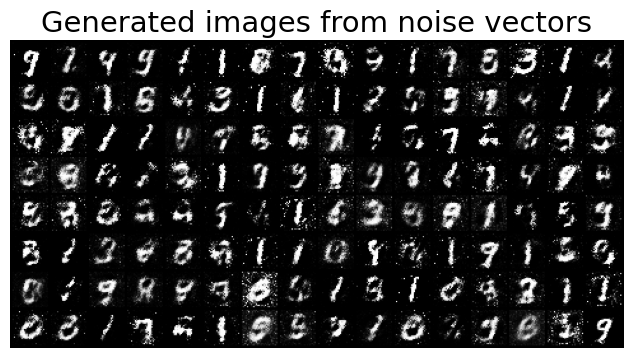

In [ ]:
generator.eval()
n = torch.randn(128, 100)
random_samples = generator.cpu()(n).view(128, 1, 28, 28)
grid = make_grid(random_samples, nrow=16, normalize=True)
plt.figure(figsize=(10, 4))
plt.imshow(grid.permute(1, 2, 0))
plt.axis(False)
plt.title('Generated images from noise vectors', fontsize=21);